# Prepare Data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime,timedelta

In [2]:
file_suffix = '.csv' # format of target data file
path = '../data/dataSets/training/' # path to target data file
filename = 'volume(table 6)_training' # target data file name

In [3]:
# Aggregate valume data into 20 minutes time window
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/scripts/aggregate_volume.py
# output: .csv file at current directory

def avgVolume(in_file):

    out_suffix = '_20min_avg_volume'
    in_file_name = in_file + file_suffix
    out_file_name = in_file.split('_')[1] + out_suffix + file_suffix

    # Step 1: Load volume data
    fr = open(path + in_file_name, 'r')
    fr.readline()  # skip the header
    vol_data = fr.readlines()
    fr.close()

    # Step 2: Create a dictionary to caculate and store volume per time window
    volumes = {}  # key: time window value: dictionary
    for i in range(len(vol_data)):
        each_pass = vol_data[i].replace('"', '').split(',')
        tollgate_id = each_pass[1]
        direction = each_pass[2]

        pass_time = each_pass[0]
        pass_time = datetime.strptime(pass_time, "%Y-%m-%d %H:%M:%S")
        time_window_minute = int(math.floor(pass_time.minute / 20) * 20)
        #print pass_time
        start_time_window = datetime(pass_time.year, pass_time.month, pass_time.day,
                                     pass_time.hour, time_window_minute, 0)

        if start_time_window not in volumes:
            volumes[start_time_window] = {}
        if tollgate_id not in volumes[start_time_window]:
            volumes[start_time_window][tollgate_id] = {}
        if direction not in volumes[start_time_window][tollgate_id]:
            volumes[start_time_window][tollgate_id][direction] = 1
        else:
            volumes[start_time_window][tollgate_id][direction] += 1

    # Step 3: format output for tollgate and direction per time window
    fw = open(out_file_name, 'w')
    fw.writelines(','.join(['"tollgate_id"', '"time_window"', '"direction"', '"volume"']) + '\n')
    time_windows = list(volumes.keys())
    time_windows.sort()
    for time_window_start in time_windows:
        time_window_end = time_window_start + timedelta(minutes=20)
        for tollgate_id in volumes[time_window_start]:
            for direction in volumes[time_window_start][tollgate_id]:
               out_line = ','.join(['"' + str(tollgate_id) + '"', 
                                 '"[' + str(time_window_start) + ',' + str(time_window_end) + ')"',
                                 '"' + str(direction) + '"',
                                 '"' + str(volumes[time_window_start][tollgate_id][direction]) + '"',
                               ]) + '\n'
               fw.writelines(out_line)
    fw.close()

In [4]:
# Load and convert phase 1 training data and save into training_20min_avg_volume.csv

avgVolume(filename)

In [5]:
df = pd.read_csv('training_20min_avg_volume.csv')
df.shape

(10063, 4)

In [6]:
df.head() # Start date/time of training data set

tollgate_id                                time_window  direction  volume
0            3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      17
1            3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     181
2            1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      13
3            1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     140
4            2  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0       2

In [7]:
df.tail() # End date/time of training data set

tollgate_id                                time_window  direction  \
10058            2  [2016-10-17 23:40:00,2016-10-18 00:00:00)          0   
10059            3  [2016-10-17 23:40:00,2016-10-18 00:00:00)          0   
10060            3  [2016-10-17 23:40:00,2016-10-18 00:00:00)          1   
10061            1  [2016-10-17 23:40:00,2016-10-18 00:00:00)          0   
10062            1  [2016-10-17 23:40:00,2016-10-18 00:00:00)          1   

       volume  
10058      18  
10059      15  
10060      22  
10061       2  
10062      10

# Study Data

In [8]:
tollgate_1_direction_0 = df[df['tollgate_id'] == 1][df['direction'] == 0]
tollgate_1_direction_0.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2084, 4)

In [9]:
tollgate_1_direction_0.head()

tollgate_id                                time_window  direction  volume
2             1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      13
5             1  [2016-09-19 00:20:00,2016-09-19 00:40:00)          0       6
11            1  [2016-09-19 00:40:00,2016-09-19 01:00:00)          0       9
16            1  [2016-09-19 01:00:00,2016-09-19 01:20:00)          0      10
18            1  [2016-09-19 01:20:00,2016-09-19 01:40:00)          0      14

In [10]:
tollgate_1_direction_1 = df[df['tollgate_id'] == 1][df['direction'] == 1]
tollgate_1_direction_1.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2084, 4)

In [11]:
tollgate_1_direction_1.head()

tollgate_id                                time_window  direction  volume
3             1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     140
6             1  [2016-09-19 00:20:00,2016-09-19 00:40:00)          1      56
12            1  [2016-09-19 00:40:00,2016-09-19 01:00:00)          1      31
17            1  [2016-09-19 01:00:00,2016-09-19 01:20:00)          1       4
19            1  [2016-09-19 01:20:00,2016-09-19 01:40:00)          1      14

In [12]:
tollgate_2_direction_0 = df[df['tollgate_id'] == 2][df['direction'] == 0]
tollgate_2_direction_0.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(1724, 4)

In [13]:
tollgate_2_direction_0.head()

tollgate_id                                time_window  direction  volume
4             2  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0       2
15            2  [2016-09-19 01:00:00,2016-09-19 01:20:00)          0       1
22            2  [2016-09-19 01:40:00,2016-09-19 02:00:00)          0       2
64            2  [2016-09-19 05:00:00,2016-09-19 05:20:00)          0      14
71            2  [2016-09-19 05:20:00,2016-09-19 05:40:00)          0      12

In [14]:
tollgate_3_direction_0 = df[df['tollgate_id'] == 3][df['direction'] == 0]
tollgate_3_direction_0.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2086, 4)

In [15]:
tollgate_3_direction_0.head()

tollgate_id                                time_window  direction  volume
0             3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      17
7             3  [2016-09-19 00:20:00,2016-09-19 00:40:00)          0      16
9             3  [2016-09-19 00:40:00,2016-09-19 01:00:00)          0      16
13            3  [2016-09-19 01:00:00,2016-09-19 01:20:00)          0      17
20            3  [2016-09-19 01:20:00,2016-09-19 01:40:00)          0      17

In [16]:
tollgate_3_direction_1 = df[df['tollgate_id'] == 3][df['direction'] == 1]
tollgate_3_direction_1.shape

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2085, 4)

In [17]:
tollgate_3_direction_1.head()

tollgate_id                                time_window  direction  volume
1             3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     181
8             3  [2016-09-19 00:20:00,2016-09-19 00:40:00)          1     112
10            3  [2016-09-19 00:40:00,2016-09-19 01:00:00)          1      93
14            3  [2016-09-19 01:00:00,2016-09-19 01:20:00)          1       4
21            3  [2016-09-19 01:20:00,2016-09-19 01:40:00)          1       5

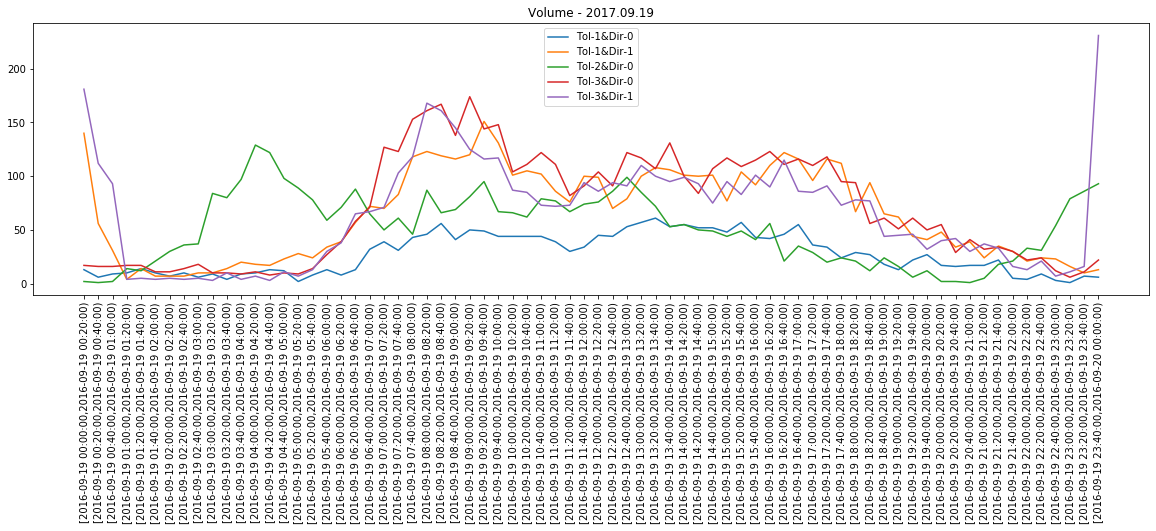

In [18]:
# Vosualize data pattern
plt.figure(figsize=(20,5))

xticks = tollgate_1_direction_0['time_window'].values
plt.plot(xticks[:72], tollgate_1_direction_0['volume'][:72], label='Tol-1&Dir-0')
plt.plot(xticks[:72], tollgate_1_direction_1['volume'][:72], label='Tol-1&Dir-1')
plt.plot(xticks[:72], tollgate_2_direction_0['volume'][:72], label='Tol-2&Dir-0')
plt.plot(xticks[:72], tollgate_3_direction_0['volume'][:72], label='Tol-3&Dir-0')
plt.plot(xticks[:72], tollgate_3_direction_1['volume'][:72], label='Tol-3&Dir-1')
plt.xticks(xticks[:72], xticks[:72], rotation='vertical')
plt.title('Volume - 2017.09.19')
plt.legend()
plt.show()

In [19]:
# Study the raw data
df_raw = pd.read_csv(path + filename + file_suffix)
df_raw.head()

time  tollgate_id  direction  vehicle_model  has_etc  \
0  2016-09-19 23:09:25            2          0              1        0   
1  2016-09-19 23:11:53            2          0              1        0   
2  2016-09-19 23:13:54            2          0              1        0   
3  2016-09-19 23:17:48            1          0              1        1   
4  2016-09-19 23:16:07            2          0              1        0   

   vehicle_type  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [20]:
df_raw['date_time'] = pd.to_datetime(df_raw['time'], format="%Y-%m-%d %H:%M:%S")
df_raw['month'] = df_raw['date_time'].apply(lambda x: x.month)
df_raw['day'] = df_raw['date_time'].apply(lambda x: x.day)
df_raw['weekday'] = df_raw['date_time'].apply(lambda x: x.dayofweek)
df_raw['hour'] = df_raw['date_time'].apply(lambda x: x.hour)
df_raw['minute'] = df_raw['date_time'].apply(lambda x: x.minute)

df_raw['vehicle_type'] = df_raw['vehicle_type'].where((pd.notnull(df_raw['vehicle_type'])), 'Unknown')
df_raw.head()

time  tollgate_id  direction  vehicle_model  has_etc  \
0  2016-09-19 23:09:25            2          0              1        0   
1  2016-09-19 23:11:53            2          0              1        0   
2  2016-09-19 23:13:54            2          0              1        0   
3  2016-09-19 23:17:48            1          0              1        1   
4  2016-09-19 23:16:07            2          0              1        0   

  vehicle_type           date_time  month  day  weekday  hour  minute  
0      Unknown 2016-09-19 23:09:25      9   19        0    23       9  
1      Unknown 2016-09-19 23:11:53      9   19        0    23      11  
2      Unknown 2016-09-19 23:13:54      9   19        0    23      13  
3      Unknown 2016-09-19 23:17:48      9   19        0    23      17  
4      Unknown 2016-09-19 23:16:07      9   19        0    23      16

In [21]:
# Study Vehicles pass at midnight
df_test = df_raw.copy()
df_test = df_test[(df_test['hour'] == 23) | (df_test['hour'] == 0)]
df_test = df_test[df_test['month'] == 9][df_test['day'] == 19]
df_test.head() 

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


time  tollgate_id  direction  vehicle_model  has_etc  \
0  2016-09-19 23:09:25            2          0              1        0   
1  2016-09-19 23:11:53            2          0              1        0   
2  2016-09-19 23:13:54            2          0              1        0   
3  2016-09-19 23:17:48            1          0              1        1   
4  2016-09-19 23:16:07            2          0              1        0   

  vehicle_type           date_time  month  day  weekday  hour  minute  
0      Unknown 2016-09-19 23:09:25      9   19        0    23       9  
1      Unknown 2016-09-19 23:11:53      9   19        0    23      11  
2      Unknown 2016-09-19 23:13:54      9   19        0    23      13  
3      Unknown 2016-09-19 23:17:48      9   19        0    23      17  
4      Unknown 2016-09-19 23:16:07      9   19        0    23      16

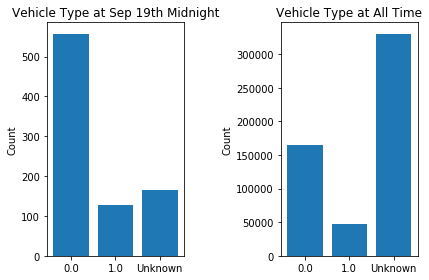

In [22]:
plt.subplot(1, 2, 1)
df_test_grouped = df_test.groupby('vehicle_type').count()
x_ticks = df_test_grouped.index.values
x_pos = np.arange(len(x_ticks))
plt.bar(x_pos, df_test_grouped['time'].values)
plt.xticks(x_pos, x_ticks)
plt.ylabel('Count')
plt.title('Vehicle Type at Sep 19th Midnight')

plt.subplot(1, 2, 2)
df_raw_grouped = df_raw.groupby('vehicle_type').count()
x_ticks = df_raw_grouped.index.values
x_pos = np.arange(len(x_ticks))
plt.bar(x_pos, df_raw_grouped['time'].values)
plt.xticks(x_pos, x_ticks)
plt.ylabel('Count')
plt.title('Vehicle Type at All Time')

plt.tight_layout()
plt.show()

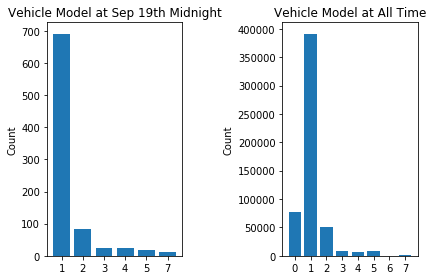

In [23]:
plt.subplot(1, 2, 1)
df_test_grouped = df_test.groupby('vehicle_model').count()
x_ticks = df_test_grouped.index.values
x_pos = np.arange(len(x_ticks))
plt.bar(x_pos, df_test_grouped['time'].values)
plt.xticks(x_pos, x_ticks)
plt.ylabel('Count')
plt.title('Vehicle Model at Sep 19th Midnight')

plt.subplot(1, 2, 2)
df_raw_grouped = df_raw.groupby('vehicle_model').count()
x_ticks = df_raw_grouped.index.values
x_pos = np.arange(len(x_ticks))
plt.bar(x_pos, df_raw_grouped['time'].values)
plt.xticks(x_pos, x_ticks)
plt.ylabel('Count')
plt.title('Vehicle Model at All Time')

plt.tight_layout()
plt.show()

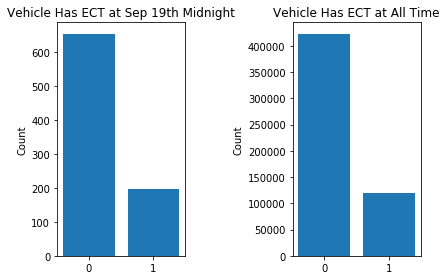

In [24]:
plt.subplot(1, 2, 1)
df_test_grouped = df_test.groupby('has_etc').count()
x_ticks = df_test_grouped.index.values
x_pos = np.arange(len(x_ticks))
plt.bar(x_pos, df_test_grouped['time'].values)
plt.xticks(x_pos, x_ticks)
plt.ylabel('Count')
plt.title('Vehicle Has ECT at Sep 19th Midnight')

plt.subplot(1, 2, 2)
df_raw_grouped = df_raw.groupby('has_etc').count()
x_ticks = df_raw_grouped.index.values
x_pos = np.arange(len(x_ticks))
plt.bar(x_pos, df_raw_grouped['time'].values)
plt.xticks(x_pos, x_ticks)
plt.ylabel('Count')
plt.title('Vehicle Has ECT at All Time')

plt.tight_layout()
plt.show()

In [25]:
# Get month and day
df['month'] = df['time_window'].str.slice(6,8)
df['day'] = df['time_window'].str.slice(9,11)
df.head()

tollgate_id                                time_window  direction  volume  \
0            3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      17   
1            3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     181   
2            1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      13   
3            1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     140   
4            2  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0       2   

  month day  
0    09  19  
1    09  19  
2    09  19  
3    09  19  
4    09  19

In [26]:
# Aggregate on Volume based on date
v_day = df.groupby(['month','day','tollgate_id','direction'], as_index=False).sum()
v_day['date'] = v_day['month'].map(str) + '-' + v_day['day'].map(str) 
v_day.head()

month day  tollgate_id  direction  volume   date
0    09  19            1          0    1969  09-19
1    09  19            1          1    4732  09-19
2    09  19            2          0    3297  09-19
3    09  19            3          0    5037  09-19
4    09  19            3          1    4529  09-19

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


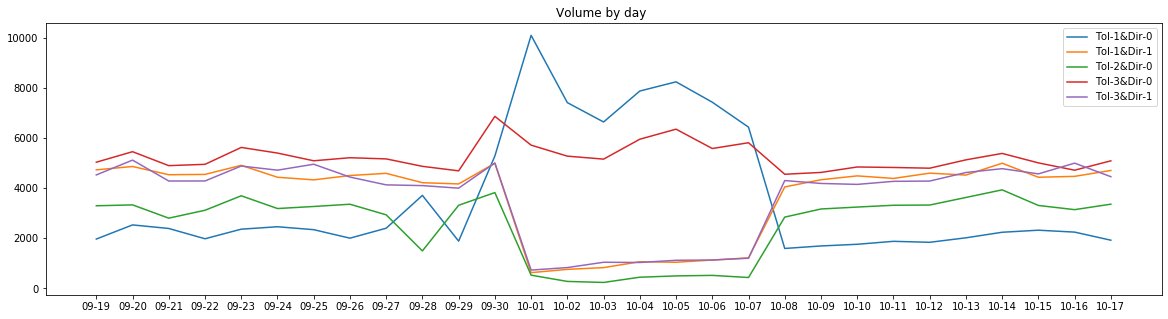

In [27]:
# Visualize volume change throughout the training period
# Observed significant inregularity int the National Day Holiday period

v_day_tollgate_1_direction_0 = v_day[v_day['tollgate_id'] == 1][v_day['direction'] == 0]
v_day_tollgate_1_direction_1 = v_day[v_day['tollgate_id'] == 1][v_day['direction'] == 1]
v_day_tollgate_2_direction_0 = v_day[v_day['tollgate_id'] == 2][v_day['direction'] == 0]
v_day_tollgate_3_direction_0 = v_day[v_day['tollgate_id'] == 3][v_day['direction'] == 0]
v_day_tollgate_3_direction_1 = v_day[v_day['tollgate_id'] == 3][v_day['direction'] == 1]

plt.figure(figsize=(20,5))
xticks = v_day_tollgate_1_direction_0['date'].values

plt.plot(xticks, v_day_tollgate_1_direction_0['volume'], label='Tol-1&Dir-0')
plt.plot(xticks, v_day_tollgate_1_direction_1['volume'], label='Tol-1&Dir-1')
plt.plot(xticks, v_day_tollgate_2_direction_0['volume'], label='Tol-2&Dir-0')
plt.plot(xticks, v_day_tollgate_3_direction_0['volume'], label='Tol-3&Dir-0')
plt.plot(xticks, v_day_tollgate_3_direction_1['volume'], label='Tol-3&Dir-1')

plt.title('Volume by day ')
plt.legend()
plt.show()

In [28]:
# Study the vehicle commute pattern
file_suffix = '.csv' # format of target data file
path = '../data/dataSets/training/' # path to target data file
filename = 'trajectories(table 5)_training' # target data file name

In [29]:
df_vehicles = pd.read_csv(path + filename + file_suffix)
df_vehicles.head()

intersection_id  tollgate_id  vehicle_id   starting_time  \
0               B            3     1065642  7/19/2016 0:14   
1               B            3     1047198  7/19/2016 0:35   
2               B            1     1086390  7/19/2016 0:37   
3               A            2     1071181  7/19/2016 0:37   
4               B            1     1065807  7/19/2016 0:56   

                                          travel_seq  travel_time  
0  105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...        70.85  
1  105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...       148.79  
2  105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...        79.76  
3  110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...        58.05  
4  105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...       137.98

In [30]:
df_vehicles['date_time'] = pd.to_datetime(df_vehicles['starting_time'], format="%m/%d/%Y %H:%M")
df_vehicles['month'] = df_vehicles['date_time'].apply(lambda x: x.month)
df_vehicles['day'] = df_vehicles['date_time'].apply(lambda x: x.day)
df_vehicles['weekday'] = df_vehicles['date_time'].apply(lambda x: x.dayofweek)
df_vehicles['hour'] = df_vehicles['date_time'].apply(lambda x: x.hour)
df_vehicles['minute'] = df_vehicles['date_time'].apply(lambda x: x.minute)

df_vehicles.head()

intersection_id  tollgate_id  vehicle_id   starting_time  \
0               B            3     1065642  7/19/2016 0:14   
1               B            3     1047198  7/19/2016 0:35   
2               B            1     1086390  7/19/2016 0:37   
3               A            2     1071181  7/19/2016 0:37   
4               B            1     1065807  7/19/2016 0:56   

                                          travel_seq  travel_time  \
0  105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...        70.85   
1  105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...       148.79   
2  105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...        79.76   
3  110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...        58.05   
4  105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...       137.98   

            date_time  month  day  weekday  hour  minute  
0 2016-07-19 00:14:00      7   19        1     0      14  
1 2016-07-19 00:35:00      7   19        1     0      35  
2 2016-07-19 00:37:00      7   19        1     0      37  
3 2016-07-19 00:37:00      7   19        1     0      37  
4 2016-07-19 00:56:00      7   19        1     0      56

In [31]:
df_vehicles_grouped = df_vehicles.groupby(['vehicle_id']).count()
df_vehicles_grouped.sort_values(by=['starting_time'], ascending=False).head(5)

intersection_id  tollgate_id  starting_time  travel_seq  \
vehicle_id                                                            
1001157                  96           96             96          96   
1000688                  88           88             88          88   
1000626                  76           76             76          76   
1007050                  65           65             65          65   
1000324                  65           65             65          65   

            travel_time  date_time  month  day  weekday  hour  minute  
vehicle_id                                                             
1001157              96         96     96   96       96    96      96  
1000688              88         88     88   88       88    88      88  
1000626              76         76     76   76       76    76      76  
1007050              65         65     65   65       65    65      65  
1000324              65         65     65   65       65    65      65

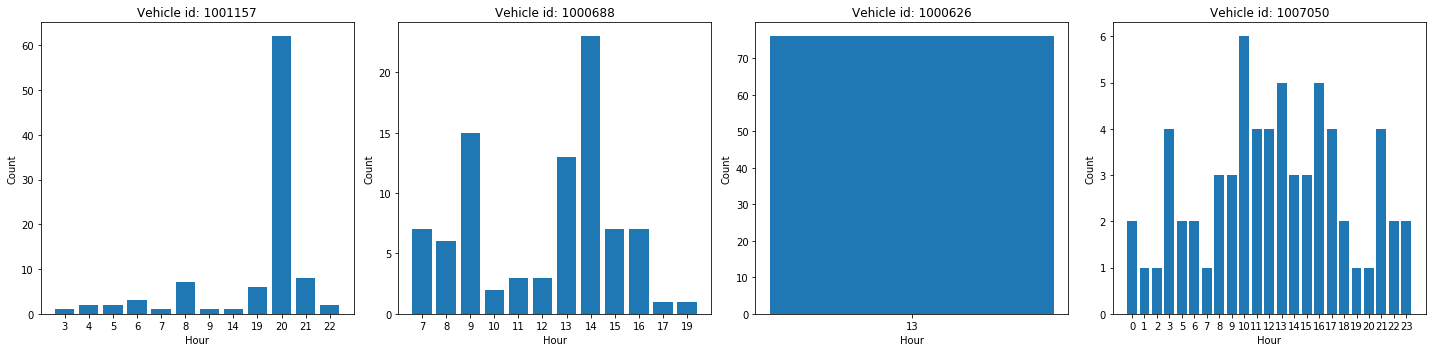

In [32]:
vehicles = [1001157, 1000688, 1000626, 1007050]
plt.figure(figsize=(20,5))

for v in range(len(vehicles)):
    plt.subplot(1, 4, v+1)
    df_vehicles_test = df_vehicles[df_vehicles['vehicle_id'] == vehicles[v]]
    df_vehicles_test = df_vehicles_test.groupby('hour').count()

    x_ticks = df_vehicles_test.index.values
    x_pos = np.arange(len(x_ticks))
    plt.bar(x_pos, df_vehicles_test['starting_time'].values)
    plt.xticks(x_pos, x_ticks)
    plt.ylabel('Count')
    plt.xlabel('Hour')
    plt.title('Vehicle id: ' + str(vehicles[v]))

plt.tight_layout()
plt.show()

# Predict and Evaluate

In [33]:
# Split time window field and format it to YYYY-mm-dd HH:MM:SS
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/code/load_data.py

def parse_avg_volume(filename):
    df = pd.read_csv(filename)

    # Convert data format.
    df['time_window'] = df['time_window'].apply(lambda x: x.split(',')[0].strip('['))
    df['time_window'] = pd.to_datetime(df['time_window'], format="%Y-%m-%d %H:%M:%S")

    return df

In [34]:
# Load Testing Dataset
file_suffix = '.csv'
path = '../data/dataSet_phase2/'
filename = 'volume(table 6)_training2'

avgVolume(filename)

In [35]:
avg_volume_train = parse_avg_volume('training_20min_avg_volume.csv')
avg_volume_train.head()

tollgate_id time_window  direction  volume
0            3  2016-09-19          0      17
1            3  2016-09-19          1     181
2            1  2016-09-19          0      13
3            1  2016-09-19          1     140
4            2  2016-09-19          0       2

In [36]:
avg_volume_test = parse_avg_volume('training2_20min_avg_volume.csv')
avg_volume_test.head()

tollgate_id         time_window  direction  volume
0            3 2016-10-18 00:00:00          0      12
1            3 2016-10-18 00:00:00          1     148
2            1 2016-10-18 00:00:00          0      11
3            1 2016-10-18 00:00:00          1     105
4            3 2016-10-18 00:20:00          0      12

In [37]:
# Extract month/day/dayofweek/hour/minute/holiday features from time window
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/code/train_xgb.py

def convert_dataframe(dataframe):
    df = dataframe.copy()

    # Process date field.
    df['month'] = df['time_window'].apply(lambda x: x.month)
    df['day'] = df['time_window'].apply(lambda x: x.day)
    df['weekday'] = df['time_window'].apply(lambda x: x.dayofweek)
    df['hour'] = df['time_window'].apply(lambda x: x.hour)
    df['minute'] = df['time_window'].apply(lambda x: x.minute)
    df['holiday'] = df['time_window'].apply(lambda x: is_holiday(x))

    # Drop unused field.
    df.drop(['time_window'], axis=1, inplace=True)
    return df

In [38]:
# Check if the day is holiday
# https://github.com/chenzeyuczy/KDD2017/blob/master/code/tools.py

def is_holiday(date_time):

    # Mid-Autumn Festival.
    if date_time.month == 9 and date_time.day >= 15 and date_time.day <= 17:
        return 1
    # National Day.
    elif date_time.month == 10 and date_time.day >= 1 and date_time.day <= 7:
        return 1
    return 0

In [39]:
train_df = avg_volume_train.copy()
train_df = convert_dataframe(train_df)
train_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday
0            3          0      17      9   19        0     0       0        0
1            3          1     181      9   19        0     0       0        0
2            1          0      13      9   19        0     0       0        0
3            1          1     140      9   19        0     0       0        0
4            2          0       2      9   19        0     0       0        0

In [40]:
train_label = train_df['volume'].values
train_df.drop(['volume'], axis=1, inplace=True)

In [41]:
train_label.shape

(10063,)

In [42]:
train_df.head()

tollgate_id  direction  month  day  weekday  hour  minute  holiday
0            3          0      9   19        0     0       0        0
1            3          1      9   19        0     0       0        0
2            1          0      9   19        0     0       0        0
3            1          1      9   19        0     0       0        0
4            2          0      9   19        0     0       0        0

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_label, test_size=0.2, random_state=123)

In [44]:
data_dmatrix = xgb.DMatrix(data=train_df,label=train_label)

# Paramsters Reference: https://github.com/chenzeyuczy/KDD2017/blob/master/code/tuning.log
xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)

In [45]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

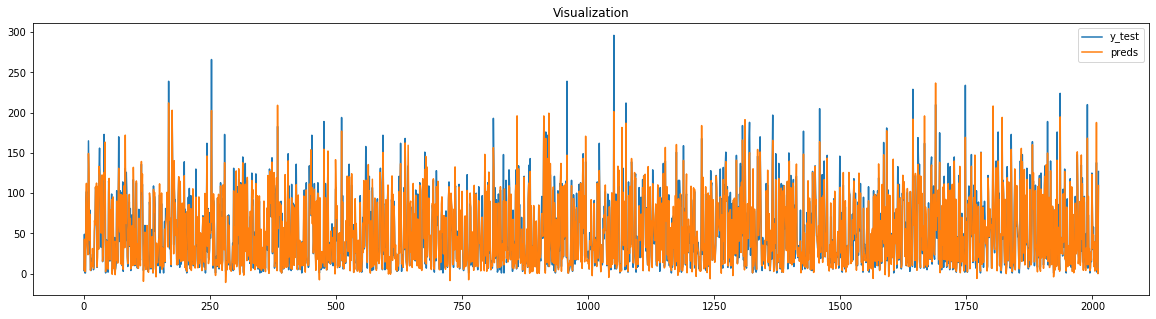

In [46]:
plt.figure(figsize=(20,5))

plt.plot(y_test, label='y_test')
plt.plot(preds, label='preds')
plt.title('Visualization')
plt.legend()
plt.show()

In [47]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 11.853444


In [48]:
def mape(label, pred):

    return np.mean(np.abs(label - pred).astype(np.float64) / label)

In [49]:
test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.364782


In [50]:
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)
test_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday
0            3          0      12     10   18        1     0       0        0
1            3          1     148     10   18        1     0       0        0
2            1          0      11     10   18        1     0       0        0
3            1          1     105     10   18        1     0       0        0
4            3          0      12     10   18        1     0      20        0

In [51]:
test_label = test_df['volume'].values
test_df.drop(['volume'], axis=1, inplace=True)

In [52]:
test_label.shape

(2445,)

In [53]:
test_df.head()

tollgate_id  direction  month  day  weekday  hour  minute  holiday
0            3          0     10   18        1     0       0        0
1            3          1     10   18        1     0       0        0
2            1          0     10   18        1     0       0        0
3            1          1     10   18        1     0       0        0
4            3          0     10   18        1     0      20        0

In [54]:
test_preds = xg_reg.predict(test_df)

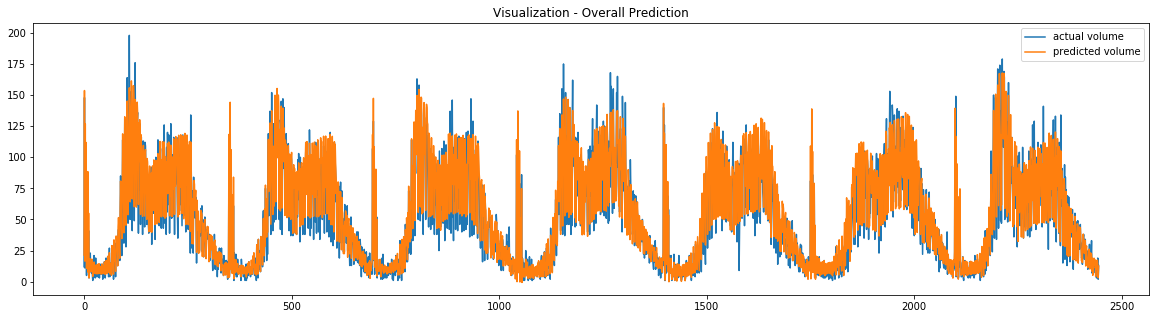

In [55]:
plt.figure(figsize=(20,5))

plt.plot(test_label, label='actual volume')
plt.plot(test_preds, label='predicted volume')
plt.title('Visualization - Overall Prediction')
plt.legend()
plt.show()

In [56]:
test_err = mape(test_label, test_preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.280261


In [57]:
# Excluding Holiday data from training set
train_df = avg_volume_train.copy()
train_df = convert_dataframe(train_df)
train_df.shape

(10063, 9)

In [58]:
train_df_exclude_holiday = train_df[train_df.holiday == 0]
train_df_exclude_holiday.shape

(7684, 9)

In [59]:
train_df_exclude_holiday_label = train_df_exclude_holiday['volume'].values
train_df_exclude_holiday.drop(['volume'], axis=1, inplace=True)

D:\anaconda\conda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [60]:
X_train, X_test, y_train, y_test = train_test_split(train_df_exclude_holiday, train_df_exclude_holiday_label, test_size=0.2, random_state=123)

In [61]:
data_dmatrix = xgb.DMatrix(data=train_df_exclude_holiday,label=train_df_exclude_holiday_label)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)

In [62]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [63]:
test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.253194


In [64]:
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)

test_label = test_df['volume'].values
test_df.drop(['volume'], axis=1, inplace=True)

In [65]:
test_preds = xg_reg.predict(test_df)

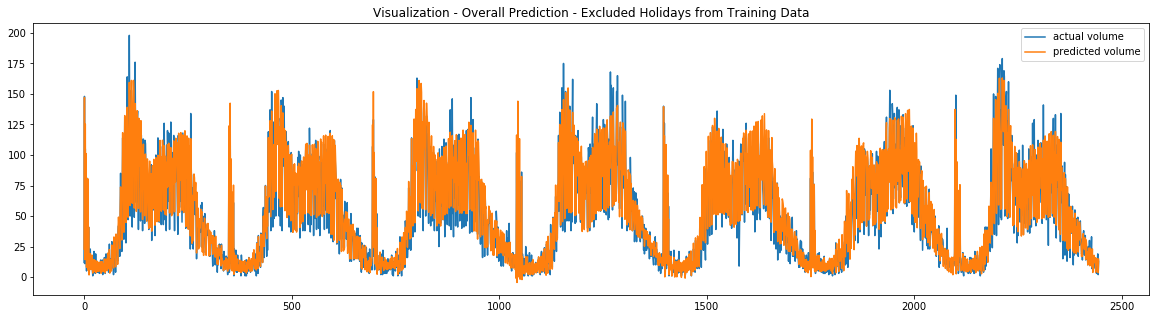

In [66]:
plt.figure(figsize=(20,5))

plt.plot(test_label, label='actual volume')
plt.plot(test_preds, label='predicted volume')
plt.title('Visualization - Overall Prediction - Excluded Holidays from Training Data')
plt.legend()
plt.show()

In [67]:
test_err = mape(test_label, test_preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.268922


In [68]:
# Checking on the rush hour periods
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)
test_df['preds'] = test_preds

test_df_rush_hour = test_df[((test_df['hour'] >= 8) & (test_df['hour'] < 10)) | ((test_df['hour'] >= 17) & (test_df['hour'] < 19))]
test_df_rush_hour.shape

(420, 10)

In [69]:
test_df_rush_hour.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  \
108            2          0     120     10   18        1     8       0   
109            3          0     198     10   18        1     8       0   
110            3          1     119     10   18        1     8       0   
111            1          0      50     10   18        1     8       0   
112            1          1      93     10   18        1     8       0   

     holiday       preds  
108        0  118.855659  
109        0  159.437332  
110        0  134.190079  
111        0   58.568413  
112        0  125.772942

In [70]:
test_df_rush_hour.tail()

tollgate_id  direction  volume  month  day  weekday  hour  minute  \
2365            3          0      49     10   24        0    18      40   
2366            3          1      74     10   24        0    18      40   
2367            2          0      37     10   24        0    18      40   
2368            1          0      13     10   24        0    18      40   
2369            1          1      69     10   24        0    18      40   

      holiday      preds  
2365        0  72.389885  
2366        0  72.746925  
2367        0  54.163578  
2368        0  23.533079  
2369        0  73.871742

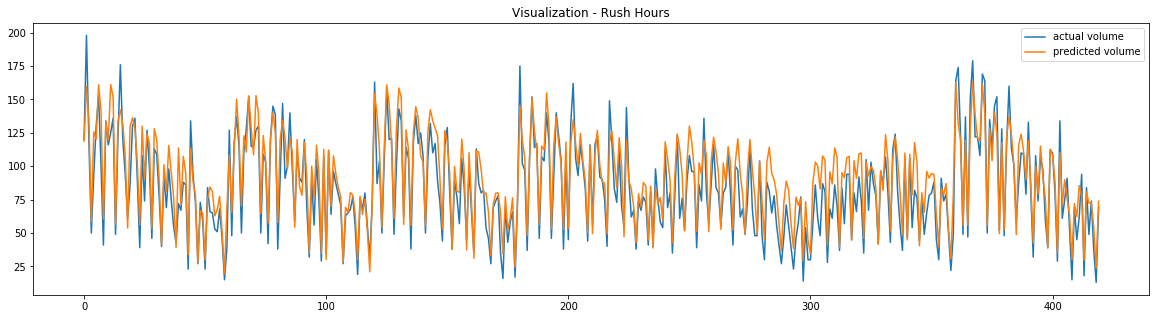

In [71]:
plt.figure(figsize=(20,5))

plt.plot(test_df_rush_hour['volume'].values, label='actual volume')
plt.plot(test_df_rush_hour['preds'].values, label='predicted volume')
plt.title('Visualization - Rush Hours')
plt.legend()
plt.show()

In [72]:
test_err = mape(test_df_rush_hour['volume'].values, test_df_rush_hour['preds'].values)
print ("MAPE: %f" % (test_err))

MAPE: 0.191247


# Incorporate with Weather Data

In [73]:
# Extract month/day/dayofweek/hour/minute/holiday features from time window
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/code/load_data.py

def parse_weather_data(filename):
    df = pd.read_csv(filename)

    df['time_window'] = pd.to_datetime(df.apply(lambda x: "{} {:02}".format(x.date, x.hour), axis=1))
    # Fix errors at wind_direction.
    df['wind_direction'] = df['wind_direction'].apply(lambda x: x % 360)
    df.drop(['date', 'hour'], axis=1, inplace=True)
    df.set_index('time_window', inplace=True)

    return df

In [74]:
# Load Weather Training Dataset
file_suffix = '.csv'
path = '../data/dataSets/training/'
filename = 'weather (table 7)_training'

weather_file = path + filename + file_suffix
weather_training = parse_weather_data(weather_file)
weather_training.head()

pressure  sea_pressure  wind_direction  wind_speed  \
time_window                                                               
2016-07-01 00:00:00    1000.4        1005.3           225.0         2.1   
2016-07-01 03:00:00    1000.5        1005.3           187.0         2.7   
2016-07-01 06:00:00     998.9        1003.7           212.0         2.9   
2016-07-01 09:00:00     998.7        1003.5           244.0         2.7   
2016-07-01 12:00:00     999.7        1004.5           222.0         1.3   

                     temperature  rel_humidity  precipitation  
time_window                                                    
2016-07-01 00:00:00         26.4          94.0            0.0  
2016-07-01 03:00:00         29.0          76.0            0.0  
2016-07-01 06:00:00         31.7          67.0            0.0  
2016-07-01 09:00:00         31.6          59.0            0.0  
2016-07-01 12:00:00         29.9          68.0            0.0

In [75]:
# Load Weather Testing Dataset
file_suffix = '.csv'
path = '../data/dataSets/testing_phase1/'
filename = 'weather (table 7)_test1'

weather_file = path + filename + file_suffix
weather_testing = parse_weather_data(weather_file)
weather_testing.head()

pressure  sea_pressure  wind_direction  wind_speed  \
time_window                                                               
2016-10-18 00:00:00    1015.2        1020.3            62.0         2.1   
2016-10-18 03:00:00    1014.5        1019.5            37.0         2.5   
2016-10-18 06:00:00    1012.5        1017.5           128.0         1.6   
2016-10-18 09:00:00    1013.0        1018.0           205.0         0.6   
2016-10-18 12:00:00    1013.8        1018.8           106.0         1.5   

                     temperature  rel_humidity  precipitation  
time_window                                                    
2016-10-18 00:00:00         20.5          87.0            0.0  
2016-10-18 03:00:00         23.3          73.0            0.0  
2016-10-18 06:00:00         23.4          73.0            0.0  
2016-10-18 09:00:00         20.9          94.0            1.8  
2016-10-18 12:00:00         20.5          94.0            0.5

In [76]:
def get_mean_data(weather_data):
    mean_data = {}
    keys = ['pressure', 'sea_pressure', 'wind_direction', 'wind_speed',
        'temperature', 'rel_humidity', 'precipitation']
    for key in keys:
        mean_data[key] = weather_data[key].mean()
    return mean_data

In [77]:
# Calculate Mean Weather Data to fill NaN values

weather_data = pd.concat([weather_training, weather_testing])
mean_weather = get_mean_data(weather_data)

In [78]:
train_df = avg_volume_train.copy()
time_window = train_df['time_window'].values
train_df = convert_dataframe(train_df)
train_df['time_window'] = time_window # Use time window to join with weather data
train_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday  \
0            3          0      17      9   19        0     0       0        0   
1            3          1     181      9   19        0     0       0        0   
2            1          0      13      9   19        0     0       0        0   
3            1          1     140      9   19        0     0       0        0   
4            2          0       2      9   19        0     0       0        0   

  time_window  
0  2016-09-19  
1  2016-09-19  
2  2016-09-19  
3  2016-09-19  
4  2016-09-19

In [79]:
# Weather data has time window = 3 hours
train_df['date_time'] = train_df.time_window.apply(lambda x: x - pd.Timedelta(hours=x.hour % 3, minutes=x.minute))
train_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday  \
0            3          0      17      9   19        0     0       0        0   
1            3          1     181      9   19        0     0       0        0   
2            1          0      13      9   19        0     0       0        0   
3            1          1     140      9   19        0     0       0        0   
4            2          0       2      9   19        0     0       0        0   

  time_window  date_time  
0  2016-09-19 2016-09-19  
1  2016-09-19 2016-09-19  
2  2016-09-19 2016-09-19  
3  2016-09-19 2016-09-19  
4  2016-09-19 2016-09-19

In [80]:
train_df = train_df.join(weather_training, on='date_time', how='left')
train_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday  \
0            3          0      17      9   19        0     0       0        0   
1            3          1     181      9   19        0     0       0        0   
2            1          0      13      9   19        0     0       0        0   
3            1          1     140      9   19        0     0       0        0   
4            2          0       2      9   19        0     0       0        0   

  time_window  date_time  pressure  sea_pressure  wind_direction  wind_speed  \
0  2016-09-19 2016-09-19    1008.2        1013.2           329.0         2.8   
1  2016-09-19 2016-09-19    1008.2        1013.2           329.0         2.8   
2  2016-09-19 2016-09-19    1008.2        1013.2           329.0         2.8   
3  2016-09-19 2016-09-19    1008.2        1013.2           329.0         2.8   
4  2016-09-19 2016-09-19    1008.2        1013.2           329.0         2.8   

   temperature  rel_humidity  precipitation  
0         22.2          76.0            0.0  
1         22.2          76.0            0.0  
2         22.2          76.0            0.0  
3         22.2          76.0            0.0  
4         22.2          76.0            0.0

In [81]:
# Fill nan in dataframe.
weather_columns = ['pressure', 'sea_pressure', 'precipitation', 'rel_humidity', 'temperature', 'wind_direction', 'wind_speed']
for column in weather_columns:
    train_df[column].fillna(mean_weather[column], inplace=True)

In [82]:
# Remove joint points
train_df = train_df.drop(columns=['time_window','date_time'])

In [83]:
train_df.shape

(10063, 16)

In [84]:
train_label = train_df['volume'].values
train_df.drop(['volume'], axis=1, inplace=True)

In [85]:
train_df_exclude_holiday = train_df[train_df.holiday == 0]
train_df_exclude_holiday.shape

(7684, 15)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(train_df_exclude_holiday, train_df_exclude_holiday_label, test_size=0.2, random_state=123)

In [87]:
data_dmatrix = xgb.DMatrix(data=train_df_exclude_holiday,label=train_df_exclude_holiday_label)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                seed=1, silent=1)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [88]:
test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.260500


In [89]:
test_df = avg_volume_test.copy()
time_window = test_df['time_window'].values
test_df = convert_dataframe(test_df)
test_df['time_window'] = time_window # Use time window to join with weather data
test_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday  \
0            3          0      12     10   18        1     0       0        0   
1            3          1     148     10   18        1     0       0        0   
2            1          0      11     10   18        1     0       0        0   
3            1          1     105     10   18        1     0       0        0   
4            3          0      12     10   18        1     0      20        0   

          time_window  
0 2016-10-18 00:00:00  
1 2016-10-18 00:00:00  
2 2016-10-18 00:00:00  
3 2016-10-18 00:00:00  
4 2016-10-18 00:20:00

In [90]:
test_df['date_time'] = test_df.time_window.apply(lambda x: x - pd.Timedelta(hours=x.hour % 3, minutes=x.minute))
test_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday  \
0            3          0      12     10   18        1     0       0        0   
1            3          1     148     10   18        1     0       0        0   
2            1          0      11     10   18        1     0       0        0   
3            1          1     105     10   18        1     0       0        0   
4            3          0      12     10   18        1     0      20        0   

          time_window  date_time  
0 2016-10-18 00:00:00 2016-10-18  
1 2016-10-18 00:00:00 2016-10-18  
2 2016-10-18 00:00:00 2016-10-18  
3 2016-10-18 00:00:00 2016-10-18  
4 2016-10-18 00:20:00 2016-10-18

In [91]:
test_df = test_df.join(weather_testing, on='date_time', how='left')
test_df.head()

tollgate_id  direction  volume  month  day  weekday  hour  minute  holiday  \
0            3          0      12     10   18        1     0       0        0   
1            3          1     148     10   18        1     0       0        0   
2            1          0      11     10   18        1     0       0        0   
3            1          1     105     10   18        1     0       0        0   
4            3          0      12     10   18        1     0      20        0   

          time_window  date_time  pressure  sea_pressure  wind_direction  \
0 2016-10-18 00:00:00 2016-10-18    1015.2        1020.3            62.0   
1 2016-10-18 00:00:00 2016-10-18    1015.2        1020.3            62.0   
2 2016-10-18 00:00:00 2016-10-18    1015.2        1020.3            62.0   
3 2016-10-18 00:00:00 2016-10-18    1015.2        1020.3            62.0   
4 2016-10-18 00:20:00 2016-10-18    1015.2        1020.3            62.0   

   wind_speed  temperature  rel_humidity  precipitation  
0         2.1         20.5          87.0            0.0  
1         2.1         20.5          87.0            0.0  
2         2.1         20.5          87.0            0.0  
3         2.1         20.5          87.0            0.0  
4         2.1         20.5          87.0            0.0

In [92]:
test_label = test_df['volume'].values
test_df.drop(['volume'], axis=1, inplace=True)

In [93]:
# Fill nan in dataframe.
weather_columns = ['pressure', 'sea_pressure', 'precipitation', 'rel_humidity', 'temperature', 'wind_direction', 'wind_speed']
for column in weather_columns:
    test_df[column].fillna(mean_weather[column], inplace=True)

In [94]:
# Remove joint points
test_df = test_df.drop(columns=['time_window','date_time'])

In [95]:
test_df.shape

(2445, 15)

In [96]:
test_preds = xg_reg.predict(test_df)

In [97]:
test_err = mape(test_label, test_preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.429293


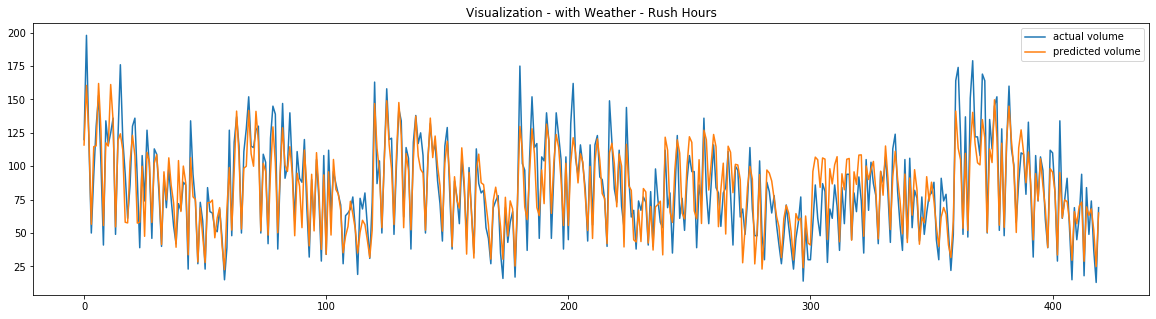

In [98]:
# Checking on the rush hour periods
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)
test_df['preds'] = test_preds

test_df_rush_hour = test_df[((test_df['hour'] >= 8) & (test_df['hour'] < 10)) | ((test_df['hour'] >= 17) & (test_df['hour'] < 19))]

plt.figure(figsize=(20,5))

plt.plot(test_df_rush_hour['volume'].values, label='actual volume')
plt.plot(test_df_rush_hour['preds'].values, label='predicted volume')
plt.title('Visualization - with Weather - Rush Hours')
plt.legend()
plt.show()

In [99]:
test_err = mape(test_df_rush_hour['volume'].values, test_df_rush_hour['preds'].values)
print ("MAPE: %f" % (test_err))

MAPE: 0.187615


# Reference Approach

In [100]:
# Modified based on avgVolume function to include number of vehicles that have ETC

def avgVolume_etc(in_file):

    out_suffix = '_20min_avg_volume_etc'
    in_file_name = in_file + file_suffix
    out_file_name = in_file.split('_')[1] + out_suffix + file_suffix

    # Step 1: Load volume data
    fr = open(path + in_file_name, 'r')
    fr.readline()  # skip the header
    vol_data = fr.readlines()
    fr.close()

    # Step 2: Create a dictionary to caculate and store volume per time window
    volumes = {}  # key: time window value: dictionary
    etcs = {}  # key: number of vehicles the has etc, value: dictionary
    for i in range(len(vol_data)):
        each_pass = vol_data[i].replace('"', '').split(',')
        tollgate_id = each_pass[1]
        direction = each_pass[2]
        has_etc = each_pass[4]

        pass_time = each_pass[0]
        pass_time = datetime.strptime(pass_time, "%Y-%m-%d %H:%M:%S")
        time_window_minute = int(math.floor(pass_time.minute / 20) * 20)
        #print pass_time
        start_time_window = datetime(pass_time.year, pass_time.month, pass_time.day,
                                     pass_time.hour, time_window_minute, 0)

        if start_time_window not in volumes:
            volumes[start_time_window] = {}
            etcs[start_time_window] = {}
        if tollgate_id not in volumes[start_time_window]:
            volumes[start_time_window][tollgate_id] = {}
            etcs[start_time_window][tollgate_id] = {}
        if direction not in volumes[start_time_window][tollgate_id]:
            volumes[start_time_window][tollgate_id][direction] = 1
            etcs[start_time_window][tollgate_id][direction] = int(has_etc) # Initiate etc
        else:
            volumes[start_time_window][tollgate_id][direction] += 1
            etcs[start_time_window][tollgate_id][direction] += int(has_etc) # Stack up the etc counts for this time window

    # Step 3: format output for tollgate and direction per time window
    fw = open(out_file_name, 'w')
    fw.writelines(','.join(['"tollgate_id"', '"time_window"', '"direction"', '"volume"', '"etcs"']) + '\n') # write etc counts
    time_windows = list(volumes.keys())
    time_windows.sort()
    for time_window_start in time_windows:
        time_window_end = time_window_start + timedelta(minutes=20)
        for tollgate_id in volumes[time_window_start]:
            for direction in volumes[time_window_start][tollgate_id]:
               out_line = ','.join(['"' + str(tollgate_id) + '"', 
                                 '"[' + str(time_window_start) + ',' + str(time_window_end) + ')"',
                                 '"' + str(direction) + '"',
                                 '"' + str(volumes[time_window_start][tollgate_id][direction]) + '"',
                                 '"' + str(etcs[time_window_start][tollgate_id][direction]) + '"', # write etc counts
                               ]) + '\n'
               fw.writelines(out_line)
    fw.close()

In [101]:
# Calculate mean volume values for past %day_range days for %dataframe
# This function can significantly affect performance

def get_mean_time_window(dataframe, day_range):
    mean_time_window = []
    for index, row in dataframe.iterrows():
        tollgate_id = row['tollgate_id']
        direction = row['direction']
        time_window = row['time_window']
        volume = row['volume']
        print("Checking tollgate_id %s, direction %s, time_window %s" % (tollgate_id, direction, time_window))
        sum = 0
        for i in range(1, (day_range+1)):
            check_date = time_window - timedelta(days=i)
            print("In this row: checking day: %s" % check_date)
            check_volume = dataframe[dataframe['tollgate_id'] == tollgate_id][dataframe['direction'] == direction][dataframe['time_window'] == check_date]['volume']
            if len(check_volume) == 1:
                sum += float(check_volume)
                print("Adding volume to sum: %s" % sum)
            else:
                sum += volume # Add itself to approximate
                print("Volume not found, used volume of self: %s" % sum)
        mean_time_window.append(sum/day_range)
        print("calculated mean value for this time window: %s" % (sum/day_range))
    dataframe['mean_time_window'] = mean_time_window
    return dataframe

In [102]:
file_suffix = '.csv' # format of target data file
path = '../data/dataSets/training/' # path to target data file
filename = 'volume(table 6)_training' # target data file name

In [103]:
avgVolume_etc(filename)

In [104]:
df = pd.read_csv('training_20min_avg_volume_etc.csv')
df.shape

(10063, 5)

In [105]:
df.head()

tollgate_id                                time_window  direction  volume  \
0            3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      17   
1            3  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     181   
2            1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0      13   
3            1  [2016-09-19 00:00:00,2016-09-19 00:20:00)          1     140   
4            2  [2016-09-19 00:00:00,2016-09-19 00:20:00)          0       2   

   etcs  
0     0  
1    46  
2     4  
3    33  
4     0

In [106]:
avg_volume_train_etc = parse_avg_volume('training_20min_avg_volume_etc.csv')
avg_volume_train_etc.head()

tollgate_id time_window  direction  volume  etcs
0            3  2016-09-19          0      17     0
1            3  2016-09-19          1     181    46
2            1  2016-09-19          0      13     4
3            1  2016-09-19          1     140    33
4            2  2016-09-19          0       2     0

In [107]:
train_df = avg_volume_train_etc.copy()
# train_df['volume'] = train_df['volume'].map(lambda x: np.log(x)) # Use log to reduce influence of outliers, will convert back when calculate MAPE
time_window = train_df['time_window'].values
train_df = convert_dataframe(train_df)
train_df['time_window'] = time_window # Use time window to join with weather data
get_mean_time_window(train_df,5) # Populate mean of same time window for previous 5 days
train_df.head()

Checking tollgate_id 3, direction 0, time_window 2016-09-19 00:00:00
In this row: checking day: 2016-09-18 00:00:00
Volume not found, used volume of self: 17
In this row: checking day: 2016-09-17 00:00:00
Volume not found, used volume of self: 34
In this row: checking day: 2016-09-16 00:00:00
Volume not found, used volume of self: 51
In this row: checking day: 2016-09-15 00:00:00
Volume not found, used volume of self: 68
In this row: checking day: 2016-09-14 00:00:00
Volume not found, used volume of self: 85
calculated mean value for this time window: 17.0
Checking tollgate_id 3, direction 1, time_window 2016-09-19 00:00:00
In this row: checking day: 2016-09-18 00:00:00
Volume not found, used volume of self: 181
In this row: checking day: 2016-09-17 00:00:00
Volume not found, used volume of self: 362
In this row: checking day: 2016-09-16 00:00:00
Volume not found, used volume of self: 543
In this row: checking day: 2016-09-15 00:00:00
Volume not found, used volume of self: 724
In this 

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Volume not found, used volume of self: 20
calculated mean value for this time window: 4.0
Checking tollgate_id 2, direction 0, time_window 2016-09-19 01:00:00
In this row: checking day: 2016-09-18 01:00:00
Volume not found, used volume of self: 1
In this row: checking day: 2016-09-17 01:00:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-09-16 01:00:00
Volume not found, used volume of self: 3
In this row: checking day: 2016-09-15 01:00:00
Volume not found, used volume of self: 4
In this row: checking day: 2016-09-14 01:00:00
Volume not found, used volume of self: 5
calculated mean value for this time window: 1.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 01:00:00
In this row: checking day: 2016-09-18 01:00:00
Volume not found, used volume of self: 10
In this row: checking day: 2016-09-17 01:00:00
Volume not found, used volume of self: 20
In this row: checking day: 2016-09-16 01:00:00
Volume not found, used volume of self: 30
In this row: chec

Volume not found, used volume of self: 50
calculated mean value for this time window: 10.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 03:20:00
In this row: checking day: 2016-09-18 03:20:00
Volume not found, used volume of self: 4
In this row: checking day: 2016-09-17 03:20:00
Volume not found, used volume of self: 8
In this row: checking day: 2016-09-16 03:20:00
Volume not found, used volume of self: 12
In this row: checking day: 2016-09-15 03:20:00
Volume not found, used volume of self: 16
In this row: checking day: 2016-09-14 03:20:00
Volume not found, used volume of self: 20
calculated mean value for this time window: 4.0
Checking tollgate_id 1, direction 1, time_window 2016-09-19 03:20:00
In this row: checking day: 2016-09-18 03:20:00
Volume not found, used volume of self: 14
In this row: checking day: 2016-09-17 03:20:00
Volume not found, used volume of self: 28
In this row: checking day: 2016-09-16 03:20:00
Volume not found, used volume of self: 42
In this row: 

Volume not found, used volume of self: 21
In this row: checking day: 2016-09-15 05:20:00
Volume not found, used volume of self: 28
In this row: checking day: 2016-09-14 05:20:00
Volume not found, used volume of self: 35
calculated mean value for this time window: 7.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 05:20:00
In this row: checking day: 2016-09-18 05:20:00
Volume not found, used volume of self: 8
In this row: checking day: 2016-09-17 05:20:00
Volume not found, used volume of self: 16
In this row: checking day: 2016-09-16 05:20:00
Volume not found, used volume of self: 24
In this row: checking day: 2016-09-15 05:20:00
Volume not found, used volume of self: 32
In this row: checking day: 2016-09-14 05:20:00
Volume not found, used volume of self: 40
calculated mean value for this time window: 8.0
Checking tollgate_id 1, direction 1, time_window 2016-09-19 05:20:00
In this row: checking day: 2016-09-18 05:20:00
Volume not found, used volume of self: 24
In this row: 

Volume not found, used volume of self: 76
In this row: checking day: 2016-09-16 06:20:00
Volume not found, used volume of self: 114
In this row: checking day: 2016-09-15 06:20:00
Volume not found, used volume of self: 152
In this row: checking day: 2016-09-14 06:20:00
Volume not found, used volume of self: 190
calculated mean value for this time window: 38.0
Checking tollgate_id 2, direction 0, time_window 2016-09-19 06:20:00
In this row: checking day: 2016-09-18 06:20:00
Volume not found, used volume of self: 36
In this row: checking day: 2016-09-17 06:20:00
Volume not found, used volume of self: 72
In this row: checking day: 2016-09-16 06:20:00
Volume not found, used volume of self: 108
In this row: checking day: 2016-09-15 06:20:00
Volume not found, used volume of self: 144
In this row: checking day: 2016-09-14 06:20:00
Volume not found, used volume of self: 180
calculated mean value for this time window: 36.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 06:20:00
In t

Volume not found, used volume of self: 590
calculated mean value for this time window: 118.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 08:00:00
In this row: checking day: 2016-09-18 08:00:00
Volume not found, used volume of self: 46
In this row: checking day: 2016-09-17 08:00:00
Volume not found, used volume of self: 92
In this row: checking day: 2016-09-16 08:00:00
Volume not found, used volume of self: 138
In this row: checking day: 2016-09-15 08:00:00
Volume not found, used volume of self: 184
In this row: checking day: 2016-09-14 08:00:00
Volume not found, used volume of self: 230
calculated mean value for this time window: 46.0
Checking tollgate_id 1, direction 1, time_window 2016-09-19 08:00:00
In this row: checking day: 2016-09-18 08:00:00
Volume not found, used volume of self: 123
In this row: checking day: 2016-09-17 08:00:00
Volume not found, used volume of self: 246
In this row: checking day: 2016-09-16 08:00:00
Volume not found, used volume of self: 369
In

Volume not found, used volume of self: 178
In this row: checking day: 2016-09-16 09:00:00
Volume not found, used volume of self: 267
In this row: checking day: 2016-09-15 09:00:00
Volume not found, used volume of self: 356
In this row: checking day: 2016-09-14 09:00:00
Volume not found, used volume of self: 445
calculated mean value for this time window: 89.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 09:00:00
In this row: checking day: 2016-09-18 09:00:00
Volume not found, used volume of self: 50
In this row: checking day: 2016-09-17 09:00:00
Volume not found, used volume of self: 100
In this row: checking day: 2016-09-16 09:00:00
Volume not found, used volume of self: 150
In this row: checking day: 2016-09-15 09:00:00
Volume not found, used volume of self: 200
In this row: checking day: 2016-09-14 09:00:00
Volume not found, used volume of self: 250
calculated mean value for this time window: 50.0
Checking tollgate_id 1, direction 1, time_window 2016-09-19 09:00:00
In

Volume not found, used volume of self: 85
In this row: checking day: 2016-09-17 10:40:00
Volume not found, used volume of self: 170
In this row: checking day: 2016-09-16 10:40:00
Volume not found, used volume of self: 255
In this row: checking day: 2016-09-15 10:40:00
Volume not found, used volume of self: 340
In this row: checking day: 2016-09-14 10:40:00
Volume not found, used volume of self: 425
calculated mean value for this time window: 85.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 10:40:00
In this row: checking day: 2016-09-18 10:40:00
Volume not found, used volume of self: 44
In this row: checking day: 2016-09-17 10:40:00
Volume not found, used volume of self: 88
In this row: checking day: 2016-09-16 10:40:00
Volume not found, used volume of self: 132
In this row: checking day: 2016-09-15 10:40:00
Volume not found, used volume of self: 176
In this row: checking day: 2016-09-14 10:40:00
Volume not found, used volume of self: 220
calculated mean value for this t

In this row: checking day: 2016-09-15 12:20:00
Volume not found, used volume of self: 176
In this row: checking day: 2016-09-14 12:20:00
Volume not found, used volume of self: 220
calculated mean value for this time window: 44.0
Checking tollgate_id 1, direction 1, time_window 2016-09-19 12:20:00
In this row: checking day: 2016-09-18 12:20:00
Volume not found, used volume of self: 70
In this row: checking day: 2016-09-17 12:20:00
Volume not found, used volume of self: 140
In this row: checking day: 2016-09-16 12:20:00
Volume not found, used volume of self: 210
In this row: checking day: 2016-09-15 12:20:00
Volume not found, used volume of self: 280
In this row: checking day: 2016-09-14 12:20:00
Volume not found, used volume of self: 350
calculated mean value for this time window: 70.0
Checking tollgate_id 3, direction 0, time_window 2016-09-19 12:40:00
In this row: checking day: 2016-09-18 12:40:00
Volume not found, used volume of self: 122
In this row: checking day: 2016-09-17 12:40:0

Volume not found, used volume of self: 122
In this row: checking day: 2016-09-16 13:20:00
Volume not found, used volume of self: 183
In this row: checking day: 2016-09-15 13:20:00
Volume not found, used volume of self: 244
In this row: checking day: 2016-09-14 13:20:00
Volume not found, used volume of self: 305
calculated mean value for this time window: 61.0
Checking tollgate_id 1, direction 1, time_window 2016-09-19 13:20:00
In this row: checking day: 2016-09-18 13:20:00
Volume not found, used volume of self: 108
In this row: checking day: 2016-09-17 13:20:00
Volume not found, used volume of self: 216
In this row: checking day: 2016-09-16 13:20:00
Volume not found, used volume of self: 324
In this row: checking day: 2016-09-15 13:20:00
Volume not found, used volume of self: 432
In this row: checking day: 2016-09-14 13:20:00
Volume not found, used volume of self: 540
calculated mean value for this time window: 108.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 13:40:00


Volume not found, used volume of self: 100
In this row: checking day: 2016-09-17 14:20:00
Volume not found, used volume of self: 200
In this row: checking day: 2016-09-16 14:20:00
Volume not found, used volume of self: 300
In this row: checking day: 2016-09-15 14:20:00
Volume not found, used volume of self: 400
In this row: checking day: 2016-09-14 14:20:00
Volume not found, used volume of self: 500
calculated mean value for this time window: 100.0
Checking tollgate_id 2, direction 0, time_window 2016-09-19 14:20:00
In this row: checking day: 2016-09-18 14:20:00
Volume not found, used volume of self: 62
In this row: checking day: 2016-09-17 14:20:00
Volume not found, used volume of self: 124
In this row: checking day: 2016-09-16 14:20:00
Volume not found, used volume of self: 186
In this row: checking day: 2016-09-15 14:20:00
Volume not found, used volume of self: 248
In this row: checking day: 2016-09-14 14:20:00
Volume not found, used volume of self: 310
calculated mean value for thi

Volume not found, used volume of self: 101
In this row: checking day: 2016-09-17 16:00:00
Volume not found, used volume of self: 202
In this row: checking day: 2016-09-16 16:00:00
Volume not found, used volume of self: 303
In this row: checking day: 2016-09-15 16:00:00
Volume not found, used volume of self: 404
In this row: checking day: 2016-09-14 16:00:00
Volume not found, used volume of self: 505
calculated mean value for this time window: 101.0
Checking tollgate_id 1, direction 0, time_window 2016-09-19 16:20:00
In this row: checking day: 2016-09-18 16:20:00
Volume not found, used volume of self: 46
In this row: checking day: 2016-09-17 16:20:00
Volume not found, used volume of self: 92
In this row: checking day: 2016-09-16 16:20:00
Volume not found, used volume of self: 138
In this row: checking day: 2016-09-15 16:20:00
Volume not found, used volume of self: 184
In this row: checking day: 2016-09-14 16:20:00
Volume not found, used volume of self: 230
calculated mean value for this

Volume not found, used volume of self: 172
In this row: checking day: 2016-09-16 17:00:00
Volume not found, used volume of self: 258
In this row: checking day: 2016-09-15 17:00:00
Volume not found, used volume of self: 344
In this row: checking day: 2016-09-14 17:00:00
Volume not found, used volume of self: 430
calculated mean value for this time window: 86.0
Checking tollgate_id 3, direction 0, time_window 2016-09-19 17:20:00
In this row: checking day: 2016-09-18 17:20:00
Volume not found, used volume of self: 118
In this row: checking day: 2016-09-17 17:20:00
Volume not found, used volume of self: 236
In this row: checking day: 2016-09-16 17:20:00
Volume not found, used volume of self: 354
In this row: checking day: 2016-09-15 17:20:00
Volume not found, used volume of self: 472
In this row: checking day: 2016-09-14 17:20:00
Volume not found, used volume of self: 590
calculated mean value for this time window: 118.0
Checking tollgate_id 3, direction 1, time_window 2016-09-19 17:20:00


Volume not found, used volume of self: 255
calculated mean value for this time window: 51.0
Checking tollgate_id 3, direction 1, time_window 2016-09-19 19:00:00
In this row: checking day: 2016-09-18 19:00:00
Volume not found, used volume of self: 44
In this row: checking day: 2016-09-17 19:00:00
Volume not found, used volume of self: 88
In this row: checking day: 2016-09-16 19:00:00
Volume not found, used volume of self: 132
In this row: checking day: 2016-09-15 19:00:00
Volume not found, used volume of self: 176
In this row: checking day: 2016-09-14 19:00:00
Volume not found, used volume of self: 220
calculated mean value for this time window: 44.0
Checking tollgate_id 2, direction 0, time_window 2016-09-19 19:00:00
In this row: checking day: 2016-09-18 19:00:00
Volume not found, used volume of self: 44
In this row: checking day: 2016-09-17 19:00:00
Volume not found, used volume of self: 88
In this row: checking day: 2016-09-16 19:00:00
Volume not found, used volume of self: 132
In th

Volume not found, used volume of self: 164
In this row: checking day: 2016-09-14 20:40:00
Volume not found, used volume of self: 205
calculated mean value for this time window: 41.0
Checking tollgate_id 3, direction 1, time_window 2016-09-19 20:40:00
In this row: checking day: 2016-09-18 20:40:00
Volume not found, used volume of self: 42
In this row: checking day: 2016-09-17 20:40:00
Volume not found, used volume of self: 84
In this row: checking day: 2016-09-16 20:40:00
Volume not found, used volume of self: 126
In this row: checking day: 2016-09-15 20:40:00
Volume not found, used volume of self: 168
In this row: checking day: 2016-09-14 20:40:00
Volume not found, used volume of self: 210
calculated mean value for this time window: 42.0
Checking tollgate_id 2, direction 0, time_window 2016-09-19 20:40:00
In this row: checking day: 2016-09-18 20:40:00
Volume not found, used volume of self: 35
In this row: checking day: 2016-09-17 20:40:00
Volume not found, used volume of self: 70
In th

Volume not found, used volume of self: 10
In this row: checking day: 2016-09-16 21:40:00
Volume not found, used volume of self: 15
In this row: checking day: 2016-09-15 21:40:00
Volume not found, used volume of self: 20
In this row: checking day: 2016-09-14 21:40:00
Volume not found, used volume of self: 25
calculated mean value for this time window: 5.0
Checking tollgate_id 1, direction 1, time_window 2016-09-19 21:40:00
In this row: checking day: 2016-09-18 21:40:00
Volume not found, used volume of self: 30
In this row: checking day: 2016-09-17 21:40:00
Volume not found, used volume of self: 60
In this row: checking day: 2016-09-16 21:40:00
Volume not found, used volume of self: 90
In this row: checking day: 2016-09-15 21:40:00
Volume not found, used volume of self: 120
In this row: checking day: 2016-09-14 21:40:00
Volume not found, used volume of self: 150
calculated mean value for this time window: 30.0
Checking tollgate_id 2, direction 0, time_window 2016-09-19 21:40:00
In this r

Volume not found, used volume of self: 12
In this row: checking day: 2016-09-16 23:20:00
Volume not found, used volume of self: 18
In this row: checking day: 2016-09-15 23:20:00
Volume not found, used volume of self: 24
In this row: checking day: 2016-09-14 23:20:00
Volume not found, used volume of self: 30
calculated mean value for this time window: 6.0
Checking tollgate_id 3, direction 0, time_window 2016-09-19 23:40:00
In this row: checking day: 2016-09-18 23:40:00
Volume not found, used volume of self: 22
In this row: checking day: 2016-09-17 23:40:00
Volume not found, used volume of self: 44
In this row: checking day: 2016-09-16 23:40:00
Volume not found, used volume of self: 66
In this row: checking day: 2016-09-15 23:40:00
Volume not found, used volume of self: 88
In this row: checking day: 2016-09-14 23:40:00
Volume not found, used volume of self: 110
calculated mean value for this time window: 22.0
Checking tollgate_id 3, direction 1, time_window 2016-09-19 23:40:00
In this ro

Volume not found, used volume of self: 30.0
In this row: checking day: 2016-09-16 01:20:00
Volume not found, used volume of self: 38.0
In this row: checking day: 2016-09-15 01:20:00
Volume not found, used volume of self: 46.0
calculated mean value for this time window: 9.2
Checking tollgate_id 2, direction 0, time_window 2016-09-20 01:20:00
In this row: checking day: 2016-09-19 01:20:00
Volume not found, used volume of self: 1
In this row: checking day: 2016-09-18 01:20:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-09-17 01:20:00
Volume not found, used volume of self: 3
In this row: checking day: 2016-09-16 01:20:00
Volume not found, used volume of self: 4
In this row: checking day: 2016-09-15 01:20:00
Volume not found, used volume of self: 5
calculated mean value for this time window: 1.0
Checking tollgate_id 3, direction 0, time_window 2016-09-20 01:40:00
In this row: checking day: 2016-09-19 01:40:00
Adding volume to sum: 11.0
In this row: checking day:

Adding volume to sum: 4.0
In this row: checking day: 2016-09-18 03:20:00
Volume not found, used volume of self: 12.0
In this row: checking day: 2016-09-17 03:20:00
Volume not found, used volume of self: 20.0
In this row: checking day: 2016-09-16 03:20:00
Volume not found, used volume of self: 28.0
In this row: checking day: 2016-09-15 03:20:00
Volume not found, used volume of self: 36.0
calculated mean value for this time window: 7.2
Checking tollgate_id 1, direction 1, time_window 2016-09-20 03:20:00
In this row: checking day: 2016-09-19 03:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-18 03:20:00
Volume not found, used volume of self: 27.0
In this row: checking day: 2016-09-17 03:20:00
Volume not found, used volume of self: 40.0
In this row: checking day: 2016-09-16 03:20:00
Volume not found, used volume of self: 53.0
In this row: checking day: 2016-09-15 03:20:00
Volume not found, used volume of self: 66.0
calculated mean value for this time window: 13.2
Checki

Adding volume to sum: 21.0
In this row: checking day: 2016-09-18 05:40:00
Volume not found, used volume of self: 42.0
In this row: checking day: 2016-09-17 05:40:00
Volume not found, used volume of self: 63.0
In this row: checking day: 2016-09-16 05:40:00
Volume not found, used volume of self: 84.0
In this row: checking day: 2016-09-15 05:40:00
Volume not found, used volume of self: 105.0
calculated mean value for this time window: 21.0
Checking tollgate_id 1, direction 0, time_window 2016-09-20 05:40:00
In this row: checking day: 2016-09-19 05:40:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-18 05:40:00
Volume not found, used volume of self: 23.0
In this row: checking day: 2016-09-17 05:40:00
Volume not found, used volume of self: 33.0
In this row: checking day: 2016-09-16 05:40:00
Volume not found, used volume of self: 43.0
In this row: checking day: 2016-09-15 05:40:00
Volume not found, used volume of self: 53.0
calculated mean value for this time window: 10.6
Che

Volume not found, used volume of self: 265.0
In this row: checking day: 2016-09-16 07:20:00
Volume not found, used volume of self: 362.0
In this row: checking day: 2016-09-15 07:20:00
Volume not found, used volume of self: 459.0
calculated mean value for this time window: 91.8
Checking tollgate_id 1, direction 0, time_window 2016-09-20 07:20:00
In this row: checking day: 2016-09-19 07:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-09-18 07:20:00
Volume not found, used volume of self: 61.0
In this row: checking day: 2016-09-17 07:20:00
Volume not found, used volume of self: 91.0
In this row: checking day: 2016-09-16 07:20:00
Volume not found, used volume of self: 121.0
In this row: checking day: 2016-09-15 07:20:00
Volume not found, used volume of self: 151.0
calculated mean value for this time window: 30.2
Checking tollgate_id 1, direction 1, time_window 2016-09-20 07:20:00
In this row: checking day: 2016-09-19 07:20:00
Adding volume to sum: 83.0
In this row: checking

Adding volume to sum: 78.0
In this row: checking day: 2016-09-18 09:20:00
Volume not found, used volume of self: 177.0
In this row: checking day: 2016-09-17 09:20:00
Volume not found, used volume of self: 276.0
In this row: checking day: 2016-09-16 09:20:00
Volume not found, used volume of self: 375.0
In this row: checking day: 2016-09-15 09:20:00
Volume not found, used volume of self: 474.0
calculated mean value for this time window: 94.8
Checking tollgate_id 3, direction 0, time_window 2016-09-20 09:20:00
In this row: checking day: 2016-09-19 09:20:00
Adding volume to sum: 144.0
In this row: checking day: 2016-09-18 09:20:00
Volume not found, used volume of self: 286.0
In this row: checking day: 2016-09-17 09:20:00
Volume not found, used volume of self: 428.0
In this row: checking day: 2016-09-16 09:20:00
Volume not found, used volume of self: 570.0
In this row: checking day: 2016-09-15 09:20:00
Volume not found, used volume of self: 712.0
calculated mean value for this time window: 

Volume not found, used volume of self: 231.0
In this row: checking day: 2016-09-16 11:00:00
Volume not found, used volume of self: 310.0
In this row: checking day: 2016-09-15 11:00:00
Volume not found, used volume of self: 389.0
calculated mean value for this time window: 77.8
Checking tollgate_id 1, direction 0, time_window 2016-09-20 11:00:00
In this row: checking day: 2016-09-19 11:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-18 11:00:00
Volume not found, used volume of self: 96.0
In this row: checking day: 2016-09-17 11:00:00
Volume not found, used volume of self: 153.0
In this row: checking day: 2016-09-16 11:00:00
Volume not found, used volume of self: 210.0
In this row: checking day: 2016-09-15 11:00:00
Volume not found, used volume of self: 267.0
calculated mean value for this time window: 53.4
Checking tollgate_id 1, direction 1, time_window 2016-09-20 11:00:00
In this row: checking day: 2016-09-19 11:00:00
Adding volume to sum: 86.0
In this row: checkin

Volume not found, used volume of self: 381.0
calculated mean value for this time window: 76.2
Checking tollgate_id 3, direction 0, time_window 2016-09-20 13:00:00
In this row: checking day: 2016-09-19 13:00:00
Adding volume to sum: 117.0
In this row: checking day: 2016-09-18 13:00:00
Volume not found, used volume of self: 247.0
In this row: checking day: 2016-09-17 13:00:00
Volume not found, used volume of self: 377.0
In this row: checking day: 2016-09-16 13:00:00
Volume not found, used volume of self: 507.0
In this row: checking day: 2016-09-15 13:00:00
Volume not found, used volume of self: 637.0
calculated mean value for this time window: 127.4
Checking tollgate_id 3, direction 1, time_window 2016-09-20 13:00:00
In this row: checking day: 2016-09-19 13:00:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-18 13:00:00
Volume not found, used volume of self: 185.0
In this row: checking day: 2016-09-17 13:00:00
Volume not found, used volume of self: 279.0
In this row: chec

Volume not found, used volume of self: 309.0
In this row: checking day: 2016-09-15 14:00:00
Volume not found, used volume of self: 390.0
calculated mean value for this time window: 78.0
Checking tollgate_id 1, direction 0, time_window 2016-09-20 14:00:00
In this row: checking day: 2016-09-19 14:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-09-18 14:00:00
Volume not found, used volume of self: 136.0
In this row: checking day: 2016-09-17 14:00:00
Volume not found, used volume of self: 217.0
In this row: checking day: 2016-09-16 14:00:00
Volume not found, used volume of self: 298.0
In this row: checking day: 2016-09-15 14:00:00
Volume not found, used volume of self: 379.0
calculated mean value for this time window: 75.8
Checking tollgate_id 1, direction 1, time_window 2016-09-20 14:00:00
In this row: checking day: 2016-09-19 14:00:00
Adding volume to sum: 101.0
In this row: checking day: 2016-09-18 14:00:00
Volume not found, used volume of self: 206.0
In this row: check

Volume not found, used volume of self: 376.0
calculated mean value for this time window: 75.2
Checking tollgate_id 3, direction 0, time_window 2016-09-20 15:40:00
In this row: checking day: 2016-09-19 15:40:00
Adding volume to sum: 115.0
In this row: checking day: 2016-09-18 15:40:00
Volume not found, used volume of self: 246.0
In this row: checking day: 2016-09-17 15:40:00
Volume not found, used volume of self: 377.0
In this row: checking day: 2016-09-16 15:40:00
Volume not found, used volume of self: 508.0
In this row: checking day: 2016-09-15 15:40:00
Volume not found, used volume of self: 639.0
calculated mean value for this time window: 127.8
Checking tollgate_id 3, direction 1, time_window 2016-09-20 15:40:00
In this row: checking day: 2016-09-19 15:40:00
Adding volume to sum: 83.0
In this row: checking day: 2016-09-18 15:40:00
Volume not found, used volume of self: 170.0
In this row: checking day: 2016-09-17 15:40:00
Volume not found, used volume of self: 257.0
In this row: chec

In this row: checking day: 2016-09-16 17:40:00
Volume not found, used volume of self: 380.0
In this row: checking day: 2016-09-15 17:40:00
Volume not found, used volume of self: 475.0
calculated mean value for this time window: 95.0
Checking tollgate_id 3, direction 1, time_window 2016-09-20 17:40:00
In this row: checking day: 2016-09-19 17:40:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-18 17:40:00
Volume not found, used volume of self: 197.0
In this row: checking day: 2016-09-17 17:40:00
Volume not found, used volume of self: 303.0
In this row: checking day: 2016-09-16 17:40:00
Volume not found, used volume of self: 409.0
In this row: checking day: 2016-09-15 17:40:00
Volume not found, used volume of self: 515.0
calculated mean value for this time window: 103.0
Checking tollgate_id 2, direction 0, time_window 2016-09-20 17:40:00
In this row: checking day: 2016-09-19 17:40:00
Adding volume to sum: 53.0
In this row: checking day: 2016-09-18 17:40:00
Volume not found

Volume not found, used volume of self: 97.0
In this row: checking day: 2016-09-17 19:00:00
Volume not found, used volume of self: 150.0
In this row: checking day: 2016-09-16 19:00:00
Volume not found, used volume of self: 203.0
In this row: checking day: 2016-09-15 19:00:00
Volume not found, used volume of self: 256.0
calculated mean value for this time window: 51.2
Checking tollgate_id 3, direction 0, time_window 2016-09-20 19:20:00
In this row: checking day: 2016-09-19 19:20:00
Adding volume to sum: 61.0
In this row: checking day: 2016-09-18 19:20:00
Volume not found, used volume of self: 113.0
In this row: checking day: 2016-09-17 19:20:00
Volume not found, used volume of self: 165.0
In this row: checking day: 2016-09-16 19:20:00
Volume not found, used volume of self: 217.0
In this row: checking day: 2016-09-15 19:20:00
Volume not found, used volume of self: 269.0
calculated mean value for this time window: 53.8
Checking tollgate_id 3, direction 1, time_window 2016-09-20 19:20:00
In

Volume not found, used volume of self: 173.0
In this row: checking day: 2016-09-15 21:00:00
Volume not found, used volume of self: 220.0
calculated mean value for this time window: 44.0
Checking tollgate_id 3, direction 1, time_window 2016-09-20 21:00:00
In this row: checking day: 2016-09-19 21:00:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-18 21:00:00
Volume not found, used volume of self: 59.0
In this row: checking day: 2016-09-17 21:00:00
Volume not found, used volume of self: 88.0
In this row: checking day: 2016-09-16 21:00:00
Volume not found, used volume of self: 117.0
In this row: checking day: 2016-09-15 21:00:00
Volume not found, used volume of self: 146.0
calculated mean value for this time window: 29.2
Checking tollgate_id 2, direction 0, time_window 2016-09-20 21:00:00
In this row: checking day: 2016-09-19 21:00:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-18 21:00:00
Volume not found, used volume of self: 56.0
In this row: checking 

Volume not found, used volume of self: 37.0
In this row: checking day: 2016-09-15 23:00:00
Volume not found, used volume of self: 47.0
calculated mean value for this time window: 9.4
Checking tollgate_id 1, direction 0, time_window 2016-09-20 23:00:00
In this row: checking day: 2016-09-19 23:00:00
Adding volume to sum: 1.0
In this row: checking day: 2016-09-18 23:00:00
Volume not found, used volume of self: 21.0
In this row: checking day: 2016-09-17 23:00:00
Volume not found, used volume of self: 41.0
In this row: checking day: 2016-09-16 23:00:00
Volume not found, used volume of self: 61.0
In this row: checking day: 2016-09-15 23:00:00
Volume not found, used volume of self: 81.0
calculated mean value for this time window: 16.2
Checking tollgate_id 1, direction 1, time_window 2016-09-20 23:00:00
In this row: checking day: 2016-09-19 23:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-18 23:00:00
Volume not found, used volume of self: 28.0
In this row: checking day: 2

Adding volume to sum: 68.0
In this row: checking day: 2016-09-18 00:40:00
Volume not found, used volume of self: 109.0
In this row: checking day: 2016-09-17 00:40:00
Volume not found, used volume of self: 150.0
In this row: checking day: 2016-09-16 00:40:00
Volume not found, used volume of self: 191.0
calculated mean value for this time window: 38.2
Checking tollgate_id 2, direction 0, time_window 2016-09-21 00:40:00
In this row: checking day: 2016-09-20 00:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-09-19 00:40:00
Volume not found, used volume of self: 4.0
In this row: checking day: 2016-09-18 00:40:00
Volume not found, used volume of self: 6.0
In this row: checking day: 2016-09-17 00:40:00
Volume not found, used volume of self: 8.0
In this row: checking day: 2016-09-16 00:40:00
Volume not found, used volume of self: 10.0
calculated mean value for this time window: 2.0
Checking tollgate_id 1, direction 0, time_window 2016-09-21 01:00:00
In this row: checking day: 2

Adding volume to sum: 7.0
In this row: checking day: 2016-09-19 03:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-18 03:00:00
Volume not found, used volume of self: 31.0
In this row: checking day: 2016-09-17 03:00:00
Volume not found, used volume of self: 45.0
In this row: checking day: 2016-09-16 03:00:00
Volume not found, used volume of self: 59.0
calculated mean value for this time window: 11.8
Checking tollgate_id 3, direction 1, time_window 2016-09-21 03:00:00
In this row: checking day: 2016-09-20 03:00:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-19 03:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-18 03:00:00
Volume not found, used volume of self: 15.0
In this row: checking day: 2016-09-17 03:00:00
Volume not found, used volume of self: 19.0
In this row: checking day: 2016-09-16 03:00:00
Volume not found, used volume of self: 23.0
calculated mean value for this time window: 4.6
Checking tollgate_id 1, direction 0, time

Adding volume to sum: 12.0
In this row: checking day: 2016-09-19 05:00:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-18 05:00:00
Volume not found, used volume of self: 37.0
In this row: checking day: 2016-09-17 05:00:00
Volume not found, used volume of self: 53.0
In this row: checking day: 2016-09-16 05:00:00
Volume not found, used volume of self: 69.0
calculated mean value for this time window: 13.8
Checking tollgate_id 3, direction 1, time_window 2016-09-21 05:00:00
In this row: checking day: 2016-09-20 05:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-19 05:00:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-18 05:00:00
Volume not found, used volume of self: 29.0
In this row: checking day: 2016-09-17 05:00:00
Volume not found, used volume of self: 35.0
In this row: checking day: 2016-09-16 05:00:00
Volume not found, used volume of self: 41.0
calculated mean value for this time window: 8.2
Checking tollgate_id 1, direction 0, ti

Volume not found, used volume of self: 155.0
In this row: checking day: 2016-09-17 07:00:00
Volume not found, used volume of self: 233.0
In this row: checking day: 2016-09-16 07:00:00
Volume not found, used volume of self: 311.0
calculated mean value for this time window: 62.2
Checking tollgate_id 1, direction 1, time_window 2016-09-21 07:00:00
In this row: checking day: 2016-09-20 07:00:00
Adding volume to sum: 88.0
In this row: checking day: 2016-09-19 07:00:00
Adding volume to sum: 158.0
In this row: checking day: 2016-09-18 07:00:00
Volume not found, used volume of self: 235.0
In this row: checking day: 2016-09-17 07:00:00
Volume not found, used volume of self: 312.0
In this row: checking day: 2016-09-16 07:00:00
Volume not found, used volume of self: 389.0
calculated mean value for this time window: 77.8
Checking tollgate_id 2, direction 0, time_window 2016-09-21 07:00:00
In this row: checking day: 2016-09-20 07:00:00
Adding volume to sum: 79.0
In this row: checking day: 2016-09-1

Adding volume to sum: 51.0
In this row: checking day: 2016-09-19 09:00:00
Adding volume to sum: 101.0
In this row: checking day: 2016-09-18 09:00:00
Volume not found, used volume of self: 150.0
In this row: checking day: 2016-09-17 09:00:00
Volume not found, used volume of self: 199.0
In this row: checking day: 2016-09-16 09:00:00
Volume not found, used volume of self: 248.0
calculated mean value for this time window: 49.6
Checking tollgate_id 1, direction 1, time_window 2016-09-21 09:00:00
In this row: checking day: 2016-09-20 09:00:00
Adding volume to sum: 150.0
In this row: checking day: 2016-09-19 09:00:00
Adding volume to sum: 270.0
In this row: checking day: 2016-09-18 09:00:00
Volume not found, used volume of self: 407.0
In this row: checking day: 2016-09-17 09:00:00
Volume not found, used volume of self: 544.0
In this row: checking day: 2016-09-16 09:00:00
Volume not found, used volume of self: 681.0
calculated mean value for this time window: 136.2
Checking tollgate_id 2, dire

Adding volume to sum: 107.0
In this row: checking day: 2016-09-18 10:40:00
Volume not found, used volume of self: 144.0
In this row: checking day: 2016-09-17 10:40:00
Volume not found, used volume of self: 181.0
In this row: checking day: 2016-09-16 10:40:00
Volume not found, used volume of self: 218.0
calculated mean value for this time window: 43.6
Checking tollgate_id 1, direction 1, time_window 2016-09-21 10:40:00
In this row: checking day: 2016-09-20 10:40:00
Adding volume to sum: 92.0
In this row: checking day: 2016-09-19 10:40:00
Adding volume to sum: 194.0
In this row: checking day: 2016-09-18 10:40:00
Volume not found, used volume of self: 283.0
In this row: checking day: 2016-09-17 10:40:00
Volume not found, used volume of self: 372.0
In this row: checking day: 2016-09-16 10:40:00
Volume not found, used volume of self: 461.0
calculated mean value for this time window: 92.2
Checking tollgate_id 3, direction 0, time_window 2016-09-21 10:40:00
In this row: checking day: 2016-09-

Adding volume to sum: 213.0
In this row: checking day: 2016-09-18 12:20:00
Volume not found, used volume of self: 292.0
In this row: checking day: 2016-09-17 12:20:00
Volume not found, used volume of self: 371.0
In this row: checking day: 2016-09-16 12:20:00
Volume not found, used volume of self: 450.0
calculated mean value for this time window: 90.0
Checking tollgate_id 3, direction 1, time_window 2016-09-21 12:20:00
In this row: checking day: 2016-09-20 12:20:00
Adding volume to sum: 78.0
In this row: checking day: 2016-09-19 12:20:00
Adding volume to sum: 164.0
In this row: checking day: 2016-09-18 12:20:00
Volume not found, used volume of self: 249.0
In this row: checking day: 2016-09-17 12:20:00
Volume not found, used volume of self: 334.0
In this row: checking day: 2016-09-16 12:20:00
Volume not found, used volume of self: 419.0
calculated mean value for this time window: 83.8
Checking tollgate_id 1, direction 0, time_window 2016-09-21 12:20:00
In this row: checking day: 2016-09-

Volume not found, used volume of self: 310.0
In this row: checking day: 2016-09-17 14:00:00
Volume not found, used volume of self: 414.0
In this row: checking day: 2016-09-16 14:00:00
Volume not found, used volume of self: 518.0
calculated mean value for this time window: 103.6
Checking tollgate_id 2, direction 0, time_window 2016-09-21 14:00:00
In this row: checking day: 2016-09-20 14:00:00
Adding volume to sum: 81.0
In this row: checking day: 2016-09-19 14:00:00
Adding volume to sum: 147.0
In this row: checking day: 2016-09-18 14:00:00
Volume not found, used volume of self: 225.0
In this row: checking day: 2016-09-17 14:00:00
Volume not found, used volume of self: 303.0
In this row: checking day: 2016-09-16 14:00:00
Volume not found, used volume of self: 381.0
calculated mean value for this time window: 76.2
Checking tollgate_id 2, direction 0, time_window 2016-09-21 14:20:00
In this row: checking day: 2016-09-20 14:20:00
Adding volume to sum: 72.0
In this row: checking day: 2016-09-

Volume not found, used volume of self: 360.0
In this row: checking day: 2016-09-16 16:00:00
Volume not found, used volume of self: 447.0
calculated mean value for this time window: 89.4
Checking tollgate_id 2, direction 0, time_window 2016-09-21 16:00:00
In this row: checking day: 2016-09-20 16:00:00
Adding volume to sum: 82.0
In this row: checking day: 2016-09-19 16:00:00
Adding volume to sum: 158.0
In this row: checking day: 2016-09-18 16:00:00
Volume not found, used volume of self: 224.0
In this row: checking day: 2016-09-17 16:00:00
Volume not found, used volume of self: 290.0
In this row: checking day: 2016-09-16 16:00:00
Volume not found, used volume of self: 356.0
calculated mean value for this time window: 71.2
Checking tollgate_id 1, direction 0, time_window 2016-09-21 16:00:00
In this row: checking day: 2016-09-20 16:00:00
Adding volume to sum: 48.0
In this row: checking day: 2016-09-19 16:00:00
Adding volume to sum: 90.0
In this row: checking day: 2016-09-18 16:00:00
Volume 

Volume not found, used volume of self: 122.0
calculated mean value for this time window: 24.4
Checking tollgate_id 1, direction 1, time_window 2016-09-21 17:40:00
In this row: checking day: 2016-09-20 17:40:00
Adding volume to sum: 133.0
In this row: checking day: 2016-09-19 17:40:00
Adding volume to sum: 245.0
In this row: checking day: 2016-09-18 17:40:00
Volume not found, used volume of self: 339.0
In this row: checking day: 2016-09-17 17:40:00
Volume not found, used volume of self: 433.0
In this row: checking day: 2016-09-16 17:40:00
Volume not found, used volume of self: 527.0
calculated mean value for this time window: 105.4
Checking tollgate_id 2, direction 0, time_window 2016-09-21 18:00:00
In this row: checking day: 2016-09-20 18:00:00
Adding volume to sum: 77.0
In this row: checking day: 2016-09-19 18:00:00
Adding volume to sum: 132.0
In this row: checking day: 2016-09-18 18:00:00
Volume not found, used volume of self: 190.0
In this row: checking day: 2016-09-17 18:00:00
Volu

Volume not found, used volume of self: 135.0
In this row: checking day: 2016-09-17 19:40:00
Volume not found, used volume of self: 174.0
In this row: checking day: 2016-09-16 19:40:00
Volume not found, used volume of self: 213.0
calculated mean value for this time window: 42.6
Checking tollgate_id 2, direction 0, time_window 2016-09-21 19:40:00
In this row: checking day: 2016-09-20 19:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-19 19:40:00
Adding volume to sum: 81.0
In this row: checking day: 2016-09-18 19:40:00
Volume not found, used volume of self: 119.0
In this row: checking day: 2016-09-17 19:40:00
Volume not found, used volume of self: 157.0
In this row: checking day: 2016-09-16 19:40:00
Volume not found, used volume of self: 195.0
calculated mean value for this time window: 39.0
Checking tollgate_id 1, direction 0, time_window 2016-09-21 19:40:00
In this row: checking day: 2016-09-20 19:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-19

In this row: checking day: 2016-09-19 21:20:00
Adding volume to sum: 77.0
In this row: checking day: 2016-09-18 21:20:00
Volume not found, used volume of self: 110.0
In this row: checking day: 2016-09-17 21:20:00
Volume not found, used volume of self: 143.0
In this row: checking day: 2016-09-16 21:20:00
Volume not found, used volume of self: 176.0
calculated mean value for this time window: 35.2
Checking tollgate_id 3, direction 0, time_window 2016-09-21 21:20:00
In this row: checking day: 2016-09-20 21:20:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-19 21:20:00
Adding volume to sum: 72.0
In this row: checking day: 2016-09-18 21:20:00
Volume not found, used volume of self: 115.0
In this row: checking day: 2016-09-17 21:20:00
Volume not found, used volume of self: 158.0
In this row: checking day: 2016-09-16 21:20:00
Volume not found, used volume of self: 201.0
calculated mean value for this time window: 40.2
Checking tollgate_id 3, direction 1, time_window 2016-09-21

Volume not found, used volume of self: 95.0
In this row: checking day: 2016-09-16 22:40:00
Volume not found, used volume of self: 115.0
calculated mean value for this time window: 23.0
Checking tollgate_id 3, direction 0, time_window 2016-09-21 23:00:00
In this row: checking day: 2016-09-20 23:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-19 23:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-18 23:00:00
Volume not found, used volume of self: 42.0
In this row: checking day: 2016-09-17 23:00:00
Volume not found, used volume of self: 65.0
In this row: checking day: 2016-09-16 23:00:00
Volume not found, used volume of self: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 3, direction 1, time_window 2016-09-21 23:00:00
In this row: checking day: 2016-09-20 23:00:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-19 23:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-18 23:00:00
Volume not f

Adding volume to sum: 14.0
In this row: checking day: 2016-09-19 00:40:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-18 00:40:00
Volume not found, used volume of self: 39.0
In this row: checking day: 2016-09-17 00:40:00
Volume not found, used volume of self: 55.0
calculated mean value for this time window: 11.0
Checking tollgate_id 1, direction 1, time_window 2016-09-22 00:40:00
In this row: checking day: 2016-09-21 00:40:00
Adding volume to sum: 41.0
In this row: checking day: 2016-09-20 00:40:00
Adding volume to sum: 78.0
In this row: checking day: 2016-09-19 00:40:00
Adding volume to sum: 109.0
In this row: checking day: 2016-09-18 00:40:00
Volume not found, used volume of self: 158.0
In this row: checking day: 2016-09-17 00:40:00
Volume not found, used volume of self: 207.0
calculated mean value for this time window: 41.4
Checking tollgate_id 3, direction 0, time_window 2016-09-22 00:40:00
In this row: checking day: 2016-09-21 00:40:00
Adding volume to sum: 13.0


Adding volume to sum: 13.0
In this row: checking day: 2016-09-20 02:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-19 02:40:00
Adding volume to sum: 44.0
In this row: checking day: 2016-09-18 02:40:00
Volume not found, used volume of self: 56.0
In this row: checking day: 2016-09-17 02:40:00
Volume not found, used volume of self: 68.0
calculated mean value for this time window: 13.6
Checking tollgate_id 3, direction 1, time_window 2016-09-22 02:40:00
In this row: checking day: 2016-09-21 02:40:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-20 02:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-19 02:40:00
Volume not found, used volume of self: 17.0
In this row: checking day: 2016-09-18 02:40:00
Volume not found, used volume of self: 23.0
In this row: checking day: 2016-09-17 02:40:00
Volume not found, used volume of self: 29.0
calculated mean value for this time window: 5.8
Checking tollgate_id 1, direction 0, time_window 2016-09-

Adding volume to sum: 6.0
In this row: checking day: 2016-09-20 05:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-19 05:00:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-18 05:00:00
Volume not found, used volume of self: 43.0
In this row: checking day: 2016-09-17 05:00:00
Volume not found, used volume of self: 57.0
calculated mean value for this time window: 11.4
Checking tollgate_id 1, direction 0, time_window 2016-09-22 05:00:00
In this row: checking day: 2016-09-21 05:00:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-20 05:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-19 05:00:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-18 05:00:00
Volume not found, used volume of self: 26.0
In this row: checking day: 2016-09-17 05:00:00
Volume not found, used volume of self: 31.0
calculated mean value for this time window: 6.2
Checking tollgate_id 1, direction 1, time_window 2016-09-22 05:00:00
In th

Adding volume to sum: 37.0
In this row: checking day: 2016-09-20 06:40:00
Adding volume to sum: 103.0
In this row: checking day: 2016-09-19 06:40:00
Adding volume to sum: 168.0
In this row: checking day: 2016-09-18 06:40:00
Volume not found, used volume of self: 218.0
In this row: checking day: 2016-09-17 06:40:00
Volume not found, used volume of self: 268.0
calculated mean value for this time window: 53.6
Checking tollgate_id 2, direction 0, time_window 2016-09-22 06:40:00
In this row: checking day: 2016-09-21 06:40:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-20 06:40:00
Adding volume to sum: 68.0
In this row: checking day: 2016-09-19 06:40:00
Adding volume to sum: 105.0
In this row: checking day: 2016-09-18 06:40:00
Volume not found, used volume of self: 143.0
In this row: checking day: 2016-09-17 06:40:00
Volume not found, used volume of self: 181.0
calculated mean value for this time window: 36.2
Checking tollgate_id 3, direction 0, time_window 2016-09-22 07:00

Adding volume to sum: 120.0
In this row: checking day: 2016-09-20 08:40:00
Adding volume to sum: 274.0
In this row: checking day: 2016-09-19 08:40:00
Adding volume to sum: 412.0
In this row: checking day: 2016-09-18 08:40:00
Volume not found, used volume of self: 584.0
In this row: checking day: 2016-09-17 08:40:00
Volume not found, used volume of self: 756.0
calculated mean value for this time window: 151.2
Checking tollgate_id 3, direction 1, time_window 2016-09-22 08:40:00
In this row: checking day: 2016-09-21 08:40:00
Adding volume to sum: 149.0
In this row: checking day: 2016-09-20 08:40:00
Adding volume to sum: 359.0
In this row: checking day: 2016-09-19 08:40:00
Adding volume to sum: 520.0
In this row: checking day: 2016-09-18 08:40:00
Volume not found, used volume of self: 656.0
In this row: checking day: 2016-09-17 08:40:00
Volume not found, used volume of self: 792.0
calculated mean value for this time window: 158.4
Checking tollgate_id 2, direction 0, time_window 2016-09-22 

Adding volume to sum: 184.0
In this row: checking day: 2016-09-19 10:20:00
Adding volume to sum: 271.0
In this row: checking day: 2016-09-18 10:20:00
Volume not found, used volume of self: 362.0
In this row: checking day: 2016-09-17 10:20:00
Volume not found, used volume of self: 453.0
calculated mean value for this time window: 90.6
Checking tollgate_id 2, direction 0, time_window 2016-09-22 10:20:00
In this row: checking day: 2016-09-21 10:20:00
Adding volume to sum: 67.0
In this row: checking day: 2016-09-20 10:20:00
Adding volume to sum: 143.0
In this row: checking day: 2016-09-19 10:20:00
Adding volume to sum: 231.0
In this row: checking day: 2016-09-18 10:20:00
Volume not found, used volume of self: 279.0
In this row: checking day: 2016-09-17 10:20:00
Volume not found, used volume of self: 327.0
calculated mean value for this time window: 65.4
Checking tollgate_id 3, direction 0, time_window 2016-09-22 10:40:00
In this row: checking day: 2016-09-21 10:40:00
Adding volume to sum: 

In this row: checking day: 2016-09-18 12:20:00
Volume not found, used volume of self: 191.0
In this row: checking day: 2016-09-17 12:20:00
Volume not found, used volume of self: 234.0
calculated mean value for this time window: 46.8
Checking tollgate_id 1, direction 1, time_window 2016-09-22 12:20:00
In this row: checking day: 2016-09-21 12:20:00
Adding volume to sum: 96.0
In this row: checking day: 2016-09-20 12:20:00
Adding volume to sum: 178.0
In this row: checking day: 2016-09-19 12:20:00
Adding volume to sum: 248.0
In this row: checking day: 2016-09-18 12:20:00
Volume not found, used volume of self: 339.0
In this row: checking day: 2016-09-17 12:20:00
Volume not found, used volume of self: 430.0
calculated mean value for this time window: 86.0
Checking tollgate_id 3, direction 0, time_window 2016-09-22 12:20:00
In this row: checking day: 2016-09-21 12:20:00
Adding volume to sum: 79.0
In this row: checking day: 2016-09-20 12:20:00
Adding volume to sum: 201.0
In this row: checking d

Adding volume to sum: 104.0
In this row: checking day: 2016-09-20 14:00:00
Adding volume to sum: 209.0
In this row: checking day: 2016-09-19 14:00:00
Adding volume to sum: 310.0
In this row: checking day: 2016-09-18 14:00:00
Volume not found, used volume of self: 383.0
In this row: checking day: 2016-09-17 14:00:00
Volume not found, used volume of self: 456.0
calculated mean value for this time window: 91.2
Checking tollgate_id 2, direction 0, time_window 2016-09-22 14:20:00
In this row: checking day: 2016-09-21 14:20:00
Adding volume to sum: 79.0
In this row: checking day: 2016-09-20 14:20:00
Adding volume to sum: 151.0
In this row: checking day: 2016-09-19 14:20:00
Adding volume to sum: 213.0
In this row: checking day: 2016-09-18 14:20:00
Volume not found, used volume of self: 281.0
In this row: checking day: 2016-09-17 14:20:00
Volume not found, used volume of self: 349.0
calculated mean value for this time window: 69.8
Checking tollgate_id 1, direction 0, time_window 2016-09-22 14:

Adding volume to sum: 273.0
In this row: checking day: 2016-09-18 16:00:00
Volume not found, used volume of self: 362.0
In this row: checking day: 2016-09-17 16:00:00
Volume not found, used volume of self: 451.0
calculated mean value for this time window: 90.2
Checking tollgate_id 1, direction 0, time_window 2016-09-22 16:00:00
In this row: checking day: 2016-09-21 16:00:00
Adding volume to sum: 46.0
In this row: checking day: 2016-09-20 16:00:00
Adding volume to sum: 94.0
In this row: checking day: 2016-09-19 16:00:00
Adding volume to sum: 136.0
In this row: checking day: 2016-09-18 16:00:00
Volume not found, used volume of self: 194.0
In this row: checking day: 2016-09-17 16:00:00
Volume not found, used volume of self: 252.0
calculated mean value for this time window: 50.4
Checking tollgate_id 1, direction 1, time_window 2016-09-22 16:00:00
In this row: checking day: 2016-09-21 16:00:00
Adding volume to sum: 105.0
In this row: checking day: 2016-09-20 16:00:00
Adding volume to sum: 2

Volume not found, used volume of self: 148.0
calculated mean value for this time window: 29.6
Checking tollgate_id 1, direction 1, time_window 2016-09-22 17:40:00
In this row: checking day: 2016-09-21 17:40:00
Adding volume to sum: 94.0
In this row: checking day: 2016-09-20 17:40:00
Adding volume to sum: 227.0
In this row: checking day: 2016-09-19 17:40:00
Adding volume to sum: 339.0
In this row: checking day: 2016-09-18 17:40:00
Volume not found, used volume of self: 452.0
In this row: checking day: 2016-09-17 17:40:00
Volume not found, used volume of self: 565.0
calculated mean value for this time window: 113.0
Checking tollgate_id 3, direction 0, time_window 2016-09-22 18:00:00
In this row: checking day: 2016-09-21 18:00:00
Adding volume to sum: 90.0
In this row: checking day: 2016-09-20 18:00:00
Adding volume to sum: 171.0
In this row: checking day: 2016-09-19 18:00:00
Adding volume to sum: 265.0
In this row: checking day: 2016-09-18 18:00:00
Volume not found, used volume of self: 

Adding volume to sum: 62.0
In this row: checking day: 2016-09-19 19:20:00
Adding volume to sum: 111.0
In this row: checking day: 2016-09-18 19:20:00
Volume not found, used volume of self: 142.0
In this row: checking day: 2016-09-17 19:20:00
Volume not found, used volume of self: 173.0
calculated mean value for this time window: 34.6
Checking tollgate_id 3, direction 0, time_window 2016-09-22 19:20:00
In this row: checking day: 2016-09-21 19:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-09-20 19:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-09-19 19:20:00
Adding volume to sum: 161.0
In this row: checking day: 2016-09-18 19:20:00
Volume not found, used volume of self: 213.0
In this row: checking day: 2016-09-17 19:20:00
Volume not found, used volume of self: 265.0
calculated mean value for this time window: 53.0
Checking tollgate_id 3, direction 1, time_window 2016-09-22 19:20:00
In this row: checking day: 2016-09-21 19:20:00
Adding volume to sum: 5

Adding volume to sum: 94.0
In this row: checking day: 2016-09-18 21:00:00
Volume not found, used volume of self: 123.0
In this row: checking day: 2016-09-17 21:00:00
Volume not found, used volume of self: 152.0
calculated mean value for this time window: 30.4
Checking tollgate_id 2, direction 0, time_window 2016-09-22 21:20:00
In this row: checking day: 2016-09-21 21:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-20 21:20:00
Adding volume to sum: 53.0
In this row: checking day: 2016-09-19 21:20:00
Adding volume to sum: 73.0
In this row: checking day: 2016-09-18 21:20:00
Volume not found, used volume of self: 101.0
In this row: checking day: 2016-09-17 21:20:00
Volume not found, used volume of self: 129.0
calculated mean value for this time window: 25.8
Checking tollgate_id 3, direction 0, time_window 2016-09-22 21:20:00
In this row: checking day: 2016-09-21 21:20:00
Adding volume to sum: 43.0
In this row: checking day: 2016-09-20 21:20:00
Adding volume to sum: 81.0

Adding volume to sum: 21.0
In this row: checking day: 2016-09-20 23:00:00
Adding volume to sum: 31.0
In this row: checking day: 2016-09-19 23:00:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-18 23:00:00
Volume not found, used volume of self: 51.0
In this row: checking day: 2016-09-17 23:00:00
Volume not found, used volume of self: 64.0
calculated mean value for this time window: 12.8
Checking tollgate_id 2, direction 0, time_window 2016-09-22 23:00:00
In this row: checking day: 2016-09-21 23:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-20 23:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-19 23:00:00
Adding volume to sum: 28.0
In this row: checking day: 2016-09-18 23:00:00
Volume not found, used volume of self: 40.0
In this row: checking day: 2016-09-17 23:00:00
Volume not found, used volume of self: 52.0
calculated mean value for this time window: 10.4
Checking tollgate_id 1, direction 0, time_window 2016-09-22 23:00:00
In t

Volume not found, used volume of self: 1
In this row: checking day: 2016-09-21 00:40:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-20 00:40:00
Adding volume to sum: 5.0
In this row: checking day: 2016-09-19 00:40:00
Volume not found, used volume of self: 6.0
In this row: checking day: 2016-09-18 00:40:00
Volume not found, used volume of self: 7.0
calculated mean value for this time window: 1.4
Checking tollgate_id 3, direction 0, time_window 2016-09-23 01:00:00
In this row: checking day: 2016-09-22 01:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-21 01:00:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-20 01:00:00
Adding volume to sum: 48.0
In this row: checking day: 2016-09-19 01:00:00
Adding volume to sum: 65.0
In this row: checking day: 2016-09-18 01:00:00
Volume not found, used volume of self: 81.0
calculated mean value for this time window: 16.2
Checking tollgate_id 3, direction 1, time_window 2016-09-23 01:00:00
In this row

Adding volume to sum: 32.0
In this row: checking day: 2016-09-18 02:40:00
Volume not found, used volume of self: 42.0
calculated mean value for this time window: 8.4
Checking tollgate_id 3, direction 0, time_window 2016-09-23 03:00:00
In this row: checking day: 2016-09-22 03:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-21 03:00:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-20 03:00:00
Adding volume to sum: 37.0
In this row: checking day: 2016-09-19 03:00:00
Adding volume to sum: 47.0
In this row: checking day: 2016-09-18 03:00:00
Volume not found, used volume of self: 61.0
calculated mean value for this time window: 12.2
Checking tollgate_id 3, direction 1, time_window 2016-09-23 03:00:00
In this row: checking day: 2016-09-22 03:00:00
Adding volume to sum: 5.0
In this row: checking day: 2016-09-21 03:00:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-20 03:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-19 03

Volume not found, used volume of self: 32.0
calculated mean value for this time window: 6.4
Checking tollgate_id 1, direction 1, time_window 2016-09-23 05:00:00
In this row: checking day: 2016-09-22 05:00:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-21 05:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-09-20 05:00:00
Adding volume to sum: 85.0
In this row: checking day: 2016-09-19 05:00:00
Adding volume to sum: 113.0
In this row: checking day: 2016-09-18 05:00:00
Volume not found, used volume of self: 147.0
calculated mean value for this time window: 29.4
Checking tollgate_id 2, direction 0, time_window 2016-09-23 05:00:00
In this row: checking day: 2016-09-22 05:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-21 05:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-20 05:00:00
Adding volume to sum: 24.0
In this row: checking day: 2016-09-19 05:00:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-1

Adding volume to sum: 36.0
In this row: checking day: 2016-09-21 06:40:00
Adding volume to sum: 111.0
In this row: checking day: 2016-09-20 06:40:00
Adding volume to sum: 140.0
In this row: checking day: 2016-09-19 06:40:00
Adding volume to sum: 172.0
In this row: checking day: 2016-09-18 06:40:00
Volume not found, used volume of self: 204.0
calculated mean value for this time window: 40.8
Checking tollgate_id 1, direction 1, time_window 2016-09-23 06:40:00
In this row: checking day: 2016-09-22 06:40:00
Adding volume to sum: 60.0
In this row: checking day: 2016-09-21 06:40:00
Adding volume to sum: 131.0
In this row: checking day: 2016-09-20 06:40:00
Adding volume to sum: 200.0
In this row: checking day: 2016-09-19 06:40:00
Adding volume to sum: 272.0
In this row: checking day: 2016-09-18 06:40:00
Volume not found, used volume of self: 335.0
calculated mean value for this time window: 67.0
Checking tollgate_id 1, direction 0, time_window 2016-09-23 07:00:00
In this row: checking day: 20

Adding volume to sum: 98.0
In this row: checking day: 2016-09-21 08:20:00
Adding volume to sum: 203.0
In this row: checking day: 2016-09-20 08:20:00
Adding volume to sum: 354.0
In this row: checking day: 2016-09-19 08:20:00
Adding volume to sum: 473.0
In this row: checking day: 2016-09-18 08:20:00
Volume not found, used volume of self: 600.0
calculated mean value for this time window: 120.0
Checking tollgate_id 3, direction 0, time_window 2016-09-23 08:40:00
In this row: checking day: 2016-09-22 08:40:00
Adding volume to sum: 172.0
In this row: checking day: 2016-09-21 08:40:00
Adding volume to sum: 292.0
In this row: checking day: 2016-09-20 08:40:00
Adding volume to sum: 446.0
In this row: checking day: 2016-09-19 08:40:00
Adding volume to sum: 584.0
In this row: checking day: 2016-09-18 08:40:00
Volume not found, used volume of self: 745.0
calculated mean value for this time window: 149.0
Checking tollgate_id 3, direction 1, time_window 2016-09-23 08:40:00
In this row: checking day:

Adding volume to sum: 275.0
In this row: checking day: 2016-09-19 10:20:00
Adding volume to sum: 362.0
In this row: checking day: 2016-09-18 10:20:00
Volume not found, used volume of self: 451.0
calculated mean value for this time window: 90.2
Checking tollgate_id 1, direction 0, time_window 2016-09-23 10:20:00
In this row: checking day: 2016-09-22 10:20:00
Adding volume to sum: 49.0
In this row: checking day: 2016-09-21 10:20:00
Adding volume to sum: 106.0
In this row: checking day: 2016-09-20 10:20:00
Adding volume to sum: 166.0
In this row: checking day: 2016-09-19 10:20:00
Adding volume to sum: 210.0
In this row: checking day: 2016-09-18 10:20:00
Volume not found, used volume of self: 263.0
calculated mean value for this time window: 52.6
Checking tollgate_id 1, direction 1, time_window 2016-09-23 10:20:00
In this row: checking day: 2016-09-22 10:20:00
Adding volume to sum: 106.0
In this row: checking day: 2016-09-21 10:20:00
Adding volume to sum: 204.0
In this row: checking day: 2

Adding volume to sum: 348.0
In this row: checking day: 2016-09-18 12:00:00
Volume not found, used volume of self: 434.0
calculated mean value for this time window: 86.8
Checking tollgate_id 3, direction 1, time_window 2016-09-23 12:00:00
In this row: checking day: 2016-09-22 12:00:00
Adding volume to sum: 88.0
In this row: checking day: 2016-09-21 12:00:00
Adding volume to sum: 176.0
In this row: checking day: 2016-09-20 12:00:00
Adding volume to sum: 285.0
In this row: checking day: 2016-09-19 12:00:00
Adding volume to sum: 379.0
In this row: checking day: 2016-09-18 12:00:00
Volume not found, used volume of self: 470.0
calculated mean value for this time window: 94.0
Checking tollgate_id 1, direction 0, time_window 2016-09-23 12:00:00
In this row: checking day: 2016-09-22 12:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-21 12:00:00
Adding volume to sum: 79.0
In this row: checking day: 2016-09-20 12:00:00
Adding volume to sum: 132.0
In this row: checking day: 201

Adding volume to sum: 229.0
In this row: checking day: 2016-09-18 13:40:00
Volume not found, used volume of self: 274.0
calculated mean value for this time window: 54.8
Checking tollgate_id 1, direction 1, time_window 2016-09-23 13:40:00
In this row: checking day: 2016-09-22 13:40:00
Adding volume to sum: 120.0
In this row: checking day: 2016-09-21 13:40:00
Adding volume to sum: 225.0
In this row: checking day: 2016-09-20 13:40:00
Adding volume to sum: 328.0
In this row: checking day: 2016-09-19 13:40:00
Adding volume to sum: 434.0
In this row: checking day: 2016-09-18 13:40:00
Volume not found, used volume of self: 561.0
calculated mean value for this time window: 112.2
Checking tollgate_id 2, direction 0, time_window 2016-09-23 14:00:00
In this row: checking day: 2016-09-22 14:00:00
Adding volume to sum: 61.0
In this row: checking day: 2016-09-21 14:00:00
Adding volume to sum: 139.0
In this row: checking day: 2016-09-20 14:00:00
Adding volume to sum: 220.0
In this row: checking day: 

Adding volume to sum: 120.0
In this row: checking day: 2016-09-21 15:40:00
Adding volume to sum: 209.0
In this row: checking day: 2016-09-20 15:40:00
Adding volume to sum: 340.0
In this row: checking day: 2016-09-19 15:40:00
Adding volume to sum: 455.0
In this row: checking day: 2016-09-18 15:40:00
Volume not found, used volume of self: 637.0
calculated mean value for this time window: 127.4
Checking tollgate_id 3, direction 1, time_window 2016-09-23 15:40:00
In this row: checking day: 2016-09-22 15:40:00
Adding volume to sum: 76.0
In this row: checking day: 2016-09-21 15:40:00
Adding volume to sum: 175.0
In this row: checking day: 2016-09-20 15:40:00
Adding volume to sum: 262.0
In this row: checking day: 2016-09-19 15:40:00
Adding volume to sum: 345.0
In this row: checking day: 2016-09-18 15:40:00
Volume not found, used volume of self: 452.0
calculated mean value for this time window: 90.4
Checking tollgate_id 1, direction 0, time_window 2016-09-23 15:40:00
In this row: checking day: 

Adding volume to sum: 147.0
In this row: checking day: 2016-09-18 17:20:00
Volume not found, used volume of self: 185.0
calculated mean value for this time window: 37.0
Checking tollgate_id 1, direction 1, time_window 2016-09-23 17:20:00
In this row: checking day: 2016-09-22 17:20:00
Adding volume to sum: 102.0
In this row: checking day: 2016-09-21 17:20:00
Adding volume to sum: 211.0
In this row: checking day: 2016-09-20 17:20:00
Adding volume to sum: 321.0
In this row: checking day: 2016-09-19 17:20:00
Adding volume to sum: 437.0
In this row: checking day: 2016-09-18 17:20:00
Volume not found, used volume of self: 542.0
calculated mean value for this time window: 108.4
Checking tollgate_id 2, direction 0, time_window 2016-09-23 17:40:00
In this row: checking day: 2016-09-22 17:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-09-21 17:40:00
Adding volume to sum: 153.0
In this row: checking day: 2016-09-20 17:40:00
Adding volume to sum: 238.0
In this row: checking day: 

Adding volume to sum: 66.0
In this row: checking day: 2016-09-20 19:20:00
Adding volume to sum: 93.0
In this row: checking day: 2016-09-19 19:20:00
Adding volume to sum: 142.0
In this row: checking day: 2016-09-18 19:20:00
Volume not found, used volume of self: 199.0
calculated mean value for this time window: 39.8
Checking tollgate_id 3, direction 0, time_window 2016-09-23 19:20:00
In this row: checking day: 2016-09-22 19:20:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-21 19:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-09-20 19:20:00
Adding volume to sum: 152.0
In this row: checking day: 2016-09-19 19:20:00
Adding volume to sum: 213.0
In this row: checking day: 2016-09-18 19:20:00
Volume not found, used volume of self: 283.0
calculated mean value for this time window: 56.6
Checking tollgate_id 3, direction 1, time_window 2016-09-23 19:20:00
In this row: checking day: 2016-09-22 19:20:00
Adding volume to sum: 72.0
In this row: checking day: 2016

Adding volume to sum: 47.0
In this row: checking day: 2016-09-19 21:00:00
Adding volume to sum: 64.0
In this row: checking day: 2016-09-18 21:00:00
Volume not found, used volume of self: 79.0
calculated mean value for this time window: 15.8
Checking tollgate_id 1, direction 1, time_window 2016-09-23 21:00:00
In this row: checking day: 2016-09-22 21:00:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-21 21:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-09-20 21:00:00
Adding volume to sum: 99.0
In this row: checking day: 2016-09-19 21:00:00
Adding volume to sum: 123.0
In this row: checking day: 2016-09-18 21:00:00
Volume not found, used volume of self: 159.0
calculated mean value for this time window: 31.8
Checking tollgate_id 3, direction 0, time_window 2016-09-23 21:00:00
In this row: checking day: 2016-09-22 21:00:00
Adding volume to sum: 41.0
In this row: checking day: 2016-09-21 21:00:00
Adding volume to sum: 83.0
In this row: checking day: 2016-09-

Volume not found, used volume of self: 48.0
calculated mean value for this time window: 9.6
Checking tollgate_id 1, direction 1, time_window 2016-09-23 22:40:00
In this row: checking day: 2016-09-22 22:40:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-21 22:40:00
Adding volume to sum: 48.0
In this row: checking day: 2016-09-20 22:40:00
Adding volume to sum: 72.0
In this row: checking day: 2016-09-19 22:40:00
Adding volume to sum: 95.0
In this row: checking day: 2016-09-18 22:40:00
Volume not found, used volume of self: 112.0
calculated mean value for this time window: 22.4
Checking tollgate_id 3, direction 0, time_window 2016-09-23 22:40:00
In this row: checking day: 2016-09-22 22:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-21 22:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-20 22:40:00
Adding volume to sum: 63.0
In this row: checking day: 2016-09-19 22:40:00
Adding volume to sum: 75.0
In this row: checking day: 2016-09-18

Adding volume to sum: 5.0
In this row: checking day: 2016-09-21 00:20:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-20 00:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-19 00:20:00
Volume not found, used volume of self: 10.0
calculated mean value for this time window: 2.0
Checking tollgate_id 3, direction 0, time_window 2016-09-24 00:40:00
In this row: checking day: 2016-09-23 00:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-22 00:40:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-21 00:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-20 00:40:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-19 00:40:00
Adding volume to sum: 73.0
calculated mean value for this time window: 14.6
Checking tollgate_id 3, direction 1, time_window 2016-09-24 00:40:00
In this row: checking day: 2016-09-23 00:40:00
Adding volume to sum: 79.0
In this row: checking day: 2016-09-22 00:40:00
Adding volu

Adding volume to sum: 65.0
calculated mean value for this time window: 13.0
Checking tollgate_id 3, direction 1, time_window 2016-09-24 02:20:00
In this row: checking day: 2016-09-23 02:20:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-22 02:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-09-21 02:20:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-20 02:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-19 02:20:00
Adding volume to sum: 23.0
calculated mean value for this time window: 4.6
Checking tollgate_id 1, direction 0, time_window 2016-09-24 02:20:00
In this row: checking day: 2016-09-23 02:20:00
Adding volume to sum: 5.0
In this row: checking day: 2016-09-22 02:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-21 02:20:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-20 02:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-19 02:20:00
Adding volume to sum: 42.0
c

Adding volume to sum: 56.0
calculated mean value for this time window: 11.2
Checking tollgate_id 1, direction 1, time_window 2016-09-24 04:20:00
In this row: checking day: 2016-09-23 04:20:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-22 04:20:00
Adding volume to sum: 35.0
In this row: checking day: 2016-09-21 04:20:00
Adding volume to sum: 53.0
In this row: checking day: 2016-09-20 04:20:00
Adding volume to sum: 70.0
In this row: checking day: 2016-09-19 04:20:00
Adding volume to sum: 87.0
calculated mean value for this time window: 17.4
Checking tollgate_id 3, direction 0, time_window 2016-09-24 04:20:00
In this row: checking day: 2016-09-23 04:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-22 04:20:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-21 04:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-20 04:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-09-19 04:20:00
Adding volume to sum: 56

Adding volume to sum: 100.0
In this row: checking day: 2016-09-20 06:00:00
Adding volume to sum: 147.0
In this row: checking day: 2016-09-19 06:00:00
Adding volume to sum: 186.0
calculated mean value for this time window: 37.2
Checking tollgate_id 2, direction 0, time_window 2016-09-24 06:00:00
In this row: checking day: 2016-09-23 06:00:00
Adding volume to sum: 31.0
In this row: checking day: 2016-09-22 06:00:00
Adding volume to sum: 61.0
In this row: checking day: 2016-09-21 06:00:00
Adding volume to sum: 67.0
In this row: checking day: 2016-09-20 06:00:00
Adding volume to sum: 100.0
In this row: checking day: 2016-09-19 06:00:00
Adding volume to sum: 130.0
calculated mean value for this time window: 26.0
Checking tollgate_id 3, direction 0, time_window 2016-09-24 06:20:00
In this row: checking day: 2016-09-23 06:20:00
Adding volume to sum: 60.0
In this row: checking day: 2016-09-22 06:20:00
Adding volume to sum: 93.0
In this row: checking day: 2016-09-21 06:20:00
Adding volume to su

Adding volume to sum: 193.0
In this row: checking day: 2016-09-21 07:40:00
Adding volume to sum: 292.0
In this row: checking day: 2016-09-20 07:40:00
Adding volume to sum: 431.0
In this row: checking day: 2016-09-19 07:40:00
Adding volume to sum: 549.0
calculated mean value for this time window: 109.8
Checking tollgate_id 2, direction 0, time_window 2016-09-24 08:00:00
In this row: checking day: 2016-09-23 08:00:00
Adding volume to sum: 112.0
In this row: checking day: 2016-09-22 08:00:00
Adding volume to sum: 220.0
In this row: checking day: 2016-09-21 08:00:00
Adding volume to sum: 257.0
In this row: checking day: 2016-09-20 08:00:00
Adding volume to sum: 369.0
In this row: checking day: 2016-09-19 08:00:00
Adding volume to sum: 498.0
calculated mean value for this time window: 99.6
Checking tollgate_id 3, direction 0, time_window 2016-09-24 08:00:00
In this row: checking day: 2016-09-23 08:00:00
Adding volume to sum: 149.0
In this row: checking day: 2016-09-22 08:00:00
Adding volume

Adding volume to sum: 76.0
In this row: checking day: 2016-09-22 09:40:00
Adding volume to sum: 141.0
In this row: checking day: 2016-09-21 09:40:00
Adding volume to sum: 221.0
In this row: checking day: 2016-09-20 09:40:00
Adding volume to sum: 308.0
In this row: checking day: 2016-09-19 09:40:00
Adding volume to sum: 367.0
calculated mean value for this time window: 73.4
Checking tollgate_id 1, direction 0, time_window 2016-09-24 09:40:00
In this row: checking day: 2016-09-23 09:40:00
Adding volume to sum: 44.0
In this row: checking day: 2016-09-22 09:40:00
Adding volume to sum: 103.0
In this row: checking day: 2016-09-21 09:40:00
Adding volume to sum: 156.0
In this row: checking day: 2016-09-20 09:40:00
Adding volume to sum: 215.0
In this row: checking day: 2016-09-19 09:40:00
Adding volume to sum: 259.0
calculated mean value for this time window: 51.8
Checking tollgate_id 1, direction 1, time_window 2016-09-24 09:40:00
In this row: checking day: 2016-09-23 09:40:00
Adding volume to

Adding volume to sum: 84.0
In this row: checking day: 2016-09-22 11:20:00
Adding volume to sum: 169.0
In this row: checking day: 2016-09-21 11:20:00
Adding volume to sum: 248.0
In this row: checking day: 2016-09-20 11:20:00
Adding volume to sum: 346.0
In this row: checking day: 2016-09-19 11:20:00
Adding volume to sum: 422.0
calculated mean value for this time window: 84.4
Checking tollgate_id 2, direction 0, time_window 2016-09-24 11:20:00
In this row: checking day: 2016-09-23 11:20:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-22 11:20:00
Adding volume to sum: 109.0
In this row: checking day: 2016-09-21 11:20:00
Adding volume to sum: 167.0
In this row: checking day: 2016-09-20 11:20:00
Adding volume to sum: 213.0
In this row: checking day: 2016-09-19 11:20:00
Adding volume to sum: 274.0
calculated mean value for this time window: 54.8
Checking tollgate_id 1, direction 0, time_window 2016-09-24 11:40:00
In this row: checking day: 2016-09-23 11:40:00
Adding volume to

Adding volume to sum: 67.0
In this row: checking day: 2016-09-22 13:20:00
Adding volume to sum: 143.0
In this row: checking day: 2016-09-21 13:20:00
Adding volume to sum: 215.0
In this row: checking day: 2016-09-20 13:20:00
Adding volume to sum: 311.0
In this row: checking day: 2016-09-19 13:20:00
Adding volume to sum: 406.0
calculated mean value for this time window: 81.2
Checking tollgate_id 3, direction 0, time_window 2016-09-24 13:20:00
In this row: checking day: 2016-09-23 13:20:00
Adding volume to sum: 108.0
In this row: checking day: 2016-09-22 13:20:00
Adding volume to sum: 206.0
In this row: checking day: 2016-09-21 13:20:00
Adding volume to sum: 319.0
In this row: checking day: 2016-09-20 13:20:00
Adding volume to sum: 462.0
In this row: checking day: 2016-09-19 13:20:00
Adding volume to sum: 569.0
calculated mean value for this time window: 113.8
Checking tollgate_id 3, direction 1, time_window 2016-09-24 13:20:00
In this row: checking day: 2016-09-23 13:20:00
Adding volume 

Adding volume to sum: 275.0
calculated mean value for this time window: 55.0
Checking tollgate_id 1, direction 1, time_window 2016-09-24 15:00:00
In this row: checking day: 2016-09-23 15:00:00
Adding volume to sum: 98.0
In this row: checking day: 2016-09-22 15:00:00
Adding volume to sum: 188.0
In this row: checking day: 2016-09-21 15:00:00
Adding volume to sum: 286.0
In this row: checking day: 2016-09-20 15:00:00
Adding volume to sum: 364.0
In this row: checking day: 2016-09-19 15:00:00
Adding volume to sum: 441.0
calculated mean value for this time window: 88.2
Checking tollgate_id 3, direction 0, time_window 2016-09-24 15:00:00
In this row: checking day: 2016-09-23 15:00:00
Adding volume to sum: 164.0
In this row: checking day: 2016-09-22 15:00:00
Adding volume to sum: 264.0
In this row: checking day: 2016-09-21 15:00:00
Adding volume to sum: 377.0
In this row: checking day: 2016-09-20 15:00:00
Adding volume to sum: 501.0
In this row: checking day: 2016-09-19 15:00:00
Adding volume t

Adding volume to sum: 86.0
In this row: checking day: 2016-09-21 16:40:00
Adding volume to sum: 132.0
In this row: checking day: 2016-09-20 16:40:00
Adding volume to sum: 180.0
In this row: checking day: 2016-09-19 16:40:00
Adding volume to sum: 235.0
calculated mean value for this time window: 47.0
Checking tollgate_id 1, direction 1, time_window 2016-09-24 16:40:00
In this row: checking day: 2016-09-23 16:40:00
Adding volume to sum: 113.0
In this row: checking day: 2016-09-22 16:40:00
Adding volume to sum: 226.0
In this row: checking day: 2016-09-21 16:40:00
Adding volume to sum: 324.0
In this row: checking day: 2016-09-20 16:40:00
Adding volume to sum: 419.0
In this row: checking day: 2016-09-19 16:40:00
Adding volume to sum: 535.0
calculated mean value for this time window: 107.0
Checking tollgate_id 3, direction 0, time_window 2016-09-24 17:00:00
In this row: checking day: 2016-09-23 17:00:00
Adding volume to sum: 130.0
In this row: checking day: 2016-09-22 17:00:00
Adding volume 

Adding volume to sum: 223.0
In this row: checking day: 2016-09-20 18:20:00
Adding volume to sum: 307.0
In this row: checking day: 2016-09-19 18:20:00
Adding volume to sum: 385.0
calculated mean value for this time window: 77.0
Checking tollgate_id 1, direction 0, time_window 2016-09-24 18:20:00
In this row: checking day: 2016-09-23 18:20:00
Adding volume to sum: 45.0
In this row: checking day: 2016-09-22 18:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-09-21 18:20:00
Adding volume to sum: 86.0
In this row: checking day: 2016-09-20 18:20:00
Adding volume to sum: 115.0
In this row: checking day: 2016-09-19 18:20:00
Adding volume to sum: 142.0
calculated mean value for this time window: 28.4
Checking tollgate_id 1, direction 1, time_window 2016-09-24 18:20:00
In this row: checking day: 2016-09-23 18:20:00
Adding volume to sum: 96.0
In this row: checking day: 2016-09-22 18:20:00
Adding volume to sum: 179.0
In this row: checking day: 2016-09-21 18:20:00
Adding volume to s

Adding volume to sum: 193.0
calculated mean value for this time window: 38.6
Checking tollgate_id 3, direction 0, time_window 2016-09-24 20:20:00
In this row: checking day: 2016-09-23 20:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-22 20:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-09-21 20:20:00
Adding volume to sum: 124.0
In this row: checking day: 2016-09-20 20:20:00
Adding volume to sum: 179.0
In this row: checking day: 2016-09-19 20:20:00
Adding volume to sum: 208.0
calculated mean value for this time window: 41.6
Checking tollgate_id 3, direction 1, time_window 2016-09-24 20:20:00
In this row: checking day: 2016-09-23 20:20:00
Adding volume to sum: 49.0
In this row: checking day: 2016-09-22 20:20:00
Adding volume to sum: 88.0
In this row: checking day: 2016-09-21 20:20:00
Adding volume to sum: 128.0
In this row: checking day: 2016-09-20 20:20:00
Adding volume to sum: 176.0
In this row: checking day: 2016-09-19 20:20:00
Adding volume to s

Adding volume to sum: 29.0
In this row: checking day: 2016-09-22 22:00:00
Adding volume to sum: 56.0
In this row: checking day: 2016-09-21 22:00:00
Adding volume to sum: 76.0
In this row: checking day: 2016-09-20 22:00:00
Adding volume to sum: 99.0
In this row: checking day: 2016-09-19 22:00:00
Adding volume to sum: 115.0
calculated mean value for this time window: 23.0
Checking tollgate_id 1, direction 0, time_window 2016-09-24 22:00:00
In this row: checking day: 2016-09-23 22:00:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-22 22:00:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-21 22:00:00
Adding volume to sum: 41.0
In this row: checking day: 2016-09-20 22:00:00
Adding volume to sum: 71.0
In this row: checking day: 2016-09-19 22:00:00
Adding volume to sum: 75.0
calculated mean value for this time window: 15.0
Checking tollgate_id 1, direction 1, time_window 2016-09-24 22:00:00
In this row: checking day: 2016-09-23 22:00:00
Adding volume to sum: 2

Adding volume to sum: 47.0
In this row: checking day: 2016-09-20 23:40:00
Adding volume to sum: 61.0
In this row: checking day: 2016-09-19 23:40:00
Adding volume to sum: 74.0
calculated mean value for this time window: 14.8
Checking tollgate_id 2, direction 0, time_window 2016-09-25 00:00:00
In this row: checking day: 2016-09-24 00:00:00
Adding volume to sum: 2.0
In this row: checking day: 2016-09-23 00:00:00
Volume not found, used volume of self: 5.0
In this row: checking day: 2016-09-22 00:00:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-21 00:00:00
Adding volume to sum: 8.0
In this row: checking day: 2016-09-20 00:00:00
Volume not found, used volume of self: 11.0
calculated mean value for this time window: 2.2
Checking tollgate_id 3, direction 0, time_window 2016-09-25 00:00:00
In this row: checking day: 2016-09-24 00:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-23 00:00:00
Adding volume to sum: 31.0
In this row: checking day: 2016-09-22 00:0

Adding volume to sum: 29.0
In this row: checking day: 2016-09-21 01:40:00
Adding volume to sum: 35.0
In this row: checking day: 2016-09-20 01:40:00
Adding volume to sum: 40.0
calculated mean value for this time window: 8.0
Checking tollgate_id 1, direction 1, time_window 2016-09-25 01:40:00
In this row: checking day: 2016-09-24 01:40:00
Adding volume to sum: 8.0
In this row: checking day: 2016-09-23 01:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-22 01:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-21 01:40:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-20 01:40:00
Adding volume to sum: 50.0
calculated mean value for this time window: 10.0
Checking tollgate_id 2, direction 0, time_window 2016-09-25 01:40:00
In this row: checking day: 2016-09-24 01:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-09-23 01:40:00
Volume not found, used volume of self: 4.0
In this row: checking day: 2016-09-22 01:40:00
Volume not 

Adding volume to sum: 17.0
In this row: checking day: 2016-09-22 03:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-21 03:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-09-20 03:40:00
Adding volume to sum: 31.0
calculated mean value for this time window: 6.2
Checking tollgate_id 1, direction 0, time_window 2016-09-25 04:00:00
In this row: checking day: 2016-09-24 04:00:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-23 04:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-22 04:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-21 04:00:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-20 04:00:00
Adding volume to sum: 44.0
calculated mean value for this time window: 8.8
Checking tollgate_id 1, direction 1, time_window 2016-09-25 04:00:00
In this row: checking day: 2016-09-24 04:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-23 04:00:00
Adding volume to sum: 31.0


Adding volume to sum: 46.0
In this row: checking day: 2016-09-21 05:40:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-20 05:40:00
Adding volume to sum: 75.0
calculated mean value for this time window: 15.0
Checking tollgate_id 2, direction 0, time_window 2016-09-25 05:40:00
In this row: checking day: 2016-09-24 05:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-23 05:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-22 05:40:00
Adding volume to sum: 63.0
In this row: checking day: 2016-09-21 05:40:00
Adding volume to sum: 69.0
In this row: checking day: 2016-09-20 05:40:00
Adding volume to sum: 90.0
calculated mean value for this time window: 18.0
Checking tollgate_id 3, direction 0, time_window 2016-09-25 06:00:00
In this row: checking day: 2016-09-24 06:00:00
Adding volume to sum: 35.0
In this row: checking day: 2016-09-23 06:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-09-22 06:00:00
Adding volume to sum: 84

Adding volume to sum: 95.0
In this row: checking day: 2016-09-23 07:40:00
Adding volume to sum: 200.0
In this row: checking day: 2016-09-22 07:40:00
Adding volume to sum: 293.0
In this row: checking day: 2016-09-21 07:40:00
Adding volume to sum: 382.0
In this row: checking day: 2016-09-20 07:40:00
Adding volume to sum: 504.0
calculated mean value for this time window: 100.8
Checking tollgate_id 2, direction 0, time_window 2016-09-25 07:40:00
In this row: checking day: 2016-09-24 07:40:00
Adding volume to sum: 82.0
In this row: checking day: 2016-09-23 07:40:00
Adding volume to sum: 185.0
In this row: checking day: 2016-09-22 07:40:00
Adding volume to sum: 285.0
In this row: checking day: 2016-09-21 07:40:00
Adding volume to sum: 329.0
In this row: checking day: 2016-09-20 07:40:00
Adding volume to sum: 422.0
calculated mean value for this time window: 84.4
Checking tollgate_id 1, direction 0, time_window 2016-09-25 07:40:00
In this row: checking day: 2016-09-24 07:40:00
Adding volume t

Adding volume to sum: 113.0
In this row: checking day: 2016-09-23 09:20:00
Adding volume to sum: 270.0
In this row: checking day: 2016-09-22 09:20:00
Adding volume to sum: 402.0
In this row: checking day: 2016-09-21 09:20:00
Adding volume to sum: 522.0
In this row: checking day: 2016-09-20 09:20:00
Adding volume to sum: 664.0
calculated mean value for this time window: 132.8
Checking tollgate_id 3, direction 1, time_window 2016-09-25 09:20:00
In this row: checking day: 2016-09-24 09:20:00
Adding volume to sum: 128.0
In this row: checking day: 2016-09-23 09:20:00
Adding volume to sum: 265.0
In this row: checking day: 2016-09-22 09:20:00
Adding volume to sum: 375.0
In this row: checking day: 2016-09-21 09:20:00
Adding volume to sum: 458.0
In this row: checking day: 2016-09-20 09:20:00
Adding volume to sum: 680.0
calculated mean value for this time window: 136.0
Checking tollgate_id 2, direction 0, time_window 2016-09-25 09:40:00
In this row: checking day: 2016-09-24 09:40:00
Adding volum

Adding volume to sum: 394.0
calculated mean value for this time window: 78.8
Checking tollgate_id 1, direction 0, time_window 2016-09-25 11:00:00
In this row: checking day: 2016-09-24 11:00:00
Adding volume to sum: 54.0
In this row: checking day: 2016-09-23 11:00:00
Adding volume to sum: 110.0
In this row: checking day: 2016-09-22 11:00:00
Adding volume to sum: 137.0
In this row: checking day: 2016-09-21 11:00:00
Adding volume to sum: 169.0
In this row: checking day: 2016-09-20 11:00:00
Adding volume to sum: 226.0
calculated mean value for this time window: 45.2
Checking tollgate_id 1, direction 1, time_window 2016-09-25 11:00:00
In this row: checking day: 2016-09-24 11:00:00
Adding volume to sum: 75.0
In this row: checking day: 2016-09-23 11:00:00
Adding volume to sum: 163.0
In this row: checking day: 2016-09-22 11:00:00
Adding volume to sum: 239.0
In this row: checking day: 2016-09-21 11:00:00
Adding volume to sum: 316.0
In this row: checking day: 2016-09-20 11:00:00
Adding volume to

Adding volume to sum: 182.0
In this row: checking day: 2016-09-22 12:40:00
Adding volume to sum: 280.0
In this row: checking day: 2016-09-21 12:40:00
Adding volume to sum: 370.0
In this row: checking day: 2016-09-20 12:40:00
Adding volume to sum: 440.0
calculated mean value for this time window: 88.0
Checking tollgate_id 3, direction 0, time_window 2016-09-25 13:00:00
In this row: checking day: 2016-09-24 13:00:00
Adding volume to sum: 122.0
In this row: checking day: 2016-09-23 13:00:00
Adding volume to sum: 239.0
In this row: checking day: 2016-09-22 13:00:00
Adding volume to sum: 345.0
In this row: checking day: 2016-09-21 13:00:00
Adding volume to sum: 444.0
In this row: checking day: 2016-09-20 13:00:00
Adding volume to sum: 574.0
calculated mean value for this time window: 114.8
Checking tollgate_id 3, direction 1, time_window 2016-09-25 13:00:00
In this row: checking day: 2016-09-24 13:00:00
Adding volume to sum: 113.0
In this row: checking day: 2016-09-23 13:00:00
Adding volume

Adding volume to sum: 98.0
In this row: checking day: 2016-09-23 14:40:00
Adding volume to sum: 195.0
In this row: checking day: 2016-09-22 14:40:00
Adding volume to sum: 300.0
In this row: checking day: 2016-09-21 14:40:00
Adding volume to sum: 400.0
In this row: checking day: 2016-09-20 14:40:00
Adding volume to sum: 489.0
calculated mean value for this time window: 97.8
Checking tollgate_id 1, direction 0, time_window 2016-09-25 14:40:00
In this row: checking day: 2016-09-24 14:40:00
Adding volume to sum: 78.0
In this row: checking day: 2016-09-23 14:40:00
Adding volume to sum: 137.0
In this row: checking day: 2016-09-22 14:40:00
Adding volume to sum: 170.0
In this row: checking day: 2016-09-21 14:40:00
Adding volume to sum: 224.0
In this row: checking day: 2016-09-20 14:40:00
Adding volume to sum: 291.0
calculated mean value for this time window: 58.2
Checking tollgate_id 1, direction 1, time_window 2016-09-25 14:40:00
In this row: checking day: 2016-09-24 14:40:00
Adding volume to

Adding volume to sum: 397.0
In this row: checking day: 2016-09-20 16:20:00
Adding volume to sum: 493.0
calculated mean value for this time window: 98.6
Checking tollgate_id 3, direction 0, time_window 2016-09-25 16:20:00
In this row: checking day: 2016-09-24 16:20:00
Adding volume to sum: 135.0
In this row: checking day: 2016-09-23 16:20:00
Adding volume to sum: 272.0
In this row: checking day: 2016-09-22 16:20:00
Adding volume to sum: 404.0
In this row: checking day: 2016-09-21 16:20:00
Adding volume to sum: 522.0
In this row: checking day: 2016-09-20 16:20:00
Adding volume to sum: 635.0
calculated mean value for this time window: 127.0
Checking tollgate_id 3, direction 1, time_window 2016-09-25 16:20:00
In this row: checking day: 2016-09-24 16:20:00
Adding volume to sum: 107.0
In this row: checking day: 2016-09-23 16:20:00
Adding volume to sum: 226.0
In this row: checking day: 2016-09-22 16:20:00
Adding volume to sum: 313.0
In this row: checking day: 2016-09-21 16:20:00
Adding volume

Adding volume to sum: 460.0
calculated mean value for this time window: 92.0
Checking tollgate_id 3, direction 1, time_window 2016-09-25 18:00:00
In this row: checking day: 2016-09-24 18:00:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-23 18:00:00
Adding volume to sum: 157.0
In this row: checking day: 2016-09-22 18:00:00
Adding volume to sum: 211.0
In this row: checking day: 2016-09-21 18:00:00
Adding volume to sum: 278.0
In this row: checking day: 2016-09-20 18:00:00
Adding volume to sum: 368.0
calculated mean value for this time window: 73.6
Checking tollgate_id 2, direction 0, time_window 2016-09-25 18:00:00
In this row: checking day: 2016-09-24 18:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-23 18:00:00
Adding volume to sum: 114.0
In this row: checking day: 2016-09-22 18:00:00
Adding volume to sum: 197.0
In this row: checking day: 2016-09-21 18:00:00
Adding volume to sum: 255.0
In this row: checking day: 2016-09-20 18:00:00
Adding volume to

Adding volume to sum: 216.0
In this row: checking day: 2016-09-20 20:00:00
Adding volume to sum: 278.0
calculated mean value for this time window: 55.6
Checking tollgate_id 3, direction 1, time_window 2016-09-25 20:00:00
In this row: checking day: 2016-09-24 20:00:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-23 20:00:00
Adding volume to sum: 115.0
In this row: checking day: 2016-09-22 20:00:00
Adding volume to sum: 159.0
In this row: checking day: 2016-09-21 20:00:00
Adding volume to sum: 208.0
In this row: checking day: 2016-09-20 20:00:00
Adding volume to sum: 270.0
calculated mean value for this time window: 54.0
Checking tollgate_id 2, direction 0, time_window 2016-09-25 20:00:00
In this row: checking day: 2016-09-24 20:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-23 20:00:00
Adding volume to sum: 79.0
In this row: checking day: 2016-09-22 20:00:00
Adding volume to sum: 109.0
In this row: checking day: 2016-09-21 20:00:00
Adding volume to 

Adding volume to sum: 105.0
calculated mean value for this time window: 21.0
Checking tollgate_id 1, direction 1, time_window 2016-09-25 21:40:00
In this row: checking day: 2016-09-24 21:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-23 21:40:00
Adding volume to sum: 79.0
In this row: checking day: 2016-09-22 21:40:00
Adding volume to sum: 103.0
In this row: checking day: 2016-09-21 21:40:00
Adding volume to sum: 131.0
In this row: checking day: 2016-09-20 21:40:00
Adding volume to sum: 170.0
calculated mean value for this time window: 34.0
Checking tollgate_id 2, direction 0, time_window 2016-09-25 21:40:00
In this row: checking day: 2016-09-24 21:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-23 21:40:00
Adding volume to sum: 44.0
In this row: checking day: 2016-09-22 21:40:00
Adding volume to sum: 60.0
In this row: checking day: 2016-09-21 21:40:00
Adding volume to sum: 86.0
In this row: checking day: 2016-09-20 21:40:00
Adding volume to sum

Adding volume to sum: 37.0
In this row: checking day: 2016-09-22 23:20:00
Adding volume to sum: 49.0
In this row: checking day: 2016-09-21 23:20:00
Adding volume to sum: 68.0
In this row: checking day: 2016-09-20 23:20:00
Adding volume to sum: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 1, direction 0, time_window 2016-09-25 23:40:00
In this row: checking day: 2016-09-24 23:40:00
Adding volume to sum: 4.0
In this row: checking day: 2016-09-23 23:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-22 23:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-21 23:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-09-20 23:40:00
Adding volume to sum: 42.0
calculated mean value for this time window: 8.4
Checking tollgate_id 1, direction 1, time_window 2016-09-25 23:40:00
In this row: checking day: 2016-09-24 23:40:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-23 23:40:00
Adding volume to sum: 32.0

Adding volume to sum: 38.0
calculated mean value for this time window: 7.6
Checking tollgate_id 1, direction 0, time_window 2016-09-26 01:20:00
In this row: checking day: 2016-09-25 01:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-24 01:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-23 01:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-22 01:20:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-21 01:20:00
Adding volume to sum: 30.0
calculated mean value for this time window: 6.0
Checking tollgate_id 1, direction 1, time_window 2016-09-26 01:20:00
In this row: checking day: 2016-09-25 01:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-24 01:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-23 01:20:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-22 01:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-21 01:20:00
Adding volume to sum: 37.0
c

Adding volume to sum: 85.0
calculated mean value for this time window: 17.0
Checking tollgate_id 3, direction 0, time_window 2016-09-26 03:20:00
In this row: checking day: 2016-09-25 03:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-24 03:20:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-23 03:20:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-22 03:20:00
Adding volume to sum: 56.0
In this row: checking day: 2016-09-21 03:20:00
Adding volume to sum: 66.0
calculated mean value for this time window: 13.2
Checking tollgate_id 3, direction 1, time_window 2016-09-26 03:20:00
In this row: checking day: 2016-09-25 03:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-09-24 03:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-09-23 03:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-22 03:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-21 03:20:00
Adding volume to sum: 20.0

Adding volume to sum: 69.0
In this row: checking day: 2016-09-21 05:20:00
Adding volume to sum: 74.0
calculated mean value for this time window: 14.8
Checking tollgate_id 1, direction 0, time_window 2016-09-26 05:20:00
In this row: checking day: 2016-09-25 05:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-24 05:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-23 05:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-22 05:20:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-21 05:20:00
Adding volume to sum: 32.0
calculated mean value for this time window: 6.4
Checking tollgate_id 1, direction 1, time_window 2016-09-26 05:20:00
In this row: checking day: 2016-09-25 05:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-24 05:20:00
Adding volume to sum: 68.0
In this row: checking day: 2016-09-23 05:20:00
Adding volume to sum: 97.0
In this row: checking day: 2016-09-22 05:20:00
Adding volume to sum: 124.

Adding volume to sum: 158.0
In this row: checking day: 2016-09-22 07:00:00
Adding volume to sum: 230.0
In this row: checking day: 2016-09-21 07:00:00
Adding volume to sum: 272.0
calculated mean value for this time window: 54.4
Checking tollgate_id 2, direction 0, time_window 2016-09-26 07:20:00
In this row: checking day: 2016-09-25 07:20:00
Adding volume to sum: 45.0
In this row: checking day: 2016-09-24 07:20:00
Adding volume to sum: 109.0
In this row: checking day: 2016-09-23 07:20:00
Adding volume to sum: 200.0
In this row: checking day: 2016-09-22 07:20:00
Adding volume to sum: 279.0
In this row: checking day: 2016-09-21 07:20:00
Adding volume to sum: 316.0
calculated mean value for this time window: 63.2
Checking tollgate_id 3, direction 0, time_window 2016-09-26 07:20:00
In this row: checking day: 2016-09-25 07:20:00
Adding volume to sum: 81.0
In this row: checking day: 2016-09-24 07:20:00
Adding volume to sum: 169.0
In this row: checking day: 2016-09-23 07:20:00
Adding volume to

Adding volume to sum: 190.0
In this row: checking day: 2016-09-23 09:00:00
Adding volume to sum: 319.0
In this row: checking day: 2016-09-22 09:00:00
Adding volume to sum: 442.0
In this row: checking day: 2016-09-21 09:00:00
Adding volume to sum: 579.0
calculated mean value for this time window: 115.8
Checking tollgate_id 2, direction 0, time_window 2016-09-26 09:00:00
In this row: checking day: 2016-09-25 09:00:00
Adding volume to sum: 64.0
In this row: checking day: 2016-09-24 09:00:00
Adding volume to sum: 158.0
In this row: checking day: 2016-09-23 09:00:00
Adding volume to sum: 250.0
In this row: checking day: 2016-09-22 09:00:00
Adding volume to sum: 346.0
In this row: checking day: 2016-09-21 09:00:00
Adding volume to sum: 450.0
calculated mean value for this time window: 90.0
Checking tollgate_id 3, direction 0, time_window 2016-09-26 09:00:00
In this row: checking day: 2016-09-25 09:00:00
Adding volume to sum: 92.0
In this row: checking day: 2016-09-24 09:00:00
Adding volume t

Adding volume to sum: 208.0
In this row: checking day: 2016-09-21 10:40:00
Adding volume to sum: 245.0
calculated mean value for this time window: 49.0
Checking tollgate_id 1, direction 1, time_window 2016-09-26 10:40:00
In this row: checking day: 2016-09-25 10:40:00
Adding volume to sum: 54.0
In this row: checking day: 2016-09-24 10:40:00
Adding volume to sum: 133.0
In this row: checking day: 2016-09-23 10:40:00
Adding volume to sum: 225.0
In this row: checking day: 2016-09-22 10:40:00
Adding volume to sum: 310.0
In this row: checking day: 2016-09-21 10:40:00
Adding volume to sum: 399.0
calculated mean value for this time window: 79.8
Checking tollgate_id 1, direction 0, time_window 2016-09-26 11:00:00
In this row: checking day: 2016-09-25 11:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-09-24 11:00:00
Adding volume to sum: 109.0
In this row: checking day: 2016-09-23 11:00:00
Adding volume to sum: 165.0
In this row: checking day: 2016-09-22 11:00:00
Adding volume to

Adding volume to sum: 219.0
In this row: checking day: 2016-09-23 12:40:00
Adding volume to sum: 329.0
In this row: checking day: 2016-09-22 12:40:00
Adding volume to sum: 430.0
In this row: checking day: 2016-09-21 12:40:00
Adding volume to sum: 540.0
calculated mean value for this time window: 108.0
Checking tollgate_id 3, direction 1, time_window 2016-09-26 12:40:00
In this row: checking day: 2016-09-25 12:40:00
Adding volume to sum: 103.0
In this row: checking day: 2016-09-24 12:40:00
Adding volume to sum: 207.0
In this row: checking day: 2016-09-23 12:40:00
Adding volume to sum: 306.0
In this row: checking day: 2016-09-22 12:40:00
Adding volume to sum: 398.0
In this row: checking day: 2016-09-21 12:40:00
Adding volume to sum: 500.0
calculated mean value for this time window: 100.0
Checking tollgate_id 1, direction 0, time_window 2016-09-26 12:40:00
In this row: checking day: 2016-09-25 12:40:00
Adding volume to sum: 46.0
In this row: checking day: 2016-09-24 12:40:00
Adding volume

Adding volume to sum: 84.0
In this row: checking day: 2016-09-24 14:20:00
Adding volume to sum: 171.0
In this row: checking day: 2016-09-23 14:20:00
Adding volume to sum: 252.0
In this row: checking day: 2016-09-22 14:20:00
Adding volume to sum: 320.0
In this row: checking day: 2016-09-21 14:20:00
Adding volume to sum: 399.0
calculated mean value for this time window: 79.8
Checking tollgate_id 1, direction 0, time_window 2016-09-26 14:20:00
In this row: checking day: 2016-09-25 14:20:00
Adding volume to sum: 59.0
In this row: checking day: 2016-09-24 14:20:00
Adding volume to sum: 114.0
In this row: checking day: 2016-09-23 14:20:00
Adding volume to sum: 167.0
In this row: checking day: 2016-09-22 14:20:00
Adding volume to sum: 208.0
In this row: checking day: 2016-09-21 14:20:00
Adding volume to sum: 251.0
calculated mean value for this time window: 50.2
Checking tollgate_id 1, direction 1, time_window 2016-09-26 14:20:00
In this row: checking day: 2016-09-25 14:20:00
Adding volume to

Adding volume to sum: 260.0
In this row: checking day: 2016-09-21 16:20:00
Adding volume to sum: 305.0
calculated mean value for this time window: 61.0
Checking tollgate_id 1, direction 1, time_window 2016-09-26 16:20:00
In this row: checking day: 2016-09-25 16:20:00
Adding volume to sum: 108.0
In this row: checking day: 2016-09-24 16:20:00
Adding volume to sum: 192.0
In this row: checking day: 2016-09-23 16:20:00
Adding volume to sum: 304.0
In this row: checking day: 2016-09-22 16:20:00
Adding volume to sum: 408.0
In this row: checking day: 2016-09-21 16:20:00
Adding volume to sum: 505.0
calculated mean value for this time window: 101.0
Checking tollgate_id 2, direction 0, time_window 2016-09-26 16:20:00
In this row: checking day: 2016-09-25 16:20:00
Adding volume to sum: 92.0
In this row: checking day: 2016-09-24 16:20:00
Adding volume to sum: 175.0
In this row: checking day: 2016-09-23 16:20:00
Adding volume to sum: 275.0
In this row: checking day: 2016-09-22 16:20:00
Adding volume 

Adding volume to sum: 236.0
In this row: checking day: 2016-09-22 17:40:00
Adding volume to sum: 306.0
In this row: checking day: 2016-09-21 17:40:00
Adding volume to sum: 389.0
calculated mean value for this time window: 77.8
Checking tollgate_id 3, direction 0, time_window 2016-09-26 18:00:00
In this row: checking day: 2016-09-25 18:00:00
Adding volume to sum: 94.0
In this row: checking day: 2016-09-24 18:00:00
Adding volume to sum: 202.0
In this row: checking day: 2016-09-23 18:00:00
Adding volume to sum: 300.0
In this row: checking day: 2016-09-22 18:00:00
Adding volume to sum: 383.0
In this row: checking day: 2016-09-21 18:00:00
Adding volume to sum: 473.0
calculated mean value for this time window: 94.6
Checking tollgate_id 3, direction 1, time_window 2016-09-26 18:00:00
In this row: checking day: 2016-09-25 18:00:00
Adding volume to sum: 75.0
In this row: checking day: 2016-09-24 18:00:00
Adding volume to sum: 132.0
In this row: checking day: 2016-09-23 18:00:00
Adding volume to

Adding volume to sum: 113.0
In this row: checking day: 2016-09-23 19:40:00
Adding volume to sum: 169.0
In this row: checking day: 2016-09-22 19:40:00
Adding volume to sum: 212.0
In this row: checking day: 2016-09-21 19:40:00
Adding volume to sum: 261.0
calculated mean value for this time window: 52.2
Checking tollgate_id 3, direction 0, time_window 2016-09-26 19:40:00
In this row: checking day: 2016-09-25 19:40:00
Adding volume to sum: 53.0
In this row: checking day: 2016-09-24 19:40:00
Adding volume to sum: 112.0
In this row: checking day: 2016-09-23 19:40:00
Adding volume to sum: 162.0
In this row: checking day: 2016-09-22 19:40:00
Adding volume to sum: 201.0
In this row: checking day: 2016-09-21 19:40:00
Adding volume to sum: 266.0
calculated mean value for this time window: 53.2
Checking tollgate_id 3, direction 1, time_window 2016-09-26 19:40:00
In this row: checking day: 2016-09-25 19:40:00
Adding volume to sum: 73.0
In this row: checking day: 2016-09-24 19:40:00
Adding volume to

Adding volume to sum: 33.0
In this row: checking day: 2016-09-24 21:20:00
Adding volume to sum: 60.0
In this row: checking day: 2016-09-23 21:20:00
Adding volume to sum: 88.0
In this row: checking day: 2016-09-22 21:20:00
Adding volume to sum: 108.0
In this row: checking day: 2016-09-21 21:20:00
Adding volume to sum: 141.0
calculated mean value for this time window: 28.2
Checking tollgate_id 3, direction 0, time_window 2016-09-26 21:20:00
In this row: checking day: 2016-09-25 21:20:00
Adding volume to sum: 46.0
In this row: checking day: 2016-09-24 21:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-09-23 21:20:00
Adding volume to sum: 145.0
In this row: checking day: 2016-09-22 21:20:00
Adding volume to sum: 172.0
In this row: checking day: 2016-09-21 21:20:00
Adding volume to sum: 215.0
calculated mean value for this time window: 43.0
Checking tollgate_id 3, direction 1, time_window 2016-09-26 21:20:00
In this row: checking day: 2016-09-25 21:20:00
Adding volume to s

Adding volume to sum: 23.0
In this row: checking day: 2016-09-23 23:20:00
Adding volume to sum: 24.0
In this row: checking day: 2016-09-22 23:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-21 23:20:00
Adding volume to sum: 43.0
calculated mean value for this time window: 8.6
Checking tollgate_id 1, direction 1, time_window 2016-09-26 23:20:00
In this row: checking day: 2016-09-25 23:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-24 23:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-09-23 23:20:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-22 23:20:00
Adding volume to sum: 65.0
In this row: checking day: 2016-09-21 23:20:00
Adding volume to sum: 86.0
calculated mean value for this time window: 17.2
Checking tollgate_id 3, direction 0, time_window 2016-09-26 23:20:00
In this row: checking day: 2016-09-25 23:20:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-24 23:20:00
Adding volume to sum: 46.

Adding volume to sum: 39.0
calculated mean value for this time window: 7.8
Checking tollgate_id 1, direction 1, time_window 2016-09-27 01:00:00
In this row: checking day: 2016-09-26 01:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-25 01:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-24 01:00:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-23 01:00:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-22 01:00:00
Adding volume to sum: 39.0
calculated mean value for this time window: 7.8
Checking tollgate_id 2, direction 0, time_window 2016-09-27 01:00:00
In this row: checking day: 2016-09-26 01:00:00
Volume not found, used volume of self: 1
In this row: checking day: 2016-09-25 01:00:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-09-24 01:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-23 01:00:00
Volume not found, used volume of self: 4.0
In this row: checking day: 2016

Adding volume to sum: 27.0
In this row: checking day: 2016-09-23 03:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-22 03:00:00
Adding volume to sum: 48.0
calculated mean value for this time window: 9.6
Checking tollgate_id 3, direction 0, time_window 2016-09-27 03:00:00
In this row: checking day: 2016-09-26 03:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-25 03:00:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-24 03:00:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-23 03:00:00
Adding volume to sum: 54.0
In this row: checking day: 2016-09-22 03:00:00
Adding volume to sum: 70.0
calculated mean value for this time window: 14.0
Checking tollgate_id 3, direction 1, time_window 2016-09-27 03:00:00
In this row: checking day: 2016-09-26 03:00:00
Adding volume to sum: 4.0
In this row: checking day: 2016-09-25 03:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-24 03:00:00
Adding volume to sum: 14.0


Adding volume to sum: 37.0
In this row: checking day: 2016-09-22 05:00:00
Adding volume to sum: 53.0
calculated mean value for this time window: 10.6
Checking tollgate_id 3, direction 1, time_window 2016-09-27 05:00:00
In this row: checking day: 2016-09-26 05:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-25 05:00:00
Adding volume to sum: 22.0
In this row: checking day: 2016-09-24 05:00:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-23 05:00:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-22 05:00:00
Adding volume to sum: 52.0
calculated mean value for this time window: 10.4
Checking tollgate_id 2, direction 0, time_window 2016-09-27 05:20:00
In this row: checking day: 2016-09-26 05:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-25 05:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-09-24 05:20:00
Adding volume to sum: 45.0
In this row: checking day: 2016-09-23 05:20:00
Adding volume to sum: 62

Adding volume to sum: 148.0
calculated mean value for this time window: 29.6
Checking tollgate_id 1, direction 1, time_window 2016-09-27 07:00:00
In this row: checking day: 2016-09-26 07:00:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-25 07:00:00
Adding volume to sum: 156.0
In this row: checking day: 2016-09-24 07:00:00
Adding volume to sum: 230.0
In this row: checking day: 2016-09-23 07:00:00
Adding volume to sum: 316.0
In this row: checking day: 2016-09-22 07:00:00
Adding volume to sum: 395.0
calculated mean value for this time window: 79.0
Checking tollgate_id 3, direction 0, time_window 2016-09-27 07:00:00
In this row: checking day: 2016-09-26 07:00:00
Adding volume to sum: 159.0
In this row: checking day: 2016-09-25 07:00:00
Adding volume to sum: 230.0
In this row: checking day: 2016-09-24 07:00:00
Adding volume to sum: 313.0
In this row: checking day: 2016-09-23 07:00:00
Adding volume to sum: 431.0
In this row: checking day: 2016-09-22 07:00:00
Adding volume t

Adding volume to sum: 121.0
In this row: checking day: 2016-09-25 08:40:00
Adding volume to sum: 211.0
In this row: checking day: 2016-09-24 08:40:00
Adding volume to sum: 302.0
In this row: checking day: 2016-09-23 08:40:00
Adding volume to sum: 420.0
In this row: checking day: 2016-09-22 08:40:00
Adding volume to sum: 521.0
calculated mean value for this time window: 104.2
Checking tollgate_id 1, direction 0, time_window 2016-09-27 08:40:00
In this row: checking day: 2016-09-26 08:40:00
Adding volume to sum: 45.0
In this row: checking day: 2016-09-25 08:40:00
Adding volume to sum: 95.0
In this row: checking day: 2016-09-24 08:40:00
Adding volume to sum: 166.0
In this row: checking day: 2016-09-23 08:40:00
Adding volume to sum: 216.0
In this row: checking day: 2016-09-22 08:40:00
Adding volume to sum: 267.0
calculated mean value for this time window: 53.4
Checking tollgate_id 1, direction 1, time_window 2016-09-27 08:40:00
In this row: checking day: 2016-09-26 08:40:00
Adding volume t

Adding volume to sum: 105.0
In this row: checking day: 2016-09-25 10:20:00
Adding volume to sum: 208.0
In this row: checking day: 2016-09-24 10:20:00
Adding volume to sum: 294.0
In this row: checking day: 2016-09-23 10:20:00
Adding volume to sum: 359.0
In this row: checking day: 2016-09-22 10:20:00
Adding volume to sum: 465.0
calculated mean value for this time window: 93.0
Checking tollgate_id 3, direction 0, time_window 2016-09-27 10:20:00
In this row: checking day: 2016-09-26 10:20:00
Adding volume to sum: 105.0
In this row: checking day: 2016-09-25 10:20:00
Adding volume to sum: 221.0
In this row: checking day: 2016-09-24 10:20:00
Adding volume to sum: 340.0
In this row: checking day: 2016-09-23 10:20:00
Adding volume to sum: 446.0
In this row: checking day: 2016-09-22 10:20:00
Adding volume to sum: 558.0
calculated mean value for this time window: 111.6
Checking tollgate_id 3, direction 1, time_window 2016-09-27 10:20:00
In this row: checking day: 2016-09-26 10:20:00
Adding volume

Adding volume to sum: 71.0
In this row: checking day: 2016-09-25 12:00:00
Adding volume to sum: 160.0
In this row: checking day: 2016-09-24 12:00:00
Adding volume to sum: 270.0
In this row: checking day: 2016-09-23 12:00:00
Adding volume to sum: 385.0
In this row: checking day: 2016-09-22 12:00:00
Adding volume to sum: 490.0
calculated mean value for this time window: 98.0
Checking tollgate_id 3, direction 0, time_window 2016-09-27 12:00:00
In this row: checking day: 2016-09-26 12:00:00
Adding volume to sum: 66.0
In this row: checking day: 2016-09-25 12:00:00
Adding volume to sum: 161.0
In this row: checking day: 2016-09-24 12:00:00
Adding volume to sum: 268.0
In this row: checking day: 2016-09-23 12:00:00
Adding volume to sum: 354.0
In this row: checking day: 2016-09-22 12:00:00
Adding volume to sum: 429.0
calculated mean value for this time window: 85.8
Checking tollgate_id 3, direction 1, time_window 2016-09-27 12:00:00
In this row: checking day: 2016-09-26 12:00:00
Adding volume to

Adding volume to sum: 93.0
In this row: checking day: 2016-09-25 13:40:00
Adding volume to sum: 198.0
In this row: checking day: 2016-09-24 13:40:00
Adding volume to sum: 302.0
In this row: checking day: 2016-09-23 13:40:00
Adding volume to sum: 429.0
In this row: checking day: 2016-09-22 13:40:00
Adding volume to sum: 549.0
calculated mean value for this time window: 109.8
Checking tollgate_id 2, direction 0, time_window 2016-09-27 13:40:00
In this row: checking day: 2016-09-26 13:40:00
Adding volume to sum: 64.0
In this row: checking day: 2016-09-25 13:40:00
Adding volume to sum: 147.0
In this row: checking day: 2016-09-24 13:40:00
Adding volume to sum: 230.0
In this row: checking day: 2016-09-23 13:40:00
Adding volume to sum: 313.0
In this row: checking day: 2016-09-22 13:40:00
Adding volume to sum: 388.0
calculated mean value for this time window: 77.6
Checking tollgate_id 3, direction 0, time_window 2016-09-27 14:00:00
In this row: checking day: 2016-09-26 14:00:00
Adding volume t

Adding volume to sum: 228.0
In this row: checking day: 2016-09-24 15:40:00
Adding volume to sum: 338.0
In this row: checking day: 2016-09-23 15:40:00
Adding volume to sum: 520.0
In this row: checking day: 2016-09-22 15:40:00
Adding volume to sum: 640.0
calculated mean value for this time window: 128.0
Checking tollgate_id 3, direction 1, time_window 2016-09-27 15:40:00
In this row: checking day: 2016-09-26 15:40:00
Adding volume to sum: 93.0
In this row: checking day: 2016-09-25 15:40:00
Adding volume to sum: 200.0
In this row: checking day: 2016-09-24 15:40:00
Adding volume to sum: 305.0
In this row: checking day: 2016-09-23 15:40:00
Adding volume to sum: 412.0
In this row: checking day: 2016-09-22 15:40:00
Adding volume to sum: 488.0
calculated mean value for this time window: 97.6
Checking tollgate_id 1, direction 0, time_window 2016-09-27 15:40:00
In this row: checking day: 2016-09-26 15:40:00
Adding volume to sum: 43.0
In this row: checking day: 2016-09-25 15:40:00
Adding volume t

Adding volume to sum: 67.0
In this row: checking day: 2016-09-25 17:20:00
Adding volume to sum: 144.0
In this row: checking day: 2016-09-24 17:20:00
Adding volume to sum: 233.0
In this row: checking day: 2016-09-23 17:20:00
Adding volume to sum: 325.0
In this row: checking day: 2016-09-22 17:20:00
Adding volume to sum: 401.0
calculated mean value for this time window: 80.2
Checking tollgate_id 1, direction 0, time_window 2016-09-27 17:20:00
In this row: checking day: 2016-09-26 17:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-25 17:20:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-24 17:20:00
Adding volume to sum: 146.0
In this row: checking day: 2016-09-23 17:20:00
Adding volume to sum: 184.0
In this row: checking day: 2016-09-22 17:20:00
Adding volume to sum: 220.0
calculated mean value for this time window: 44.0
Checking tollgate_id 1, direction 1, time_window 2016-09-27 17:20:00
In this row: checking day: 2016-09-26 17:20:00
Adding volume to 

Adding volume to sum: 101.0
In this row: checking day: 2016-09-24 19:00:00
Adding volume to sum: 151.0
In this row: checking day: 2016-09-23 19:00:00
Adding volume to sum: 204.0
In this row: checking day: 2016-09-22 19:00:00
Adding volume to sum: 245.0
calculated mean value for this time window: 49.0
Checking tollgate_id 3, direction 0, time_window 2016-09-27 19:20:00
In this row: checking day: 2016-09-26 19:20:00
Adding volume to sum: 49.0
In this row: checking day: 2016-09-25 19:20:00
Adding volume to sum: 127.0
In this row: checking day: 2016-09-24 19:20:00
Adding volume to sum: 205.0
In this row: checking day: 2016-09-23 19:20:00
Adding volume to sum: 275.0
In this row: checking day: 2016-09-22 19:20:00
Adding volume to sum: 327.0
calculated mean value for this time window: 65.4
Checking tollgate_id 3, direction 1, time_window 2016-09-27 19:20:00
In this row: checking day: 2016-09-26 19:20:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-25 19:20:00
Adding volume to

Adding volume to sum: 46.0
In this row: checking day: 2016-09-25 21:00:00
Adding volume to sum: 92.0
In this row: checking day: 2016-09-24 21:00:00
Adding volume to sum: 148.0
In this row: checking day: 2016-09-23 21:00:00
Adding volume to sum: 193.0
In this row: checking day: 2016-09-22 21:00:00
Adding volume to sum: 234.0
calculated mean value for this time window: 46.8
Checking tollgate_id 3, direction 1, time_window 2016-09-27 21:00:00
In this row: checking day: 2016-09-26 21:00:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-25 21:00:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-24 21:00:00
Adding volume to sum: 96.0
In this row: checking day: 2016-09-23 21:00:00
Adding volume to sum: 142.0
In this row: checking day: 2016-09-22 21:00:00
Adding volume to sum: 174.0
calculated mean value for this time window: 34.8
Checking tollgate_id 1, direction 0, time_window 2016-09-27 21:00:00
In this row: checking day: 2016-09-26 21:00:00
Adding volume to su

Adding volume to sum: 17.0
In this row: checking day: 2016-09-25 22:40:00
Adding volume to sum: 36.0
In this row: checking day: 2016-09-24 22:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-23 22:40:00
Adding volume to sum: 82.0
In this row: checking day: 2016-09-22 22:40:00
Adding volume to sum: 100.0
calculated mean value for this time window: 20.0
Checking tollgate_id 1, direction 0, time_window 2016-09-27 23:00:00
In this row: checking day: 2016-09-26 23:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-25 23:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-24 23:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-23 23:00:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-22 23:00:00
Adding volume to sum: 25.0
calculated mean value for this time window: 5.0
Checking tollgate_id 1, direction 1, time_window 2016-09-27 23:00:00
In this row: checking day: 2016-09-26 23:00:00
Adding volume to sum: 16.

Adding volume to sum: 6.0
In this row: checking day: 2016-09-23 00:20:00
Adding volume to sum: 10.0
calculated mean value for this time window: 2.0
Checking tollgate_id 3, direction 0, time_window 2016-09-28 00:40:00
In this row: checking day: 2016-09-27 00:40:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-26 00:40:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-25 00:40:00
Adding volume to sum: 50.0
In this row: checking day: 2016-09-24 00:40:00
Adding volume to sum: 74.0
In this row: checking day: 2016-09-23 00:40:00
Adding volume to sum: 89.0
calculated mean value for this time window: 17.8
Checking tollgate_id 3, direction 1, time_window 2016-09-28 00:40:00
In this row: checking day: 2016-09-27 00:40:00
Adding volume to sum: 59.0
In this row: checking day: 2016-09-26 00:40:00
Adding volume to sum: 139.0
In this row: checking day: 2016-09-25 00:40:00
Adding volume to sum: 225.0
In this row: checking day: 2016-09-24 00:40:00
Adding volume to sum: 31

Adding volume to sum: 45.0
In this row: checking day: 2016-09-23 02:00:00
Adding volume to sum: 50.0
calculated mean value for this time window: 10.0
Checking tollgate_id 3, direction 0, time_window 2016-09-28 02:20:00
In this row: checking day: 2016-09-27 02:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-26 02:20:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-25 02:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-24 02:20:00
Adding volume to sum: 58.0
In this row: checking day: 2016-09-23 02:20:00
Adding volume to sum: 72.0
calculated mean value for this time window: 14.4
Checking tollgate_id 3, direction 1, time_window 2016-09-28 02:20:00
In this row: checking day: 2016-09-27 02:20:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-26 02:20:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-25 02:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-24 02:20:00
Adding volume to sum: 12.0

Adding volume to sum: 32.0
In this row: checking day: 2016-09-25 04:20:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-24 04:20:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-23 04:20:00
Adding volume to sum: 63.0
calculated mean value for this time window: 12.6
Checking tollgate_id 3, direction 1, time_window 2016-09-28 04:20:00
In this row: checking day: 2016-09-27 04:20:00
Adding volume to sum: 1.0
In this row: checking day: 2016-09-26 04:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-25 04:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-24 04:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-23 04:20:00
Adding volume to sum: 15.0
calculated mean value for this time window: 3.0
Checking tollgate_id 3, direction 0, time_window 2016-09-28 04:40:00
In this row: checking day: 2016-09-27 04:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-26 04:40:00
Adding volume to sum: 38.0


Adding volume to sum: 71.0
In this row: checking day: 2016-09-25 06:20:00
Adding volume to sum: 94.0
In this row: checking day: 2016-09-24 06:20:00
Adding volume to sum: 125.0
In this row: checking day: 2016-09-23 06:20:00
Adding volume to sum: 157.0
calculated mean value for this time window: 31.4
Checking tollgate_id 3, direction 0, time_window 2016-09-28 06:20:00
In this row: checking day: 2016-09-27 06:20:00
Adding volume to sum: 41.0
In this row: checking day: 2016-09-26 06:20:00
Adding volume to sum: 108.0
In this row: checking day: 2016-09-25 06:20:00
Adding volume to sum: 151.0
In this row: checking day: 2016-09-24 06:20:00
Adding volume to sum: 203.0
In this row: checking day: 2016-09-23 06:20:00
Adding volume to sum: 263.0
calculated mean value for this time window: 52.6
Checking tollgate_id 3, direction 1, time_window 2016-09-28 06:20:00
In this row: checking day: 2016-09-27 06:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-26 06:20:00
Adding volume to s

Adding volume to sum: 746.0
calculated mean value for this time window: 149.2
Checking tollgate_id 3, direction 1, time_window 2016-09-28 08:00:00
In this row: checking day: 2016-09-27 08:00:00
Adding volume to sum: 96.0
In this row: checking day: 2016-09-26 08:00:00
Adding volume to sum: 234.0
In this row: checking day: 2016-09-25 08:00:00
Adding volume to sum: 346.0
In this row: checking day: 2016-09-24 08:00:00
Adding volume to sum: 468.0
In this row: checking day: 2016-09-23 08:00:00
Adding volume to sum: 586.0
calculated mean value for this time window: 117.2
Checking tollgate_id 2, direction 0, time_window 2016-09-28 08:00:00
In this row: checking day: 2016-09-27 08:00:00
Adding volume to sum: 128.0
In this row: checking day: 2016-09-26 08:00:00
Adding volume to sum: 245.0
In this row: checking day: 2016-09-25 08:00:00
Adding volume to sum: 315.0
In this row: checking day: 2016-09-24 08:00:00
Adding volume to sum: 389.0
In this row: checking day: 2016-09-23 08:00:00
Adding volume

Adding volume to sum: 175.0
In this row: checking day: 2016-09-25 09:40:00
Adding volume to sum: 270.0
In this row: checking day: 2016-09-24 09:40:00
Adding volume to sum: 348.0
In this row: checking day: 2016-09-23 09:40:00
Adding volume to sum: 453.0
calculated mean value for this time window: 90.6
Checking tollgate_id 2, direction 0, time_window 2016-09-28 09:40:00
In this row: checking day: 2016-09-27 09:40:00
Adding volume to sum: 94.0
In this row: checking day: 2016-09-26 09:40:00
Adding volume to sum: 175.0
In this row: checking day: 2016-09-25 09:40:00
Adding volume to sum: 268.0
In this row: checking day: 2016-09-24 09:40:00
Adding volume to sum: 368.0
In this row: checking day: 2016-09-23 09:40:00
Adding volume to sum: 444.0
calculated mean value for this time window: 88.8
Checking tollgate_id 3, direction 0, time_window 2016-09-28 10:00:00
In this row: checking day: 2016-09-27 10:00:00
Adding volume to sum: 136.0
In this row: checking day: 2016-09-26 10:00:00
Adding volume t

Adding volume to sum: 133.0
In this row: checking day: 2016-09-25 11:40:00
Adding volume to sum: 219.0
In this row: checking day: 2016-09-24 11:40:00
Adding volume to sum: 309.0
In this row: checking day: 2016-09-23 11:40:00
Adding volume to sum: 397.0
calculated mean value for this time window: 79.4
Checking tollgate_id 2, direction 0, time_window 2016-09-28 11:40:00
In this row: checking day: 2016-09-27 11:40:00
Adding volume to sum: 65.0
In this row: checking day: 2016-09-26 11:40:00
Adding volume to sum: 127.0
In this row: checking day: 2016-09-25 11:40:00
Adding volume to sum: 190.0
In this row: checking day: 2016-09-24 11:40:00
Adding volume to sum: 251.0
In this row: checking day: 2016-09-23 11:40:00
Adding volume to sum: 304.0
calculated mean value for this time window: 60.8
Checking tollgate_id 1, direction 0, time_window 2016-09-28 11:40:00
In this row: checking day: 2016-09-27 11:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-26 11:40:00
Adding volume to

Adding volume to sum: 366.0
In this row: checking day: 2016-09-24 13:20:00
Adding volume to sum: 488.0
In this row: checking day: 2016-09-23 13:20:00
Adding volume to sum: 596.0
calculated mean value for this time window: 119.2
Checking tollgate_id 3, direction 1, time_window 2016-09-28 13:20:00
In this row: checking day: 2016-09-27 13:20:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-26 13:20:00
Adding volume to sum: 168.0
In this row: checking day: 2016-09-25 13:20:00
Adding volume to sum: 326.0
In this row: checking day: 2016-09-24 13:20:00
Adding volume to sum: 438.0
In this row: checking day: 2016-09-23 13:20:00
Adding volume to sum: 552.0
calculated mean value for this time window: 110.4
Checking tollgate_id 2, direction 0, time_window 2016-09-28 13:20:00
In this row: checking day: 2016-09-27 13:20:00
Adding volume to sum: 82.0
In this row: checking day: 2016-09-26 13:20:00
Adding volume to sum: 133.0
In this row: checking day: 2016-09-25 13:20:00
Adding volume 

Adding volume to sum: 238.0
In this row: checking day: 2016-09-24 15:00:00
Adding volume to sum: 318.0
In this row: checking day: 2016-09-23 15:00:00
Adding volume to sum: 416.0
calculated mean value for this time window: 83.2
Checking tollgate_id 2, direction 0, time_window 2016-09-28 15:20:00
In this row: checking day: 2016-09-27 15:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-09-26 15:20:00
Adding volume to sum: 155.0
In this row: checking day: 2016-09-25 15:20:00
Adding volume to sum: 258.0
In this row: checking day: 2016-09-24 15:20:00
Adding volume to sum: 347.0
In this row: checking day: 2016-09-23 15:20:00
Adding volume to sum: 440.0
calculated mean value for this time window: 88.0
Checking tollgate_id 3, direction 0, time_window 2016-09-28 15:20:00
In this row: checking day: 2016-09-27 15:20:00
Adding volume to sum: 118.0
In this row: checking day: 2016-09-26 15:20:00
Adding volume to sum: 234.0
In this row: checking day: 2016-09-25 15:20:00
Adding volume t

Adding volume to sum: 48.0
In this row: checking day: 2016-09-26 16:40:00
Adding volume to sum: 94.0
In this row: checking day: 2016-09-25 16:40:00
Adding volume to sum: 167.0
In this row: checking day: 2016-09-24 16:40:00
Adding volume to sum: 215.0
In this row: checking day: 2016-09-23 16:40:00
Adding volume to sum: 259.0
calculated mean value for this time window: 51.8
Checking tollgate_id 1, direction 1, time_window 2016-09-28 16:40:00
In this row: checking day: 2016-09-27 16:40:00
Adding volume to sum: 119.0
In this row: checking day: 2016-09-26 16:40:00
Adding volume to sum: 222.0
In this row: checking day: 2016-09-25 16:40:00
Adding volume to sum: 342.0
In this row: checking day: 2016-09-24 16:40:00
Adding volume to sum: 432.0
In this row: checking day: 2016-09-23 16:40:00
Adding volume to sum: 545.0
calculated mean value for this time window: 109.0
Checking tollgate_id 2, direction 0, time_window 2016-09-28 16:40:00
In this row: checking day: 2016-09-27 16:40:00
Adding volume t

Adding volume to sum: 40.0
In this row: checking day: 2016-09-25 18:20:00
Adding volume to sum: 78.0
In this row: checking day: 2016-09-24 18:20:00
Adding volume to sum: 113.0
In this row: checking day: 2016-09-23 18:20:00
Adding volume to sum: 158.0
calculated mean value for this time window: 31.6
Checking tollgate_id 1, direction 1, time_window 2016-09-28 18:20:00
In this row: checking day: 2016-09-27 18:20:00
Adding volume to sum: 85.0
In this row: checking day: 2016-09-26 18:20:00
Adding volume to sum: 170.0
In this row: checking day: 2016-09-25 18:20:00
Adding volume to sum: 231.0
In this row: checking day: 2016-09-24 18:20:00
Adding volume to sum: 306.0
In this row: checking day: 2016-09-23 18:20:00
Adding volume to sum: 402.0
calculated mean value for this time window: 80.4
Checking tollgate_id 3, direction 0, time_window 2016-09-28 18:40:00
In this row: checking day: 2016-09-27 18:40:00
Adding volume to sum: 74.0
In this row: checking day: 2016-09-26 18:40:00
Adding volume to s

Adding volume to sum: 45.0
In this row: checking day: 2016-09-26 20:00:00
Adding volume to sum: 78.0
In this row: checking day: 2016-09-25 20:00:00
Adding volume to sum: 131.0
In this row: checking day: 2016-09-24 20:00:00
Adding volume to sum: 173.0
In this row: checking day: 2016-09-23 20:00:00
Adding volume to sum: 207.0
calculated mean value for this time window: 41.4
Checking tollgate_id 3, direction 0, time_window 2016-09-28 20:20:00
In this row: checking day: 2016-09-27 20:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-09-26 20:20:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-25 20:20:00
Adding volume to sum: 148.0
In this row: checking day: 2016-09-24 20:20:00
Adding volume to sum: 191.0
In this row: checking day: 2016-09-23 20:20:00
Adding volume to sum: 233.0
calculated mean value for this time window: 46.6
Checking tollgate_id 3, direction 1, time_window 2016-09-28 20:20:00
In this row: checking day: 2016-09-27 20:20:00
Adding volume to s

Adding volume to sum: 36.0
In this row: checking day: 2016-09-25 22:00:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-24 22:00:00
Adding volume to sum: 68.0
In this row: checking day: 2016-09-23 22:00:00
Adding volume to sum: 89.0
calculated mean value for this time window: 17.8
Checking tollgate_id 1, direction 1, time_window 2016-09-28 22:00:00
In this row: checking day: 2016-09-27 22:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-26 22:00:00
Adding volume to sum: 28.0
In this row: checking day: 2016-09-25 22:00:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-24 22:00:00
Adding volume to sum: 59.0
In this row: checking day: 2016-09-23 22:00:00
Adding volume to sum: 79.0
calculated mean value for this time window: 15.8
Checking tollgate_id 3, direction 0, time_window 2016-09-28 22:00:00
In this row: checking day: 2016-09-27 22:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-26 22:00:00
Adding volume to sum: 62

Adding volume to sum: 22.0
In this row: checking day: 2016-09-26 23:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-25 23:40:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-24 23:40:00
Adding volume to sum: 69.0
In this row: checking day: 2016-09-23 23:40:00
Adding volume to sum: 89.0
calculated mean value for this time window: 17.8
Checking tollgate_id 2, direction 0, time_window 2016-09-28 23:40:00
In this row: checking day: 2016-09-27 23:40:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-09-26 23:40:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-25 23:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-24 23:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-23 23:40:00
Adding volume to sum: 42.0
calculated mean value for this time window: 8.4
Checking tollgate_id 3, direction 0, time_window 2016-09-29 00:00:00
In this row: checking day: 2016-09-28 00:00:00
Adding volu

Adding volume to sum: 19.0
In this row: checking day: 2016-09-26 01:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-25 01:40:00
Adding volume to sum: 36.0
In this row: checking day: 2016-09-24 01:40:00
Adding volume to sum: 44.0
calculated mean value for this time window: 8.8
Checking tollgate_id 3, direction 0, time_window 2016-09-29 02:00:00
In this row: checking day: 2016-09-28 02:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-27 02:00:00
Adding volume to sum: 25.0
In this row: checking day: 2016-09-26 02:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-25 02:00:00
Adding volume to sum: 47.0
In this row: checking day: 2016-09-24 02:00:00
Adding volume to sum: 63.0
calculated mean value for this time window: 12.6
Checking tollgate_id 3, direction 1, time_window 2016-09-29 02:00:00
In this row: checking day: 2016-09-28 02:00:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-27 02:00:00
Adding volume to sum: 13.0

Adding volume to sum: 29.0
calculated mean value for this time window: 5.8
Checking tollgate_id 1, direction 0, time_window 2016-09-29 04:00:00
In this row: checking day: 2016-09-28 04:00:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-27 04:00:00
Adding volume to sum: 25.0
In this row: checking day: 2016-09-26 04:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-25 04:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-24 04:00:00
Adding volume to sum: 45.0
calculated mean value for this time window: 9.0
Checking tollgate_id 1, direction 1, time_window 2016-09-29 04:00:00
In this row: checking day: 2016-09-28 04:00:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-27 04:00:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-26 04:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-09-25 04:00:00
Adding volume to sum: 62.0
In this row: checking day: 2016-09-24 04:00:00
Adding volume to sum: 78.0


Adding volume to sum: 174.0
calculated mean value for this time window: 34.8
Checking tollgate_id 3, direction 1, time_window 2016-09-29 06:00:00
In this row: checking day: 2016-09-28 06:00:00
Adding volume to sum: 24.0
In this row: checking day: 2016-09-27 06:00:00
Adding volume to sum: 49.0
In this row: checking day: 2016-09-26 06:00:00
Adding volume to sum: 71.0
In this row: checking day: 2016-09-25 06:00:00
Adding volume to sum: 92.0
In this row: checking day: 2016-09-24 06:00:00
Adding volume to sum: 109.0
calculated mean value for this time window: 21.8
Checking tollgate_id 2, direction 0, time_window 2016-09-29 06:00:00
In this row: checking day: 2016-09-28 06:00:00
Adding volume to sum: 5.0
In this row: checking day: 2016-09-27 06:00:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-26 06:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-09-25 06:00:00
Adding volume to sum: 80.0
In this row: checking day: 2016-09-24 06:00:00
Adding volume to sum: 1

Adding volume to sum: 516.0
In this row: checking day: 2016-09-24 07:40:00
Adding volume to sum: 620.0
calculated mean value for this time window: 124.0
Checking tollgate_id 3, direction 1, time_window 2016-09-29 07:40:00
In this row: checking day: 2016-09-28 07:40:00
Adding volume to sum: 83.0
In this row: checking day: 2016-09-27 07:40:00
Adding volume to sum: 180.0
In this row: checking day: 2016-09-26 07:40:00
Adding volume to sum: 317.0
In this row: checking day: 2016-09-25 07:40:00
Adding volume to sum: 429.0
In this row: checking day: 2016-09-24 07:40:00
Adding volume to sum: 524.0
calculated mean value for this time window: 104.8
Checking tollgate_id 2, direction 0, time_window 2016-09-29 07:40:00
In this row: checking day: 2016-09-28 07:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-27 07:40:00
Adding volume to sum: 138.0
In this row: checking day: 2016-09-26 07:40:00
Adding volume to sum: 264.0
In this row: checking day: 2016-09-25 07:40:00
Adding volume 

Adding volume to sum: 233.0
In this row: checking day: 2016-09-25 09:20:00
Adding volume to sum: 337.0
In this row: checking day: 2016-09-24 09:20:00
Adding volume to sum: 433.0
calculated mean value for this time window: 86.6
Checking tollgate_id 1, direction 0, time_window 2016-09-29 09:20:00
In this row: checking day: 2016-09-28 09:20:00
Adding volume to sum: 121.0
In this row: checking day: 2016-09-27 09:20:00
Adding volume to sum: 186.0
In this row: checking day: 2016-09-26 09:20:00
Adding volume to sum: 238.0
In this row: checking day: 2016-09-25 09:20:00
Adding volume to sum: 280.0
In this row: checking day: 2016-09-24 09:20:00
Adding volume to sum: 348.0
calculated mean value for this time window: 69.6
Checking tollgate_id 1, direction 1, time_window 2016-09-29 09:20:00
In this row: checking day: 2016-09-28 09:20:00
Adding volume to sum: 109.0
In this row: checking day: 2016-09-27 09:20:00
Adding volume to sum: 206.0
In this row: checking day: 2016-09-26 09:20:00
Adding volume 

Adding volume to sum: 91.0
In this row: checking day: 2016-09-27 11:00:00
Adding volume to sum: 180.0
In this row: checking day: 2016-09-26 11:00:00
Adding volume to sum: 258.0
In this row: checking day: 2016-09-25 11:00:00
Adding volume to sum: 328.0
In this row: checking day: 2016-09-24 11:00:00
Adding volume to sum: 403.0
calculated mean value for this time window: 80.6
Checking tollgate_id 3, direction 0, time_window 2016-09-29 11:20:00
In this row: checking day: 2016-09-28 11:20:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-27 11:20:00
Adding volume to sum: 190.0
In this row: checking day: 2016-09-26 11:20:00
Adding volume to sum: 264.0
In this row: checking day: 2016-09-25 11:20:00
Adding volume to sum: 355.0
In this row: checking day: 2016-09-24 11:20:00
Adding volume to sum: 442.0
calculated mean value for this time window: 88.4
Checking tollgate_id 3, direction 1, time_window 2016-09-29 11:20:00
In this row: checking day: 2016-09-28 11:20:00
Adding volume to

Adding volume to sum: 147.0
In this row: checking day: 2016-09-25 13:00:00
Adding volume to sum: 211.0
In this row: checking day: 2016-09-24 13:00:00
Adding volume to sum: 278.0
calculated mean value for this time window: 55.6
Checking tollgate_id 3, direction 0, time_window 2016-09-29 13:00:00
In this row: checking day: 2016-09-28 13:00:00
Adding volume to sum: 96.0
In this row: checking day: 2016-09-27 13:00:00
Adding volume to sum: 225.0
In this row: checking day: 2016-09-26 13:00:00
Adding volume to sum: 323.0
In this row: checking day: 2016-09-25 13:00:00
Adding volume to sum: 424.0
In this row: checking day: 2016-09-24 13:00:00
Adding volume to sum: 546.0
calculated mean value for this time window: 109.2
Checking tollgate_id 3, direction 1, time_window 2016-09-29 13:00:00
In this row: checking day: 2016-09-28 13:00:00
Adding volume to sum: 86.0
In this row: checking day: 2016-09-27 13:00:00
Adding volume to sum: 181.0
In this row: checking day: 2016-09-26 13:00:00
Adding volume t

Adding volume to sum: 597.0
calculated mean value for this time window: 119.4
Checking tollgate_id 3, direction 1, time_window 2016-09-29 14:40:00
In this row: checking day: 2016-09-28 14:40:00
Adding volume to sum: 99.0
In this row: checking day: 2016-09-27 14:40:00
Adding volume to sum: 190.0
In this row: checking day: 2016-09-26 14:40:00
Adding volume to sum: 267.0
In this row: checking day: 2016-09-25 14:40:00
Adding volume to sum: 403.0
In this row: checking day: 2016-09-24 14:40:00
Adding volume to sum: 501.0
calculated mean value for this time window: 100.2
Checking tollgate_id 2, direction 0, time_window 2016-09-29 14:40:00
In this row: checking day: 2016-09-28 14:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-27 14:40:00
Adding volume to sum: 73.0
In this row: checking day: 2016-09-26 14:40:00
Adding volume to sum: 150.0
In this row: checking day: 2016-09-25 14:40:00
Adding volume to sum: 244.0
In this row: checking day: 2016-09-24 14:40:00
Adding volume to

Adding volume to sum: 437.0
In this row: checking day: 2016-09-24 16:20:00
Adding volume to sum: 572.0
calculated mean value for this time window: 114.4
Checking tollgate_id 3, direction 1, time_window 2016-09-29 16:20:00
In this row: checking day: 2016-09-28 16:20:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-27 16:20:00
Adding volume to sum: 182.0
In this row: checking day: 2016-09-26 16:20:00
Adding volume to sum: 271.0
In this row: checking day: 2016-09-25 16:20:00
Adding volume to sum: 371.0
In this row: checking day: 2016-09-24 16:20:00
Adding volume to sum: 478.0
calculated mean value for this time window: 95.6
Checking tollgate_id 1, direction 0, time_window 2016-09-29 16:40:00
In this row: checking day: 2016-09-28 16:40:00
Adding volume to sum: 45.0
In this row: checking day: 2016-09-27 16:40:00
Adding volume to sum: 93.0
In this row: checking day: 2016-09-26 16:40:00
Adding volume to sum: 139.0
In this row: checking day: 2016-09-25 16:40:00
Adding volume to

Adding volume to sum: 66.0
In this row: checking day: 2016-09-27 18:20:00
Adding volume to sum: 138.0
In this row: checking day: 2016-09-26 18:20:00
Adding volume to sum: 226.0
In this row: checking day: 2016-09-25 18:20:00
Adding volume to sum: 311.0
In this row: checking day: 2016-09-24 18:20:00
Adding volume to sum: 419.0
calculated mean value for this time window: 83.8
Checking tollgate_id 3, direction 1, time_window 2016-09-29 18:20:00
In this row: checking day: 2016-09-28 18:20:00
Adding volume to sum: 56.0
In this row: checking day: 2016-09-27 18:20:00
Adding volume to sum: 137.0
In this row: checking day: 2016-09-26 18:20:00
Adding volume to sum: 192.0
In this row: checking day: 2016-09-25 18:20:00
Adding volume to sum: 280.0
In this row: checking day: 2016-09-24 18:20:00
Adding volume to sum: 357.0
calculated mean value for this time window: 71.4
Checking tollgate_id 2, direction 0, time_window 2016-09-29 18:20:00
In this row: checking day: 2016-09-28 18:20:00
Adding volume to

Adding volume to sum: 25.0
In this row: checking day: 2016-09-27 20:00:00
Adding volume to sum: 87.0
In this row: checking day: 2016-09-26 20:00:00
Adding volume to sum: 131.0
In this row: checking day: 2016-09-25 20:00:00
Adding volume to sum: 192.0
In this row: checking day: 2016-09-24 20:00:00
Adding volume to sum: 249.0
calculated mean value for this time window: 49.8
Checking tollgate_id 1, direction 0, time_window 2016-09-29 20:00:00
In this row: checking day: 2016-09-28 20:00:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-27 20:00:00
Adding volume to sum: 67.0
In this row: checking day: 2016-09-26 20:00:00
Adding volume to sum: 86.0
In this row: checking day: 2016-09-25 20:00:00
Adding volume to sum: 121.0
In this row: checking day: 2016-09-24 20:00:00
Adding volume to sum: 144.0
calculated mean value for this time window: 28.8
Checking tollgate_id 1, direction 1, time_window 2016-09-29 20:00:00
In this row: checking day: 2016-09-28 20:00:00
Adding volume to su

Adding volume to sum: 16.0
In this row: checking day: 2016-09-27 21:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-26 21:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-25 21:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-09-24 21:40:00
Adding volume to sum: 86.0
calculated mean value for this time window: 17.2
Checking tollgate_id 1, direction 1, time_window 2016-09-29 21:40:00
In this row: checking day: 2016-09-28 21:40:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-27 21:40:00
Adding volume to sum: 47.0
In this row: checking day: 2016-09-26 21:40:00
Adding volume to sum: 73.0
In this row: checking day: 2016-09-25 21:40:00
Adding volume to sum: 106.0
In this row: checking day: 2016-09-24 21:40:00
Adding volume to sum: 139.0
calculated mean value for this time window: 27.8
Checking tollgate_id 1, direction 0, time_window 2016-09-29 22:00:00
In this row: checking day: 2016-09-28 22:00:00
Adding volume to sum: 

Adding volume to sum: 78.0
calculated mean value for this time window: 15.6
Checking tollgate_id 2, direction 0, time_window 2016-09-29 23:20:00
In this row: checking day: 2016-09-28 23:20:00
Adding volume to sum: 1.0
In this row: checking day: 2016-09-27 23:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-26 23:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-25 23:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-24 23:20:00
Adding volume to sum: 48.0
calculated mean value for this time window: 9.6
Checking tollgate_id 1, direction 0, time_window 2016-09-29 23:20:00
In this row: checking day: 2016-09-28 23:20:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-27 23:20:00
Adding volume to sum: 24.0
In this row: checking day: 2016-09-26 23:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-25 23:20:00
Adding volume to sum: 43.0
In this row: checking day: 2016-09-24 23:20:00
Adding volume to sum: 53.0

Adding volume to sum: 18.0
In this row: checking day: 2016-09-26 01:00:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-25 01:00:00
Adding volume to sum: 28.0
calculated mean value for this time window: 5.6
Checking tollgate_id 1, direction 1, time_window 2016-09-30 01:00:00
In this row: checking day: 2016-09-29 01:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-28 01:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-27 01:00:00
Adding volume to sum: 23.0
In this row: checking day: 2016-09-26 01:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-25 01:00:00
Adding volume to sum: 40.0
calculated mean value for this time window: 8.0
Checking tollgate_id 3, direction 0, time_window 2016-09-30 01:00:00
In this row: checking day: 2016-09-29 01:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-28 01:00:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-27 01:00:00
Adding volume to sum: 63.0

Adding volume to sum: 51.0
In this row: checking day: 2016-09-25 03:00:00
Adding volume to sum: 69.0
calculated mean value for this time window: 13.8
Checking tollgate_id 3, direction 1, time_window 2016-09-30 03:00:00
In this row: checking day: 2016-09-29 03:00:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-28 03:00:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-27 03:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-26 03:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-25 03:00:00
Adding volume to sum: 22.0
calculated mean value for this time window: 4.4
Checking tollgate_id 1, direction 0, time_window 2016-09-30 03:00:00
In this row: checking day: 2016-09-29 03:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-28 03:00:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-27 03:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-26 03:00:00
Adding volume to sum: 27.0
I

Adding volume to sum: 40.0
In this row: checking day: 2016-09-25 05:00:00
Adding volume to sum: 50.0
calculated mean value for this time window: 10.0
Checking tollgate_id 2, direction 0, time_window 2016-09-30 05:00:00
In this row: checking day: 2016-09-29 05:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-28 05:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-27 05:00:00
Adding volume to sum: 33.0
In this row: checking day: 2016-09-26 05:00:00
Adding volume to sum: 44.0
In this row: checking day: 2016-09-25 05:00:00
Adding volume to sum: 53.0
calculated mean value for this time window: 10.6
Checking tollgate_id 2, direction 0, time_window 2016-09-30 05:20:00
In this row: checking day: 2016-09-29 05:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-28 05:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-27 05:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-26 05:20:00
Adding volume to sum: 43.

Checking tollgate_id 3, direction 0, time_window 2016-09-30 07:00:00
In this row: checking day: 2016-09-29 07:00:00
Adding volume to sum: 100.0
In this row: checking day: 2016-09-28 07:00:00
Adding volume to sum: 219.0
In this row: checking day: 2016-09-27 07:00:00
Adding volume to sum: 332.0
In this row: checking day: 2016-09-26 07:00:00
Adding volume to sum: 491.0
In this row: checking day: 2016-09-25 07:00:00
Adding volume to sum: 562.0
calculated mean value for this time window: 112.4
Checking tollgate_id 3, direction 1, time_window 2016-09-30 07:00:00
In this row: checking day: 2016-09-29 07:00:00
Adding volume to sum: 48.0
In this row: checking day: 2016-09-28 07:00:00
Adding volume to sum: 123.0
In this row: checking day: 2016-09-27 07:00:00
Adding volume to sum: 194.0
In this row: checking day: 2016-09-26 07:00:00
Adding volume to sum: 277.0
In this row: checking day: 2016-09-25 07:00:00
Adding volume to sum: 327.0
calculated mean value for this time window: 65.4
Checking tollg

Adding volume to sum: 254.0
In this row: checking day: 2016-09-27 08:40:00
Adding volume to sum: 398.0
In this row: checking day: 2016-09-26 08:40:00
Adding volume to sum: 548.0
In this row: checking day: 2016-09-25 08:40:00
Adding volume to sum: 668.0
calculated mean value for this time window: 133.6
Checking tollgate_id 1, direction 0, time_window 2016-09-30 08:40:00
In this row: checking day: 2016-09-29 08:40:00
Adding volume to sum: 50.0
In this row: checking day: 2016-09-28 08:40:00
Adding volume to sum: 154.0
In this row: checking day: 2016-09-27 08:40:00
Adding volume to sum: 218.0
In this row: checking day: 2016-09-26 08:40:00
Adding volume to sum: 263.0
In this row: checking day: 2016-09-25 08:40:00
Adding volume to sum: 313.0
calculated mean value for this time window: 62.6
Checking tollgate_id 1, direction 1, time_window 2016-09-30 08:40:00
In this row: checking day: 2016-09-29 08:40:00
Adding volume to sum: 122.0
In this row: checking day: 2016-09-28 08:40:00
Adding volume 

Adding volume to sum: 214.0
In this row: checking day: 2016-09-27 10:20:00
Adding volume to sum: 303.0
In this row: checking day: 2016-09-26 10:20:00
Adding volume to sum: 408.0
In this row: checking day: 2016-09-25 10:20:00
Adding volume to sum: 511.0
calculated mean value for this time window: 102.2
Checking tollgate_id 1, direction 0, time_window 2016-09-30 10:40:00
In this row: checking day: 2016-09-29 10:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-28 10:40:00
Adding volume to sum: 150.0
In this row: checking day: 2016-09-27 10:40:00
Adding volume to sum: 208.0
In this row: checking day: 2016-09-26 10:40:00
Adding volume to sum: 244.0
In this row: checking day: 2016-09-25 10:40:00
Adding volume to sum: 299.0
calculated mean value for this time window: 59.8
Checking tollgate_id 1, direction 1, time_window 2016-09-30 10:40:00
In this row: checking day: 2016-09-29 10:40:00
Adding volume to sum: 114.0
In this row: checking day: 2016-09-28 10:40:00
Adding volume 

Adding volume to sum: 150.0
In this row: checking day: 2016-09-26 12:20:00
Adding volume to sum: 221.0
In this row: checking day: 2016-09-25 12:20:00
Adding volume to sum: 286.0
calculated mean value for this time window: 57.2
Checking tollgate_id 1, direction 0, time_window 2016-09-30 12:20:00
In this row: checking day: 2016-09-29 12:20:00
Adding volume to sum: 35.0
In this row: checking day: 2016-09-28 12:20:00
Adding volume to sum: 124.0
In this row: checking day: 2016-09-27 12:20:00
Adding volume to sum: 168.0
In this row: checking day: 2016-09-26 12:20:00
Adding volume to sum: 205.0
In this row: checking day: 2016-09-25 12:20:00
Adding volume to sum: 263.0
calculated mean value for this time window: 52.6
Checking tollgate_id 1, direction 1, time_window 2016-09-30 12:20:00
In this row: checking day: 2016-09-29 12:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-09-28 12:20:00
Adding volume to sum: 158.0
In this row: checking day: 2016-09-27 12:20:00
Adding volume to

Adding volume to sum: 78.0
In this row: checking day: 2016-09-28 14:00:00
Adding volume to sum: 153.0
In this row: checking day: 2016-09-27 14:00:00
Adding volume to sum: 242.0
In this row: checking day: 2016-09-26 14:00:00
Adding volume to sum: 334.0
In this row: checking day: 2016-09-25 14:00:00
Adding volume to sum: 430.0
calculated mean value for this time window: 86.0
Checking tollgate_id 2, direction 0, time_window 2016-09-30 14:20:00
In this row: checking day: 2016-09-29 14:20:00
Adding volume to sum: 67.0
In this row: checking day: 2016-09-28 14:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-09-27 14:20:00
Adding volume to sum: 138.0
In this row: checking day: 2016-09-26 14:20:00
Adding volume to sum: 228.0
In this row: checking day: 2016-09-25 14:20:00
Adding volume to sum: 312.0
calculated mean value for this time window: 62.4
Checking tollgate_id 3, direction 0, time_window 2016-09-30 14:20:00
In this row: checking day: 2016-09-29 14:20:00
Adding volume to 

Adding volume to sum: 177.0
In this row: checking day: 2016-09-27 15:40:00
Adding volume to sum: 289.0
In this row: checking day: 2016-09-26 15:40:00
Adding volume to sum: 372.0
In this row: checking day: 2016-09-25 15:40:00
Adding volume to sum: 485.0
calculated mean value for this time window: 97.0
Checking tollgate_id 2, direction 0, time_window 2016-09-30 15:40:00
In this row: checking day: 2016-09-29 15:40:00
Adding volume to sum: 85.0
In this row: checking day: 2016-09-28 15:40:00
Adding volume to sum: 95.0
In this row: checking day: 2016-09-27 15:40:00
Adding volume to sum: 166.0
In this row: checking day: 2016-09-26 15:40:00
Adding volume to sum: 238.0
In this row: checking day: 2016-09-25 15:40:00
Adding volume to sum: 313.0
calculated mean value for this time window: 62.6
Checking tollgate_id 3, direction 0, time_window 2016-09-30 16:00:00
In this row: checking day: 2016-09-29 16:00:00
Adding volume to sum: 108.0
In this row: checking day: 2016-09-28 16:00:00
Adding volume to

Adding volume to sum: 204.0
In this row: checking day: 2016-09-27 17:20:00
Adding volume to sum: 346.0
In this row: checking day: 2016-09-26 17:20:00
Adding volume to sum: 458.0
In this row: checking day: 2016-09-25 17:20:00
Adding volume to sum: 562.0
calculated mean value for this time window: 112.4
Checking tollgate_id 1, direction 0, time_window 2016-09-30 17:40:00
In this row: checking day: 2016-09-29 17:40:00
Adding volume to sum: 30.0
In this row: checking day: 2016-09-28 17:40:00
Adding volume to sum: 61.0
In this row: checking day: 2016-09-27 17:40:00
Adding volume to sum: 106.0
In this row: checking day: 2016-09-26 17:40:00
Adding volume to sum: 136.0
In this row: checking day: 2016-09-25 17:40:00
Adding volume to sum: 178.0
calculated mean value for this time window: 35.6
Checking tollgate_id 1, direction 1, time_window 2016-09-30 17:40:00
In this row: checking day: 2016-09-29 17:40:00
Adding volume to sum: 130.0
In this row: checking day: 2016-09-28 17:40:00
Adding volume t

In this row: checking day: 2016-09-29 19:20:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-28 19:20:00
Adding volume to sum: 91.0
In this row: checking day: 2016-09-27 19:20:00
Adding volume to sum: 141.0
In this row: checking day: 2016-09-26 19:20:00
Adding volume to sum: 196.0
In this row: checking day: 2016-09-25 19:20:00
Adding volume to sum: 248.0
calculated mean value for this time window: 49.6
Checking tollgate_id 2, direction 0, time_window 2016-09-30 19:20:00
In this row: checking day: 2016-09-29 19:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-09-28 19:20:00
Adding volume to sum: 98.0
In this row: checking day: 2016-09-27 19:20:00
Adding volume to sum: 127.0
In this row: checking day: 2016-09-26 19:20:00
Adding volume to sum: 164.0
In this row: checking day: 2016-09-25 19:20:00
Adding volume to sum: 208.0
calculated mean value for this time window: 41.6
Checking tollgate_id 2, direction 0, time_window 2016-09-30 19:40:00
In this row: check

Adding volume to sum: 28.0
In this row: checking day: 2016-09-28 21:00:00
Adding volume to sum: 59.0
In this row: checking day: 2016-09-27 21:00:00
Adding volume to sum: 71.0
In this row: checking day: 2016-09-26 21:00:00
Adding volume to sum: 99.0
In this row: checking day: 2016-09-25 21:00:00
Adding volume to sum: 128.0
calculated mean value for this time window: 25.6
Checking tollgate_id 3, direction 0, time_window 2016-09-30 21:20:00
In this row: checking day: 2016-09-29 21:20:00
Adding volume to sum: 43.0
In this row: checking day: 2016-09-28 21:20:00
Adding volume to sum: 78.0
In this row: checking day: 2016-09-27 21:20:00
Adding volume to sum: 119.0
In this row: checking day: 2016-09-26 21:20:00
Adding volume to sum: 157.0
In this row: checking day: 2016-09-25 21:20:00
Adding volume to sum: 203.0
calculated mean value for this time window: 40.6
Checking tollgate_id 3, direction 1, time_window 2016-09-30 21:20:00
In this row: checking day: 2016-09-29 21:20:00
Adding volume to sum

Adding volume to sum: 59.0
calculated mean value for this time window: 11.8
Checking tollgate_id 2, direction 0, time_window 2016-09-30 23:00:00
In this row: checking day: 2016-09-29 23:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-28 23:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-27 23:00:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-26 23:00:00
Adding volume to sum: 51.0
In this row: checking day: 2016-09-25 23:00:00
Adding volume to sum: 70.0
calculated mean value for this time window: 14.0
Checking tollgate_id 3, direction 0, time_window 2016-09-30 23:00:00
In this row: checking day: 2016-09-29 23:00:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-28 23:00:00
Adding volume to sum: 52.0
In this row: checking day: 2016-09-27 23:00:00
Adding volume to sum: 56.0
In this row: checking day: 2016-09-26 23:00:00
Adding volume to sum: 73.0
In this row: checking day: 2016-09-25 23:00:00
Adding volume to sum: 95

Adding volume to sum: 70.0
calculated mean value for this time window: 14.0
Checking tollgate_id 3, direction 1, time_window 2016-10-01 00:40:00
In this row: checking day: 2016-09-30 00:40:00
Adding volume to sum: 239.0
In this row: checking day: 2016-09-29 00:40:00
Adding volume to sum: 321.0
In this row: checking day: 2016-09-28 00:40:00
Adding volume to sum: 396.0
In this row: checking day: 2016-09-27 00:40:00
Adding volume to sum: 455.0
In this row: checking day: 2016-09-26 00:40:00
Adding volume to sum: 535.0
calculated mean value for this time window: 107.0
Checking tollgate_id 2, direction 0, time_window 2016-10-01 00:40:00
In this row: checking day: 2016-09-30 00:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-09-29 00:40:00
Volume not found, used volume of self: 6.0
In this row: checking day: 2016-09-28 00:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-27 00:40:00
Adding volume to sum: 8.0
In this row: checking day: 2016-09-26 00:40:00
Volum

Adding volume to sum: 28.0
In this row: checking day: 2016-09-26 03:00:00
Adding volume to sum: 37.0
calculated mean value for this time window: 7.4
Checking tollgate_id 1, direction 1, time_window 2016-10-01 03:00:00
In this row: checking day: 2016-09-30 03:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-29 03:00:00
Adding volume to sum: 24.0
In this row: checking day: 2016-09-28 03:00:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-27 03:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-26 03:00:00
Adding volume to sum: 50.0
calculated mean value for this time window: 10.0
Checking tollgate_id 3, direction 0, time_window 2016-10-01 03:00:00
In this row: checking day: 2016-09-30 03:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-29 03:00:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-28 03:00:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-27 03:00:00
Adding volume to sum: 52.

Adding volume to sum: 37.0
In this row: checking day: 2016-09-28 04:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-09-27 04:40:00
Adding volume to sum: 67.0
In this row: checking day: 2016-09-26 04:40:00
Adding volume to sum: 80.0
calculated mean value for this time window: 16.0
Checking tollgate_id 1, direction 1, time_window 2016-10-01 04:40:00
In this row: checking day: 2016-09-30 04:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-29 04:40:00
Adding volume to sum: 35.0
In this row: checking day: 2016-09-28 04:40:00
Adding volume to sum: 50.0
In this row: checking day: 2016-09-27 04:40:00
Adding volume to sum: 69.0
In this row: checking day: 2016-09-26 04:40:00
Adding volume to sum: 92.0
calculated mean value for this time window: 18.4
Checking tollgate_id 2, direction 0, time_window 2016-10-01 04:40:00
In this row: checking day: 2016-09-30 04:40:00
Volume not found, used volume of self: 4
In this row: checking day: 2016-09-29 04:40:00
Volume not

Adding volume to sum: 86.0
In this row: checking day: 2016-09-28 06:20:00
Adding volume to sum: 148.0
In this row: checking day: 2016-09-27 06:20:00
Adding volume to sum: 211.0
In this row: checking day: 2016-09-26 06:20:00
Adding volume to sum: 272.0
calculated mean value for this time window: 54.4
Checking tollgate_id 2, direction 0, time_window 2016-10-01 06:20:00
In this row: checking day: 2016-09-30 06:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-09-29 06:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-09-28 06:20:00
Adding volume to sum: 64.0
In this row: checking day: 2016-09-27 06:20:00
Adding volume to sum: 95.0
In this row: checking day: 2016-09-26 06:20:00
Adding volume to sum: 135.0
calculated mean value for this time window: 27.0
Checking tollgate_id 1, direction 0, time_window 2016-10-01 06:40:00
In this row: checking day: 2016-09-30 06:40:00
Adding volume to sum: 24.0
In this row: checking day: 2016-09-29 06:40:00
Adding volume to sum

Adding volume to sum: 561.0
calculated mean value for this time window: 112.2
Checking tollgate_id 2, direction 0, time_window 2016-10-01 08:00:00
In this row: checking day: 2016-09-30 08:00:00
Adding volume to sum: 114.0
In this row: checking day: 2016-09-29 08:00:00
Adding volume to sum: 219.0
In this row: checking day: 2016-09-28 08:00:00
Adding volume to sum: 251.0
In this row: checking day: 2016-09-27 08:00:00
Adding volume to sum: 379.0
In this row: checking day: 2016-09-26 08:00:00
Adding volume to sum: 496.0
calculated mean value for this time window: 99.2
Checking tollgate_id 3, direction 0, time_window 2016-10-01 08:00:00
In this row: checking day: 2016-09-30 08:00:00
Adding volume to sum: 148.0
In this row: checking day: 2016-09-29 08:00:00
Adding volume to sum: 297.0
In this row: checking day: 2016-09-28 08:00:00
Adding volume to sum: 436.0
In this row: checking day: 2016-09-27 08:00:00
Adding volume to sum: 624.0
In this row: checking day: 2016-09-26 08:00:00
Adding volume

Adding volume to sum: 120.0
In this row: checking day: 2016-09-29 09:40:00
Adding volume to sum: 241.0
In this row: checking day: 2016-09-28 09:40:00
Adding volume to sum: 325.0
In this row: checking day: 2016-09-27 09:40:00
Adding volume to sum: 419.0
In this row: checking day: 2016-09-26 09:40:00
Adding volume to sum: 523.0
calculated mean value for this time window: 104.6
Checking tollgate_id 2, direction 0, time_window 2016-10-01 09:40:00
In this row: checking day: 2016-09-30 09:40:00
Adding volume to sum: 75.0
In this row: checking day: 2016-09-29 09:40:00
Adding volume to sum: 157.0
In this row: checking day: 2016-09-28 09:40:00
Adding volume to sum: 178.0
In this row: checking day: 2016-09-27 09:40:00
Adding volume to sum: 272.0
In this row: checking day: 2016-09-26 09:40:00
Adding volume to sum: 353.0
calculated mean value for this time window: 70.6
Checking tollgate_id 3, direction 0, time_window 2016-10-01 10:00:00
In this row: checking day: 2016-09-30 10:00:00
Adding volume 

Adding volume to sum: 116.0
In this row: checking day: 2016-09-27 11:20:00
Adding volume to sum: 169.0
In this row: checking day: 2016-09-26 11:20:00
Adding volume to sum: 216.0
calculated mean value for this time window: 43.2
Checking tollgate_id 2, direction 0, time_window 2016-10-01 11:40:00
In this row: checking day: 2016-09-30 11:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-09-29 11:40:00
Adding volume to sum: 132.0
In this row: checking day: 2016-09-28 11:40:00
Adding volume to sum: 141.0
In this row: checking day: 2016-09-27 11:40:00
Adding volume to sum: 206.0
In this row: checking day: 2016-09-26 11:40:00
Adding volume to sum: 268.0
calculated mean value for this time window: 53.6
Checking tollgate_id 3, direction 0, time_window 2016-10-01 11:40:00
In this row: checking day: 2016-09-30 11:40:00
Adding volume to sum: 113.0
In this row: checking day: 2016-09-29 11:40:00
Adding volume to sum: 213.0
In this row: checking day: 2016-09-28 11:40:00
Adding volume t

Adding volume to sum: 124.0
In this row: checking day: 2016-09-29 13:20:00
Adding volume to sum: 207.0
In this row: checking day: 2016-09-28 13:20:00
Adding volume to sum: 295.0
In this row: checking day: 2016-09-27 13:20:00
Adding volume to sum: 408.0
In this row: checking day: 2016-09-26 13:20:00
Adding volume to sum: 500.0
calculated mean value for this time window: 100.0
Checking tollgate_id 3, direction 0, time_window 2016-10-01 13:20:00
In this row: checking day: 2016-09-30 13:20:00
Adding volume to sum: 153.0
In this row: checking day: 2016-09-29 13:20:00
Adding volume to sum: 282.0
In this row: checking day: 2016-09-28 13:20:00
Adding volume to sum: 397.0
In this row: checking day: 2016-09-27 13:20:00
Adding volume to sum: 516.0
In this row: checking day: 2016-09-26 13:20:00
Adding volume to sum: 633.0
calculated mean value for this time window: 126.6
Checking tollgate_id 3, direction 1, time_window 2016-10-01 13:20:00
In this row: checking day: 2016-09-30 13:20:00
Adding volum

Adding volume to sum: 444.0
calculated mean value for this time window: 88.8
Checking tollgate_id 1, direction 0, time_window 2016-10-01 15:00:00
In this row: checking day: 2016-09-30 15:00:00
Adding volume to sum: 75.0
In this row: checking day: 2016-09-29 15:00:00
Adding volume to sum: 128.0
In this row: checking day: 2016-09-28 15:00:00
Adding volume to sum: 219.0
In this row: checking day: 2016-09-27 15:00:00
Adding volume to sum: 258.0
In this row: checking day: 2016-09-26 15:00:00
Adding volume to sum: 291.0
calculated mean value for this time window: 58.2
Checking tollgate_id 1, direction 1, time_window 2016-10-01 15:00:00
In this row: checking day: 2016-09-30 15:00:00
Adding volume to sum: 114.0
In this row: checking day: 2016-09-29 15:00:00
Adding volume to sum: 192.0
In this row: checking day: 2016-09-28 15:00:00
Adding volume to sum: 282.0
In this row: checking day: 2016-09-27 15:00:00
Adding volume to sum: 399.0
In this row: checking day: 2016-09-26 15:00:00
Adding volume t

Adding volume to sum: 106.0
In this row: checking day: 2016-09-29 16:40:00
Adding volume to sum: 192.0
In this row: checking day: 2016-09-28 16:40:00
Adding volume to sum: 280.0
In this row: checking day: 2016-09-27 16:40:00
Adding volume to sum: 364.0
In this row: checking day: 2016-09-26 16:40:00
Adding volume to sum: 442.0
calculated mean value for this time window: 88.4
Checking tollgate_id 2, direction 0, time_window 2016-10-01 16:40:00
In this row: checking day: 2016-09-30 16:40:00
Adding volume to sum: 143.0
In this row: checking day: 2016-09-29 16:40:00
Adding volume to sum: 229.0
In this row: checking day: 2016-09-28 16:40:00
Adding volume to sum: 305.0
In this row: checking day: 2016-09-27 16:40:00
Adding volume to sum: 388.0
In this row: checking day: 2016-09-26 16:40:00
Adding volume to sum: 461.0
calculated mean value for this time window: 92.2
Checking tollgate_id 1, direction 0, time_window 2016-10-01 17:00:00
In this row: checking day: 2016-09-30 17:00:00
Adding volume 

Adding volume to sum: 217.0
In this row: checking day: 2016-09-26 18:20:00
Adding volume to sum: 269.0
calculated mean value for this time window: 53.8
Checking tollgate_id 3, direction 0, time_window 2016-10-01 18:40:00
In this row: checking day: 2016-09-30 18:40:00
Adding volume to sum: 116.0
In this row: checking day: 2016-09-29 18:40:00
Adding volume to sum: 159.0
In this row: checking day: 2016-09-28 18:40:00
Adding volume to sum: 229.0
In this row: checking day: 2016-09-27 18:40:00
Adding volume to sum: 303.0
In this row: checking day: 2016-09-26 18:40:00
Adding volume to sum: 365.0
calculated mean value for this time window: 73.0
Checking tollgate_id 3, direction 1, time_window 2016-10-01 18:40:00
In this row: checking day: 2016-09-30 18:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-29 18:40:00
Adding volume to sum: 82.0
In this row: checking day: 2016-09-28 18:40:00
Adding volume to sum: 141.0
In this row: checking day: 2016-09-27 18:40:00
Adding volume to

Adding volume to sum: 266.0
calculated mean value for this time window: 53.2
Checking tollgate_id 3, direction 1, time_window 2016-10-01 20:20:00
In this row: checking day: 2016-09-30 20:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-29 20:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-09-28 20:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-09-27 20:20:00
Adding volume to sum: 118.0
In this row: checking day: 2016-09-26 20:20:00
Adding volume to sum: 176.0
calculated mean value for this time window: 35.2
Checking tollgate_id 1, direction 0, time_window 2016-10-01 20:20:00
In this row: checking day: 2016-09-30 20:20:00
Adding volume to sum: 149.0
In this row: checking day: 2016-09-29 20:20:00
Adding volume to sum: 165.0
In this row: checking day: 2016-09-28 20:20:00
Adding volume to sum: 189.0
In this row: checking day: 2016-09-27 20:20:00
Adding volume to sum: 240.0
In this row: checking day: 2016-09-26 20:20:00
Adding volume to 

Adding volume to sum: 58.0
In this row: checking day: 2016-09-26 22:00:00
Adding volume to sum: 85.0
calculated mean value for this time window: 17.0
Checking tollgate_id 3, direction 0, time_window 2016-10-01 22:00:00
In this row: checking day: 2016-09-30 22:00:00
Adding volume to sum: 72.0
In this row: checking day: 2016-09-29 22:00:00
Adding volume to sum: 98.0
In this row: checking day: 2016-09-28 22:00:00
Adding volume to sum: 116.0
In this row: checking day: 2016-09-27 22:00:00
Adding volume to sum: 148.0
In this row: checking day: 2016-09-26 22:00:00
Adding volume to sum: 178.0
calculated mean value for this time window: 35.6
Checking tollgate_id 3, direction 1, time_window 2016-10-01 22:00:00
In this row: checking day: 2016-09-30 22:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-29 22:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-28 22:00:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-27 22:00:00
Adding volume to sum: 

Adding volume to sum: 29.0
In this row: checking day: 2016-09-28 23:40:00
Adding volume to sum: 46.0
In this row: checking day: 2016-09-27 23:40:00
Adding volume to sum: 68.0
In this row: checking day: 2016-09-26 23:40:00
Adding volume to sum: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 3, direction 1, time_window 2016-10-01 23:40:00
In this row: checking day: 2016-09-30 23:40:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-29 23:40:00
Adding volume to sum: 22.0
In this row: checking day: 2016-09-28 23:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-27 23:40:00
Adding volume to sum: 48.0
In this row: checking day: 2016-09-26 23:40:00
Adding volume to sum: 56.0
calculated mean value for this time window: 11.2
Checking tollgate_id 3, direction 0, time_window 2016-10-02 00:00:00
In this row: checking day: 2016-10-01 00:00:00
Adding volume to sum: 62.0
In this row: checking day: 2016-09-30 00:00:00
Adding volume to sum: 93

Adding volume to sum: 37.0
calculated mean value for this time window: 7.4
Checking tollgate_id 3, direction 0, time_window 2016-10-02 02:00:00
In this row: checking day: 2016-10-01 02:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-30 02:00:00
Adding volume to sum: 36.0
In this row: checking day: 2016-09-29 02:00:00
Adding volume to sum: 41.0
In this row: checking day: 2016-09-28 02:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-09-27 02:00:00
Adding volume to sum: 66.0
calculated mean value for this time window: 13.2
Checking tollgate_id 3, direction 1, time_window 2016-10-02 02:00:00
In this row: checking day: 2016-10-01 02:00:00
Adding volume to sum: 1.0
In this row: checking day: 2016-09-30 02:00:00
Adding volume to sum: 5.0
In this row: checking day: 2016-09-29 02:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-28 02:00:00
Adding volume to sum: 28.0
In this row: checking day: 2016-09-27 02:00:00
Adding volume to sum: 32.0


In this row: checking day: 2016-09-28 04:00:00
Adding volume to sum: 53.0
In this row: checking day: 2016-09-27 04:00:00
Adding volume to sum: 72.0
calculated mean value for this time window: 14.4
Checking tollgate_id 3, direction 0, time_window 2016-10-02 04:00:00
In this row: checking day: 2016-10-01 04:00:00
Adding volume to sum: 25.0
In this row: checking day: 2016-09-30 04:00:00
Adding volume to sum: 35.0
In this row: checking day: 2016-09-29 04:00:00
Adding volume to sum: 51.0
In this row: checking day: 2016-09-28 04:00:00
Adding volume to sum: 61.0
In this row: checking day: 2016-09-27 04:00:00
Adding volume to sum: 73.0
calculated mean value for this time window: 14.6
Checking tollgate_id 3, direction 1, time_window 2016-10-02 04:00:00
In this row: checking day: 2016-10-01 04:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-30 04:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-29 04:00:00
Adding volume to sum: 17.0
In this row: checking day

Adding volume to sum: 273.0
calculated mean value for this time window: 54.6
Checking tollgate_id 3, direction 1, time_window 2016-10-02 06:20:00
In this row: checking day: 2016-10-01 06:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-30 06:20:00
Adding volume to sum: 63.0
In this row: checking day: 2016-09-29 06:20:00
Adding volume to sum: 88.0
In this row: checking day: 2016-09-28 06:20:00
Adding volume to sum: 124.0
In this row: checking day: 2016-09-27 06:20:00
Adding volume to sum: 166.0
calculated mean value for this time window: 33.2
Checking tollgate_id 1, direction 0, time_window 2016-10-02 06:20:00
In this row: checking day: 2016-10-01 06:20:00
Adding volume to sum: 257.0
In this row: checking day: 2016-09-30 06:20:00
Adding volume to sum: 274.0
In this row: checking day: 2016-09-29 06:20:00
Adding volume to sum: 283.0
In this row: checking day: 2016-09-28 06:20:00
Adding volume to sum: 332.0
In this row: checking day: 2016-09-27 06:20:00
Adding volume to 

Adding volume to sum: 370.0
In this row: checking day: 2016-09-27 08:20:00
Adding volume to sum: 488.0
calculated mean value for this time window: 97.6
Checking tollgate_id 2, direction 0, time_window 2016-10-02 08:20:00
In this row: checking day: 2016-10-01 08:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-09-30 08:20:00
Adding volume to sum: 118.0
In this row: checking day: 2016-09-29 08:20:00
Adding volume to sum: 217.0
In this row: checking day: 2016-09-28 08:20:00
Adding volume to sum: 258.0
In this row: checking day: 2016-09-27 08:20:00
Adding volume to sum: 375.0
calculated mean value for this time window: 75.0
Checking tollgate_id 1, direction 0, time_window 2016-10-02 08:40:00
In this row: checking day: 2016-10-01 08:40:00
Adding volume to sum: 198.0
In this row: checking day: 2016-09-30 08:40:00
Adding volume to sum: 245.0
In this row: checking day: 2016-09-29 08:40:00
Adding volume to sum: 295.0
In this row: checking day: 2016-09-28 08:40:00
Adding volume t

Adding volume to sum: 204.0
In this row: checking day: 2016-09-30 10:20:00
Adding volume to sum: 286.0
In this row: checking day: 2016-09-29 10:20:00
Adding volume to sum: 337.0
In this row: checking day: 2016-09-28 10:20:00
Adding volume to sum: 426.0
In this row: checking day: 2016-09-27 10:20:00
Adding volume to sum: 461.0
calculated mean value for this time window: 92.2
Checking tollgate_id 1, direction 1, time_window 2016-10-02 10:20:00
In this row: checking day: 2016-10-01 10:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-30 10:20:00
Adding volume to sum: 146.0
In this row: checking day: 2016-09-29 10:20:00
Adding volume to sum: 244.0
In this row: checking day: 2016-09-28 10:20:00
Adding volume to sum: 360.0
In this row: checking day: 2016-09-27 10:20:00
Adding volume to sum: 449.0
calculated mean value for this time window: 89.8
Checking tollgate_id 1, direction 0, time_window 2016-10-02 10:40:00
In this row: checking day: 2016-10-01 10:40:00
Adding volume t

Adding volume to sum: 79.0
In this row: checking day: 2016-09-29 12:00:00
Adding volume to sum: 148.0
In this row: checking day: 2016-09-28 12:00:00
Adding volume to sum: 166.0
In this row: checking day: 2016-09-27 12:00:00
Adding volume to sum: 215.0
calculated mean value for this time window: 43.0
Checking tollgate_id 1, direction 0, time_window 2016-10-02 12:20:00
In this row: checking day: 2016-10-01 12:20:00
Adding volume to sum: 215.0
In this row: checking day: 2016-09-30 12:20:00
Adding volume to sum: 301.0
In this row: checking day: 2016-09-29 12:20:00
Adding volume to sum: 336.0
In this row: checking day: 2016-09-28 12:20:00
Adding volume to sum: 425.0
In this row: checking day: 2016-09-27 12:20:00
Adding volume to sum: 469.0
calculated mean value for this time window: 93.8
Checking tollgate_id 1, direction 1, time_window 2016-10-02 12:20:00
In this row: checking day: 2016-10-01 12:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-30 12:20:00
Adding volume to 

Adding volume to sum: 243.0
In this row: checking day: 2016-09-28 14:00:00
Adding volume to sum: 354.0
In this row: checking day: 2016-09-27 14:00:00
Adding volume to sum: 436.0
calculated mean value for this time window: 87.2
Checking tollgate_id 1, direction 0, time_window 2016-10-02 14:00:00
In this row: checking day: 2016-10-01 14:00:00
Adding volume to sum: 246.0
In this row: checking day: 2016-09-30 14:00:00
Adding volume to sum: 334.0
In this row: checking day: 2016-09-29 14:00:00
Adding volume to sum: 382.0
In this row: checking day: 2016-09-28 14:00:00
Adding volume to sum: 485.0
In this row: checking day: 2016-09-27 14:00:00
Adding volume to sum: 539.0
calculated mean value for this time window: 107.8
Checking tollgate_id 1, direction 1, time_window 2016-10-02 14:00:00
In this row: checking day: 2016-10-01 14:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-09-30 14:00:00
Adding volume to sum: 136.0
In this row: checking day: 2016-09-29 14:00:00
Adding volume 

Adding volume to sum: 234.0
In this row: checking day: 2016-09-27 15:20:00
Adding volume to sum: 318.0
calculated mean value for this time window: 63.6
Checking tollgate_id 3, direction 0, time_window 2016-10-02 15:40:00
In this row: checking day: 2016-10-01 15:40:00
Adding volume to sum: 101.0
In this row: checking day: 2016-09-30 15:40:00
Adding volume to sum: 307.0
In this row: checking day: 2016-09-29 15:40:00
Adding volume to sum: 437.0
In this row: checking day: 2016-09-28 15:40:00
Adding volume to sum: 544.0
In this row: checking day: 2016-09-27 15:40:00
Adding volume to sum: 658.0
calculated mean value for this time window: 131.6
Checking tollgate_id 3, direction 1, time_window 2016-10-02 15:40:00
In this row: checking day: 2016-10-01 15:40:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-30 15:40:00
Adding volume to sum: 134.0
In this row: checking day: 2016-09-29 15:40:00
Adding volume to sum: 231.0
In this row: checking day: 2016-09-28 15:40:00
Adding volume 

Adding volume to sum: 304.0
In this row: checking day: 2016-09-27 17:20:00
Adding volume to sum: 446.0
calculated mean value for this time window: 89.2
Checking tollgate_id 3, direction 0, time_window 2016-10-02 17:20:00
In this row: checking day: 2016-10-01 17:20:00
Adding volume to sum: 93.0
In this row: checking day: 2016-09-30 17:20:00
Adding volume to sum: 301.0
In this row: checking day: 2016-09-29 17:20:00
Adding volume to sum: 411.0
In this row: checking day: 2016-09-28 17:20:00
Adding volume to sum: 525.0
In this row: checking day: 2016-09-27 17:20:00
Adding volume to sum: 665.0
calculated mean value for this time window: 133.0
Checking tollgate_id 3, direction 1, time_window 2016-10-02 17:20:00
In this row: checking day: 2016-10-01 17:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-30 17:20:00
Adding volume to sum: 123.0
In this row: checking day: 2016-09-29 17:20:00
Adding volume to sum: 230.0
In this row: checking day: 2016-09-28 17:20:00
Adding volume t

Adding volume to sum: 232.0
In this row: checking day: 2016-09-29 19:00:00
Adding volume to sum: 250.0
In this row: checking day: 2016-09-28 19:00:00
Adding volume to sum: 278.0
In this row: checking day: 2016-09-27 19:00:00
Adding volume to sum: 318.0
calculated mean value for this time window: 63.6
Checking tollgate_id 1, direction 1, time_window 2016-10-02 19:00:00
In this row: checking day: 2016-10-01 19:00:00
Adding volume to sum: 8.0
In this row: checking day: 2016-09-30 19:00:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-29 19:00:00
Adding volume to sum: 76.0
In this row: checking day: 2016-09-28 19:00:00
Adding volume to sum: 115.0
In this row: checking day: 2016-09-27 19:00:00
Adding volume to sum: 160.0
calculated mean value for this time window: 32.0
Checking tollgate_id 2, direction 0, time_window 2016-10-02 19:00:00
In this row: checking day: 2016-10-01 19:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-30 19:00:00
Adding volume to sum

Adding volume to sum: 102.0
calculated mean value for this time window: 20.4
Checking tollgate_id 3, direction 0, time_window 2016-10-02 21:00:00
In this row: checking day: 2016-10-01 21:00:00
Adding volume to sum: 61.0
In this row: checking day: 2016-09-30 21:00:00
Adding volume to sum: 156.0
In this row: checking day: 2016-09-29 21:00:00
Adding volume to sum: 221.0
In this row: checking day: 2016-09-28 21:00:00
Adding volume to sum: 268.0
In this row: checking day: 2016-09-27 21:00:00
Adding volume to sum: 304.0
calculated mean value for this time window: 60.8
Checking tollgate_id 3, direction 1, time_window 2016-10-02 21:00:00
In this row: checking day: 2016-10-01 21:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-09-30 21:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-29 21:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-28 21:00:00
Adding volume to sum: 60.0
In this row: checking day: 2016-09-27 21:00:00
Adding volume to sum

Adding volume to sum: 70.0
calculated mean value for this time window: 14.0
Checking tollgate_id 1, direction 0, time_window 2016-10-02 22:40:00
In this row: checking day: 2016-10-01 22:40:00
Adding volume to sum: 41.0
In this row: checking day: 2016-09-30 22:40:00
Adding volume to sum: 158.0
In this row: checking day: 2016-09-29 22:40:00
Adding volume to sum: 165.0
In this row: checking day: 2016-09-28 22:40:00
Adding volume to sum: 170.0
In this row: checking day: 2016-09-27 22:40:00
Adding volume to sum: 186.0
calculated mean value for this time window: 37.2
Checking tollgate_id 1, direction 1, time_window 2016-10-02 22:40:00
In this row: checking day: 2016-10-01 22:40:00
Adding volume to sum: 4.0
In this row: checking day: 2016-09-30 22:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-29 22:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-28 22:40:00
Adding volume to sum: 49.0
In this row: checking day: 2016-09-27 22:40:00
Adding volume to sum:

Adding volume to sum: 89.0
In this row: checking day: 2016-09-29 01:00:00
Adding volume to sum: 106.0
In this row: checking day: 2016-09-28 01:00:00
Adding volume to sum: 129.0
calculated mean value for this time window: 25.8
Checking tollgate_id 3, direction 1, time_window 2016-10-03 01:00:00
In this row: checking day: 2016-10-02 01:00:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-01 01:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-09-30 01:00:00
Adding volume to sum: 9.0
In this row: checking day: 2016-09-29 01:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-28 01:00:00
Adding volume to sum: 25.0
calculated mean value for this time window: 5.0
Checking tollgate_id 3, direction 0, time_window 2016-10-03 01:20:00
In this row: checking day: 2016-10-02 01:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-01 01:20:00
Adding volume to sum: 57.0
In this row: checking day: 2016-09-30 01:20:00
Adding volume to sum: 76.0

Adding volume to sum: 22.0
calculated mean value for this time window: 4.4
Checking tollgate_id 1, direction 0, time_window 2016-10-03 03:20:00
In this row: checking day: 2016-10-02 03:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-01 03:20:00
Adding volume to sum: 58.0
In this row: checking day: 2016-09-30 03:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-09-29 03:20:00
Adding volume to sum: 73.0
In this row: checking day: 2016-09-28 03:20:00
Adding volume to sum: 85.0
calculated mean value for this time window: 17.0
Checking tollgate_id 1, direction 1, time_window 2016-10-03 03:20:00
In this row: checking day: 2016-10-02 03:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-01 03:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-09-30 03:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-09-29 03:20:00
Adding volume to sum: 47.0
In this row: checking day: 2016-09-28 03:20:00
Adding volume to sum: 59.0


Adding volume to sum: 44.0
In this row: checking day: 2016-09-28 05:20:00
Adding volume to sum: 48.0
calculated mean value for this time window: 9.6
Checking tollgate_id 1, direction 0, time_window 2016-10-03 05:40:00
In this row: checking day: 2016-10-02 05:40:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-01 05:40:00
Adding volume to sum: 238.0
In this row: checking day: 2016-09-30 05:40:00
Adding volume to sum: 247.0
In this row: checking day: 2016-09-29 05:40:00
Adding volume to sum: 251.0
In this row: checking day: 2016-09-28 05:40:00
Adding volume to sum: 270.0
calculated mean value for this time window: 54.0
Checking tollgate_id 1, direction 1, time_window 2016-10-03 05:40:00
In this row: checking day: 2016-10-02 05:40:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-01 05:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-30 05:40:00
Adding volume to sum: 63.0
In this row: checking day: 2016-09-29 05:40:00
Adding volume to sum:

Adding volume to sum: 164.0
In this row: checking day: 2016-10-01 07:20:00
Adding volume to sum: 408.0
In this row: checking day: 2016-09-30 07:20:00
Adding volume to sum: 439.0
In this row: checking day: 2016-09-29 07:20:00
Adding volume to sum: 469.0
In this row: checking day: 2016-09-28 07:20:00
Adding volume to sum: 543.0
calculated mean value for this time window: 108.6
Checking tollgate_id 1, direction 1, time_window 2016-10-03 07:20:00
In this row: checking day: 2016-10-02 07:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-01 07:20:00
Adding volume to sum: 26.0
In this row: checking day: 2016-09-30 07:20:00
Adding volume to sum: 130.0
In this row: checking day: 2016-09-29 07:20:00
Adding volume to sum: 188.0
In this row: checking day: 2016-09-28 07:20:00
Adding volume to sum: 257.0
calculated mean value for this time window: 51.4
Checking tollgate_id 2, direction 0, time_window 2016-10-03 07:20:00
In this row: checking day: 2016-10-02 07:20:00
Volume not foun

Adding volume to sum: 175.0
In this row: checking day: 2016-10-01 09:00:00
Adding volume to sum: 340.0
In this row: checking day: 2016-09-30 09:00:00
Adding volume to sum: 519.0
In this row: checking day: 2016-09-29 09:00:00
Adding volume to sum: 647.0
In this row: checking day: 2016-09-28 09:00:00
Adding volume to sum: 792.0
calculated mean value for this time window: 158.4
Checking tollgate_id 3, direction 1, time_window 2016-10-03 09:00:00
In this row: checking day: 2016-10-02 09:00:00
Adding volume to sum: 24.0
In this row: checking day: 2016-10-01 09:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-30 09:00:00
Adding volume to sum: 155.0
In this row: checking day: 2016-09-29 09:00:00
Adding volume to sum: 285.0
In this row: checking day: 2016-09-28 09:00:00
Adding volume to sum: 428.0
calculated mean value for this time window: 85.6
Checking tollgate_id 1, direction 0, time_window 2016-10-03 09:00:00
In this row: checking day: 2016-10-02 09:00:00
Adding volume t

Adding volume to sum: 288.0
calculated mean value for this time window: 57.6
Checking tollgate_id 3, direction 0, time_window 2016-10-03 11:00:00
In this row: checking day: 2016-10-02 11:00:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-01 11:00:00
Adding volume to sum: 185.0
In this row: checking day: 2016-09-30 11:00:00
Adding volume to sum: 302.0
In this row: checking day: 2016-09-29 11:00:00
Adding volume to sum: 397.0
In this row: checking day: 2016-09-28 11:00:00
Adding volume to sum: 474.0
calculated mean value for this time window: 94.8
Checking tollgate_id 3, direction 1, time_window 2016-10-03 11:00:00
In this row: checking day: 2016-10-02 11:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-01 11:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-09-30 11:00:00
Adding volume to sum: 142.0
In this row: checking day: 2016-09-29 11:00:00
Adding volume to sum: 227.0
In this row: checking day: 2016-09-28 11:00:00
Adding volume to 

Adding volume to sum: 340.0
calculated mean value for this time window: 68.0
Checking tollgate_id 2, direction 0, time_window 2016-10-03 12:40:00
In this row: checking day: 2016-10-02 12:40:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-01 12:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-09-30 12:40:00
Adding volume to sum: 132.0
In this row: checking day: 2016-09-29 12:40:00
Adding volume to sum: 207.0
In this row: checking day: 2016-09-28 12:40:00
Adding volume to sum: 222.0
calculated mean value for this time window: 44.4
Checking tollgate_id 2, direction 0, time_window 2016-10-03 13:00:00
In this row: checking day: 2016-10-02 13:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-01 13:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-09-30 13:00:00
Adding volume to sum: 128.0
In this row: checking day: 2016-09-29 13:00:00
Adding volume to sum: 197.0
In this row: checking day: 2016-09-28 13:00:00
Adding volume to su

Adding volume to sum: 294.0
In this row: checking day: 2016-09-30 14:40:00
Adding volume to sum: 419.0
In this row: checking day: 2016-09-29 14:40:00
Adding volume to sum: 501.0
In this row: checking day: 2016-09-28 14:40:00
Adding volume to sum: 603.0
calculated mean value for this time window: 120.6
Checking tollgate_id 3, direction 1, time_window 2016-10-03 14:40:00
In this row: checking day: 2016-10-02 14:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-01 14:40:00
Adding volume to sum: 36.0
In this row: checking day: 2016-09-30 14:40:00
Adding volume to sum: 174.0
In this row: checking day: 2016-09-29 14:40:00
Adding volume to sum: 257.0
In this row: checking day: 2016-09-28 14:40:00
Adding volume to sum: 356.0
calculated mean value for this time window: 71.2
Checking tollgate_id 1, direction 0, time_window 2016-10-03 14:40:00
In this row: checking day: 2016-10-02 14:40:00
Adding volume to sum: 183.0
In this row: checking day: 2016-10-01 14:40:00
Adding volume t

Adding volume to sum: 168.0
In this row: checking day: 2016-10-01 16:20:00
Adding volume to sum: 376.0
In this row: checking day: 2016-09-30 16:20:00
Adding volume to sum: 508.0
In this row: checking day: 2016-09-29 16:20:00
Adding volume to sum: 558.0
In this row: checking day: 2016-09-28 16:20:00
Adding volume to sum: 655.0
calculated mean value for this time window: 131.0
Checking tollgate_id 1, direction 1, time_window 2016-10-03 16:20:00
In this row: checking day: 2016-10-02 16:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-01 16:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-30 16:20:00
Adding volume to sum: 131.0
In this row: checking day: 2016-09-29 16:20:00
Adding volume to sum: 234.0
In this row: checking day: 2016-09-28 16:20:00
Adding volume to sum: 299.0
calculated mean value for this time window: 59.8
Checking tollgate_id 3, direction 0, time_window 2016-10-03 16:20:00
In this row: checking day: 2016-10-02 16:20:00
Adding volume t

Adding volume to sum: 127.0
In this row: checking day: 2016-09-28 18:00:00
Adding volume to sum: 195.0
calculated mean value for this time window: 39.0
Checking tollgate_id 1, direction 0, time_window 2016-10-03 18:00:00
In this row: checking day: 2016-10-02 18:00:00
Adding volume to sum: 97.0
In this row: checking day: 2016-10-01 18:00:00
Adding volume to sum: 196.0
In this row: checking day: 2016-09-30 18:00:00
Adding volume to sum: 333.0
In this row: checking day: 2016-09-29 18:00:00
Adding volume to sum: 355.0
In this row: checking day: 2016-09-28 18:00:00
Adding volume to sum: 381.0
calculated mean value for this time window: 76.2
Checking tollgate_id 1, direction 1, time_window 2016-10-03 18:00:00
In this row: checking day: 2016-10-02 18:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-01 18:00:00
Adding volume to sum: 22.0
In this row: checking day: 2016-09-30 18:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-29 18:00:00
Adding volume to s

Adding volume to sum: 71.0
In this row: checking day: 2016-09-28 19:40:00
Adding volume to sum: 112.0
calculated mean value for this time window: 22.4
Checking tollgate_id 2, direction 0, time_window 2016-10-03 19:40:00
In this row: checking day: 2016-10-02 19:40:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-01 19:40:00
Adding volume to sum: 6.0
In this row: checking day: 2016-09-30 19:40:00
Adding volume to sum: 27.0
In this row: checking day: 2016-09-29 19:40:00
Adding volume to sum: 68.0
In this row: checking day: 2016-09-28 19:40:00
Adding volume to sum: 116.0
calculated mean value for this time window: 23.2
Checking tollgate_id 1, direction 0, time_window 2016-10-03 20:00:00
In this row: checking day: 2016-10-02 20:00:00
Adding volume to sum: 82.0
In this row: checking day: 2016-10-01 20:00:00
Adding volume to sum: 170.0
In this row: checking day: 2016-09-30 20:00:00
Adding volume to sum: 329.0
In this row: checking day: 2016-09-29 20:00:00
Adding volume to sum: 

Adding volume to sum: 243.0
In this row: checking day: 2016-09-29 21:40:00
Adding volume to sum: 260.0
In this row: checking day: 2016-09-28 21:40:00
Adding volume to sum: 276.0
calculated mean value for this time window: 55.2
Checking tollgate_id 1, direction 1, time_window 2016-10-03 21:40:00
In this row: checking day: 2016-10-02 21:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-01 21:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-30 21:40:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-29 21:40:00
Adding volume to sum: 43.0
In this row: checking day: 2016-09-28 21:40:00
Adding volume to sum: 61.0
calculated mean value for this time window: 12.2
Checking tollgate_id 1, direction 0, time_window 2016-10-03 22:00:00
In this row: checking day: 2016-10-02 22:00:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-01 22:00:00
Adding volume to sum: 103.0
In this row: checking day: 2016-09-30 22:00:00
Adding volume to sum:

Adding volume to sum: 11.0
In this row: checking day: 2016-09-29 23:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-28 23:20:00
Adding volume to sum: 33.0
calculated mean value for this time window: 6.6
Checking tollgate_id 3, direction 0, time_window 2016-10-03 23:20:00
In this row: checking day: 2016-10-02 23:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-01 23:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-09-30 23:20:00
Adding volume to sum: 69.0
In this row: checking day: 2016-09-29 23:20:00
Adding volume to sum: 88.0
In this row: checking day: 2016-09-28 23:20:00
Adding volume to sum: 110.0
calculated mean value for this time window: 22.0
Checking tollgate_id 3, direction 1, time_window 2016-10-03 23:20:00
In this row: checking day: 2016-10-02 23:20:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-01 23:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-09-30 23:20:00
Adding volume to sum: 17.0

Adding volume to sum: 88.0
In this row: checking day: 2016-09-29 01:00:00
Adding volume to sum: 91.0
calculated mean value for this time window: 18.2
Checking tollgate_id 1, direction 1, time_window 2016-10-04 01:00:00
In this row: checking day: 2016-10-03 01:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-02 01:00:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-01 01:00:00
Volume not found, used volume of self: 6.0
In this row: checking day: 2016-09-30 01:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-09-29 01:00:00
Adding volume to sum: 28.0
calculated mean value for this time window: 5.6
Checking tollgate_id 3, direction 0, time_window 2016-10-04 01:00:00
In this row: checking day: 2016-10-03 01:00:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-02 01:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-01 01:00:00
Adding volume to sum: 90.0
In this row: checking day: 2016-09-30 01:00:00
Adding volu

Adding volume to sum: 21.0
calculated mean value for this time window: 4.2
Checking tollgate_id 1, direction 0, time_window 2016-10-04 03:00:00
In this row: checking day: 2016-10-03 03:00:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-02 03:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-01 03:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-09-30 03:00:00
Adding volume to sum: 65.0
In this row: checking day: 2016-09-29 03:00:00
Adding volume to sum: 68.0
calculated mean value for this time window: 13.6
Checking tollgate_id 1, direction 1, time_window 2016-10-04 03:00:00
In this row: checking day: 2016-10-03 03:00:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-02 03:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-01 03:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-30 03:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-29 03:00:00
Adding volume to sum: 41.0


Adding volume to sum: 22.0
In this row: checking day: 2016-10-01 04:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-09-30 04:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-29 04:40:00
Adding volume to sum: 60.0
calculated mean value for this time window: 12.0
Checking tollgate_id 3, direction 0, time_window 2016-10-04 05:00:00
In this row: checking day: 2016-10-03 05:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-02 05:00:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-01 05:00:00
Adding volume to sum: 78.0
In this row: checking day: 2016-09-30 05:00:00
Adding volume to sum: 87.0
In this row: checking day: 2016-09-29 05:00:00
Adding volume to sum: 98.0
calculated mean value for this time window: 19.6
Checking tollgate_id 3, direction 1, time_window 2016-10-04 05:00:00
In this row: checking day: 2016-10-03 05:00:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-02 05:00:00
Adding volume to sum: 9.0

Adding volume to sum: 59.0
In this row: checking day: 2016-10-02 06:40:00
Adding volume to sum: 120.0
In this row: checking day: 2016-10-01 06:40:00
Adding volume to sum: 203.0
In this row: checking day: 2016-09-30 06:40:00
Adding volume to sum: 286.0
In this row: checking day: 2016-09-29 06:40:00
Adding volume to sum: 361.0
calculated mean value for this time window: 72.2
Checking tollgate_id 3, direction 1, time_window 2016-10-04 06:40:00
In this row: checking day: 2016-10-03 06:40:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-02 06:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-01 06:40:00
Adding volume to sum: 39.0
In this row: checking day: 2016-09-30 06:40:00
Adding volume to sum: 83.0
In this row: checking day: 2016-09-29 06:40:00
Adding volume to sum: 115.0
calculated mean value for this time window: 23.0
Checking tollgate_id 1, direction 0, time_window 2016-10-04 06:40:00
In this row: checking day: 2016-10-03 06:40:00
Adding volume to su

Adding volume to sum: 26.0
In this row: checking day: 2016-09-30 08:00:00
Adding volume to sum: 140.0
In this row: checking day: 2016-09-29 08:00:00
Adding volume to sum: 245.0
calculated mean value for this time window: 49.0
Checking tollgate_id 3, direction 0, time_window 2016-10-04 08:20:00
In this row: checking day: 2016-10-03 08:20:00
Adding volume to sum: 136.0
In this row: checking day: 2016-10-02 08:20:00
Adding volume to sum: 277.0
In this row: checking day: 2016-10-01 08:20:00
Adding volume to sum: 413.0
In this row: checking day: 2016-09-30 08:20:00
Adding volume to sum: 590.0
In this row: checking day: 2016-09-29 08:20:00
Adding volume to sum: 731.0
calculated mean value for this time window: 146.2
Checking tollgate_id 3, direction 1, time_window 2016-10-04 08:20:00
In this row: checking day: 2016-10-03 08:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-02 08:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-01 08:20:00
Adding volume to

calculated mean value for this time window: 143.4
Checking tollgate_id 1, direction 1, time_window 2016-10-04 10:00:00
In this row: checking day: 2016-10-03 10:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-02 10:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-01 10:00:00
Adding volume to sum: 24.0
In this row: checking day: 2016-09-30 10:00:00
Adding volume to sum: 130.0
In this row: checking day: 2016-09-29 10:00:00
Adding volume to sum: 231.0
calculated mean value for this time window: 46.2
Checking tollgate_id 3, direction 0, time_window 2016-10-04 10:00:00
In this row: checking day: 2016-10-03 10:00:00
Adding volume to sum: 177.0
In this row: checking day: 2016-10-02 10:00:00
Adding volume to sum: 336.0
In this row: checking day: 2016-10-01 10:00:00
Adding volume to sum: 483.0
In this row: checking day: 2016-09-30 10:00:00
Adding volume to sum: 630.0
In this row: checking day: 2016-09-29 10:00:00
Adding volume to sum: 756.0
calculated mean 

Adding volume to sum: 15.0
In this row: checking day: 2016-10-02 11:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-01 11:40:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-30 11:40:00
Adding volume to sum: 150.0
In this row: checking day: 2016-09-29 11:40:00
Adding volume to sum: 233.0
calculated mean value for this time window: 46.6
Checking tollgate_id 2, direction 0, time_window 2016-10-04 11:40:00
In this row: checking day: 2016-10-03 11:40:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-02 11:40:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-01 11:40:00
Adding volume to sum: 29.0
In this row: checking day: 2016-09-30 11:40:00
Adding volume to sum: 99.0
In this row: checking day: 2016-09-29 11:40:00
Adding volume to sum: 161.0
calculated mean value for this time window: 32.2
Checking tollgate_id 2, direction 0, time_window 2016-10-04 12:00:00
In this row: checking day: 2016-10-03 12:00:00
Adding volume to sum: 

Adding volume to sum: 172.0
In this row: checking day: 2016-09-29 13:20:00
Adding volume to sum: 255.0
calculated mean value for this time window: 51.0
Checking tollgate_id 3, direction 0, time_window 2016-10-04 13:40:00
In this row: checking day: 2016-10-03 13:40:00
Adding volume to sum: 140.0
In this row: checking day: 2016-10-02 13:40:00
Adding volume to sum: 292.0
In this row: checking day: 2016-10-01 13:40:00
Adding volume to sum: 407.0
In this row: checking day: 2016-09-30 13:40:00
Adding volume to sum: 553.0
In this row: checking day: 2016-09-29 13:40:00
Adding volume to sum: 664.0
calculated mean value for this time window: 132.8
Checking tollgate_id 3, direction 1, time_window 2016-10-04 13:40:00
In this row: checking day: 2016-10-03 13:40:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-02 13:40:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-01 13:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-09-30 13:40:00
Adding volume to

Adding volume to sum: 231.0
calculated mean value for this time window: 46.2
Checking tollgate_id 3, direction 0, time_window 2016-10-04 15:20:00
In this row: checking day: 2016-10-03 15:20:00
Adding volume to sum: 109.0
In this row: checking day: 2016-10-02 15:20:00
Adding volume to sum: 259.0
In this row: checking day: 2016-10-01 15:20:00
Adding volume to sum: 381.0
In this row: checking day: 2016-09-30 15:20:00
Adding volume to sum: 550.0
In this row: checking day: 2016-09-29 15:20:00
Adding volume to sum: 638.0
calculated mean value for this time window: 127.6
Checking tollgate_id 3, direction 1, time_window 2016-10-04 15:20:00
In this row: checking day: 2016-10-03 15:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-02 15:20:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-01 15:20:00
Adding volume to sum: 68.0
In this row: checking day: 2016-09-30 15:20:00
Adding volume to sum: 187.0
In this row: checking day: 2016-09-29 15:20:00
Adding volume to

In this row: checking day: 2016-09-29 16:40:00
Adding volume to sum: 219.0
calculated mean value for this time window: 43.8
Checking tollgate_id 1, direction 0, time_window 2016-10-04 17:00:00
In this row: checking day: 2016-10-03 17:00:00
Adding volume to sum: 153.0
In this row: checking day: 2016-10-02 17:00:00
Adding volume to sum: 319.0
In this row: checking day: 2016-10-01 17:00:00
Adding volume to sum: 480.0
In this row: checking day: 2016-09-30 17:00:00
Adding volume to sum: 567.0
In this row: checking day: 2016-09-29 17:00:00
Adding volume to sum: 597.0
calculated mean value for this time window: 119.4
Checking tollgate_id 1, direction 1, time_window 2016-10-04 17:00:00
In this row: checking day: 2016-10-03 17:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-02 17:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-01 17:00:00
Adding volume to sum: 28.0
In this row: checking day: 2016-09-30 17:00:00
Adding volume to sum: 95.0
In this row: chec

Adding volume to sum: 250.0
In this row: checking day: 2016-09-30 18:40:00
Adding volume to sum: 406.0
In this row: checking day: 2016-09-29 18:40:00
Adding volume to sum: 431.0
calculated mean value for this time window: 86.2
Checking tollgate_id 1, direction 1, time_window 2016-10-04 18:40:00
In this row: checking day: 2016-10-03 18:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-02 18:40:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-01 18:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-09-30 18:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-09-29 18:40:00
Adding volume to sum: 157.0
calculated mean value for this time window: 31.4
Checking tollgate_id 2, direction 0, time_window 2016-10-04 18:40:00
In this row: checking day: 2016-10-03 18:40:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-02 18:40:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-01 18:40:00
Adding volume to sum: 

Adding volume to sum: 75.0
calculated mean value for this time window: 15.0
Checking tollgate_id 2, direction 0, time_window 2016-10-04 20:20:00
In this row: checking day: 2016-10-03 20:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-02 20:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-01 20:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-09-30 20:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-09-29 20:20:00
Adding volume to sum: 58.0
calculated mean value for this time window: 11.6
Checking tollgate_id 1, direction 0, time_window 2016-10-04 20:40:00
In this row: checking day: 2016-10-03 20:40:00
Adding volume to sum: 72.0
In this row: checking day: 2016-10-02 20:40:00
Adding volume to sum: 149.0
In this row: checking day: 2016-10-01 20:40:00
Adding volume to sum: 228.0
In this row: checking day: 2016-09-30 20:40:00
Adding volume to sum: 410.0
In this row: checking day: 2016-09-29 20:40:00
Adding volume to sum: 

Adding volume to sum: 40.0
In this row: checking day: 2016-09-29 22:20:00
Adding volume to sum: 64.0
calculated mean value for this time window: 12.8
Checking tollgate_id 2, direction 0, time_window 2016-10-04 22:20:00
In this row: checking day: 2016-10-03 22:20:00
Volume not found, used volume of self: 1
In this row: checking day: 2016-10-02 22:20:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-01 22:20:00
Volume not found, used volume of self: 3.0
In this row: checking day: 2016-09-30 22:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-09-29 22:20:00
Adding volume to sum: 34.0
calculated mean value for this time window: 6.8
Checking tollgate_id 3, direction 0, time_window 2016-10-04 22:40:00
In this row: checking day: 2016-10-03 22:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-02 22:40:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-01 22:40:00
Adding volume to sum: 66.0
In this row: checking day: 2016-09-30 22:40

Adding volume to sum: 48.0
In this row: checking day: 2016-10-01 00:20:00
Adding volume to sum: 97.0
In this row: checking day: 2016-09-30 00:20:00
Adding volume to sum: 115.0
calculated mean value for this time window: 23.0
Checking tollgate_id 3, direction 1, time_window 2016-10-05 00:20:00
In this row: checking day: 2016-10-04 00:20:00
Adding volume to sum: 35.0
In this row: checking day: 2016-10-03 00:20:00
Adding volume to sum: 56.0
In this row: checking day: 2016-10-02 00:20:00
Adding volume to sum: 69.0
In this row: checking day: 2016-10-01 00:20:00
Adding volume to sum: 87.0
In this row: checking day: 2016-09-30 00:20:00
Adding volume to sum: 366.0
calculated mean value for this time window: 73.2
Checking tollgate_id 3, direction 0, time_window 2016-10-05 00:40:00
In this row: checking day: 2016-10-04 00:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-03 00:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-02 00:40:00
Adding volume to sum: 

Adding volume to sum: 67.0
In this row: checking day: 2016-09-30 02:20:00
Adding volume to sum: 71.0
calculated mean value for this time window: 14.2
Checking tollgate_id 1, direction 1, time_window 2016-10-05 02:20:00
In this row: checking day: 2016-10-04 02:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-03 02:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-02 02:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-01 02:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-09-30 02:20:00
Adding volume to sum: 20.0
calculated mean value for this time window: 4.0
Checking tollgate_id 3, direction 0, time_window 2016-10-05 02:40:00
In this row: checking day: 2016-10-04 02:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-03 02:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-02 02:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-01 02:40:00
Adding volume to sum: 76.0


Volume not found, used volume of self: 6.0
calculated mean value for this time window: 1.2
Checking tollgate_id 3, direction 0, time_window 2016-10-05 04:40:00
In this row: checking day: 2016-10-04 04:40:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-03 04:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-02 04:40:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-01 04:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-09-30 04:40:00
Adding volume to sum: 86.0
calculated mean value for this time window: 17.2
Checking tollgate_id 3, direction 1, time_window 2016-10-05 04:40:00
In this row: checking day: 2016-10-04 04:40:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-03 04:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-02 04:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-01 04:40:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-30 04:40:00
Adding volu

Adding volume to sum: 71.0
In this row: checking day: 2016-09-30 06:20:00
Adding volume to sum: 115.0
calculated mean value for this time window: 23.0
Checking tollgate_id 2, direction 0, time_window 2016-10-05 06:20:00
In this row: checking day: 2016-10-04 06:20:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-03 06:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-02 06:20:00
Volume not found, used volume of self: 8.0
In this row: checking day: 2016-10-01 06:20:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-30 06:20:00
Adding volume to sum: 55.0
calculated mean value for this time window: 11.0
Checking tollgate_id 1, direction 0, time_window 2016-10-05 06:20:00
In this row: checking day: 2016-10-04 06:20:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-03 06:20:00
Adding volume to sum: 128.0
In this row: checking day: 2016-10-02 06:20:00
Adding volume to sum: 207.0
In this row: checking day: 2016-10-01 06:20:00
Adding 

Adding volume to sum: 364.0
In this row: checking day: 2016-10-02 08:00:00
Adding volume to sum: 567.0
In this row: checking day: 2016-10-01 08:00:00
Adding volume to sum: 784.0
In this row: checking day: 2016-09-30 08:00:00
Adding volume to sum: 830.0
calculated mean value for this time window: 166.0
Checking tollgate_id 1, direction 1, time_window 2016-10-05 08:00:00
In this row: checking day: 2016-10-04 08:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-03 08:00:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-02 08:00:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-01 08:00:00
Adding volume to sum: 65.0
In this row: checking day: 2016-09-30 08:00:00
Adding volume to sum: 191.0
calculated mean value for this time window: 38.2
Checking tollgate_id 2, direction 0, time_window 2016-10-05 08:00:00
In this row: checking day: 2016-10-04 08:00:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-03 08:00:00
Adding volume to su

Adding volume to sum: 43.0
In this row: checking day: 2016-10-02 09:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-01 09:40:00
Adding volume to sum: 60.0
In this row: checking day: 2016-09-30 09:40:00
Adding volume to sum: 157.0
calculated mean value for this time window: 31.4
Checking tollgate_id 2, direction 0, time_window 2016-10-05 09:40:00
In this row: checking day: 2016-10-04 09:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-03 09:40:00
Volume not found, used volume of self: 21.0
In this row: checking day: 2016-10-02 09:40:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-01 09:40:00
Adding volume to sum: 38.0
In this row: checking day: 2016-09-30 09:40:00
Adding volume to sum: 113.0
calculated mean value for this time window: 22.6
Checking tollgate_id 3, direction 0, time_window 2016-10-05 10:00:00
In this row: checking day: 2016-10-04 10:00:00
Adding volume to sum: 109.0
In this row: checking day: 2016-10-03 10:00:00
Addi

Adding volume to sum: 12.0
In this row: checking day: 2016-10-03 11:40:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-02 11:40:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-01 11:40:00
Adding volume to sum: 41.0
In this row: checking day: 2016-09-30 11:40:00
Adding volume to sum: 162.0
calculated mean value for this time window: 32.4
Checking tollgate_id 3, direction 0, time_window 2016-10-05 11:40:00
In this row: checking day: 2016-10-04 11:40:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-03 11:40:00
Adding volume to sum: 166.0
In this row: checking day: 2016-10-02 11:40:00
Adding volume to sum: 222.0
In this row: checking day: 2016-10-01 11:40:00
Adding volume to sum: 330.0
In this row: checking day: 2016-09-30 11:40:00
Adding volume to sum: 443.0
calculated mean value for this time window: 88.6
Checking tollgate_id 3, direction 1, time_window 2016-10-05 11:40:00
In this row: checking day: 2016-10-04 11:40:00
Adding volume to s

Adding volume to sum: 173.0
In this row: checking day: 2016-10-03 13:20:00
Adding volume to sum: 352.0
In this row: checking day: 2016-10-02 13:20:00
Adding volume to sum: 545.0
In this row: checking day: 2016-10-01 13:20:00
Adding volume to sum: 752.0
In this row: checking day: 2016-09-30 13:20:00
Adding volume to sum: 850.0
calculated mean value for this time window: 170.0
Checking tollgate_id 1, direction 1, time_window 2016-10-05 13:20:00
In this row: checking day: 2016-10-04 13:20:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-03 13:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-02 13:20:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-01 13:20:00
Adding volume to sum: 73.0
In this row: checking day: 2016-09-30 13:20:00
Adding volume to sum: 197.0
calculated mean value for this time window: 39.4
Checking tollgate_id 2, direction 0, time_window 2016-10-05 13:20:00
In this row: checking day: 2016-10-04 13:20:00
Adding volume to 

Adding volume to sum: 29.0
In this row: checking day: 2016-10-01 15:00:00
Adding volume to sum: 37.0
In this row: checking day: 2016-09-30 15:00:00
Adding volume to sum: 175.0
calculated mean value for this time window: 35.0
Checking tollgate_id 3, direction 0, time_window 2016-10-05 15:20:00
In this row: checking day: 2016-10-04 15:20:00
Adding volume to sum: 149.0
In this row: checking day: 2016-10-03 15:20:00
Adding volume to sum: 258.0
In this row: checking day: 2016-10-02 15:20:00
Adding volume to sum: 408.0
In this row: checking day: 2016-10-01 15:20:00
Adding volume to sum: 530.0
In this row: checking day: 2016-09-30 15:20:00
Adding volume to sum: 699.0
calculated mean value for this time window: 139.8
Checking tollgate_id 3, direction 1, time_window 2016-10-05 15:20:00
In this row: checking day: 2016-10-04 15:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-03 15:20:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-02 15:20:00
Adding volume to 

Adding volume to sum: 358.0
In this row: checking day: 2016-10-02 17:00:00
Adding volume to sum: 524.0
In this row: checking day: 2016-10-01 17:00:00
Adding volume to sum: 685.0
In this row: checking day: 2016-09-30 17:00:00
Adding volume to sum: 772.0
calculated mean value for this time window: 154.4
Checking tollgate_id 1, direction 1, time_window 2016-10-05 17:00:00
In this row: checking day: 2016-10-04 17:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-03 17:00:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-02 17:00:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-01 17:00:00
Adding volume to sum: 40.0
In this row: checking day: 2016-09-30 17:00:00
Adding volume to sum: 107.0
calculated mean value for this time window: 21.4
Checking tollgate_id 2, direction 0, time_window 2016-10-05 17:00:00
In this row: checking day: 2016-10-04 17:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-03 17:00:00
Adding volume to s

Adding volume to sum: 22.0
In this row: checking day: 2016-10-02 18:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-01 18:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-09-30 18:40:00
Adding volume to sum: 81.0
calculated mean value for this time window: 16.2
Checking tollgate_id 2, direction 0, time_window 2016-10-05 18:40:00
In this row: checking day: 2016-10-04 18:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-03 18:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-02 18:40:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-01 18:40:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-30 18:40:00
Adding volume to sum: 45.0
calculated mean value for this time window: 9.0
Checking tollgate_id 3, direction 0, time_window 2016-10-05 19:00:00
In this row: checking day: 2016-10-04 19:00:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-03 19:00:00
Adding volume to sum: 191

In this row: checking day: 2016-10-04 20:20:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-03 20:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-02 20:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-01 20:20:00
Adding volume to sum: 20.0
In this row: checking day: 2016-09-30 20:20:00
Adding volume to sum: 35.0
calculated mean value for this time window: 7.0
Checking tollgate_id 1, direction 0, time_window 2016-10-05 20:40:00
In this row: checking day: 2016-10-04 20:40:00
Adding volume to sum: 86.0
In this row: checking day: 2016-10-03 20:40:00
Adding volume to sum: 158.0
In this row: checking day: 2016-10-02 20:40:00
Adding volume to sum: 235.0
In this row: checking day: 2016-10-01 20:40:00
Adding volume to sum: 314.0
In this row: checking day: 2016-09-30 20:40:00
Adding volume to sum: 496.0
calculated mean value for this time window: 99.2
Checking tollgate_id 1, direction 1, time_window 2016-10-05 20:40:00
In this row: checking d

Adding volume to sum: 31.0
In this row: checking day: 2016-10-03 22:00:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-02 22:00:00
Adding volume to sum: 87.0
In this row: checking day: 2016-10-01 22:00:00
Adding volume to sum: 126.0
In this row: checking day: 2016-09-30 22:00:00
Adding volume to sum: 198.0
calculated mean value for this time window: 39.6
Checking tollgate_id 3, direction 1, time_window 2016-10-05 22:00:00
In this row: checking day: 2016-10-04 22:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-03 22:00:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-02 22:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-01 22:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-09-30 22:00:00
Adding volume to sum: 25.0
calculated mean value for this time window: 5.0
Checking tollgate_id 2, direction 0, time_window 2016-10-05 22:00:00
In this row: checking day: 2016-10-04 22:00:00
Adding volume to sum: 1.0

Adding volume to sum: 74.0
In this row: checking day: 2016-10-01 23:20:00
Adding volume to sum: 76.0
In this row: checking day: 2016-09-30 23:20:00
Adding volume to sum: 124.0
calculated mean value for this time window: 24.8
Checking tollgate_id 3, direction 1, time_window 2016-10-05 23:20:00
In this row: checking day: 2016-10-04 23:20:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-03 23:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-02 23:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-01 23:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-09-30 23:20:00
Adding volume to sum: 23.0
calculated mean value for this time window: 4.6
Checking tollgate_id 3, direction 0, time_window 2016-10-05 23:40:00
In this row: checking day: 2016-10-04 23:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-03 23:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-02 23:40:00
Adding volume to sum: 51.0


Adding volume to sum: 17.0
calculated mean value for this time window: 3.4
Checking tollgate_id 1, direction 0, time_window 2016-10-06 01:20:00
In this row: checking day: 2016-10-05 01:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-04 01:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-03 01:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-02 01:20:00
Adding volume to sum: 40.0
In this row: checking day: 2016-10-01 01:20:00
Adding volume to sum: 96.0
calculated mean value for this time window: 19.2
Checking tollgate_id 1, direction 1, time_window 2016-10-06 01:20:00
In this row: checking day: 2016-10-05 01:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-04 01:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-03 01:20:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-02 01:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-01 01:20:00
Adding volume to sum: 10.0
ca

Adding volume to sum: 5.0
In this row: checking day: 2016-10-04 03:20:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-03 03:20:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-02 03:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-01 03:20:00
Adding volume to sum: 85.0
calculated mean value for this time window: 17.0
Checking tollgate_id 1, direction 1, time_window 2016-10-06 03:20:00
In this row: checking day: 2016-10-05 03:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-04 03:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-03 03:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-02 03:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-01 03:20:00
Adding volume to sum: 24.0
calculated mean value for this time window: 4.8
Checking tollgate_id 1, direction 0, time_window 2016-10-06 03:40:00
In this row: checking day: 2016-10-05 03:40:00
Adding volume to sum: 6.0
I

Adding volume to sum: 83.0
calculated mean value for this time window: 16.6
Checking tollgate_id 3, direction 0, time_window 2016-10-06 05:40:00
In this row: checking day: 2016-10-05 05:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-04 05:40:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-03 05:40:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-02 05:40:00
Adding volume to sum: 105.0
In this row: checking day: 2016-10-01 05:40:00
Adding volume to sum: 155.0
calculated mean value for this time window: 31.0
Checking tollgate_id 3, direction 1, time_window 2016-10-06 05:40:00
In this row: checking day: 2016-10-05 05:40:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-04 05:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-03 05:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-02 05:40:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-01 05:40:00
Adding volume to sum: 4

Adding volume to sum: 335.0
In this row: checking day: 2016-10-02 07:20:00
Adding volume to sum: 499.0
In this row: checking day: 2016-10-01 07:20:00
Adding volume to sum: 743.0
calculated mean value for this time window: 148.6
Checking tollgate_id 1, direction 1, time_window 2016-10-06 07:20:00
In this row: checking day: 2016-10-05 07:20:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-04 07:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-03 07:20:00
Adding volume to sum: 62.0
In this row: checking day: 2016-10-02 07:20:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-01 07:20:00
Adding volume to sum: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 2, direction 0, time_window 2016-10-06 07:20:00
In this row: checking day: 2016-10-05 07:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-04 07:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-03 07:20:00
Adding volume to sum: 

Adding volume to sum: 80.0
In this row: checking day: 2016-10-02 09:00:00
Adding volume to sum: 104.0
In this row: checking day: 2016-10-01 09:00:00
Adding volume to sum: 119.0
calculated mean value for this time window: 23.8
Checking tollgate_id 2, direction 0, time_window 2016-10-06 09:00:00
In this row: checking day: 2016-10-05 09:00:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-04 09:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-03 09:00:00
Volume not found, used volume of self: 31.0
In this row: checking day: 2016-10-02 09:00:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-01 09:00:00
Adding volume to sum: 56.0
calculated mean value for this time window: 11.2
Checking tollgate_id 3, direction 0, time_window 2016-10-06 09:20:00
In this row: checking day: 2016-10-05 09:20:00
Adding volume to sum: 170.0
In this row: checking day: 2016-10-04 09:20:00
Adding volume to sum: 319.0
In this row: checking day: 2016-10-03 09:20:00
Addi

Volume not found, used volume of self: 51.0
In this row: checking day: 2016-10-02 11:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-01 11:00:00
Adding volume to sum: 65.0
calculated mean value for this time window: 13.0
Checking tollgate_id 3, direction 0, time_window 2016-10-06 11:00:00
In this row: checking day: 2016-10-05 11:00:00
Adding volume to sum: 173.0
In this row: checking day: 2016-10-04 11:00:00
Adding volume to sum: 295.0
In this row: checking day: 2016-10-03 11:00:00
Adding volume to sum: 406.0
In this row: checking day: 2016-10-02 11:00:00
Adding volume to sum: 458.0
In this row: checking day: 2016-10-01 11:00:00
Adding volume to sum: 591.0
calculated mean value for this time window: 118.2
Checking tollgate_id 3, direction 1, time_window 2016-10-06 11:00:00
In this row: checking day: 2016-10-05 11:00:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-04 11:00:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-03 11:00:00
A

Adding volume to sum: 52.0
In this row: checking day: 2016-10-03 12:40:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-02 12:40:00
Adding volume to sum: 98.0
In this row: checking day: 2016-10-01 12:40:00
Adding volume to sum: 117.0
calculated mean value for this time window: 23.4
Checking tollgate_id 1, direction 0, time_window 2016-10-06 12:40:00
In this row: checking day: 2016-10-05 12:40:00
Adding volume to sum: 167.0
In this row: checking day: 2016-10-04 12:40:00
Adding volume to sum: 334.0
In this row: checking day: 2016-10-03 12:40:00
Adding volume to sum: 499.0
In this row: checking day: 2016-10-02 12:40:00
Adding volume to sum: 671.0
In this row: checking day: 2016-10-01 12:40:00
Adding volume to sum: 908.0
calculated mean value for this time window: 181.6
Checking tollgate_id 1, direction 1, time_window 2016-10-06 12:40:00
In this row: checking day: 2016-10-05 12:40:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-04 12:40:00
Adding volume to 

Adding volume to sum: 432.0
In this row: checking day: 2016-10-02 14:20:00
Adding volume to sum: 595.0
In this row: checking day: 2016-10-01 14:20:00
Adding volume to sum: 715.0
calculated mean value for this time window: 143.0
Checking tollgate_id 3, direction 1, time_window 2016-10-06 14:20:00
In this row: checking day: 2016-10-05 14:20:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-04 14:20:00
Adding volume to sum: 62.0
In this row: checking day: 2016-10-03 14:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-02 14:20:00
Adding volume to sum: 110.0
In this row: checking day: 2016-10-01 14:20:00
Adding volume to sum: 118.0
calculated mean value for this time window: 23.6
Checking tollgate_id 1, direction 0, time_window 2016-10-06 14:20:00
In this row: checking day: 2016-10-05 14:20:00
Adding volume to sum: 184.0
In this row: checking day: 2016-10-04 14:20:00
Adding volume to sum: 358.0
In this row: checking day: 2016-10-03 14:20:00
Adding volume to

Adding volume to sum: 761.0
In this row: checking day: 2016-10-01 16:00:00
Adding volume to sum: 949.0
calculated mean value for this time window: 189.8
Checking tollgate_id 1, direction 1, time_window 2016-10-06 16:00:00
In this row: checking day: 2016-10-05 16:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-04 16:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-03 16:00:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-02 16:00:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-01 16:00:00
Adding volume to sum: 75.0
calculated mean value for this time window: 15.0
Checking tollgate_id 3, direction 0, time_window 2016-10-06 16:00:00
In this row: checking day: 2016-10-05 16:00:00
Adding volume to sum: 175.0
In this row: checking day: 2016-10-04 16:00:00
Adding volume to sum: 308.0
In this row: checking day: 2016-10-03 16:00:00
Adding volume to sum: 417.0
In this row: checking day: 2016-10-02 16:00:00
Adding volume to s

Adding volume to sum: 46.0
In this row: checking day: 2016-10-01 17:40:00
Adding volume to sum: 52.0
calculated mean value for this time window: 10.4
Checking tollgate_id 1, direction 0, time_window 2016-10-06 17:40:00
In this row: checking day: 2016-10-05 17:40:00
Adding volume to sum: 215.0
In this row: checking day: 2016-10-04 17:40:00
Adding volume to sum: 388.0
In this row: checking day: 2016-10-03 17:40:00
Adding volume to sum: 499.0
In this row: checking day: 2016-10-02 17:40:00
Adding volume to sum: 607.0
In this row: checking day: 2016-10-01 17:40:00
Adding volume to sum: 704.0
calculated mean value for this time window: 140.8
Checking tollgate_id 1, direction 1, time_window 2016-10-06 17:40:00
In this row: checking day: 2016-10-05 17:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-04 17:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-03 17:40:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-02 17:40:00
Adding volume to s

Adding volume to sum: 207.0
In this row: checking day: 2016-10-02 19:20:00
Adding volume to sum: 283.0
In this row: checking day: 2016-10-01 19:20:00
Adding volume to sum: 333.0
calculated mean value for this time window: 66.6
Checking tollgate_id 3, direction 1, time_window 2016-10-06 19:20:00
In this row: checking day: 2016-10-05 19:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-04 19:20:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-03 19:20:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-02 19:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-01 19:20:00
Adding volume to sum: 49.0
calculated mean value for this time window: 9.8
Checking tollgate_id 2, direction 0, time_window 2016-10-06 19:20:00
In this row: checking day: 2016-10-05 19:20:00
Volume not found, used volume of self: 9
In this row: checking day: 2016-10-04 19:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-03 19:20:00
Adding v

Adding volume to sum: 252.0
In this row: checking day: 2016-10-01 21:20:00
Adding volume to sum: 293.0
calculated mean value for this time window: 58.6
Checking tollgate_id 3, direction 1, time_window 2016-10-06 21:20:00
In this row: checking day: 2016-10-05 21:20:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-04 21:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-03 21:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-02 21:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-01 21:20:00
Adding volume to sum: 45.0
calculated mean value for this time window: 9.0
Checking tollgate_id 1, direction 0, time_window 2016-10-06 21:20:00
In this row: checking day: 2016-10-05 21:20:00
Adding volume to sum: 93.0
In this row: checking day: 2016-10-04 21:20:00
Adding volume to sum: 145.0
In this row: checking day: 2016-10-03 21:20:00
Adding volume to sum: 214.0
In this row: checking day: 2016-10-02 21:20:00
Adding volume to sum: 

Adding volume to sum: 92.0
In this row: checking day: 2016-10-02 23:00:00
Volume not found, used volume of self: 101.0
In this row: checking day: 2016-10-01 23:00:00
Adding volume to sum: 136.0
calculated mean value for this time window: 27.2
Checking tollgate_id 1, direction 1, time_window 2016-10-06 23:00:00
In this row: checking day: 2016-10-05 23:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-04 23:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-03 23:00:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-02 23:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-01 23:00:00
Adding volume to sum: 16.0
calculated mean value for this time window: 3.2
Checking tollgate_id 2, direction 0, time_window 2016-10-06 23:00:00
In this row: checking day: 2016-10-05 23:00:00
Adding volume to sum: 1.0
In this row: checking day: 2016-10-04 23:00:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-03 23:00:00
Adding vol

Adding volume to sum: 7.0
In this row: checking day: 2016-10-04 01:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-03 01:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-02 01:20:00
Adding volume to sum: 11.0
calculated mean value for this time window: 2.2
Checking tollgate_id 3, direction 0, time_window 2016-10-07 01:20:00
In this row: checking day: 2016-10-06 01:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-05 01:20:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-04 01:20:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-03 01:20:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-02 01:20:00
Adding volume to sum: 124.0
calculated mean value for this time window: 24.8
Checking tollgate_id 3, direction 1, time_window 2016-10-07 01:20:00
In this row: checking day: 2016-10-06 01:20:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-05 01:20:00
Adding volume to sum: 4.0


Checking tollgate_id 3, direction 1, time_window 2016-10-07 03:40:00
In this row: checking day: 2016-10-06 03:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-05 03:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-04 03:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-03 03:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-02 03:40:00
Adding volume to sum: 24.0
calculated mean value for this time window: 4.8
Checking tollgate_id 1, direction 0, time_window 2016-10-07 03:40:00
In this row: checking day: 2016-10-06 03:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-05 03:40:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-04 03:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-03 03:40:00
Adding volume to sum: 46.0
In this row: checking day: 2016-10-02 03:40:00
Adding volume to sum: 50.0
calculated mean value for this time window: 10.0
Checking tollgate_id 1, di

Adding volume to sum: 61.0
In this row: checking day: 2016-10-04 05:40:00
Adding volume to sum: 91.0
In this row: checking day: 2016-10-03 05:40:00
Adding volume to sum: 111.0
In this row: checking day: 2016-10-02 05:40:00
Adding volume to sum: 141.0
calculated mean value for this time window: 28.2
Checking tollgate_id 3, direction 1, time_window 2016-10-07 05:40:00
In this row: checking day: 2016-10-06 05:40:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-05 05:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-04 05:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-03 05:40:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-02 05:40:00
Adding volume to sum: 45.0
calculated mean value for this time window: 9.0
Checking tollgate_id 1, direction 0, time_window 2016-10-07 05:40:00
In this row: checking day: 2016-10-06 05:40:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-05 05:40:00
Adding volume to sum: 69

In this row: checking day: 2016-10-06 07:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-05 07:00:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-04 07:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-03 07:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-02 07:00:00
Volume not found, used volume of self: 20.0
calculated mean value for this time window: 4.0
Checking tollgate_id 3, direction 0, time_window 2016-10-07 07:20:00
In this row: checking day: 2016-10-06 07:20:00
Adding volume to sum: 131.0
In this row: checking day: 2016-10-05 07:20:00
Adding volume to sum: 236.0
In this row: checking day: 2016-10-04 07:20:00
Adding volume to sum: 330.0
In this row: checking day: 2016-10-03 07:20:00
Adding volume to sum: 435.0
In this row: checking day: 2016-10-02 07:20:00
Adding volume to sum: 529.0
calculated mean value for this time window: 105.8
Checking tollgate_id 3, direction 1, time_window 2016-10-07 07:20:00
In t

Adding volume to sum: 14.0
In this row: checking day: 2016-10-05 08:40:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-04 08:40:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-03 08:40:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-02 08:40:00
Adding volume to sum: 82.0
calculated mean value for this time window: 16.4
Checking tollgate_id 3, direction 0, time_window 2016-10-07 09:00:00
In this row: checking day: 2016-10-06 09:00:00
Adding volume to sum: 140.0
In this row: checking day: 2016-10-05 09:00:00
Adding volume to sum: 289.0
In this row: checking day: 2016-10-04 09:00:00
Adding volume to sum: 459.0
In this row: checking day: 2016-10-03 09:00:00
Adding volume to sum: 659.0
In this row: checking day: 2016-10-02 09:00:00
Adding volume to sum: 834.0
calculated mean value for this time window: 166.8
Checking tollgate_id 3, direction 1, time_window 2016-10-07 09:00:00
In this row: checking day: 2016-10-06 09:00:00
Adding volume to s

Adding volume to sum: 890.0
calculated mean value for this time window: 178.0
Checking tollgate_id 1, direction 1, time_window 2016-10-07 10:40:00
In this row: checking day: 2016-10-06 10:40:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-05 10:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-10-04 10:40:00
Adding volume to sum: 67.0
In this row: checking day: 2016-10-03 10:40:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-02 10:40:00
Adding volume to sum: 85.0
calculated mean value for this time window: 17.0
Checking tollgate_id 3, direction 0, time_window 2016-10-07 10:40:00
In this row: checking day: 2016-10-06 10:40:00
Adding volume to sum: 91.0
In this row: checking day: 2016-10-05 10:40:00
Adding volume to sum: 244.0
In this row: checking day: 2016-10-04 10:40:00
Adding volume to sum: 383.0
In this row: checking day: 2016-10-03 10:40:00
Adding volume to sum: 526.0
In this row: checking day: 2016-10-02 10:40:00
Adding volume to su

In this row: checking day: 2016-10-06 12:20:00
Adding volume to sum: 139.0
In this row: checking day: 2016-10-05 12:20:00
Adding volume to sum: 270.0
In this row: checking day: 2016-10-04 12:20:00
Adding volume to sum: 411.0
In this row: checking day: 2016-10-03 12:20:00
Adding volume to sum: 565.0
In this row: checking day: 2016-10-02 12:20:00
Adding volume to sum: 709.0
calculated mean value for this time window: 141.8
Checking tollgate_id 1, direction 1, time_window 2016-10-07 12:20:00
In this row: checking day: 2016-10-06 12:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-05 12:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-04 12:20:00
Adding volume to sum: 56.0
In this row: checking day: 2016-10-03 12:20:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-02 12:20:00
Adding volume to sum: 75.0
calculated mean value for this time window: 15.0
Checking tollgate_id 2, direction 0, time_window 2016-10-07 12:20:00
In this row: check

Adding volume to sum: 615.0
In this row: checking day: 2016-10-03 14:00:00
Adding volume to sum: 798.0
In this row: checking day: 2016-10-02 14:00:00
Adding volume to sum: 956.0
calculated mean value for this time window: 191.2
Checking tollgate_id 1, direction 1, time_window 2016-10-07 14:00:00
In this row: checking day: 2016-10-06 14:00:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-05 14:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-04 14:00:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-03 14:00:00
Adding volume to sum: 72.0
In this row: checking day: 2016-10-02 14:00:00
Adding volume to sum: 86.0
calculated mean value for this time window: 17.2
Checking tollgate_id 3, direction 0, time_window 2016-10-07 14:20:00
In this row: checking day: 2016-10-06 14:20:00
Adding volume to sum: 129.0
In this row: checking day: 2016-10-05 14:20:00
Adding volume to sum: 270.0
In this row: checking day: 2016-10-04 14:20:00
Adding volume to s

Adding volume to sum: 10.0
In this row: checking day: 2016-10-05 15:40:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-04 15:40:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-03 15:40:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-02 15:40:00
Adding volume to sum: 53.0
calculated mean value for this time window: 10.6
Checking tollgate_id 1, direction 0, time_window 2016-10-07 16:00:00
In this row: checking day: 2016-10-06 16:00:00
Adding volume to sum: 201.0
In this row: checking day: 2016-10-05 16:00:00
Adding volume to sum: 454.0
In this row: checking day: 2016-10-04 16:00:00
Adding volume to sum: 653.0
In this row: checking day: 2016-10-03 16:00:00
Adding volume to sum: 800.0
In this row: checking day: 2016-10-02 16:00:00
Adding volume to sum: 962.0
calculated mean value for this time window: 192.4
Checking tollgate_id 1, direction 1, time_window 2016-10-07 16:00:00
In this row: checking day: 2016-10-06 16:00:00
Adding volume to s

Adding volume to sum: 542.0
In this row: checking day: 2016-10-03 17:40:00
Adding volume to sum: 653.0
In this row: checking day: 2016-10-02 17:40:00
Adding volume to sum: 761.0
calculated mean value for this time window: 152.2
Checking tollgate_id 1, direction 1, time_window 2016-10-07 17:40:00
In this row: checking day: 2016-10-06 17:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-05 17:40:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-04 17:40:00
Adding volume to sum: 50.0
In this row: checking day: 2016-10-03 17:40:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-02 17:40:00
Adding volume to sum: 76.0
calculated mean value for this time window: 15.2
Checking tollgate_id 2, direction 0, time_window 2016-10-07 17:40:00
In this row: checking day: 2016-10-06 17:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-05 17:40:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-04 17:40:00
Adding volume to sum

Adding volume to sum: 35.0
In this row: checking day: 2016-10-03 19:20:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-02 19:20:00
Adding volume to sum: 52.0
calculated mean value for this time window: 10.4
Checking tollgate_id 1, direction 0, time_window 2016-10-07 19:20:00
In this row: checking day: 2016-10-06 19:20:00
Adding volume to sum: 140.0
In this row: checking day: 2016-10-05 19:20:00
Adding volume to sum: 302.0
In this row: checking day: 2016-10-04 19:20:00
Adding volume to sum: 417.0
In this row: checking day: 2016-10-03 19:20:00
Adding volume to sum: 506.0
In this row: checking day: 2016-10-02 19:20:00
Adding volume to sum: 596.0
calculated mean value for this time window: 119.2
Checking tollgate_id 1, direction 1, time_window 2016-10-07 19:20:00
In this row: checking day: 2016-10-06 19:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-05 19:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-04 19:20:00
Adding volume to s

Adding volume to sum: 11.0
In this row: checking day: 2016-10-05 21:00:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-04 21:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-03 21:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-02 21:00:00
Adding volume to sum: 39.0
calculated mean value for this time window: 7.8
Checking tollgate_id 1, direction 0, time_window 2016-10-07 21:00:00
In this row: checking day: 2016-10-06 21:00:00
Adding volume to sum: 53.0
In this row: checking day: 2016-10-05 21:00:00
Adding volume to sum: 178.0
In this row: checking day: 2016-10-04 21:00:00
Adding volume to sum: 258.0
In this row: checking day: 2016-10-03 21:00:00
Adding volume to sum: 328.0
In this row: checking day: 2016-10-02 21:00:00
Adding volume to sum: 392.0
calculated mean value for this time window: 78.4
Checking tollgate_id 1, direction 1, time_window 2016-10-07 21:00:00
In this row: checking day: 2016-10-06 21:00:00
Adding volume to sum:

Adding volume to sum: 132.0
In this row: checking day: 2016-10-02 22:40:00
Adding volume to sum: 163.0
calculated mean value for this time window: 32.6
Checking tollgate_id 1, direction 1, time_window 2016-10-07 22:40:00
In this row: checking day: 2016-10-06 22:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-05 22:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-04 22:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-03 22:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-02 22:40:00
Adding volume to sum: 21.0
calculated mean value for this time window: 4.2
Checking tollgate_id 3, direction 0, time_window 2016-10-07 22:40:00
In this row: checking day: 2016-10-06 22:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-05 22:40:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-04 22:40:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-03 22:40:00
Adding volume to sum: 115

Adding volume to sum: 47.0
In this row: checking day: 2016-10-06 00:20:00
Adding volume to sum: 78.0
In this row: checking day: 2016-10-05 00:20:00
Adding volume to sum: 117.0
In this row: checking day: 2016-10-04 00:20:00
Adding volume to sum: 152.0
In this row: checking day: 2016-10-03 00:20:00
Adding volume to sum: 173.0
calculated mean value for this time window: 34.6
Checking tollgate_id 3, direction 0, time_window 2016-10-08 00:40:00
In this row: checking day: 2016-10-07 00:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-06 00:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-05 00:40:00
Adding volume to sum: 69.0
In this row: checking day: 2016-10-04 00:40:00
Adding volume to sum: 85.0
In this row: checking day: 2016-10-03 00:40:00
Adding volume to sum: 103.0
calculated mean value for this time window: 20.6
Checking tollgate_id 3, direction 1, time_window 2016-10-08 00:40:00
In this row: checking day: 2016-10-07 00:40:00
Adding volume to sum

Adding volume to sum: 6.0
In this row: checking day: 2016-10-06 02:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-05 02:20:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-04 02:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-03 02:20:00
Adding volume to sum: 26.0
calculated mean value for this time window: 5.2
Checking tollgate_id 3, direction 0, time_window 2016-10-08 02:40:00
In this row: checking day: 2016-10-07 02:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-06 02:40:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-05 02:40:00
Adding volume to sum: 63.0
In this row: checking day: 2016-10-04 02:40:00
Adding volume to sum: 82.0
In this row: checking day: 2016-10-03 02:40:00
Adding volume to sum: 96.0
calculated mean value for this time window: 19.2
Checking tollgate_id 3, direction 1, time_window 2016-10-08 02:40:00
In this row: checking day: 2016-10-07 02:40:00
Adding volume to sum: 1.0


Adding volume to sum: 52.0
In this row: checking day: 2016-10-04 04:40:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-03 04:40:00
Adding volume to sum: 76.0
calculated mean value for this time window: 15.2
Checking tollgate_id 1, direction 1, time_window 2016-10-08 04:40:00
In this row: checking day: 2016-10-07 04:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-06 04:40:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-05 04:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-04 04:40:00
Adding volume to sum: 46.0
In this row: checking day: 2016-10-03 04:40:00
Adding volume to sum: 58.0
calculated mean value for this time window: 11.6
Checking tollgate_id 3, direction 0, time_window 2016-10-08 04:40:00
In this row: checking day: 2016-10-07 04:40:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-06 04:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-05 04:40:00
Adding volume to sum: 39.

Adding volume to sum: 71.0
In this row: checking day: 2016-10-06 06:20:00
Adding volume to sum: 128.0
In this row: checking day: 2016-10-05 06:20:00
Adding volume to sum: 196.0
In this row: checking day: 2016-10-04 06:20:00
Adding volume to sum: 237.0
In this row: checking day: 2016-10-03 06:20:00
Adding volume to sum: 296.0
calculated mean value for this time window: 59.2
Checking tollgate_id 3, direction 1, time_window 2016-10-08 06:20:00
In this row: checking day: 2016-10-07 06:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-06 06:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-05 06:20:00
Adding volume to sum: 59.0
In this row: checking day: 2016-10-04 06:20:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-03 06:20:00
Adding volume to sum: 95.0
calculated mean value for this time window: 19.0
Checking tollgate_id 1, direction 0, time_window 2016-10-08 06:20:00
In this row: checking day: 2016-10-07 06:20:00
Adding volume to sum

Adding volume to sum: 19.0
In this row: checking day: 2016-10-06 08:00:00
Adding volume to sum: 40.0
In this row: checking day: 2016-10-05 08:00:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-04 08:00:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-03 08:00:00
Adding volume to sum: 90.0
calculated mean value for this time window: 18.0
Checking tollgate_id 1, direction 0, time_window 2016-10-08 08:00:00
In this row: checking day: 2016-10-07 08:00:00
Adding volume to sum: 110.0
In this row: checking day: 2016-10-06 08:00:00
Adding volume to sum: 232.0
In this row: checking day: 2016-10-05 08:00:00
Adding volume to sum: 362.0
In this row: checking day: 2016-10-04 08:00:00
Adding volume to sum: 537.0
In this row: checking day: 2016-10-03 08:00:00
Adding volume to sum: 726.0
calculated mean value for this time window: 145.2
Checking tollgate_id 1, direction 1, time_window 2016-10-08 08:00:00
In this row: checking day: 2016-10-07 08:00:00
Adding volume to s

Adding volume to sum: 56.0
In this row: checking day: 2016-10-05 09:40:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-04 09:40:00
Adding volume to sum: 99.0
In this row: checking day: 2016-10-03 09:40:00
Adding volume to sum: 116.0
calculated mean value for this time window: 23.2
Checking tollgate_id 1, direction 0, time_window 2016-10-08 09:40:00
In this row: checking day: 2016-10-07 09:40:00
Adding volume to sum: 148.0
In this row: checking day: 2016-10-06 09:40:00
Adding volume to sum: 321.0
In this row: checking day: 2016-10-05 09:40:00
Adding volume to sum: 487.0
In this row: checking day: 2016-10-04 09:40:00
Adding volume to sum: 716.0
In this row: checking day: 2016-10-03 09:40:00
Adding volume to sum: 899.0
calculated mean value for this time window: 179.8
Checking tollgate_id 1, direction 1, time_window 2016-10-08 09:40:00
In this row: checking day: 2016-10-07 09:40:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-06 09:40:00
Adding volume to 

Adding volume to sum: 74.0
calculated mean value for this time window: 14.8
Checking tollgate_id 2, direction 0, time_window 2016-10-08 11:20:00
In this row: checking day: 2016-10-07 11:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-06 11:20:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-05 11:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-04 11:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-03 11:20:00
Adding volume to sum: 49.0
calculated mean value for this time window: 9.8
Checking tollgate_id 1, direction 0, time_window 2016-10-08 11:40:00
In this row: checking day: 2016-10-07 11:40:00
Adding volume to sum: 115.0
In this row: checking day: 2016-10-06 11:40:00
Adding volume to sum: 262.0
In this row: checking day: 2016-10-05 11:40:00
Adding volume to sum: 404.0
In this row: checking day: 2016-10-04 11:40:00
Adding volume to sum: 555.0
In this row: checking day: 2016-10-03 11:40:00
Adding volume to sum: 

Adding volume to sum: 251.0
In this row: checking day: 2016-10-05 13:00:00
Adding volume to sum: 388.0
In this row: checking day: 2016-10-04 13:00:00
Adding volume to sum: 531.0
In this row: checking day: 2016-10-03 13:00:00
Adding volume to sum: 628.0
calculated mean value for this time window: 125.6
Checking tollgate_id 3, direction 1, time_window 2016-10-08 13:00:00
In this row: checking day: 2016-10-07 13:00:00
Adding volume to sum: 35.0
In this row: checking day: 2016-10-06 13:00:00
Adding volume to sum: 73.0
In this row: checking day: 2016-10-05 13:00:00
Adding volume to sum: 105.0
In this row: checking day: 2016-10-04 13:00:00
Adding volume to sum: 113.0
In this row: checking day: 2016-10-03 13:00:00
Adding volume to sum: 137.0
calculated mean value for this time window: 27.4
Checking tollgate_id 3, direction 0, time_window 2016-10-08 13:20:00
In this row: checking day: 2016-10-07 13:20:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-06 13:20:00
Adding volume t

Checking tollgate_id 2, direction 0, time_window 2016-10-08 14:40:00
In this row: checking day: 2016-10-07 14:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-06 14:40:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-05 14:40:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-04 14:40:00
Adding volume to sum: 68.0
In this row: checking day: 2016-10-03 14:40:00
Adding volume to sum: 81.0
calculated mean value for this time window: 16.2
Checking tollgate_id 1, direction 0, time_window 2016-10-08 14:40:00
In this row: checking day: 2016-10-07 14:40:00
Adding volume to sum: 234.0
In this row: checking day: 2016-10-06 14:40:00
Adding volume to sum: 435.0
In this row: checking day: 2016-10-05 14:40:00
Adding volume to sum: 633.0
In this row: checking day: 2016-10-04 14:40:00
Adding volume to sum: 829.0
In this row: checking day: 2016-10-03 14:40:00
Adding volume to sum: 1005.0
calculated mean value for this time window: 201.0
Checking tollgate

Adding volume to sum: 636.0
In this row: checking day: 2016-10-04 16:00:00
Adding volume to sum: 835.0
In this row: checking day: 2016-10-03 16:00:00
Adding volume to sum: 982.0
calculated mean value for this time window: 196.4
Checking tollgate_id 1, direction 1, time_window 2016-10-08 16:00:00
In this row: checking day: 2016-10-07 16:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-06 16:00:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-05 16:00:00
Adding volume to sum: 63.0
In this row: checking day: 2016-10-04 16:00:00
Adding volume to sum: 88.0
In this row: checking day: 2016-10-03 16:00:00
Adding volume to sum: 99.0
calculated mean value for this time window: 19.8
Checking tollgate_id 2, direction 0, time_window 2016-10-08 16:00:00
In this row: checking day: 2016-10-07 16:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-06 16:00:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-05 16:00:00
Adding volume to sum

Adding volume to sum: 769.0
calculated mean value for this time window: 153.8
Checking tollgate_id 1, direction 1, time_window 2016-10-08 17:20:00
In this row: checking day: 2016-10-07 17:20:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-06 17:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-05 17:20:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-04 17:20:00
Adding volume to sum: 73.0
In this row: checking day: 2016-10-03 17:20:00
Adding volume to sum: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 2, direction 0, time_window 2016-10-08 17:20:00
In this row: checking day: 2016-10-07 17:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-06 17:20:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-05 17:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-04 17:20:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-03 17:20:00
Adding volume to sum: 

Adding volume to sum: 412.0
calculated mean value for this time window: 82.4
Checking tollgate_id 3, direction 1, time_window 2016-10-08 18:40:00
In this row: checking day: 2016-10-07 18:40:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-06 18:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-05 18:40:00
Adding volume to sum: 24.0
In this row: checking day: 2016-10-04 18:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-03 18:40:00
Adding volume to sum: 42.0
calculated mean value for this time window: 8.4
Checking tollgate_id 1, direction 0, time_window 2016-10-08 18:40:00
In this row: checking day: 2016-10-07 18:40:00
Adding volume to sum: 64.0
In this row: checking day: 2016-10-06 18:40:00
Adding volume to sum: 204.0
In this row: checking day: 2016-10-05 18:40:00
Adding volume to sum: 332.0
In this row: checking day: 2016-10-04 18:40:00
Adding volume to sum: 443.0
In this row: checking day: 2016-10-03 18:40:00
Adding volume to sum:

Adding volume to sum: 33.0
In this row: checking day: 2016-10-04 20:00:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-03 20:00:00
Adding volume to sum: 46.0
calculated mean value for this time window: 9.2
Checking tollgate_id 3, direction 0, time_window 2016-10-08 20:00:00
In this row: checking day: 2016-10-07 20:00:00
Adding volume to sum: 82.0
In this row: checking day: 2016-10-06 20:00:00
Adding volume to sum: 184.0
In this row: checking day: 2016-10-05 20:00:00
Adding volume to sum: 278.0
In this row: checking day: 2016-10-04 20:00:00
Adding volume to sum: 341.0
In this row: checking day: 2016-10-03 20:00:00
Adding volume to sum: 391.0
calculated mean value for this time window: 78.2
Checking tollgate_id 3, direction 1, time_window 2016-10-08 20:00:00
In this row: checking day: 2016-10-07 20:00:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-06 20:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-05 20:00:00
Adding volume to sum: 

Adding volume to sum: 100.0
In this row: checking day: 2016-10-05 21:20:00
Adding volume to sum: 193.0
In this row: checking day: 2016-10-04 21:20:00
Adding volume to sum: 245.0
In this row: checking day: 2016-10-03 21:20:00
Adding volume to sum: 314.0
calculated mean value for this time window: 62.8
Checking tollgate_id 1, direction 1, time_window 2016-10-08 21:20:00
In this row: checking day: 2016-10-07 21:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-06 21:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-05 21:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-04 21:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-03 21:20:00
Adding volume to sum: 37.0
calculated mean value for this time window: 7.4
Checking tollgate_id 3, direction 0, time_window 2016-10-08 21:40:00
In this row: checking day: 2016-10-07 21:40:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-06 21:40:00
Adding volume to sum: 

Adding volume to sum: 23.0
In this row: checking day: 2016-10-06 23:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-05 23:00:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-04 23:00:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-03 23:00:00
Adding volume to sum: 128.0
calculated mean value for this time window: 25.6
Checking tollgate_id 3, direction 1, time_window 2016-10-08 23:00:00
In this row: checking day: 2016-10-07 23:00:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-06 23:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-05 23:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-04 23:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-03 23:00:00
Adding volume to sum: 21.0
calculated mean value for this time window: 4.2
Checking tollgate_id 2, direction 0, time_window 2016-10-08 23:00:00
In this row: checking day: 2016-10-07 23:00:00
Adding volume to sum: 1.

Adding volume to sum: 224.0
In this row: checking day: 2016-10-04 00:20:00
Adding volume to sum: 259.0
calculated mean value for this time window: 51.8
Checking tollgate_id 2, direction 0, time_window 2016-10-09 00:20:00
In this row: checking day: 2016-10-08 00:20:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-07 00:20:00
Volume not found, used volume of self: 4.0
In this row: checking day: 2016-10-06 00:20:00
Volume not found, used volume of self: 5.0
In this row: checking day: 2016-10-05 00:20:00
Volume not found, used volume of self: 6.0
In this row: checking day: 2016-10-04 00:20:00
Volume not found, used volume of self: 7.0
calculated mean value for this time window: 1.4
Checking tollgate_id 3, direction 0, time_window 2016-10-09 00:40:00
In this row: checking day: 2016-10-08 00:40:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-07 00:40:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-06 00:40:00
Adding volume to sum: 65.0
In this

Volume not found, used volume of self: 3
In this row: checking day: 2016-10-07 01:40:00
Volume not found, used volume of self: 6
In this row: checking day: 2016-10-06 01:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-05 01:40:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-04 01:40:00
Adding volume to sum: 9.0
calculated mean value for this time window: 1.8
Checking tollgate_id 3, direction 0, time_window 2016-10-09 02:00:00
In this row: checking day: 2016-10-08 02:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-07 02:00:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-06 02:00:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-05 02:00:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-04 02:00:00
Adding volume to sum: 61.0
calculated mean value for this time window: 12.2
Checking tollgate_id 3, direction 1, time_window 2016-10-09 02:00:00
In this row: checking day: 2016-10-08 02:00:00
A

Adding volume to sum: 38.0
calculated mean value for this time window: 7.6
Checking tollgate_id 3, direction 0, time_window 2016-10-09 03:40:00
In this row: checking day: 2016-10-08 03:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-07 03:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-06 03:40:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-05 03:40:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-04 03:40:00
Adding volume to sum: 55.0
calculated mean value for this time window: 11.0
Checking tollgate_id 3, direction 1, time_window 2016-10-09 03:40:00
In this row: checking day: 2016-10-08 03:40:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-07 03:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-06 03:40:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-05 03:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-04 03:40:00
Adding volume to sum: 26.0

Adding volume to sum: 11.0
In this row: checking day: 2016-10-07 05:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-06 05:20:00
Adding volume to sum: 50.0
In this row: checking day: 2016-10-05 05:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-04 05:20:00
Adding volume to sum: 84.0
calculated mean value for this time window: 16.8
Checking tollgate_id 3, direction 1, time_window 2016-10-09 05:20:00
In this row: checking day: 2016-10-08 05:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-07 05:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-06 05:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-05 05:20:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-04 05:20:00
Adding volume to sum: 34.0
calculated mean value for this time window: 6.8
Checking tollgate_id 1, direction 0, time_window 2016-10-09 05:20:00
In this row: checking day: 2016-10-08 05:20:00
Adding volume to sum: 2.0


Adding volume to sum: 129.0
In this row: checking day: 2016-10-04 07:00:00
Adding volume to sum: 150.0
calculated mean value for this time window: 30.0
Checking tollgate_id 2, direction 0, time_window 2016-10-09 07:00:00
In this row: checking day: 2016-10-08 07:00:00
Adding volume to sum: 72.0
In this row: checking day: 2016-10-07 07:00:00
Adding volume to sum: 74.0
In this row: checking day: 2016-10-06 07:00:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-05 07:00:00
Adding volume to sum: 82.0
In this row: checking day: 2016-10-04 07:00:00
Adding volume to sum: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 3, direction 0, time_window 2016-10-09 07:00:00
In this row: checking day: 2016-10-08 07:00:00
Adding volume to sum: 120.0
In this row: checking day: 2016-10-07 07:00:00
Adding volume to sum: 223.0
In this row: checking day: 2016-10-06 07:00:00
Adding volume to sum: 332.0
In this row: checking day: 2016-10-05 07:00:00
Adding volume to su

Adding volume to sum: 561.0
In this row: checking day: 2016-10-04 08:40:00
Adding volume to sum: 732.0
calculated mean value for this time window: 146.4
Checking tollgate_id 3, direction 1, time_window 2016-10-09 08:40:00
In this row: checking day: 2016-10-08 08:40:00
Adding volume to sum: 142.0
In this row: checking day: 2016-10-07 08:40:00
Adding volume to sum: 161.0
In this row: checking day: 2016-10-06 08:40:00
Adding volume to sum: 186.0
In this row: checking day: 2016-10-05 08:40:00
Adding volume to sum: 210.0
In this row: checking day: 2016-10-04 08:40:00
Adding volume to sum: 245.0
calculated mean value for this time window: 49.0
Checking tollgate_id 1, direction 0, time_window 2016-10-09 08:40:00
In this row: checking day: 2016-10-08 08:40:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-07 08:40:00
Adding volume to sum: 151.0
In this row: checking day: 2016-10-06 08:40:00
Adding volume to sum: 321.0
In this row: checking day: 2016-10-05 08:40:00
Adding volume 

Adding volume to sum: 64.0
In this row: checking day: 2016-10-07 10:20:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-06 10:20:00
Adding volume to sum: 86.0
In this row: checking day: 2016-10-05 10:20:00
Adding volume to sum: 96.0
In this row: checking day: 2016-10-04 10:20:00
Adding volume to sum: 106.0
calculated mean value for this time window: 21.2
Checking tollgate_id 1, direction 0, time_window 2016-10-09 10:40:00
In this row: checking day: 2016-10-08 10:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-07 10:40:00
Adding volume to sum: 187.0
In this row: checking day: 2016-10-06 10:40:00
Adding volume to sum: 317.0
In this row: checking day: 2016-10-05 10:40:00
Adding volume to sum: 540.0
In this row: checking day: 2016-10-04 10:40:00
Adding volume to sum: 764.0
calculated mean value for this time window: 152.8
Checking tollgate_id 1, direction 1, time_window 2016-10-09 10:40:00
In this row: checking day: 2016-10-08 10:40:00
Adding volume to s

Adding volume to sum: 159.0
In this row: checking day: 2016-10-04 12:00:00
Adding volume to sum: 181.0
calculated mean value for this time window: 36.2
Checking tollgate_id 2, direction 0, time_window 2016-10-09 12:20:00
In this row: checking day: 2016-10-08 12:20:00
Adding volume to sum: 53.0
In this row: checking day: 2016-10-07 12:20:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-06 12:20:00
Adding volume to sum: 69.0
In this row: checking day: 2016-10-05 12:20:00
Adding volume to sum: 74.0
In this row: checking day: 2016-10-04 12:20:00
Adding volume to sum: 83.0
calculated mean value for this time window: 16.6
Checking tollgate_id 3, direction 0, time_window 2016-10-09 12:20:00
In this row: checking day: 2016-10-08 12:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-07 12:20:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-06 12:20:00
Adding volume to sum: 269.0
In this row: checking day: 2016-10-05 12:20:00
Adding volume to sum

Adding volume to sum: 37.0
In this row: checking day: 2016-10-07 14:00:00
Adding volume to sum: 212.0
In this row: checking day: 2016-10-06 14:00:00
Adding volume to sum: 414.0
In this row: checking day: 2016-10-05 14:00:00
Adding volume to sum: 636.0
In this row: checking day: 2016-10-04 14:00:00
Adding volume to sum: 827.0
calculated mean value for this time window: 165.4
Checking tollgate_id 1, direction 1, time_window 2016-10-09 14:00:00
In this row: checking day: 2016-10-08 14:00:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-07 14:00:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-06 14:00:00
Adding volume to sum: 126.0
In this row: checking day: 2016-10-05 14:00:00
Adding volume to sum: 138.0
In this row: checking day: 2016-10-04 14:00:00
Adding volume to sum: 160.0
calculated mean value for this time window: 32.0
Checking tollgate_id 2, direction 0, time_window 2016-10-09 14:00:00
In this row: checking day: 2016-10-08 14:00:00
Adding volume t

Adding volume to sum: 94.0
In this row: checking day: 2016-10-07 15:40:00
Adding volume to sum: 123.0
In this row: checking day: 2016-10-06 15:40:00
Adding volume to sum: 144.0
In this row: checking day: 2016-10-05 15:40:00
Adding volume to sum: 165.0
In this row: checking day: 2016-10-04 15:40:00
Adding volume to sum: 189.0
calculated mean value for this time window: 37.8
Checking tollgate_id 1, direction 0, time_window 2016-10-09 15:40:00
In this row: checking day: 2016-10-08 15:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-10-07 15:40:00
Adding volume to sum: 242.0
In this row: checking day: 2016-10-06 15:40:00
Adding volume to sum: 435.0
In this row: checking day: 2016-10-05 15:40:00
Adding volume to sum: 626.0
In this row: checking day: 2016-10-04 15:40:00
Adding volume to sum: 815.0
calculated mean value for this time window: 163.0
Checking tollgate_id 1, direction 1, time_window 2016-10-09 15:40:00
In this row: checking day: 2016-10-08 15:40:00
Adding volume t

Adding volume to sum: 537.0
calculated mean value for this time window: 107.4
Checking tollgate_id 3, direction 1, time_window 2016-10-09 17:20:00
In this row: checking day: 2016-10-08 17:20:00
Adding volume to sum: 88.0
In this row: checking day: 2016-10-07 17:20:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-06 17:20:00
Adding volume to sum: 112.0
In this row: checking day: 2016-10-05 17:20:00
Adding volume to sum: 128.0
In this row: checking day: 2016-10-04 17:20:00
Adding volume to sum: 135.0
calculated mean value for this time window: 27.0
Checking tollgate_id 1, direction 0, time_window 2016-10-09 17:20:00
In this row: checking day: 2016-10-08 17:20:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-07 17:20:00
Adding volume to sum: 141.0
In this row: checking day: 2016-10-06 17:20:00
Adding volume to sum: 304.0
In this row: checking day: 2016-10-05 17:20:00
Adding volume to sum: 483.0
In this row: checking day: 2016-10-04 17:20:00
Adding volume t

Adding volume to sum: 85.0
In this row: checking day: 2016-10-04 19:00:00
Adding volume to sum: 103.0
calculated mean value for this time window: 20.6
Checking tollgate_id 2, direction 0, time_window 2016-10-09 19:00:00
In this row: checking day: 2016-10-08 19:00:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-07 19:00:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-06 19:00:00
Adding volume to sum: 63.0
In this row: checking day: 2016-10-05 19:00:00
Adding volume to sum: 67.0
In this row: checking day: 2016-10-04 19:00:00
Adding volume to sum: 74.0
calculated mean value for this time window: 14.8
Checking tollgate_id 3, direction 0, time_window 2016-10-09 19:20:00
In this row: checking day: 2016-10-08 19:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-07 19:20:00
Adding volume to sum: 171.0
In this row: checking day: 2016-10-06 19:20:00
Adding volume to sum: 261.0
In this row: checking day: 2016-10-05 19:20:00
Adding volume to sum:

Adding volume to sum: 36.0
In this row: checking day: 2016-10-07 20:40:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-06 20:40:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-05 20:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-04 20:40:00
Adding volume to sum: 63.0
calculated mean value for this time window: 12.6
Checking tollgate_id 1, direction 0, time_window 2016-10-09 21:00:00
In this row: checking day: 2016-10-08 21:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-07 21:00:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-06 21:00:00
Adding volume to sum: 114.0
In this row: checking day: 2016-10-05 21:00:00
Adding volume to sum: 239.0
In this row: checking day: 2016-10-04 21:00:00
Adding volume to sum: 319.0
calculated mean value for this time window: 63.8
Checking tollgate_id 1, direction 1, time_window 2016-10-09 21:00:00
In this row: checking day: 2016-10-08 21:00:00
Adding volume to sum:

Adding volume to sum: 60.0
In this row: checking day: 2016-10-05 22:40:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-04 22:40:00
Adding volume to sum: 130.0
calculated mean value for this time window: 26.0
Checking tollgate_id 1, direction 1, time_window 2016-10-09 22:40:00
In this row: checking day: 2016-10-08 22:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-07 22:40:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-06 22:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-05 22:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-04 22:40:00
Adding volume to sum: 24.0
calculated mean value for this time window: 4.8
Checking tollgate_id 3, direction 0, time_window 2016-10-09 22:40:00
In this row: checking day: 2016-10-08 22:40:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-07 22:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-06 22:40:00
Adding volume to sum: 82

Adding volume to sum: 316.0
calculated mean value for this time window: 63.2
Checking tollgate_id 1, direction 0, time_window 2016-10-10 00:20:00
In this row: checking day: 2016-10-09 00:20:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-08 00:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-07 00:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-06 00:20:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-05 00:20:00
Adding volume to sum: 72.0
calculated mean value for this time window: 14.4
Checking tollgate_id 1, direction 1, time_window 2016-10-10 00:20:00
In this row: checking day: 2016-10-09 00:20:00
Adding volume to sum: 56.0
In this row: checking day: 2016-10-08 00:20:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-07 00:20:00
Adding volume to sum: 118.0
In this row: checking day: 2016-10-06 00:20:00
Adding volume to sum: 141.0
In this row: checking day: 2016-10-05 00:20:00
Adding volume to sum:

Adding volume to sum: 16.0
In this row: checking day: 2016-10-07 02:20:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-06 02:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-05 02:20:00
Adding volume to sum: 41.0
calculated mean value for this time window: 8.2
Checking tollgate_id 1, direction 1, time_window 2016-10-10 02:20:00
In this row: checking day: 2016-10-09 02:20:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-08 02:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-07 02:20:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-06 02:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-05 02:20:00
Adding volume to sum: 27.0
calculated mean value for this time window: 5.4
Checking tollgate_id 1, direction 0, time_window 2016-10-10 02:40:00
In this row: checking day: 2016-10-09 02:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-08 02:40:00
Adding volume to sum: 13.0
In

Adding volume to sum: 14.0
In this row: checking day: 2016-10-06 04:20:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-05 04:20:00
Adding volume to sum: 22.0
calculated mean value for this time window: 4.4
Checking tollgate_id 3, direction 0, time_window 2016-10-10 04:40:00
In this row: checking day: 2016-10-09 04:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-08 04:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-07 04:40:00
Adding volume to sum: 35.0
In this row: checking day: 2016-10-06 04:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-05 04:40:00
Adding volume to sum: 65.0
calculated mean value for this time window: 13.0
Checking tollgate_id 3, direction 1, time_window 2016-10-10 04:40:00
In this row: checking day: 2016-10-09 04:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-08 04:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-07 04:40:00
Adding volume to sum: 21.0

Adding volume to sum: 173.0
In this row: checking day: 2016-10-06 06:20:00
Adding volume to sum: 230.0
In this row: checking day: 2016-10-05 06:20:00
Adding volume to sum: 298.0
calculated mean value for this time window: 59.6
Checking tollgate_id 3, direction 1, time_window 2016-10-10 06:20:00
In this row: checking day: 2016-10-09 06:20:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-08 06:20:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-07 06:20:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-06 06:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-10-05 06:20:00
Adding volume to sum: 120.0
calculated mean value for this time window: 24.0
Checking tollgate_id 2, direction 0, time_window 2016-10-10 06:20:00
In this row: checking day: 2016-10-09 06:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-08 06:20:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-07 06:20:00
Adding volume to su

Adding volume to sum: 80.0
In this row: checking day: 2016-10-08 07:40:00
Adding volume to sum: 185.0
In this row: checking day: 2016-10-07 07:40:00
Adding volume to sum: 205.0
In this row: checking day: 2016-10-06 07:40:00
Adding volume to sum: 221.0
In this row: checking day: 2016-10-05 07:40:00
Adding volume to sum: 233.0
calculated mean value for this time window: 46.6
Checking tollgate_id 1, direction 0, time_window 2016-10-10 08:00:00
In this row: checking day: 2016-10-09 08:00:00
Adding volume to sum: 46.0
In this row: checking day: 2016-10-08 08:00:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-07 08:00:00
Adding volume to sum: 187.0
In this row: checking day: 2016-10-06 08:00:00
Adding volume to sum: 309.0
In this row: checking day: 2016-10-05 08:00:00
Adding volume to sum: 439.0
calculated mean value for this time window: 87.8
Checking tollgate_id 1, direction 1, time_window 2016-10-10 08:00:00
In this row: checking day: 2016-10-09 08:00:00
Adding volume to 

Adding volume to sum: 198.0
calculated mean value for this time window: 39.6
Checking tollgate_id 3, direction 0, time_window 2016-10-10 09:40:00
In this row: checking day: 2016-10-09 09:40:00
Adding volume to sum: 97.0
In this row: checking day: 2016-10-08 09:40:00
Adding volume to sum: 217.0
In this row: checking day: 2016-10-07 09:40:00
Adding volume to sum: 357.0
In this row: checking day: 2016-10-06 09:40:00
Adding volume to sum: 519.0
In this row: checking day: 2016-10-05 09:40:00
Adding volume to sum: 623.0
calculated mean value for this time window: 124.6
Checking tollgate_id 3, direction 1, time_window 2016-10-10 09:40:00
In this row: checking day: 2016-10-09 09:40:00
Adding volume to sum: 82.0
In this row: checking day: 2016-10-08 09:40:00
Adding volume to sum: 183.0
In this row: checking day: 2016-10-07 09:40:00
Adding volume to sum: 211.0
In this row: checking day: 2016-10-06 09:40:00
Adding volume to sum: 239.0
In this row: checking day: 2016-10-05 09:40:00
Adding volume t

In this row: checking day: 2016-10-09 11:20:00
Adding volume to sum: 64.0
In this row: checking day: 2016-10-08 11:20:00
Adding volume to sum: 141.0
In this row: checking day: 2016-10-07 11:20:00
Adding volume to sum: 160.0
In this row: checking day: 2016-10-06 11:20:00
Adding volume to sum: 172.0
In this row: checking day: 2016-10-05 11:20:00
Adding volume to sum: 186.0
calculated mean value for this time window: 37.2
Checking tollgate_id 3, direction 0, time_window 2016-10-10 11:20:00
In this row: checking day: 2016-10-09 11:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-10-08 11:20:00
Adding volume to sum: 187.0
In this row: checking day: 2016-10-07 11:20:00
Adding volume to sum: 293.0
In this row: checking day: 2016-10-06 11:20:00
Adding volume to sum: 388.0
In this row: checking day: 2016-10-05 11:20:00
Adding volume to sum: 528.0
calculated mean value for this time window: 105.6
Checking tollgate_id 3, direction 1, time_window 2016-10-10 11:20:00
In this row: c

In this row: checking day: 2016-10-09 13:00:00
Adding volume to sum: 112.0
In this row: checking day: 2016-10-08 13:00:00
Adding volume to sum: 213.0
In this row: checking day: 2016-10-07 13:00:00
Adding volume to sum: 248.0
In this row: checking day: 2016-10-06 13:00:00
Adding volume to sum: 286.0
In this row: checking day: 2016-10-05 13:00:00
Adding volume to sum: 318.0
calculated mean value for this time window: 63.6
Checking tollgate_id 1, direction 0, time_window 2016-10-10 13:00:00
In this row: checking day: 2016-10-09 13:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-08 13:00:00
Adding volume to sum: 85.0
In this row: checking day: 2016-10-07 13:00:00
Adding volume to sum: 238.0
In this row: checking day: 2016-10-06 13:00:00
Adding volume to sum: 406.0
In this row: checking day: 2016-10-05 13:00:00
Adding volume to sum: 568.0
calculated mean value for this time window: 113.6
Checking tollgate_id 1, direction 1, time_window 2016-10-10 13:00:00
In this row: ch

Adding volume to sum: 54.0
In this row: checking day: 2016-10-08 14:40:00
Adding volume to sum: 87.0
In this row: checking day: 2016-10-07 14:40:00
Adding volume to sum: 321.0
In this row: checking day: 2016-10-06 14:40:00
Adding volume to sum: 522.0
In this row: checking day: 2016-10-05 14:40:00
Adding volume to sum: 720.0
calculated mean value for this time window: 144.0
Checking tollgate_id 1, direction 1, time_window 2016-10-10 14:40:00
In this row: checking day: 2016-10-09 14:40:00
Adding volume to sum: 92.0
In this row: checking day: 2016-10-08 14:40:00
Adding volume to sum: 185.0
In this row: checking day: 2016-10-07 14:40:00
Adding volume to sum: 218.0
In this row: checking day: 2016-10-06 14:40:00
Adding volume to sum: 242.0
In this row: checking day: 2016-10-05 14:40:00
Adding volume to sum: 264.0
calculated mean value for this time window: 52.8
Checking tollgate_id 2, direction 0, time_window 2016-10-10 15:00:00
In this row: checking day: 2016-10-09 15:00:00
Adding volume to

Adding volume to sum: 245.0
In this row: checking day: 2016-10-06 16:20:00
Adding volume to sum: 456.0
In this row: checking day: 2016-10-05 16:20:00
Adding volume to sum: 702.0
calculated mean value for this time window: 140.4
Checking tollgate_id 1, direction 1, time_window 2016-10-10 16:20:00
In this row: checking day: 2016-10-09 16:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-10-08 16:20:00
Adding volume to sum: 181.0
In this row: checking day: 2016-10-07 16:20:00
Adding volume to sum: 199.0
In this row: checking day: 2016-10-06 16:20:00
Adding volume to sum: 222.0
In this row: checking day: 2016-10-05 16:20:00
Adding volume to sum: 239.0
calculated mean value for this time window: 47.8
Checking tollgate_id 2, direction 0, time_window 2016-10-10 16:40:00
In this row: checking day: 2016-10-09 16:40:00
Adding volume to sum: 72.0
In this row: checking day: 2016-10-08 16:40:00
Adding volume to sum: 128.0
In this row: checking day: 2016-10-07 16:40:00
Adding volume 

Adding volume to sum: 155.0
In this row: checking day: 2016-10-06 18:00:00
Adding volume to sum: 170.0
In this row: checking day: 2016-10-05 18:00:00
Adding volume to sum: 182.0
calculated mean value for this time window: 36.4
Checking tollgate_id 3, direction 0, time_window 2016-10-10 18:20:00
In this row: checking day: 2016-10-09 18:20:00
Adding volume to sum: 62.0
In this row: checking day: 2016-10-08 18:20:00
Adding volume to sum: 128.0
In this row: checking day: 2016-10-07 18:20:00
Adding volume to sum: 215.0
In this row: checking day: 2016-10-06 18:20:00
Adding volume to sum: 295.0
In this row: checking day: 2016-10-05 18:20:00
Adding volume to sum: 394.0
calculated mean value for this time window: 78.8
Checking tollgate_id 3, direction 1, time_window 2016-10-10 18:20:00
In this row: checking day: 2016-10-09 18:20:00
Adding volume to sum: 80.0
In this row: checking day: 2016-10-08 18:20:00
Adding volume to sum: 151.0
In this row: checking day: 2016-10-07 18:20:00
Adding volume to

Adding volume to sum: 57.0
In this row: checking day: 2016-10-07 20:00:00
Adding volume to sum: 139.0
In this row: checking day: 2016-10-06 20:00:00
Adding volume to sum: 241.0
In this row: checking day: 2016-10-05 20:00:00
Adding volume to sum: 335.0
calculated mean value for this time window: 67.0
Checking tollgate_id 3, direction 1, time_window 2016-10-10 20:00:00
In this row: checking day: 2016-10-09 20:00:00
Adding volume to sum: 53.0
In this row: checking day: 2016-10-08 20:00:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-07 20:00:00
Adding volume to sum: 111.0
In this row: checking day: 2016-10-06 20:00:00
Adding volume to sum: 119.0
In this row: checking day: 2016-10-05 20:00:00
Adding volume to sum: 131.0
calculated mean value for this time window: 26.2
Checking tollgate_id 2, direction 0, time_window 2016-10-10 20:00:00
In this row: checking day: 2016-10-09 20:00:00
Adding volume to sum: 35.0
In this row: checking day: 2016-10-08 20:00:00
Adding volume to 

Adding volume to sum: 49.0
In this row: checking day: 2016-10-06 21:40:00
Volume not found, used volume of self: 65.0
In this row: checking day: 2016-10-05 21:40:00
Adding volume to sum: 69.0
calculated mean value for this time window: 13.8
Checking tollgate_id 1, direction 0, time_window 2016-10-10 21:40:00
In this row: checking day: 2016-10-09 21:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-08 21:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-07 21:40:00
Adding volume to sum: 72.0
In this row: checking day: 2016-10-06 21:40:00
Adding volume to sum: 135.0
In this row: checking day: 2016-10-05 21:40:00
Adding volume to sum: 187.0
calculated mean value for this time window: 37.4
Checking tollgate_id 1, direction 1, time_window 2016-10-10 21:40:00
In this row: checking day: 2016-10-09 21:40:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-08 21:40:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-07 21:40:00
Addin

Adding volume to sum: 9.0
In this row: checking day: 2016-10-06 23:20:00
Volume not found, used volume of self: 18.0
In this row: checking day: 2016-10-05 23:20:00
Volume not found, used volume of self: 27.0
calculated mean value for this time window: 5.4
Checking tollgate_id 3, direction 0, time_window 2016-10-10 23:20:00
In this row: checking day: 2016-10-09 23:20:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-08 23:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-07 23:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-06 23:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-05 23:20:00
Adding volume to sum: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 3, direction 1, time_window 2016-10-10 23:20:00
In this row: checking day: 2016-10-09 23:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-08 23:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-07 23:

Adding volume to sum: 29.0
In this row: checking day: 2016-10-07 01:00:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-06 01:00:00
Adding volume to sum: 35.0
calculated mean value for this time window: 7.0
Checking tollgate_id 1, direction 0, time_window 2016-10-11 01:00:00
In this row: checking day: 2016-10-10 01:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-09 01:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-08 01:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-07 01:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-06 01:00:00
Adding volume to sum: 45.0
calculated mean value for this time window: 9.0
Checking tollgate_id 1, direction 1, time_window 2016-10-11 01:00:00
In this row: checking day: 2016-10-10 01:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-09 01:00:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-08 01:00:00
Adding volume to sum: 14.0
In

Adding volume to sum: 26.0
In this row: checking day: 2016-10-06 03:00:00
Adding volume to sum: 29.0
calculated mean value for this time window: 5.8
Checking tollgate_id 3, direction 0, time_window 2016-10-11 03:20:00
In this row: checking day: 2016-10-10 03:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-09 03:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-08 03:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-07 03:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-06 03:20:00
Adding volume to sum: 67.0
calculated mean value for this time window: 13.4
Checking tollgate_id 3, direction 1, time_window 2016-10-11 03:20:00
In this row: checking day: 2016-10-10 03:20:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-09 03:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-08 03:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-07 03:20:00
Adding volume to sum: 22.0

Adding volume to sum: 53.0
In this row: checking day: 2016-10-06 05:20:00
Adding volume to sum: 73.0
calculated mean value for this time window: 14.6
Checking tollgate_id 3, direction 1, time_window 2016-10-11 05:20:00
In this row: checking day: 2016-10-10 05:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-09 05:20:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-08 05:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-07 05:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-06 05:20:00
Adding volume to sum: 46.0
calculated mean value for this time window: 9.2
Checking tollgate_id 1, direction 0, time_window 2016-10-11 05:20:00
In this row: checking day: 2016-10-10 05:20:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-09 05:20:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-08 05:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-07 05:20:00
Adding volume to sum: 32.0

Adding volume to sum: 168.0
In this row: checking day: 2016-10-07 07:00:00
Adding volume to sum: 188.0
In this row: checking day: 2016-10-06 07:00:00
Adding volume to sum: 210.0
calculated mean value for this time window: 42.0
Checking tollgate_id 1, direction 0, time_window 2016-10-11 07:00:00
In this row: checking day: 2016-10-10 07:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-09 07:00:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-08 07:00:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-07 07:00:00
Adding volume to sum: 175.0
In this row: checking day: 2016-10-06 07:00:00
Adding volume to sum: 255.0
calculated mean value for this time window: 51.0
Checking tollgate_id 1, direction 1, time_window 2016-10-11 07:00:00
In this row: checking day: 2016-10-10 07:00:00
Adding volume to sum: 69.0
In this row: checking day: 2016-10-09 07:00:00
Adding volume to sum: 135.0
In this row: checking day: 2016-10-08 07:00:00
Adding volume to s

Adding volume to sum: 243.0
In this row: checking day: 2016-10-08 08:40:00
Adding volume to sum: 385.0
In this row: checking day: 2016-10-07 08:40:00
Adding volume to sum: 404.0
In this row: checking day: 2016-10-06 08:40:00
Adding volume to sum: 429.0
calculated mean value for this time window: 85.8
Checking tollgate_id 1, direction 0, time_window 2016-10-11 08:40:00
In this row: checking day: 2016-10-10 08:40:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-09 08:40:00
Adding volume to sum: 92.0
In this row: checking day: 2016-10-08 08:40:00
Adding volume to sum: 130.0
In this row: checking day: 2016-10-07 08:40:00
Adding volume to sum: 243.0
In this row: checking day: 2016-10-06 08:40:00
Adding volume to sum: 413.0
calculated mean value for this time window: 82.6
Checking tollgate_id 1, direction 1, time_window 2016-10-11 08:40:00
In this row: checking day: 2016-10-10 08:40:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-09 08:40:00
Adding volume to

Adding volume to sum: 76.0
In this row: checking day: 2016-10-09 10:40:00
Adding volume to sum: 140.0
In this row: checking day: 2016-10-08 10:40:00
Adding volume to sum: 203.0
In this row: checking day: 2016-10-07 10:40:00
Adding volume to sum: 210.0
In this row: checking day: 2016-10-06 10:40:00
Adding volume to sum: 217.0
calculated mean value for this time window: 43.4
Checking tollgate_id 1, direction 0, time_window 2016-10-11 10:40:00
In this row: checking day: 2016-10-10 10:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-10-09 10:40:00
Adding volume to sum: 79.0
In this row: checking day: 2016-10-08 10:40:00
Adding volume to sum: 113.0
In this row: checking day: 2016-10-07 10:40:00
Adding volume to sum: 266.0
In this row: checking day: 2016-10-06 10:40:00
Adding volume to sum: 396.0
calculated mean value for this time window: 79.2
Checking tollgate_id 1, direction 1, time_window 2016-10-11 10:40:00
In this row: checking day: 2016-10-10 10:40:00
Adding volume to 

Adding volume to sum: 457.0
calculated mean value for this time window: 91.4
Checking tollgate_id 3, direction 1, time_window 2016-10-11 12:20:00
In this row: checking day: 2016-10-10 12:20:00
Adding volume to sum: 79.0
In this row: checking day: 2016-10-09 12:20:00
Adding volume to sum: 160.0
In this row: checking day: 2016-10-08 12:20:00
Adding volume to sum: 240.0
In this row: checking day: 2016-10-07 12:20:00
Adding volume to sum: 259.0
In this row: checking day: 2016-10-06 12:20:00
Adding volume to sum: 284.0
calculated mean value for this time window: 56.8
Checking tollgate_id 2, direction 0, time_window 2016-10-11 12:20:00
In this row: checking day: 2016-10-10 12:20:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-09 12:20:00
Adding volume to sum: 144.0
In this row: checking day: 2016-10-08 12:20:00
Adding volume to sum: 197.0
In this row: checking day: 2016-10-07 12:20:00
Adding volume to sum: 204.0
In this row: checking day: 2016-10-06 12:20:00
Adding volume to

Adding volume to sum: 495.0
calculated mean value for this time window: 99.0
Checking tollgate_id 1, direction 1, time_window 2016-10-11 14:00:00
In this row: checking day: 2016-10-10 14:00:00
Adding volume to sum: 86.0
In this row: checking day: 2016-10-09 14:00:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-08 14:00:00
Adding volume to sum: 259.0
In this row: checking day: 2016-10-07 14:00:00
Adding volume to sum: 288.0
In this row: checking day: 2016-10-06 14:00:00
Adding volume to sum: 308.0
calculated mean value for this time window: 61.6
Checking tollgate_id 2, direction 0, time_window 2016-10-11 14:00:00
In this row: checking day: 2016-10-10 14:00:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-09 14:00:00
Adding volume to sum: 129.0
In this row: checking day: 2016-10-08 14:00:00
Adding volume to sum: 192.0
In this row: checking day: 2016-10-07 14:00:00
Adding volume to sum: 204.0
In this row: checking day: 2016-10-06 14:00:00
Adding volume to

Adding volume to sum: 500.0
In this row: checking day: 2016-10-06 15:40:00
Adding volume to sum: 613.0
calculated mean value for this time window: 122.6
Checking tollgate_id 3, direction 1, time_window 2016-10-11 15:40:00
In this row: checking day: 2016-10-10 15:40:00
Adding volume to sum: 74.0
In this row: checking day: 2016-10-09 15:40:00
Adding volume to sum: 163.0
In this row: checking day: 2016-10-08 15:40:00
Adding volume to sum: 257.0
In this row: checking day: 2016-10-07 15:40:00
Adding volume to sum: 286.0
In this row: checking day: 2016-10-06 15:40:00
Adding volume to sum: 307.0
calculated mean value for this time window: 61.4
Checking tollgate_id 1, direction 0, time_window 2016-10-11 15:40:00
In this row: checking day: 2016-10-10 15:40:00
Adding volume to sum: 56.0
In this row: checking day: 2016-10-09 15:40:00
Adding volume to sum: 104.0
In this row: checking day: 2016-10-08 15:40:00
Adding volume to sum: 144.0
In this row: checking day: 2016-10-07 15:40:00
Adding volume t

Adding volume to sum: 121.0
In this row: checking day: 2016-10-09 17:20:00
Adding volume to sum: 220.0
In this row: checking day: 2016-10-08 17:20:00
Adding volume to sum: 326.0
In this row: checking day: 2016-10-07 17:20:00
Adding volume to sum: 427.0
In this row: checking day: 2016-10-06 17:20:00
Adding volume to sum: 533.0
calculated mean value for this time window: 106.6
Checking tollgate_id 3, direction 1, time_window 2016-10-11 17:20:00
In this row: checking day: 2016-10-10 17:20:00
Adding volume to sum: 94.0
In this row: checking day: 2016-10-09 17:20:00
Adding volume to sum: 185.0
In this row: checking day: 2016-10-08 17:20:00
Adding volume to sum: 273.0
In this row: checking day: 2016-10-07 17:20:00
Adding volume to sum: 287.0
In this row: checking day: 2016-10-06 17:20:00
Adding volume to sum: 297.0
calculated mean value for this time window: 59.4
Checking tollgate_id 2, direction 0, time_window 2016-10-11 17:20:00
In this row: checking day: 2016-10-10 17:20:00
Adding volume 

Adding volume to sum: 54.0
In this row: checking day: 2016-10-09 19:00:00
Adding volume to sum: 93.0
In this row: checking day: 2016-10-08 19:00:00
Adding volume to sum: 145.0
In this row: checking day: 2016-10-07 19:00:00
Adding volume to sum: 156.0
In this row: checking day: 2016-10-06 19:00:00
Adding volume to sum: 158.0
calculated mean value for this time window: 31.6
Checking tollgate_id 3, direction 0, time_window 2016-10-11 19:00:00
In this row: checking day: 2016-10-10 19:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-09 19:00:00
Adding volume to sum: 78.0
In this row: checking day: 2016-10-08 19:00:00
Adding volume to sum: 128.0
In this row: checking day: 2016-10-07 19:00:00
Adding volume to sum: 225.0
In this row: checking day: 2016-10-06 19:00:00
Adding volume to sum: 289.0
calculated mean value for this time window: 57.8
Checking tollgate_id 3, direction 1, time_window 2016-10-11 19:00:00
In this row: checking day: 2016-10-10 19:00:00
Adding volume to s

Adding volume to sum: 36.0
In this row: checking day: 2016-10-08 20:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-07 20:40:00
Adding volume to sum: 113.0
In this row: checking day: 2016-10-06 20:40:00
Adding volume to sum: 198.0
calculated mean value for this time window: 39.6
Checking tollgate_id 1, direction 1, time_window 2016-10-11 20:40:00
In this row: checking day: 2016-10-10 20:40:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-09 20:40:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-08 20:40:00
Adding volume to sum: 119.0
In this row: checking day: 2016-10-07 20:40:00
Adding volume to sum: 126.0
In this row: checking day: 2016-10-06 20:40:00
Adding volume to sum: 130.0
calculated mean value for this time window: 26.0
Checking tollgate_id 3, direction 0, time_window 2016-10-11 21:00:00
In this row: checking day: 2016-10-10 21:00:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-09 21:00:00
Adding volume to su

Adding volume to sum: 27.0
In this row: checking day: 2016-10-07 22:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-06 22:20:00
Adding volume to sum: 84.0
calculated mean value for this time window: 16.8
Checking tollgate_id 1, direction 1, time_window 2016-10-11 22:20:00
In this row: checking day: 2016-10-10 22:20:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-09 22:20:00
Adding volume to sum: 53.0
In this row: checking day: 2016-10-08 22:20:00
Adding volume to sum: 72.0
In this row: checking day: 2016-10-07 22:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-06 22:20:00
Adding volume to sum: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 2, direction 0, time_window 2016-10-11 22:40:00
In this row: checking day: 2016-10-10 22:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-09 22:40:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-08 22:40:00
Adding volume to sum: 36

Adding volume to sum: 108.0
In this row: checking day: 2016-10-09 00:20:00
Adding volume to sum: 164.0
In this row: checking day: 2016-10-08 00:20:00
Adding volume to sum: 211.0
In this row: checking day: 2016-10-07 00:20:00
Adding volume to sum: 226.0
calculated mean value for this time window: 45.2
Checking tollgate_id 2, direction 0, time_window 2016-10-12 00:20:00
In this row: checking day: 2016-10-11 00:20:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-10 00:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-09 00:20:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-08 00:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-07 00:20:00
Volume not found, used volume of self: 10.0
calculated mean value for this time window: 2.0
Checking tollgate_id 3, direction 0, time_window 2016-10-12 00:20:00
In this row: checking day: 2016-10-11 00:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-10 00:20:00
Adding v

Adding volume to sum: 14.0
In this row: checking day: 2016-10-07 02:20:00
Adding volume to sum: 16.0
calculated mean value for this time window: 3.2
Checking tollgate_id 1, direction 0, time_window 2016-10-12 02:20:00
In this row: checking day: 2016-10-11 02:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-10 02:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-09 02:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-08 02:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-07 02:20:00
Adding volume to sum: 46.0
calculated mean value for this time window: 9.2
Checking tollgate_id 1, direction 1, time_window 2016-10-12 02:20:00
In this row: checking day: 2016-10-11 02:20:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-10 02:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-09 02:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-08 02:20:00
Adding volume to sum: 25.0


Adding volume to sum: 82.0
In this row: checking day: 2016-10-07 04:20:00
Adding volume to sum: 92.0
calculated mean value for this time window: 18.4
Checking tollgate_id 3, direction 0, time_window 2016-10-12 04:20:00
In this row: checking day: 2016-10-11 04:20:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-10 04:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-09 04:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-08 04:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-07 04:20:00
Adding volume to sum: 85.0
calculated mean value for this time window: 17.0
Checking tollgate_id 3, direction 1, time_window 2016-10-12 04:20:00
In this row: checking day: 2016-10-11 04:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-10 04:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-09 04:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-08 04:20:00
Adding volume to sum: 19.

Adding volume to sum: 48.0
In this row: checking day: 2016-10-09 06:00:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-08 06:00:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-07 06:00:00
Adding volume to sum: 103.0
calculated mean value for this time window: 20.6
Checking tollgate_id 1, direction 0, time_window 2016-10-12 06:20:00
In this row: checking day: 2016-10-11 06:20:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-10 06:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-09 06:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-10-08 06:20:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-07 06:20:00
Adding volume to sum: 113.0
calculated mean value for this time window: 22.6
Checking tollgate_id 1, direction 1, time_window 2016-10-12 06:20:00
In this row: checking day: 2016-10-11 06:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-10 06:20:00
Adding volume to sum:

Adding volume to sum: 173.0
In this row: checking day: 2016-10-07 08:00:00
Adding volume to sum: 283.0
calculated mean value for this time window: 56.6
Checking tollgate_id 1, direction 1, time_window 2016-10-12 08:00:00
In this row: checking day: 2016-10-11 08:00:00
Adding volume to sum: 130.0
In this row: checking day: 2016-10-10 08:00:00
Adding volume to sum: 241.0
In this row: checking day: 2016-10-09 08:00:00
Adding volume to sum: 358.0
In this row: checking day: 2016-10-08 08:00:00
Adding volume to sum: 454.0
In this row: checking day: 2016-10-07 08:00:00
Adding volume to sum: 477.0
calculated mean value for this time window: 95.4
Checking tollgate_id 3, direction 0, time_window 2016-10-12 08:00:00
In this row: checking day: 2016-10-11 08:00:00
Adding volume to sum: 168.0
In this row: checking day: 2016-10-10 08:00:00
Adding volume to sum: 321.0
In this row: checking day: 2016-10-09 08:00:00
Adding volume to sum: 457.0
In this row: checking day: 2016-10-08 08:00:00
Adding volume 

Adding volume to sum: 44.0
In this row: checking day: 2016-10-10 09:40:00
Adding volume to sum: 97.0
In this row: checking day: 2016-10-09 09:40:00
Adding volume to sum: 138.0
In this row: checking day: 2016-10-08 09:40:00
Adding volume to sum: 176.0
In this row: checking day: 2016-10-07 09:40:00
Adding volume to sum: 324.0
calculated mean value for this time window: 64.8
Checking tollgate_id 1, direction 1, time_window 2016-10-12 09:40:00
In this row: checking day: 2016-10-11 09:40:00
Adding volume to sum: 123.0
In this row: checking day: 2016-10-10 09:40:00
Adding volume to sum: 230.0
In this row: checking day: 2016-10-09 09:40:00
Adding volume to sum: 305.0
In this row: checking day: 2016-10-08 09:40:00
Adding volume to sum: 435.0
In this row: checking day: 2016-10-07 09:40:00
Adding volume to sum: 458.0
calculated mean value for this time window: 91.6
Checking tollgate_id 1, direction 0, time_window 2016-10-12 10:00:00
In this row: checking day: 2016-10-11 10:00:00
Adding volume to

Adding volume to sum: 324.0
In this row: checking day: 2016-10-07 11:20:00
Adding volume to sum: 344.0
calculated mean value for this time window: 68.8
Checking tollgate_id 2, direction 0, time_window 2016-10-12 11:20:00
In this row: checking day: 2016-10-11 11:20:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-10 11:20:00
Adding volume to sum: 126.0
In this row: checking day: 2016-10-09 11:20:00
Adding volume to sum: 178.0
In this row: checking day: 2016-10-08 11:20:00
Adding volume to sum: 231.0
In this row: checking day: 2016-10-07 11:20:00
Adding volume to sum: 239.0
calculated mean value for this time window: 47.8
Checking tollgate_id 2, direction 0, time_window 2016-10-12 11:40:00
In this row: checking day: 2016-10-11 11:40:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-10 11:40:00
Adding volume to sum: 116.0
In this row: checking day: 2016-10-09 11:40:00
Adding volume to sum: 177.0
In this row: checking day: 2016-10-08 11:40:00
Adding volume to

Adding volume to sum: 268.0
In this row: checking day: 2016-10-08 13:20:00
Adding volume to sum: 372.0
In this row: checking day: 2016-10-07 13:20:00
Adding volume to sum: 478.0
calculated mean value for this time window: 95.6
Checking tollgate_id 3, direction 1, time_window 2016-10-12 13:20:00
In this row: checking day: 2016-10-11 13:20:00
Adding volume to sum: 148.0
In this row: checking day: 2016-10-10 13:20:00
Adding volume to sum: 254.0
In this row: checking day: 2016-10-09 13:20:00
Adding volume to sum: 349.0
In this row: checking day: 2016-10-08 13:20:00
Adding volume to sum: 449.0
In this row: checking day: 2016-10-07 13:20:00
Adding volume to sum: 484.0
calculated mean value for this time window: 96.8
Checking tollgate_id 1, direction 0, time_window 2016-10-12 13:20:00
In this row: checking day: 2016-10-11 13:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-10 13:20:00
Adding volume to sum: 79.0
In this row: checking day: 2016-10-09 13:20:00
Adding volume to

Adding volume to sum: 179.0
In this row: checking day: 2016-10-09 15:00:00
Adding volume to sum: 276.0
In this row: checking day: 2016-10-08 15:00:00
Adding volume to sum: 370.0
In this row: checking day: 2016-10-07 15:00:00
Adding volume to sum: 398.0
calculated mean value for this time window: 79.6
Checking tollgate_id 1, direction 0, time_window 2016-10-12 15:00:00
In this row: checking day: 2016-10-11 15:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-10 15:00:00
Adding volume to sum: 89.0
In this row: checking day: 2016-10-09 15:00:00
Adding volume to sum: 138.0
In this row: checking day: 2016-10-08 15:00:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-07 15:00:00
Adding volume to sum: 370.0
calculated mean value for this time window: 74.0
Checking tollgate_id 1, direction 1, time_window 2016-10-12 15:00:00
In this row: checking day: 2016-10-11 15:00:00
Adding volume to sum: 85.0
In this row: checking day: 2016-10-10 15:00:00
Adding volume to 

Adding volume to sum: 296.0
calculated mean value for this time window: 59.2
Checking tollgate_id 1, direction 0, time_window 2016-10-12 16:40:00
In this row: checking day: 2016-10-11 16:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-10 16:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-10-09 16:40:00
Adding volume to sum: 108.0
In this row: checking day: 2016-10-08 16:40:00
Adding volume to sum: 144.0
In this row: checking day: 2016-10-07 16:40:00
Adding volume to sum: 323.0
calculated mean value for this time window: 64.6
Checking tollgate_id 1, direction 1, time_window 2016-10-12 16:40:00
In this row: checking day: 2016-10-11 16:40:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-10 16:40:00
Adding volume to sum: 206.0
In this row: checking day: 2016-10-09 16:40:00
Adding volume to sum: 319.0
In this row: checking day: 2016-10-08 16:40:00
Adding volume to sum: 401.0
In this row: checking day: 2016-10-07 16:40:00
Adding volume to

Adding volume to sum: 140.0
In this row: checking day: 2016-10-09 18:20:00
Adding volume to sum: 220.0
In this row: checking day: 2016-10-08 18:20:00
Adding volume to sum: 291.0
In this row: checking day: 2016-10-07 18:20:00
Adding volume to sum: 304.0
calculated mean value for this time window: 60.8
Checking tollgate_id 2, direction 0, time_window 2016-10-12 18:40:00
In this row: checking day: 2016-10-11 18:40:00
Adding volume to sum: 50.0
In this row: checking day: 2016-10-10 18:40:00
Adding volume to sum: 91.0
In this row: checking day: 2016-10-09 18:40:00
Adding volume to sum: 145.0
In this row: checking day: 2016-10-08 18:40:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-07 18:40:00
Adding volume to sum: 188.0
calculated mean value for this time window: 37.6
Checking tollgate_id 3, direction 0, time_window 2016-10-12 18:40:00
In this row: checking day: 2016-10-11 18:40:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-10 18:40:00
Adding volume to 

Adding volume to sum: 26.0
In this row: checking day: 2016-10-09 20:00:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-08 20:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-07 20:00:00
Adding volume to sum: 149.0
calculated mean value for this time window: 29.8
Checking tollgate_id 1, direction 1, time_window 2016-10-12 20:00:00
In this row: checking day: 2016-10-11 20:00:00
Adding volume to sum: 35.0
In this row: checking day: 2016-10-10 20:00:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-09 20:00:00
Adding volume to sum: 110.0
In this row: checking day: 2016-10-08 20:00:00
Adding volume to sum: 138.0
In this row: checking day: 2016-10-07 20:00:00
Adding volume to sum: 149.0
calculated mean value for this time window: 29.8
Checking tollgate_id 2, direction 0, time_window 2016-10-12 20:20:00
In this row: checking day: 2016-10-11 20:20:00
Adding volume to sum: 24.0
In this row: checking day: 2016-10-10 20:20:00
Adding volume to sum

Adding volume to sum: 33.0
In this row: checking day: 2016-10-10 21:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-09 21:40:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-08 21:40:00
Adding volume to sum: 112.0
In this row: checking day: 2016-10-07 21:40:00
Adding volume to sum: 120.0
calculated mean value for this time window: 24.0
Checking tollgate_id 2, direction 0, time_window 2016-10-12 22:00:00
In this row: checking day: 2016-10-11 22:00:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-10 22:00:00
Adding volume to sum: 46.0
In this row: checking day: 2016-10-09 22:00:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-08 22:00:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-07 22:00:00
Adding volume to sum: 80.0
calculated mean value for this time window: 16.0
Checking tollgate_id 1, direction 0, time_window 2016-10-12 22:00:00
In this row: checking day: 2016-10-11 22:00:00
Adding volume to sum: 

Adding volume to sum: 24.0
In this row: checking day: 2016-10-07 23:20:00
Adding volume to sum: 26.0
calculated mean value for this time window: 5.2
Checking tollgate_id 1, direction 0, time_window 2016-10-12 23:20:00
In this row: checking day: 2016-10-11 23:20:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-10 23:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-09 23:20:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-08 23:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-07 23:20:00
Adding volume to sum: 74.0
calculated mean value for this time window: 14.8
Checking tollgate_id 1, direction 1, time_window 2016-10-12 23:20:00
In this row: checking day: 2016-10-11 23:20:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-10 23:20:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-09 23:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-08 23:20:00
Adding volume to sum: 48.0

Adding volume to sum: 28.0
In this row: checking day: 2016-10-08 01:20:00
Adding volume to sum: 38.0
calculated mean value for this time window: 7.6
Checking tollgate_id 1, direction 0, time_window 2016-10-13 01:20:00
In this row: checking day: 2016-10-12 01:20:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-11 01:20:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-10 01:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-09 01:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-08 01:20:00
Adding volume to sum: 40.0
calculated mean value for this time window: 8.0
Checking tollgate_id 1, direction 1, time_window 2016-10-13 01:20:00
In this row: checking day: 2016-10-12 01:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-11 01:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-10 01:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-09 01:20:00
Adding volume to sum: 20.0
I

Adding volume to sum: 14.0
In this row: checking day: 2016-10-11 03:20:00
Adding volume to sum: 24.0
In this row: checking day: 2016-10-10 03:20:00
Adding volume to sum: 35.0
In this row: checking day: 2016-10-09 03:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-10-08 03:20:00
Adding volume to sum: 58.0
calculated mean value for this time window: 11.6
Checking tollgate_id 3, direction 0, time_window 2016-10-13 03:20:00
In this row: checking day: 2016-10-12 03:20:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-11 03:20:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-10 03:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-09 03:20:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-08 03:20:00
Adding volume to sum: 64.0
calculated mean value for this time window: 12.8
Checking tollgate_id 3, direction 1, time_window 2016-10-13 03:20:00
In this row: checking day: 2016-10-12 03:20:00
Adding volume to sum: 7.

Adding volume to sum: 43.0
In this row: checking day: 2016-10-09 05:20:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-08 05:20:00
Adding volume to sum: 56.0
calculated mean value for this time window: 11.2
Checking tollgate_id 1, direction 0, time_window 2016-10-13 05:20:00
In this row: checking day: 2016-10-12 05:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-11 05:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-10 05:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-09 05:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-08 05:20:00
Adding volume to sum: 31.0
calculated mean value for this time window: 6.2
Checking tollgate_id 1, direction 1, time_window 2016-10-13 05:20:00
In this row: checking day: 2016-10-12 05:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-11 05:20:00
Adding volume to sum: 62.0
In this row: checking day: 2016-10-10 05:20:00
Adding volume to sum: 99.0

Adding volume to sum: 27.0
In this row: checking day: 2016-10-11 07:00:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-10 07:00:00
Adding volume to sum: 91.0
In this row: checking day: 2016-10-09 07:00:00
Adding volume to sum: 117.0
In this row: checking day: 2016-10-08 07:00:00
Adding volume to sum: 138.0
calculated mean value for this time window: 27.6
Checking tollgate_id 1, direction 1, time_window 2016-10-13 07:00:00
In this row: checking day: 2016-10-12 07:00:00
Adding volume to sum: 80.0
In this row: checking day: 2016-10-11 07:00:00
Adding volume to sum: 152.0
In this row: checking day: 2016-10-10 07:00:00
Adding volume to sum: 221.0
In this row: checking day: 2016-10-09 07:00:00
Adding volume to sum: 287.0
In this row: checking day: 2016-10-08 07:00:00
Adding volume to sum: 353.0
calculated mean value for this time window: 70.6
Checking tollgate_id 3, direction 0, time_window 2016-10-13 07:20:00
In this row: checking day: 2016-10-12 07:20:00
Adding volume to s

Adding volume to sum: 146.0
In this row: checking day: 2016-10-11 09:00:00
Adding volume to sum: 287.0
In this row: checking day: 2016-10-10 09:00:00
Adding volume to sum: 428.0
In this row: checking day: 2016-10-09 09:00:00
Adding volume to sum: 556.0
In this row: checking day: 2016-10-08 09:00:00
Adding volume to sum: 704.0
calculated mean value for this time window: 140.8
Checking tollgate_id 3, direction 1, time_window 2016-10-13 09:00:00
In this row: checking day: 2016-10-12 09:00:00
Adding volume to sum: 109.0
In this row: checking day: 2016-10-11 09:00:00
Adding volume to sum: 227.0
In this row: checking day: 2016-10-10 09:00:00
Adding volume to sum: 347.0
In this row: checking day: 2016-10-09 09:00:00
Adding volume to sum: 456.0
In this row: checking day: 2016-10-08 09:00:00
Adding volume to sum: 588.0
calculated mean value for this time window: 117.6
Checking tollgate_id 1, direction 0, time_window 2016-10-13 09:00:00
In this row: checking day: 2016-10-12 09:00:00
Adding volum

Adding volume to sum: 173.0
In this row: checking day: 2016-10-09 10:20:00
Adding volume to sum: 252.0
In this row: checking day: 2016-10-08 10:20:00
Adding volume to sum: 316.0
calculated mean value for this time window: 63.2
Checking tollgate_id 3, direction 0, time_window 2016-10-13 10:40:00
In this row: checking day: 2016-10-12 10:40:00
Adding volume to sum: 98.0
In this row: checking day: 2016-10-11 10:40:00
Adding volume to sum: 209.0
In this row: checking day: 2016-10-10 10:40:00
Adding volume to sum: 321.0
In this row: checking day: 2016-10-09 10:40:00
Adding volume to sum: 427.0
In this row: checking day: 2016-10-08 10:40:00
Adding volume to sum: 523.0
calculated mean value for this time window: 104.6
Checking tollgate_id 3, direction 1, time_window 2016-10-13 10:40:00
In this row: checking day: 2016-10-12 10:40:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-11 10:40:00
Adding volume to sum: 151.0
In this row: checking day: 2016-10-10 10:40:00
Adding volume t

Adding volume to sum: 165.0
In this row: checking day: 2016-10-08 12:00:00
Adding volume to sum: 207.0
calculated mean value for this time window: 41.4
Checking tollgate_id 1, direction 1, time_window 2016-10-13 12:00:00
In this row: checking day: 2016-10-12 12:00:00
Adding volume to sum: 89.0
In this row: checking day: 2016-10-11 12:00:00
Adding volume to sum: 187.0
In this row: checking day: 2016-10-10 12:00:00
Adding volume to sum: 286.0
In this row: checking day: 2016-10-09 12:00:00
Adding volume to sum: 375.0
In this row: checking day: 2016-10-08 12:00:00
Adding volume to sum: 453.0
calculated mean value for this time window: 90.6
Checking tollgate_id 3, direction 0, time_window 2016-10-13 12:20:00
In this row: checking day: 2016-10-12 12:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-11 12:20:00
Adding volume to sum: 193.0
In this row: checking day: 2016-10-10 12:20:00
Adding volume to sum: 295.0
In this row: checking day: 2016-10-09 12:20:00
Adding volume to

Adding volume to sum: 269.0
In this row: checking day: 2016-10-08 13:40:00
Adding volume to sum: 345.0
calculated mean value for this time window: 69.0
Checking tollgate_id 1, direction 0, time_window 2016-10-13 13:40:00
In this row: checking day: 2016-10-12 13:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-11 13:40:00
Adding volume to sum: 87.0
In this row: checking day: 2016-10-10 13:40:00
Adding volume to sum: 131.0
In this row: checking day: 2016-10-09 13:40:00
Adding volume to sum: 163.0
In this row: checking day: 2016-10-08 13:40:00
Adding volume to sum: 198.0
calculated mean value for this time window: 39.6
Checking tollgate_id 1, direction 1, time_window 2016-10-13 13:40:00
In this row: checking day: 2016-10-12 13:40:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-11 13:40:00
Adding volume to sum: 197.0
In this row: checking day: 2016-10-10 13:40:00
Adding volume to sum: 304.0
In this row: checking day: 2016-10-09 13:40:00
Adding volume to

Adding volume to sum: 218.0
calculated mean value for this time window: 43.6
Checking tollgate_id 1, direction 1, time_window 2016-10-13 15:20:00
In this row: checking day: 2016-10-12 15:20:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-11 15:20:00
Adding volume to sum: 193.0
In this row: checking day: 2016-10-10 15:20:00
Adding volume to sum: 302.0
In this row: checking day: 2016-10-09 15:20:00
Adding volume to sum: 392.0
In this row: checking day: 2016-10-08 15:20:00
Adding volume to sum: 486.0
calculated mean value for this time window: 97.2
Checking tollgate_id 3, direction 0, time_window 2016-10-13 15:40:00
In this row: checking day: 2016-10-12 15:40:00
Adding volume to sum: 110.0
In this row: checking day: 2016-10-11 15:40:00
Adding volume to sum: 211.0
In this row: checking day: 2016-10-10 15:40:00
Adding volume to sum: 330.0
In this row: checking day: 2016-10-09 15:40:00
Adding volume to sum: 443.0
In this row: checking day: 2016-10-08 15:40:00
Adding volume 

Adding volume to sum: 148.0
In this row: checking day: 2016-10-10 17:20:00
Adding volume to sum: 213.0
In this row: checking day: 2016-10-09 17:20:00
Adding volume to sum: 296.0
In this row: checking day: 2016-10-08 17:20:00
Adding volume to sum: 356.0
calculated mean value for this time window: 71.2
Checking tollgate_id 3, direction 0, time_window 2016-10-13 17:20:00
In this row: checking day: 2016-10-12 17:20:00
Adding volume to sum: 139.0
In this row: checking day: 2016-10-11 17:20:00
Adding volume to sum: 257.0
In this row: checking day: 2016-10-10 17:20:00
Adding volume to sum: 378.0
In this row: checking day: 2016-10-09 17:20:00
Adding volume to sum: 477.0
In this row: checking day: 2016-10-08 17:20:00
Adding volume to sum: 583.0
calculated mean value for this time window: 116.6
Checking tollgate_id 3, direction 1, time_window 2016-10-13 17:20:00
In this row: checking day: 2016-10-12 17:20:00
Adding volume to sum: 88.0
In this row: checking day: 2016-10-11 17:20:00
Adding volume 

Adding volume to sum: 127.0
In this row: checking day: 2016-10-09 19:00:00
Adding volume to sum: 173.0
In this row: checking day: 2016-10-08 19:00:00
Adding volume to sum: 223.0
calculated mean value for this time window: 44.6
Checking tollgate_id 3, direction 1, time_window 2016-10-13 19:00:00
In this row: checking day: 2016-10-12 19:00:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-11 19:00:00
Adding volume to sum: 121.0
In this row: checking day: 2016-10-10 19:00:00
Adding volume to sum: 171.0
In this row: checking day: 2016-10-09 19:00:00
Adding volume to sum: 225.0
In this row: checking day: 2016-10-08 19:00:00
Adding volume to sum: 277.0
calculated mean value for this time window: 55.4
Checking tollgate_id 2, direction 0, time_window 2016-10-13 19:00:00
In this row: checking day: 2016-10-12 19:00:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-11 19:00:00
Adding volume to sum: 88.0
In this row: checking day: 2016-10-10 19:00:00
Adding volume to 

Adding volume to sum: 42.0
In this row: checking day: 2016-10-11 20:40:00
Adding volume to sum: 80.0
In this row: checking day: 2016-10-10 20:40:00
Adding volume to sum: 119.0
In this row: checking day: 2016-10-09 20:40:00
Adding volume to sum: 163.0
In this row: checking day: 2016-10-08 20:40:00
Adding volume to sum: 199.0
calculated mean value for this time window: 39.8
Checking tollgate_id 3, direction 0, time_window 2016-10-13 20:40:00
In this row: checking day: 2016-10-12 20:40:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-11 20:40:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-10 20:40:00
Adding volume to sum: 116.0
In this row: checking day: 2016-10-09 20:40:00
Adding volume to sum: 155.0
In this row: checking day: 2016-10-08 20:40:00
Adding volume to sum: 197.0
calculated mean value for this time window: 39.4
Checking tollgate_id 3, direction 1, time_window 2016-10-13 20:40:00
In this row: checking day: 2016-10-12 20:40:00
Adding volume to s

Adding volume to sum: 78.0
calculated mean value for this time window: 15.6
Checking tollgate_id 3, direction 0, time_window 2016-10-13 22:20:00
In this row: checking day: 2016-10-12 22:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-11 22:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-10 22:20:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-09 22:20:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-08 22:20:00
Adding volume to sum: 91.0
calculated mean value for this time window: 18.2
Checking tollgate_id 3, direction 1, time_window 2016-10-13 22:20:00
In this row: checking day: 2016-10-12 22:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-11 22:20:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-10 22:20:00
Adding volume to sum: 69.0
In this row: checking day: 2016-10-09 22:20:00
Adding volume to sum: 89.0
In this row: checking day: 2016-10-08 22:20:00
Adding volume to sum: 10

In this row: checking day: 2016-10-10 00:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-10-09 00:20:00
Adding volume to sum: 55.0
calculated mean value for this time window: 11.0
Checking tollgate_id 1, direction 1, time_window 2016-10-14 00:20:00
In this row: checking day: 2016-10-13 00:20:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-12 00:20:00
Adding volume to sum: 125.0
In this row: checking day: 2016-10-11 00:20:00
Adding volume to sum: 169.0
In this row: checking day: 2016-10-10 00:20:00
Adding volume to sum: 233.0
In this row: checking day: 2016-10-09 00:20:00
Adding volume to sum: 289.0
calculated mean value for this time window: 57.8
Checking tollgate_id 3, direction 0, time_window 2016-10-14 00:20:00
In this row: checking day: 2016-10-13 00:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-12 00:20:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-11 00:20:00
Adding volume to sum: 45.0
In this row: checkin

Adding volume to sum: 6.0
In this row: checking day: 2016-10-12 02:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-11 02:00:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-10 02:00:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-09 02:00:00
Adding volume to sum: 29.0
calculated mean value for this time window: 5.8
Checking tollgate_id 1, direction 0, time_window 2016-10-14 02:00:00
In this row: checking day: 2016-10-13 02:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-12 02:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-11 02:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-10 02:00:00
Adding volume to sum: 24.0
In this row: checking day: 2016-10-09 02:00:00
Adding volume to sum: 25.0
calculated mean value for this time window: 5.0
Checking tollgate_id 1, direction 1, time_window 2016-10-14 02:00:00
In this row: checking day: 2016-10-13 02:00:00
Adding volume to sum: 7.0
In

Adding volume to sum: 22.0
In this row: checking day: 2016-10-11 03:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-10 03:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-09 03:40:00
Adding volume to sum: 38.0
calculated mean value for this time window: 7.6
Checking tollgate_id 1, direction 1, time_window 2016-10-14 03:40:00
In this row: checking day: 2016-10-13 03:40:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-12 03:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-11 03:40:00
Adding volume to sum: 50.0
In this row: checking day: 2016-10-10 03:40:00
Adding volume to sum: 68.0
In this row: checking day: 2016-10-09 03:40:00
Adding volume to sum: 80.0
calculated mean value for this time window: 16.0
Checking tollgate_id 1, direction 0, time_window 2016-10-14 04:00:00
In this row: checking day: 2016-10-13 04:00:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-12 04:00:00
Adding volume to sum: 19.

Adding volume to sum: 18.0
In this row: checking day: 2016-10-11 05:20:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-10 05:20:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-09 05:20:00
Adding volume to sum: 61.0
calculated mean value for this time window: 12.2
Checking tollgate_id 3, direction 0, time_window 2016-10-14 05:40:00
In this row: checking day: 2016-10-13 05:40:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-12 05:40:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-11 05:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-10-10 05:40:00
Adding volume to sum: 104.0
In this row: checking day: 2016-10-09 05:40:00
Adding volume to sum: 125.0
calculated mean value for this time window: 25.0
Checking tollgate_id 3, direction 1, time_window 2016-10-14 05:40:00
In this row: checking day: 2016-10-13 05:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-12 05:40:00
Adding volume to sum: 

Adding volume to sum: 620.0
calculated mean value for this time window: 124.0
Checking tollgate_id 3, direction 1, time_window 2016-10-14 07:20:00
In this row: checking day: 2016-10-13 07:20:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-12 07:20:00
Adding volume to sum: 164.0
In this row: checking day: 2016-10-11 07:20:00
Adding volume to sum: 243.0
In this row: checking day: 2016-10-10 07:20:00
Adding volume to sum: 327.0
In this row: checking day: 2016-10-09 07:20:00
Adding volume to sum: 389.0
calculated mean value for this time window: 77.8
Checking tollgate_id 1, direction 0, time_window 2016-10-14 07:20:00
In this row: checking day: 2016-10-13 07:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-12 07:20:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-11 07:20:00
Adding volume to sum: 111.0
In this row: checking day: 2016-10-10 07:20:00
Adding volume to sum: 151.0
In this row: checking day: 2016-10-09 07:20:00
Adding volume to

Adding volume to sum: 154.0
In this row: checking day: 2016-10-10 09:00:00
Adding volume to sum: 205.0
In this row: checking day: 2016-10-09 09:00:00
Adding volume to sum: 250.0
calculated mean value for this time window: 50.0
Checking tollgate_id 1, direction 1, time_window 2016-10-14 09:00:00
In this row: checking day: 2016-10-13 09:00:00
Adding volume to sum: 122.0
In this row: checking day: 2016-10-12 09:00:00
Adding volume to sum: 244.0
In this row: checking day: 2016-10-11 09:00:00
Adding volume to sum: 373.0
In this row: checking day: 2016-10-10 09:00:00
Adding volume to sum: 504.0
In this row: checking day: 2016-10-09 09:00:00
Adding volume to sum: 631.0
calculated mean value for this time window: 126.2
Checking tollgate_id 2, direction 0, time_window 2016-10-14 09:00:00
In this row: checking day: 2016-10-13 09:00:00
Adding volume to sum: 127.0
In this row: checking day: 2016-10-12 09:00:00
Adding volume to sum: 239.0
In this row: checking day: 2016-10-11 09:00:00
Adding volume

Adding volume to sum: 338.0
In this row: checking day: 2016-10-09 10:40:00
Adding volume to sum: 424.0
calculated mean value for this time window: 84.8
Checking tollgate_id 3, direction 0, time_window 2016-10-14 11:00:00
In this row: checking day: 2016-10-13 11:00:00
Adding volume to sum: 99.0
In this row: checking day: 2016-10-12 11:00:00
Adding volume to sum: 183.0
In this row: checking day: 2016-10-11 11:00:00
Adding volume to sum: 273.0
In this row: checking day: 2016-10-10 11:00:00
Adding volume to sum: 372.0
In this row: checking day: 2016-10-09 11:00:00
Adding volume to sum: 488.0
calculated mean value for this time window: 97.6
Checking tollgate_id 3, direction 1, time_window 2016-10-14 11:00:00
In this row: checking day: 2016-10-13 11:00:00
Adding volume to sum: 70.0
In this row: checking day: 2016-10-12 11:00:00
Adding volume to sum: 140.0
In this row: checking day: 2016-10-11 11:00:00
Adding volume to sum: 209.0
In this row: checking day: 2016-10-10 11:00:00
Adding volume to

Adding volume to sum: 266.0
In this row: checking day: 2016-10-09 12:40:00
Adding volume to sum: 329.0
calculated mean value for this time window: 65.8
Checking tollgate_id 3, direction 0, time_window 2016-10-14 12:40:00
In this row: checking day: 2016-10-13 12:40:00
Adding volume to sum: 117.0
In this row: checking day: 2016-10-12 12:40:00
Adding volume to sum: 218.0
In this row: checking day: 2016-10-11 12:40:00
Adding volume to sum: 310.0
In this row: checking day: 2016-10-10 12:40:00
Adding volume to sum: 415.0
In this row: checking day: 2016-10-09 12:40:00
Adding volume to sum: 521.0
calculated mean value for this time window: 104.2
Checking tollgate_id 3, direction 1, time_window 2016-10-14 12:40:00
In this row: checking day: 2016-10-13 12:40:00
Adding volume to sum: 97.0
In this row: checking day: 2016-10-12 12:40:00
Adding volume to sum: 166.0
In this row: checking day: 2016-10-11 12:40:00
Adding volume to sum: 255.0
In this row: checking day: 2016-10-10 12:40:00
Adding volume 

Adding volume to sum: 368.0
In this row: checking day: 2016-10-10 14:20:00
Adding volume to sum: 464.0
In this row: checking day: 2016-10-09 14:20:00
Adding volume to sum: 556.0
calculated mean value for this time window: 111.2
Checking tollgate_id 3, direction 1, time_window 2016-10-14 14:20:00
In this row: checking day: 2016-10-13 14:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-12 14:20:00
Adding volume to sum: 181.0
In this row: checking day: 2016-10-11 14:20:00
Adding volume to sum: 293.0
In this row: checking day: 2016-10-10 14:20:00
Adding volume to sum: 376.0
In this row: checking day: 2016-10-09 14:20:00
Adding volume to sum: 495.0
calculated mean value for this time window: 99.0
Checking tollgate_id 3, direction 0, time_window 2016-10-14 14:40:00
In this row: checking day: 2016-10-13 14:40:00
Adding volume to sum: 96.0
In this row: checking day: 2016-10-12 14:40:00
Adding volume to sum: 197.0
In this row: checking day: 2016-10-11 14:40:00
Adding volume t

Adding volume to sum: 214.0
calculated mean value for this time window: 42.8
Checking tollgate_id 1, direction 1, time_window 2016-10-14 16:00:00
In this row: checking day: 2016-10-13 16:00:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-12 16:00:00
Adding volume to sum: 196.0
In this row: checking day: 2016-10-11 16:00:00
Adding volume to sum: 277.0
In this row: checking day: 2016-10-10 16:00:00
Adding volume to sum: 393.0
In this row: checking day: 2016-10-09 16:00:00
Adding volume to sum: 473.0
calculated mean value for this time window: 94.6
Checking tollgate_id 1, direction 0, time_window 2016-10-14 16:20:00
In this row: checking day: 2016-10-13 16:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-10-12 16:20:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-11 16:20:00
Adding volume to sum: 135.0
In this row: checking day: 2016-10-10 16:20:00
Adding volume to sum: 180.0
In this row: checking day: 2016-10-09 16:20:00
Adding volume to 

Adding volume to sum: 313.0
In this row: checking day: 2016-10-10 17:40:00
Adding volume to sum: 430.0
In this row: checking day: 2016-10-09 17:40:00
Adding volume to sum: 523.0
calculated mean value for this time window: 104.6
Checking tollgate_id 1, direction 0, time_window 2016-10-14 17:40:00
In this row: checking day: 2016-10-13 17:40:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-12 17:40:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-11 17:40:00
Adding volume to sum: 89.0
In this row: checking day: 2016-10-10 17:40:00
Adding volume to sum: 105.0
In this row: checking day: 2016-10-09 17:40:00
Adding volume to sum: 137.0
calculated mean value for this time window: 27.4
Checking tollgate_id 1, direction 1, time_window 2016-10-14 17:40:00
In this row: checking day: 2016-10-13 17:40:00
Adding volume to sum: 120.0
In this row: checking day: 2016-10-12 17:40:00
Adding volume to sum: 249.0
In this row: checking day: 2016-10-11 17:40:00
Adding volume to

Adding volume to sum: 51.0
In this row: checking day: 2016-10-12 19:20:00
Adding volume to sum: 91.0
In this row: checking day: 2016-10-11 19:20:00
Adding volume to sum: 160.0
In this row: checking day: 2016-10-10 19:20:00
Adding volume to sum: 229.0
In this row: checking day: 2016-10-09 19:20:00
Adding volume to sum: 273.0
calculated mean value for this time window: 54.6
Checking tollgate_id 3, direction 1, time_window 2016-10-14 19:20:00
In this row: checking day: 2016-10-13 19:20:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-12 19:20:00
Adding volume to sum: 115.0
In this row: checking day: 2016-10-11 19:20:00
Adding volume to sum: 169.0
In this row: checking day: 2016-10-10 19:20:00
Adding volume to sum: 223.0
In this row: checking day: 2016-10-09 19:20:00
Adding volume to sum: 272.0
calculated mean value for this time window: 54.4
Checking tollgate_id 2, direction 0, time_window 2016-10-14 19:40:00
In this row: checking day: 2016-10-13 19:40:00
Adding volume to 

Adding volume to sum: 29.0
In this row: checking day: 2016-10-12 21:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-11 21:00:00
Adding volume to sum: 93.0
In this row: checking day: 2016-10-10 21:00:00
Adding volume to sum: 123.0
In this row: checking day: 2016-10-09 21:00:00
Adding volume to sum: 145.0
calculated mean value for this time window: 29.0
Checking tollgate_id 2, direction 0, time_window 2016-10-14 21:00:00
In this row: checking day: 2016-10-13 21:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-12 21:00:00
Adding volume to sum: 62.0
In this row: checking day: 2016-10-11 21:00:00
Adding volume to sum: 95.0
In this row: checking day: 2016-10-10 21:00:00
Adding volume to sum: 120.0
In this row: checking day: 2016-10-09 21:00:00
Adding volume to sum: 154.0
calculated mean value for this time window: 30.8
Checking tollgate_id 1, direction 0, time_window 2016-10-14 21:20:00
In this row: checking day: 2016-10-13 21:20:00
Adding volume to sum

Adding volume to sum: 75.0
In this row: checking day: 2016-10-10 22:40:00
Adding volume to sum: 88.0
In this row: checking day: 2016-10-09 22:40:00
Adding volume to sum: 105.0
calculated mean value for this time window: 21.0
Checking tollgate_id 2, direction 0, time_window 2016-10-14 23:00:00
In this row: checking day: 2016-10-13 23:00:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-12 23:00:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-11 23:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-10 23:00:00
Volume not found, used volume of self: 51.0
In this row: checking day: 2016-10-09 23:00:00
Adding volume to sum: 65.0
calculated mean value for this time window: 13.0
Checking tollgate_id 1, direction 0, time_window 2016-10-14 23:00:00
In this row: checking day: 2016-10-13 23:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-12 23:00:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-11 23:00:00
Adding v

Adding volume to sum: 18.0
In this row: checking day: 2016-10-13 00:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-12 00:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-11 00:40:00
Adding volume to sum: 68.0
In this row: checking day: 2016-10-10 00:40:00
Adding volume to sum: 79.0
calculated mean value for this time window: 15.8
Checking tollgate_id 3, direction 1, time_window 2016-10-15 00:40:00
In this row: checking day: 2016-10-14 00:40:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-13 00:40:00
Adding volume to sum: 174.0
In this row: checking day: 2016-10-12 00:40:00
Adding volume to sum: 238.0
In this row: checking day: 2016-10-11 00:40:00
Adding volume to sum: 303.0
In this row: checking day: 2016-10-10 00:40:00
Adding volume to sum: 365.0
calculated mean value for this time window: 73.0
Checking tollgate_id 1, direction 0, time_window 2016-10-15 00:40:00
In this row: checking day: 2016-10-14 00:40:00
Adding volume to sum

Adding volume to sum: 5.0
In this row: checking day: 2016-10-13 02:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-12 02:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-11 02:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-10 02:20:00
Adding volume to sum: 40.0
calculated mean value for this time window: 8.0
Checking tollgate_id 1, direction 1, time_window 2016-10-15 02:20:00
In this row: checking day: 2016-10-14 02:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-13 02:20:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-12 02:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-11 02:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-10 02:20:00
Adding volume to sum: 35.0
calculated mean value for this time window: 7.0
Checking tollgate_id 2, direction 0, time_window 2016-10-15 02:20:00
In this row: checking day: 2016-10-14 02:20:00
Volume not found, used volum

Adding volume to sum: 26.0
In this row: checking day: 2016-10-10 04:20:00
Adding volume to sum: 33.0
calculated mean value for this time window: 6.6
Checking tollgate_id 1, direction 0, time_window 2016-10-15 04:20:00
In this row: checking day: 2016-10-14 04:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-13 04:20:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-12 04:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-11 04:20:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-10 04:20:00
Adding volume to sum: 61.0
calculated mean value for this time window: 12.2
Checking tollgate_id 1, direction 1, time_window 2016-10-15 04:20:00
In this row: checking day: 2016-10-14 04:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-13 04:20:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-12 04:20:00
Adding volume to sum: 59.0
In this row: checking day: 2016-10-11 04:20:00
Adding volume to sum: 76.

Adding volume to sum: 111.0
In this row: checking day: 2016-10-11 06:00:00
Adding volume to sum: 148.0
In this row: checking day: 2016-10-10 06:00:00
Adding volume to sum: 181.0
calculated mean value for this time window: 36.2
Checking tollgate_id 3, direction 0, time_window 2016-10-15 06:20:00
In this row: checking day: 2016-10-14 06:20:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-13 06:20:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-12 06:20:00
Adding volume to sum: 126.0
In this row: checking day: 2016-10-11 06:20:00
Adding volume to sum: 170.0
In this row: checking day: 2016-10-10 06:20:00
Adding volume to sum: 230.0
calculated mean value for this time window: 46.0
Checking tollgate_id 3, direction 1, time_window 2016-10-15 06:20:00
In this row: checking day: 2016-10-14 06:20:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-13 06:20:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-12 06:20:00
Adding volume to s

Adding volume to sum: 639.0
In this row: checking day: 2016-10-10 08:00:00
Adding volume to sum: 792.0
calculated mean value for this time window: 158.4
Checking tollgate_id 3, direction 1, time_window 2016-10-15 08:00:00
In this row: checking day: 2016-10-14 08:00:00
Adding volume to sum: 99.0
In this row: checking day: 2016-10-13 08:00:00
Adding volume to sum: 218.0
In this row: checking day: 2016-10-12 08:00:00
Adding volume to sum: 317.0
In this row: checking day: 2016-10-11 08:00:00
Adding volume to sum: 433.0
In this row: checking day: 2016-10-10 08:00:00
Adding volume to sum: 557.0
calculated mean value for this time window: 111.4
Checking tollgate_id 2, direction 0, time_window 2016-10-15 08:00:00
In this row: checking day: 2016-10-14 08:00:00
Adding volume to sum: 112.0
In this row: checking day: 2016-10-13 08:00:00
Adding volume to sum: 224.0
In this row: checking day: 2016-10-12 08:00:00
Adding volume to sum: 353.0
In this row: checking day: 2016-10-11 08:00:00
Adding volume

Adding volume to sum: 104.0
In this row: checking day: 2016-10-12 09:40:00
Adding volume to sum: 138.0
In this row: checking day: 2016-10-11 09:40:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-10 09:40:00
Adding volume to sum: 235.0
calculated mean value for this time window: 47.0
Checking tollgate_id 1, direction 1, time_window 2016-10-15 09:40:00
In this row: checking day: 2016-10-14 09:40:00
Adding volume to sum: 152.0
In this row: checking day: 2016-10-13 09:40:00
Adding volume to sum: 266.0
In this row: checking day: 2016-10-12 09:40:00
Adding volume to sum: 366.0
In this row: checking day: 2016-10-11 09:40:00
Adding volume to sum: 489.0
In this row: checking day: 2016-10-10 09:40:00
Adding volume to sum: 596.0
calculated mean value for this time window: 119.2
Checking tollgate_id 2, direction 0, time_window 2016-10-15 09:40:00
In this row: checking day: 2016-10-14 09:40:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-13 09:40:00
Adding volume 

Adding volume to sum: 75.0
In this row: checking day: 2016-10-12 11:20:00
Adding volume to sum: 115.0
In this row: checking day: 2016-10-11 11:20:00
Adding volume to sum: 152.0
In this row: checking day: 2016-10-10 11:20:00
Adding volume to sum: 178.0
calculated mean value for this time window: 35.6
Checking tollgate_id 1, direction 1, time_window 2016-10-15 11:20:00
In this row: checking day: 2016-10-14 11:20:00
Adding volume to sum: 98.0
In this row: checking day: 2016-10-13 11:20:00
Adding volume to sum: 170.0
In this row: checking day: 2016-10-12 11:20:00
Adding volume to sum: 260.0
In this row: checking day: 2016-10-11 11:20:00
Adding volume to sum: 339.0
In this row: checking day: 2016-10-10 11:20:00
Adding volume to sum: 418.0
calculated mean value for this time window: 83.6
Checking tollgate_id 2, direction 0, time_window 2016-10-15 11:20:00
In this row: checking day: 2016-10-14 11:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-13 11:20:00
Adding volume to 

In this row: checking day: 2016-10-12 13:00:00
Adding volume to sum: 360.0
In this row: checking day: 2016-10-11 13:00:00
Adding volume to sum: 446.0
In this row: checking day: 2016-10-10 13:00:00
Adding volume to sum: 554.0
calculated mean value for this time window: 110.8
Checking tollgate_id 3, direction 1, time_window 2016-10-15 13:00:00
In this row: checking day: 2016-10-14 13:00:00
Adding volume to sum: 141.0
In this row: checking day: 2016-10-13 13:00:00
Adding volume to sum: 239.0
In this row: checking day: 2016-10-12 13:00:00
Adding volume to sum: 333.0
In this row: checking day: 2016-10-11 13:00:00
Adding volume to sum: 453.0
In this row: checking day: 2016-10-10 13:00:00
Adding volume to sum: 519.0
calculated mean value for this time window: 103.8
Checking tollgate_id 2, direction 0, time_window 2016-10-15 13:00:00
In this row: checking day: 2016-10-14 13:00:00
Adding volume to sum: 80.0
In this row: checking day: 2016-10-13 13:00:00
Adding volume to sum: 153.0
In this row: 

Adding volume to sum: 425.0
In this row: checking day: 2016-10-10 14:40:00
Adding volume to sum: 499.0
calculated mean value for this time window: 99.8
Checking tollgate_id 3, direction 1, time_window 2016-10-15 14:40:00
In this row: checking day: 2016-10-14 14:40:00
Adding volume to sum: 113.0
In this row: checking day: 2016-10-13 14:40:00
Adding volume to sum: 229.0
In this row: checking day: 2016-10-12 14:40:00
Adding volume to sum: 320.0
In this row: checking day: 2016-10-11 14:40:00
Adding volume to sum: 429.0
In this row: checking day: 2016-10-10 14:40:00
Adding volume to sum: 512.0
calculated mean value for this time window: 102.4
Checking tollgate_id 2, direction 0, time_window 2016-10-15 14:40:00
In this row: checking day: 2016-10-14 14:40:00
Adding volume to sum: 82.0
In this row: checking day: 2016-10-13 14:40:00
Adding volume to sum: 165.0
In this row: checking day: 2016-10-12 14:40:00
Adding volume to sum: 233.0
In this row: checking day: 2016-10-11 14:40:00
Adding volume 

Adding volume to sum: 498.0
calculated mean value for this time window: 99.6
Checking tollgate_id 2, direction 0, time_window 2016-10-15 16:00:00
In this row: checking day: 2016-10-14 16:00:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-13 16:00:00
Adding volume to sum: 183.0
In this row: checking day: 2016-10-12 16:00:00
Adding volume to sum: 254.0
In this row: checking day: 2016-10-11 16:00:00
Adding volume to sum: 317.0
In this row: checking day: 2016-10-10 16:00:00
Adding volume to sum: 394.0
calculated mean value for this time window: 78.8
Checking tollgate_id 3, direction 0, time_window 2016-10-15 16:00:00
In this row: checking day: 2016-10-14 16:00:00
Adding volume to sum: 139.0
In this row: checking day: 2016-10-13 16:00:00
Adding volume to sum: 249.0
In this row: checking day: 2016-10-12 16:00:00
Adding volume to sum: 360.0
In this row: checking day: 2016-10-11 16:00:00
Adding volume to sum: 471.0
In this row: checking day: 2016-10-10 16:00:00
Adding volume 

Adding volume to sum: 122.0
In this row: checking day: 2016-10-13 17:20:00
Adding volume to sum: 245.0
In this row: checking day: 2016-10-12 17:20:00
Adding volume to sum: 384.0
In this row: checking day: 2016-10-11 17:20:00
Adding volume to sum: 502.0
In this row: checking day: 2016-10-10 17:20:00
Adding volume to sum: 623.0
calculated mean value for this time window: 124.6
Checking tollgate_id 3, direction 1, time_window 2016-10-15 17:20:00
In this row: checking day: 2016-10-14 17:20:00
Adding volume to sum: 107.0
In this row: checking day: 2016-10-13 17:20:00
Adding volume to sum: 203.0
In this row: checking day: 2016-10-12 17:20:00
Adding volume to sum: 291.0
In this row: checking day: 2016-10-11 17:20:00
Adding volume to sum: 380.0
In this row: checking day: 2016-10-10 17:20:00
Adding volume to sum: 474.0
calculated mean value for this time window: 94.8
Checking tollgate_id 1, direction 0, time_window 2016-10-15 17:40:00
In this row: checking day: 2016-10-14 17:40:00
Adding volume

Adding volume to sum: 217.0
calculated mean value for this time window: 43.4
Checking tollgate_id 1, direction 0, time_window 2016-10-15 19:00:00
In this row: checking day: 2016-10-14 19:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-13 19:00:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-12 19:00:00
Adding volume to sum: 78.0
In this row: checking day: 2016-10-11 19:00:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-10 19:00:00
Adding volume to sum: 116.0
calculated mean value for this time window: 23.2
Checking tollgate_id 1, direction 1, time_window 2016-10-15 19:00:00
In this row: checking day: 2016-10-14 19:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-13 19:00:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-12 19:00:00
Adding volume to sum: 145.0
In this row: checking day: 2016-10-11 19:00:00
Adding volume to sum: 206.0
In this row: checking day: 2016-10-10 19:00:00
Adding volume to s

Adding volume to sum: 80.0
In this row: checking day: 2016-10-12 20:40:00
Adding volume to sum: 113.0
In this row: checking day: 2016-10-11 20:40:00
Adding volume to sum: 150.0
In this row: checking day: 2016-10-10 20:40:00
Adding volume to sum: 176.0
calculated mean value for this time window: 35.2
Checking tollgate_id 1, direction 0, time_window 2016-10-15 20:40:00
In this row: checking day: 2016-10-14 20:40:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-13 20:40:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-12 20:40:00
Adding volume to sum: 63.0
In this row: checking day: 2016-10-11 20:40:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-10 20:40:00
Adding volume to sum: 93.0
calculated mean value for this time window: 18.6
Checking tollgate_id 1, direction 1, time_window 2016-10-15 20:40:00
In this row: checking day: 2016-10-14 20:40:00
Adding volume to sum: 50.0
In this row: checking day: 2016-10-13 20:40:00
Adding volume to sum:

In this row: checking day: 2016-10-13 22:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-12 22:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-11 22:20:00
Adding volume to sum: 105.0
In this row: checking day: 2016-10-10 22:20:00
Adding volume to sum: 131.0
calculated mean value for this time window: 26.2
Checking tollgate_id 3, direction 0, time_window 2016-10-15 22:20:00
In this row: checking day: 2016-10-14 22:20:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-13 22:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-12 22:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-11 22:20:00
Adding volume to sum: 86.0
In this row: checking day: 2016-10-10 22:20:00
Adding volume to sum: 105.0
calculated mean value for this time window: 21.0
Checking tollgate_id 3, direction 1, time_window 2016-10-15 22:20:00
In this row: checking day: 2016-10-14 22:20:00
Adding volume to sum: 37.0
In this row: checking

Adding volume to sum: 43.0
calculated mean value for this time window: 8.6
Checking tollgate_id 2, direction 0, time_window 2016-10-16 00:00:00
In this row: checking day: 2016-10-15 00:00:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-14 00:00:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-13 00:00:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-12 00:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-11 00:00:00
Adding volume to sum: 17.0
calculated mean value for this time window: 3.4
Checking tollgate_id 3, direction 0, time_window 2016-10-16 00:00:00
In this row: checking day: 2016-10-15 00:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-14 00:00:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-13 00:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-12 00:00:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-11 00:00:00
Adding volume to sum: 79.0
c

Adding volume to sum: 26.0
In this row: checking day: 2016-10-12 01:40:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-11 01:40:00
Adding volume to sum: 49.0
calculated mean value for this time window: 9.8
Checking tollgate_id 1, direction 0, time_window 2016-10-16 01:40:00
In this row: checking day: 2016-10-15 01:40:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-14 01:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-13 01:40:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-12 01:40:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-11 01:40:00
Adding volume to sum: 40.0
calculated mean value for this time window: 8.0
Checking tollgate_id 1, direction 1, time_window 2016-10-16 01:40:00
In this row: checking day: 2016-10-15 01:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-14 01:40:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-13 01:40:00
Adding volume to sum: 28.0


Volume not found, used volume of self: 2
In this row: checking day: 2016-10-13 03:40:00
Volume not found, used volume of self: 3
In this row: checking day: 2016-10-12 03:40:00
Volume not found, used volume of self: 4
In this row: checking day: 2016-10-11 03:40:00
Volume not found, used volume of self: 5
calculated mean value for this time window: 1.0
Checking tollgate_id 3, direction 0, time_window 2016-10-16 04:00:00
In this row: checking day: 2016-10-15 04:00:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-14 04:00:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-13 04:00:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-12 04:00:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-11 04:00:00
Adding volume to sum: 66.0
calculated mean value for this time window: 13.2
Checking tollgate_id 3, direction 1, time_window 2016-10-16 04:00:00
In this row: checking day: 2016-10-15 04:00:00
Adding volume to sum: 5.0
In this row: chec

Adding volume to sum: 179.0
calculated mean value for this time window: 35.8
Checking tollgate_id 3, direction 0, time_window 2016-10-16 05:40:00
In this row: checking day: 2016-10-15 05:40:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-14 05:40:00
Adding volume to sum: 40.0
In this row: checking day: 2016-10-13 05:40:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-12 05:40:00
Adding volume to sum: 87.0
In this row: checking day: 2016-10-11 05:40:00
Adding volume to sum: 110.0
calculated mean value for this time window: 22.0
Checking tollgate_id 3, direction 1, time_window 2016-10-16 05:40:00
In this row: checking day: 2016-10-15 05:40:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-14 05:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-13 05:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-12 05:40:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-11 05:40:00
Adding volume to sum: 

Adding volume to sum: 542.0
In this row: checking day: 2016-10-11 07:40:00
Adding volume to sum: 689.0
calculated mean value for this time window: 137.8
Checking tollgate_id 3, direction 1, time_window 2016-10-16 07:40:00
In this row: checking day: 2016-10-15 07:40:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-14 07:40:00
Adding volume to sum: 154.0
In this row: checking day: 2016-10-13 07:40:00
Adding volume to sum: 241.0
In this row: checking day: 2016-10-12 07:40:00
Adding volume to sum: 335.0
In this row: checking day: 2016-10-11 07:40:00
Adding volume to sum: 419.0
calculated mean value for this time window: 83.8
Checking tollgate_id 1, direction 0, time_window 2016-10-16 07:40:00
In this row: checking day: 2016-10-15 07:40:00
Adding volume to sum: 46.0
In this row: checking day: 2016-10-14 07:40:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-13 07:40:00
Adding volume to sum: 125.0
In this row: checking day: 2016-10-12 07:40:00
Adding volume to

Adding volume to sum: 542.0
calculated mean value for this time window: 108.4
Checking tollgate_id 3, direction 0, time_window 2016-10-16 09:20:00
In this row: checking day: 2016-10-15 09:20:00
Adding volume to sum: 115.0
In this row: checking day: 2016-10-14 09:20:00
Adding volume to sum: 255.0
In this row: checking day: 2016-10-13 09:20:00
Adding volume to sum: 395.0
In this row: checking day: 2016-10-12 09:20:00
Adding volume to sum: 502.0
In this row: checking day: 2016-10-11 09:20:00
Adding volume to sum: 624.0
calculated mean value for this time window: 124.8
Checking tollgate_id 3, direction 1, time_window 2016-10-16 09:20:00
In this row: checking day: 2016-10-15 09:20:00
Adding volume to sum: 97.0
In this row: checking day: 2016-10-14 09:20:00
Adding volume to sum: 197.0
In this row: checking day: 2016-10-13 09:20:00
Adding volume to sum: 315.0
In this row: checking day: 2016-10-12 09:20:00
Adding volume to sum: 429.0
In this row: checking day: 2016-10-11 09:20:00
Adding volume

Adding volume to sum: 246.0
In this row: checking day: 2016-10-13 11:00:00
Adding volume to sum: 345.0
In this row: checking day: 2016-10-12 11:00:00
Adding volume to sum: 429.0
In this row: checking day: 2016-10-11 11:00:00
Adding volume to sum: 519.0
calculated mean value for this time window: 103.8
Checking tollgate_id 3, direction 1, time_window 2016-10-16 11:00:00
In this row: checking day: 2016-10-15 11:00:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-14 11:00:00
Adding volume to sum: 161.0
In this row: checking day: 2016-10-13 11:00:00
Adding volume to sum: 231.0
In this row: checking day: 2016-10-12 11:00:00
Adding volume to sum: 301.0
In this row: checking day: 2016-10-11 11:00:00
Adding volume to sum: 370.0
calculated mean value for this time window: 74.0
Checking tollgate_id 2, direction 0, time_window 2016-10-16 11:00:00
In this row: checking day: 2016-10-15 11:00:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-14 11:00:00
Adding volume t

Adding volume to sum: 517.0
calculated mean value for this time window: 103.4
Checking tollgate_id 3, direction 1, time_window 2016-10-16 12:40:00
In this row: checking day: 2016-10-15 12:40:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-14 12:40:00
Adding volume to sum: 170.0
In this row: checking day: 2016-10-13 12:40:00
Adding volume to sum: 267.0
In this row: checking day: 2016-10-12 12:40:00
Adding volume to sum: 336.0
In this row: checking day: 2016-10-11 12:40:00
Adding volume to sum: 425.0
calculated mean value for this time window: 85.0
Checking tollgate_id 2, direction 0, time_window 2016-10-16 12:40:00
In this row: checking day: 2016-10-15 12:40:00
Adding volume to sum: 78.0
In this row: checking day: 2016-10-14 12:40:00
Adding volume to sum: 171.0
In this row: checking day: 2016-10-13 12:40:00
Adding volume to sum: 241.0
In this row: checking day: 2016-10-12 12:40:00
Adding volume to sum: 299.0
In this row: checking day: 2016-10-11 12:40:00
Adding volume t

Adding volume to sum: 213.0
In this row: checking day: 2016-10-13 14:20:00
Adding volume to sum: 296.0
In this row: checking day: 2016-10-12 14:20:00
Adding volume to sum: 394.0
In this row: checking day: 2016-10-11 14:20:00
Adding volume to sum: 506.0
calculated mean value for this time window: 101.2
Checking tollgate_id 1, direction 0, time_window 2016-10-16 14:20:00
In this row: checking day: 2016-10-15 14:20:00
Adding volume to sum: 69.0
In this row: checking day: 2016-10-14 14:20:00
Adding volume to sum: 135.0
In this row: checking day: 2016-10-13 14:20:00
Adding volume to sum: 186.0
In this row: checking day: 2016-10-12 14:20:00
Adding volume to sum: 233.0
In this row: checking day: 2016-10-11 14:20:00
Adding volume to sum: 276.0
calculated mean value for this time window: 55.2
Checking tollgate_id 1, direction 1, time_window 2016-10-16 14:20:00
In this row: checking day: 2016-10-15 14:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-10-14 14:20:00
Adding volume 

Adding volume to sum: 496.0
calculated mean value for this time window: 99.2
Checking tollgate_id 2, direction 0, time_window 2016-10-16 16:00:00
In this row: checking day: 2016-10-15 16:00:00
Adding volume to sum: 85.0
In this row: checking day: 2016-10-14 16:00:00
Adding volume to sum: 187.0
In this row: checking day: 2016-10-13 16:00:00
Adding volume to sum: 268.0
In this row: checking day: 2016-10-12 16:00:00
Adding volume to sum: 339.0
In this row: checking day: 2016-10-11 16:00:00
Adding volume to sum: 402.0
calculated mean value for this time window: 80.4
Checking tollgate_id 1, direction 0, time_window 2016-10-16 16:00:00
In this row: checking day: 2016-10-15 16:00:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-14 16:00:00
Adding volume to sum: 120.0
In this row: checking day: 2016-10-13 16:00:00
Adding volume to sum: 164.0
In this row: checking day: 2016-10-12 16:00:00
Adding volume to sum: 205.0
In this row: checking day: 2016-10-11 16:00:00
Adding volume to

Adding volume to sum: 32.0
In this row: checking day: 2016-10-14 17:40:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-13 17:40:00
Adding volume to sum: 110.0
In this row: checking day: 2016-10-12 17:40:00
Adding volume to sum: 136.0
In this row: checking day: 2016-10-11 17:40:00
Adding volume to sum: 160.0
calculated mean value for this time window: 32.0
Checking tollgate_id 1, direction 1, time_window 2016-10-16 17:40:00
In this row: checking day: 2016-10-15 17:40:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-14 17:40:00
Adding volume to sum: 225.0
In this row: checking day: 2016-10-13 17:40:00
Adding volume to sum: 345.0
In this row: checking day: 2016-10-12 17:40:00
Adding volume to sum: 474.0
In this row: checking day: 2016-10-11 17:40:00
Adding volume to sum: 583.0
calculated mean value for this time window: 116.6
Checking tollgate_id 2, direction 0, time_window 2016-10-16 17:40:00
In this row: checking day: 2016-10-15 17:40:00
Adding volume to

Adding volume to sum: 20.0
In this row: checking day: 2016-10-14 19:20:00
Adding volume to sum: 56.0
In this row: checking day: 2016-10-13 19:20:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-12 19:20:00
Adding volume to sum: 92.0
In this row: checking day: 2016-10-11 19:20:00
Adding volume to sum: 119.0
calculated mean value for this time window: 23.8
Checking tollgate_id 1, direction 1, time_window 2016-10-16 19:20:00
In this row: checking day: 2016-10-15 19:20:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-14 19:20:00
Adding volume to sum: 119.0
In this row: checking day: 2016-10-13 19:20:00
Adding volume to sum: 148.0
In this row: checking day: 2016-10-12 19:20:00
Adding volume to sum: 198.0
In this row: checking day: 2016-10-11 19:20:00
Adding volume to sum: 252.0
calculated mean value for this time window: 50.4
Checking tollgate_id 3, direction 0, time_window 2016-10-16 19:40:00
In this row: checking day: 2016-10-15 19:40:00
Adding volume to su

Adding volume to sum: 112.0
In this row: checking day: 2016-10-11 21:00:00
Adding volume to sum: 145.0
calculated mean value for this time window: 29.0
Checking tollgate_id 2, direction 0, time_window 2016-10-16 21:20:00
In this row: checking day: 2016-10-15 21:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-14 21:20:00
Adding volume to sum: 50.0
In this row: checking day: 2016-10-13 21:20:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-12 21:20:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-11 21:20:00
Adding volume to sum: 118.0
calculated mean value for this time window: 23.6
Checking tollgate_id 3, direction 0, time_window 2016-10-16 21:20:00
In this row: checking day: 2016-10-15 21:20:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-14 21:20:00
Adding volume to sum: 73.0
In this row: checking day: 2016-10-13 21:20:00
Adding volume to sum: 104.0
In this row: checking day: 2016-10-12 21:20:00
Adding volume to sum

Adding volume to sum: 32.0
In this row: checking day: 2016-10-12 23:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-11 23:00:00
Adding volume to sum: 56.0
calculated mean value for this time window: 11.2
Checking tollgate_id 3, direction 1, time_window 2016-10-16 23:00:00
In this row: checking day: 2016-10-15 23:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-14 23:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-13 23:00:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-12 23:00:00
Adding volume to sum: 70.0
In this row: checking day: 2016-10-11 23:00:00
Adding volume to sum: 82.0
calculated mean value for this time window: 16.4
Checking tollgate_id 1, direction 0, time_window 2016-10-16 23:00:00
In this row: checking day: 2016-10-15 23:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-14 23:00:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-13 23:00:00
Adding volume to sum: 26

Adding volume to sum: 344.0
In this row: checking day: 2016-10-12 00:40:00
Adding volume to sum: 408.0
calculated mean value for this time window: 81.6
Checking tollgate_id 2, direction 0, time_window 2016-10-17 00:40:00
In this row: checking day: 2016-10-16 00:40:00
Adding volume to sum: 1.0
In this row: checking day: 2016-10-15 00:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-14 00:40:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-13 00:40:00
Volume not found, used volume of self: 7.0
In this row: checking day: 2016-10-12 00:40:00
Adding volume to sum: 8.0
calculated mean value for this time window: 1.6
Checking tollgate_id 1, direction 0, time_window 2016-10-17 00:40:00
In this row: checking day: 2016-10-16 00:40:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-15 00:40:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-14 00:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-13 00:40:00
Adding volum

Adding volume to sum: 26.0
In this row: checking day: 2016-10-12 02:20:00
Adding volume to sum: 31.0
calculated mean value for this time window: 6.2
Checking tollgate_id 3, direction 0, time_window 2016-10-17 02:40:00
In this row: checking day: 2016-10-16 02:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-15 02:40:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-14 02:40:00
Adding volume to sum: 46.0
In this row: checking day: 2016-10-13 02:40:00
Adding volume to sum: 59.0
In this row: checking day: 2016-10-12 02:40:00
Adding volume to sum: 71.0
calculated mean value for this time window: 14.2
Checking tollgate_id 3, direction 1, time_window 2016-10-17 02:40:00
In this row: checking day: 2016-10-16 02:40:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-15 02:40:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-14 02:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-13 02:40:00
Adding volume to sum: 30.0

Adding volume to sum: 39.0
In this row: checking day: 2016-10-13 04:20:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-12 04:20:00
Adding volume to sum: 60.0
calculated mean value for this time window: 12.0
Checking tollgate_id 3, direction 1, time_window 2016-10-17 04:20:00
In this row: checking day: 2016-10-16 04:20:00
Adding volume to sum: 5.0
In this row: checking day: 2016-10-15 04:20:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-14 04:20:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-13 04:20:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-12 04:20:00
Adding volume to sum: 33.0
calculated mean value for this time window: 6.6
Checking tollgate_id 1, direction 0, time_window 2016-10-17 04:40:00
In this row: checking day: 2016-10-16 04:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-15 04:40:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-14 04:40:00
Adding volume to sum: 33.0

Adding volume to sum: 114.0
In this row: checking day: 2016-10-13 06:00:00
Adding volume to sum: 153.0
In this row: checking day: 2016-10-12 06:00:00
Adding volume to sum: 191.0
calculated mean value for this time window: 38.2
Checking tollgate_id 3, direction 0, time_window 2016-10-17 06:20:00
In this row: checking day: 2016-10-16 06:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-15 06:20:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-14 06:20:00
Adding volume to sum: 119.0
In this row: checking day: 2016-10-13 06:20:00
Adding volume to sum: 157.0
In this row: checking day: 2016-10-12 06:20:00
Adding volume to sum: 207.0
calculated mean value for this time window: 41.4
Checking tollgate_id 3, direction 1, time_window 2016-10-17 06:20:00
In this row: checking day: 2016-10-16 06:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-15 06:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-14 06:20:00
Adding volume to s

Adding volume to sum: 231.0
In this row: checking day: 2016-10-13 07:40:00
Adding volume to sum: 336.0
In this row: checking day: 2016-10-12 07:40:00
Adding volume to sum: 439.0
calculated mean value for this time window: 87.8
Checking tollgate_id 2, direction 0, time_window 2016-10-17 08:00:00
In this row: checking day: 2016-10-16 08:00:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-15 08:00:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-14 08:00:00
Adding volume to sum: 294.0
In this row: checking day: 2016-10-13 08:00:00
Adding volume to sum: 406.0
In this row: checking day: 2016-10-12 08:00:00
Adding volume to sum: 535.0
calculated mean value for this time window: 107.0
Checking tollgate_id 3, direction 0, time_window 2016-10-17 08:00:00
In this row: checking day: 2016-10-16 08:00:00
Adding volume to sum: 85.0
In this row: checking day: 2016-10-15 08:00:00
Adding volume to sum: 190.0
In this row: checking day: 2016-10-14 08:00:00
Adding volume t

Adding volume to sum: 72.0
In this row: checking day: 2016-10-15 09:40:00
Adding volume to sum: 193.0
In this row: checking day: 2016-10-14 09:40:00
Adding volume to sum: 322.0
In this row: checking day: 2016-10-13 09:40:00
Adding volume to sum: 453.0
In this row: checking day: 2016-10-12 09:40:00
Adding volume to sum: 565.0
calculated mean value for this time window: 113.0
Checking tollgate_id 3, direction 1, time_window 2016-10-17 09:40:00
In this row: checking day: 2016-10-16 09:40:00
Adding volume to sum: 98.0
In this row: checking day: 2016-10-15 09:40:00
Adding volume to sum: 203.0
In this row: checking day: 2016-10-14 09:40:00
Adding volume to sum: 308.0
In this row: checking day: 2016-10-13 09:40:00
Adding volume to sum: 402.0
In this row: checking day: 2016-10-12 09:40:00
Adding volume to sum: 509.0
calculated mean value for this time window: 101.8
Checking tollgate_id 1, direction 0, time_window 2016-10-17 09:40:00
In this row: checking day: 2016-10-16 09:40:00
Adding volume 

Adding volume to sum: 190.0
In this row: checking day: 2016-10-14 11:20:00
Adding volume to sum: 288.0
In this row: checking day: 2016-10-13 11:20:00
Adding volume to sum: 360.0
In this row: checking day: 2016-10-12 11:20:00
Adding volume to sum: 450.0
calculated mean value for this time window: 90.0
Checking tollgate_id 2, direction 0, time_window 2016-10-17 11:20:00
In this row: checking day: 2016-10-16 11:20:00
Adding volume to sum: 80.0
In this row: checking day: 2016-10-15 11:20:00
Adding volume to sum: 156.0
In this row: checking day: 2016-10-14 11:20:00
Adding volume to sum: 222.0
In this row: checking day: 2016-10-13 11:20:00
Adding volume to sum: 287.0
In this row: checking day: 2016-10-12 11:20:00
Adding volume to sum: 343.0
calculated mean value for this time window: 68.6
Checking tollgate_id 3, direction 0, time_window 2016-10-17 11:20:00
In this row: checking day: 2016-10-16 11:20:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-15 11:20:00
Adding volume to

Adding volume to sum: 294.0
In this row: checking day: 2016-10-13 13:00:00
Adding volume to sum: 390.0
In this row: checking day: 2016-10-12 13:00:00
Adding volume to sum: 487.0
calculated mean value for this time window: 97.4
Checking tollgate_id 2, direction 0, time_window 2016-10-17 13:20:00
In this row: checking day: 2016-10-16 13:20:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-15 13:20:00
Adding volume to sum: 151.0
In this row: checking day: 2016-10-14 13:20:00
Adding volume to sum: 234.0
In this row: checking day: 2016-10-13 13:20:00
Adding volume to sum: 310.0
In this row: checking day: 2016-10-12 13:20:00
Adding volume to sum: 375.0
calculated mean value for this time window: 75.0
Checking tollgate_id 3, direction 0, time_window 2016-10-17 13:20:00
In this row: checking day: 2016-10-16 13:20:00
Adding volume to sum: 120.0
In this row: checking day: 2016-10-15 13:20:00
Adding volume to sum: 248.0
In this row: checking day: 2016-10-14 13:20:00
Adding volume t

Adding volume to sum: 119.0
In this row: checking day: 2016-10-15 15:00:00
Adding volume to sum: 227.0
In this row: checking day: 2016-10-14 15:00:00
Adding volume to sum: 344.0
In this row: checking day: 2016-10-13 15:00:00
Adding volume to sum: 440.0
In this row: checking day: 2016-10-12 15:00:00
Adding volume to sum: 530.0
calculated mean value for this time window: 106.0
Checking tollgate_id 3, direction 0, time_window 2016-10-17 15:00:00
In this row: checking day: 2016-10-16 15:00:00
Adding volume to sum: 138.0
In this row: checking day: 2016-10-15 15:00:00
Adding volume to sum: 247.0
In this row: checking day: 2016-10-14 15:00:00
Adding volume to sum: 387.0
In this row: checking day: 2016-10-13 15:00:00
Adding volume to sum: 484.0
In this row: checking day: 2016-10-12 15:00:00
Adding volume to sum: 591.0
calculated mean value for this time window: 118.2
Checking tollgate_id 3, direction 1, time_window 2016-10-17 15:00:00
In this row: checking day: 2016-10-16 15:00:00
Adding volum

Adding volume to sum: 245.0
In this row: checking day: 2016-10-12 16:40:00
Adding volume to sum: 293.0
calculated mean value for this time window: 58.6
Checking tollgate_id 1, direction 1, time_window 2016-10-17 16:40:00
In this row: checking day: 2016-10-16 16:40:00
Adding volume to sum: 105.0
In this row: checking day: 2016-10-15 16:40:00
Adding volume to sum: 198.0
In this row: checking day: 2016-10-14 16:40:00
Adding volume to sum: 312.0
In this row: checking day: 2016-10-13 16:40:00
Adding volume to sum: 411.0
In this row: checking day: 2016-10-12 16:40:00
Adding volume to sum: 526.0
calculated mean value for this time window: 105.2
Checking tollgate_id 2, direction 0, time_window 2016-10-17 16:40:00
In this row: checking day: 2016-10-16 16:40:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-15 16:40:00
Adding volume to sum: 162.0
In this row: checking day: 2016-10-14 16:40:00
Adding volume to sum: 249.0
In this row: checking day: 2016-10-13 16:40:00
Adding volume 

Adding volume to sum: 392.0
calculated mean value for this time window: 78.4
Checking tollgate_id 3, direction 1, time_window 2016-10-17 18:20:00
In this row: checking day: 2016-10-16 18:20:00
Adding volume to sum: 109.0
In this row: checking day: 2016-10-15 18:20:00
Adding volume to sum: 194.0
In this row: checking day: 2016-10-14 18:20:00
Adding volume to sum: 261.0
In this row: checking day: 2016-10-13 18:20:00
Adding volume to sum: 341.0
In this row: checking day: 2016-10-12 18:20:00
Adding volume to sum: 400.0
calculated mean value for this time window: 80.0
Checking tollgate_id 2, direction 0, time_window 2016-10-17 18:20:00
In this row: checking day: 2016-10-16 18:20:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-15 18:20:00
Adding volume to sum: 89.0
In this row: checking day: 2016-10-14 18:20:00
Adding volume to sum: 178.0
In this row: checking day: 2016-10-13 18:20:00
Adding volume to sum: 248.0
In this row: checking day: 2016-10-12 18:20:00
Adding volume to

Adding volume to sum: 103.0
In this row: checking day: 2016-10-12 20:00:00
Adding volume to sum: 118.0
calculated mean value for this time window: 23.6
Checking tollgate_id 1, direction 1, time_window 2016-10-17 20:00:00
In this row: checking day: 2016-10-16 20:00:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-15 20:00:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-14 20:00:00
Adding volume to sum: 157.0
In this row: checking day: 2016-10-13 20:00:00
Adding volume to sum: 200.0
In this row: checking day: 2016-10-12 20:00:00
Adding volume to sum: 241.0
calculated mean value for this time window: 48.2
Checking tollgate_id 2, direction 0, time_window 2016-10-17 20:00:00
In this row: checking day: 2016-10-16 20:00:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-15 20:00:00
Adding volume to sum: 67.0
In this row: checking day: 2016-10-14 20:00:00
Adding volume to sum: 115.0
In this row: checking day: 2016-10-13 20:00:00
Adding volume to 

Adding volume to sum: 44.0
In this row: checking day: 2016-10-14 21:20:00
Adding volume to sum: 73.0
In this row: checking day: 2016-10-13 21:20:00
Adding volume to sum: 98.0
In this row: checking day: 2016-10-12 21:20:00
Adding volume to sum: 113.0
calculated mean value for this time window: 22.6
Checking tollgate_id 1, direction 0, time_window 2016-10-17 21:20:00
In this row: checking day: 2016-10-16 21:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-15 21:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-10-14 21:20:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-13 21:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-12 21:20:00
Adding volume to sum: 100.0
calculated mean value for this time window: 20.0
Checking tollgate_id 1, direction 1, time_window 2016-10-17 21:20:00
In this row: checking day: 2016-10-16 21:20:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-15 21:20:00
Adding volume to sum: 

Adding volume to sum: 18.0
In this row: checking day: 2016-10-13 23:00:00
Adding volume to sum: 24.0
In this row: checking day: 2016-10-12 23:00:00
Adding volume to sum: 38.0
calculated mean value for this time window: 7.6
Checking tollgate_id 3, direction 0, time_window 2016-10-17 23:00:00
In this row: checking day: 2016-10-16 23:00:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-15 23:00:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-14 23:00:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-13 23:00:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-12 23:00:00
Adding volume to sum: 60.0
calculated mean value for this time window: 12.0
Checking tollgate_id 3, direction 1, time_window 2016-10-17 23:00:00
In this row: checking day: 2016-10-16 23:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-15 23:00:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-14 23:00:00
Adding volume to sum: 46.

tollgate_id  direction  volume  etcs  month  day  weekday  hour  minute  \
0            3          0      17     0      9   19        0     0       0   
1            3          1     181    46      9   19        0     0       0   
2            1          0      13     4      9   19        0     0       0   
3            1          1     140    33      9   19        0     0       0   
4            2          0       2     0      9   19        0     0       0   

   holiday time_window  mean_time_window  
0        0  2016-09-19              17.0  
1        0  2016-09-19             181.0  
2        0  2016-09-19              13.0  
3        0  2016-09-19             140.0  
4        0  2016-09-19               2.0

In [108]:
# Weather data has time window = 3 hours
train_df['date_time'] = train_df.time_window.apply(lambda x: x - pd.Timedelta(hours=x.hour % 3, minutes=x.minute))
train_df.head()

tollgate_id  direction  volume  etcs  month  day  weekday  hour  minute  \
0            3          0      17     0      9   19        0     0       0   
1            3          1     181    46      9   19        0     0       0   
2            1          0      13     4      9   19        0     0       0   
3            1          1     140    33      9   19        0     0       0   
4            2          0       2     0      9   19        0     0       0   

   holiday time_window  mean_time_window  date_time  
0        0  2016-09-19              17.0 2016-09-19  
1        0  2016-09-19             181.0 2016-09-19  
2        0  2016-09-19              13.0 2016-09-19  
3        0  2016-09-19             140.0 2016-09-19  
4        0  2016-09-19               2.0 2016-09-19

In [109]:
train_df = train_df.join(weather_training, on='date_time', how='left')
train_df.head()

tollgate_id  direction  volume  etcs  month  day  weekday  hour  minute  \
0            3          0      17     0      9   19        0     0       0   
1            3          1     181    46      9   19        0     0       0   
2            1          0      13     4      9   19        0     0       0   
3            1          1     140    33      9   19        0     0       0   
4            2          0       2     0      9   19        0     0       0   

   holiday time_window  mean_time_window  date_time  pressure  sea_pressure  \
0        0  2016-09-19              17.0 2016-09-19    1008.2        1013.2   
1        0  2016-09-19             181.0 2016-09-19    1008.2        1013.2   
2        0  2016-09-19              13.0 2016-09-19    1008.2        1013.2   
3        0  2016-09-19             140.0 2016-09-19    1008.2        1013.2   
4        0  2016-09-19               2.0 2016-09-19    1008.2        1013.2   

   wind_direction  wind_speed  temperature  rel_humidity  precipitation  
0           329.0         2.8         22.2          76.0            0.0  
1           329.0         2.8         22.2          76.0            0.0  
2           329.0         2.8         22.2          76.0            0.0  
3           329.0         2.8         22.2          76.0            0.0  
4           329.0         2.8         22.2          76.0            0.0

In [110]:
# Fill nan in dataframe.
weather_columns = ['pressure', 'sea_pressure', 'precipitation', 'rel_humidity', 'temperature', 'wind_direction', 'wind_speed']
for column in weather_columns:
    train_df[column].fillna(mean_weather[column], inplace=True)

In [111]:
# Remove joint points
train_df = train_df.drop(columns=['time_window','date_time'])
train_df.shape

(10063, 18)

In [112]:
train_df_exclude_holiday = train_df[train_df.holiday == 0]
train_df_exclude_holiday.shape

(7684, 18)

In [113]:
train_df_final = train_df_exclude_holiday[~train_df_exclude_holiday['hour'].isin([23, 0])]
train_df_final.shape

(7044, 18)

In [114]:
train_label_final = train_df_final['volume'].values
train_df_final.drop(['volume'], axis=1, inplace=True)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(train_df_final, train_label_final, test_size=0.2, random_state=123)

In [116]:
data_dmatrix = xgb.DMatrix(data=train_df_final,label=train_label_final)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', eta = 0.02, min_child_weight = 8,
                subsample = 0.9, colsample_bytree = 0.8, max_depth = 8,
                # eval_metric = 'mae',
                seed=1, silent=1)

In [117]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
# preds = np.exp(preds) # Use exponential function to convert back to actual number

In [118]:
# y_test = np.exp(y_test) # Use exponential function to convert back to actual number
test_err = mape(y_test, preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.213491


In [119]:
# Load Testing Dataset
file_suffix = '.csv'
path = '../data/dataSet_phase2/'
filename = 'volume(table 6)_training2'

avgVolume_etc(filename)

In [120]:
avg_volume_test = parse_avg_volume('training2_20min_avg_volume_etc.csv')
avg_volume_test.head()

tollgate_id         time_window  direction  volume  etcs
0            3 2016-10-18 00:00:00          0      12     3
1            3 2016-10-18 00:00:00          1     148    35
2            1 2016-10-18 00:00:00          0      11     0
3            1 2016-10-18 00:00:00          1     105    26
4            3 2016-10-18 00:20:00          0      12     3

In [121]:
test_df = avg_volume_test.copy()
time_window = test_df['time_window'].values
test_df = convert_dataframe(test_df)
test_df['time_window'] = time_window # Use time window to join with weather data
get_mean_time_window(test_df,5) # Populate mean of same time window for previous 5 days
test_df.head()

Checking tollgate_id 3, direction 0, time_window 2016-10-18 00:00:00
In this row: checking day: 2016-10-17 00:00:00
Volume not found, used volume of self: 12
In this row: checking day: 2016-10-16 00:00:00
Volume not found, used volume of self: 24
In this row: checking day: 2016-10-15 00:00:00
Volume not found, used volume of self: 36
In this row: checking day: 2016-10-14 00:00:00
Volume not found, used volume of self: 48
In this row: checking day: 2016-10-13 00:00:00
Volume not found, used volume of self: 60
calculated mean value for this time window: 12.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 00:00:00
In this row: checking day: 2016-10-17 00:00:00
Volume not found, used volume of self: 148
In this row: checking day: 2016-10-16 00:00:00
Volume not found, used volume of self: 296
In this row: checking day: 2016-10-15 00:00:00
Volume not found, used volume of self: 444
In this row: checking day: 2016-10-14 00:00:00
Volume not found, used volume of self: 592
In this 

D:\anaconda\conda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Volume not found, used volume of self: 23
In this row: checking day: 2016-10-16 01:00:00
Volume not found, used volume of self: 46
In this row: checking day: 2016-10-15 01:00:00
Volume not found, used volume of self: 69
In this row: checking day: 2016-10-14 01:00:00
Volume not found, used volume of self: 92
In this row: checking day: 2016-10-13 01:00:00
Volume not found, used volume of self: 115
calculated mean value for this time window: 23.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 01:00:00
In this row: checking day: 2016-10-17 01:00:00
Volume not found, used volume of self: 10
In this row: checking day: 2016-10-16 01:00:00
Volume not found, used volume of self: 20
In this row: checking day: 2016-10-15 01:00:00
Volume not found, used volume of self: 30
In this row: checking day: 2016-10-14 01:00:00
Volume not found, used volume of self: 40
In this row: checking day: 2016-10-13 01:00:00
Volume not found, used volume of self: 50
calculated mean value for this time wi

Volume not found, used volume of self: 36
In this row: checking day: 2016-10-13 03:20:00
Volume not found, used volume of self: 45
calculated mean value for this time window: 9.0
Checking tollgate_id 3, direction 0, time_window 2016-10-18 03:20:00
In this row: checking day: 2016-10-17 03:20:00
Volume not found, used volume of self: 14
In this row: checking day: 2016-10-16 03:20:00
Volume not found, used volume of self: 28
In this row: checking day: 2016-10-15 03:20:00
Volume not found, used volume of self: 42
In this row: checking day: 2016-10-14 03:20:00
Volume not found, used volume of self: 56
In this row: checking day: 2016-10-13 03:20:00
Volume not found, used volume of self: 70
calculated mean value for this time window: 14.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 03:20:00
In this row: checking day: 2016-10-17 03:20:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-10-16 03:20:00
Volume not found, used volume of self: 4
In this row: 

Volume not found, used volume of self: 60
In this row: checking day: 2016-10-15 05:20:00
Volume not found, used volume of self: 90
In this row: checking day: 2016-10-14 05:20:00
Volume not found, used volume of self: 120
In this row: checking day: 2016-10-13 05:20:00
Volume not found, used volume of self: 150
calculated mean value for this time window: 30.0
Checking tollgate_id 3, direction 0, time_window 2016-10-18 05:40:00
In this row: checking day: 2016-10-17 05:40:00
Volume not found, used volume of self: 17
In this row: checking day: 2016-10-16 05:40:00
Volume not found, used volume of self: 34
In this row: checking day: 2016-10-15 05:40:00
Volume not found, used volume of self: 51
In this row: checking day: 2016-10-14 05:40:00
Volume not found, used volume of self: 68
In this row: checking day: 2016-10-13 05:40:00
Volume not found, used volume of self: 85
calculated mean value for this time window: 17.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 05:40:00
In this 

Volume not found, used volume of self: 87
In this row: checking day: 2016-10-16 07:20:00
Volume not found, used volume of self: 174
In this row: checking day: 2016-10-15 07:20:00
Volume not found, used volume of self: 261
In this row: checking day: 2016-10-14 07:20:00
Volume not found, used volume of self: 348
In this row: checking day: 2016-10-13 07:20:00
Volume not found, used volume of self: 435
calculated mean value for this time window: 87.0
Checking tollgate_id 1, direction 0, time_window 2016-10-18 07:20:00
In this row: checking day: 2016-10-17 07:20:00
Volume not found, used volume of self: 28
In this row: checking day: 2016-10-16 07:20:00
Volume not found, used volume of self: 56
In this row: checking day: 2016-10-15 07:20:00
Volume not found, used volume of self: 84
In this row: checking day: 2016-10-14 07:20:00
Volume not found, used volume of self: 112
In this row: checking day: 2016-10-13 07:20:00
Volume not found, used volume of self: 140
calculated mean value for this ti

Volume not found, used volume of self: 244
In this row: checking day: 2016-10-13 09:00:00
Volume not found, used volume of self: 305
calculated mean value for this time window: 61.0
Checking tollgate_id 1, direction 1, time_window 2016-10-18 09:00:00
In this row: checking day: 2016-10-17 09:00:00
Volume not found, used volume of self: 86
In this row: checking day: 2016-10-16 09:00:00
Volume not found, used volume of self: 172
In this row: checking day: 2016-10-15 09:00:00
Volume not found, used volume of self: 258
In this row: checking day: 2016-10-14 09:00:00
Volume not found, used volume of self: 344
In this row: checking day: 2016-10-13 09:00:00
Volume not found, used volume of self: 430
calculated mean value for this time window: 86.0
Checking tollgate_id 3, direction 0, time_window 2016-10-18 09:20:00
In this row: checking day: 2016-10-17 09:20:00
Volume not found, used volume of self: 130
In this row: checking day: 2016-10-16 09:20:00
Volume not found, used volume of self: 260
In

Volume not found, used volume of self: 240
In this row: checking day: 2016-10-14 11:00:00
Volume not found, used volume of self: 320
In this row: checking day: 2016-10-13 11:00:00
Volume not found, used volume of self: 400
calculated mean value for this time window: 80.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 11:00:00
In this row: checking day: 2016-10-17 11:00:00
Volume not found, used volume of self: 76
In this row: checking day: 2016-10-16 11:00:00
Volume not found, used volume of self: 152
In this row: checking day: 2016-10-15 11:00:00
Volume not found, used volume of self: 228
In this row: checking day: 2016-10-14 11:00:00
Volume not found, used volume of self: 304
In this row: checking day: 2016-10-13 11:00:00
Volume not found, used volume of self: 380
calculated mean value for this time window: 76.0
Checking tollgate_id 2, direction 0, time_window 2016-10-18 11:00:00
In this row: checking day: 2016-10-17 11:00:00
Volume not found, used volume of self: 46
In 

Volume not found, used volume of self: 282
In this row: checking day: 2016-10-14 12:00:00
Volume not found, used volume of self: 376
In this row: checking day: 2016-10-13 12:00:00
Volume not found, used volume of self: 470
calculated mean value for this time window: 94.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 12:00:00
In this row: checking day: 2016-10-17 12:00:00
Volume not found, used volume of self: 74
In this row: checking day: 2016-10-16 12:00:00
Volume not found, used volume of self: 148
In this row: checking day: 2016-10-15 12:00:00
Volume not found, used volume of self: 222
In this row: checking day: 2016-10-14 12:00:00
Volume not found, used volume of self: 296
In this row: checking day: 2016-10-13 12:00:00
Volume not found, used volume of self: 370
calculated mean value for this time window: 74.0
Checking tollgate_id 2, direction 0, time_window 2016-10-18 12:00:00
In this row: checking day: 2016-10-17 12:00:00
Volume not found, used volume of self: 66
In 

Volume not found, used volume of self: 190
In this row: checking day: 2016-10-15 13:40:00
Volume not found, used volume of self: 285
In this row: checking day: 2016-10-14 13:40:00
Volume not found, used volume of self: 380
In this row: checking day: 2016-10-13 13:40:00
Volume not found, used volume of self: 475
calculated mean value for this time window: 95.0
Checking tollgate_id 2, direction 0, time_window 2016-10-18 13:40:00
In this row: checking day: 2016-10-17 13:40:00
Volume not found, used volume of self: 65
In this row: checking day: 2016-10-16 13:40:00
Volume not found, used volume of self: 130
In this row: checking day: 2016-10-15 13:40:00
Volume not found, used volume of self: 195
In this row: checking day: 2016-10-14 13:40:00
Volume not found, used volume of self: 260
In this row: checking day: 2016-10-13 13:40:00
Volume not found, used volume of self: 325
calculated mean value for this time window: 65.0
Checking tollgate_id 1, direction 0, time_window 2016-10-18 14:00:00
In

Volume not found, used volume of self: 332
In this row: checking day: 2016-10-13 15:40:00
Volume not found, used volume of self: 415
calculated mean value for this time window: 83.0
Checking tollgate_id 2, direction 0, time_window 2016-10-18 15:40:00
In this row: checking day: 2016-10-17 15:40:00
Volume not found, used volume of self: 53
In this row: checking day: 2016-10-16 15:40:00
Volume not found, used volume of self: 106
In this row: checking day: 2016-10-15 15:40:00
Volume not found, used volume of self: 159
In this row: checking day: 2016-10-14 15:40:00
Volume not found, used volume of self: 212
In this row: checking day: 2016-10-13 15:40:00
Volume not found, used volume of self: 265
calculated mean value for this time window: 53.0
Checking tollgate_id 1, direction 0, time_window 2016-10-18 15:40:00
In this row: checking day: 2016-10-17 15:40:00
Volume not found, used volume of self: 35
In this row: checking day: 2016-10-16 15:40:00
Volume not found, used volume of self: 70
In t

Volume not found, used volume of self: 144
In this row: checking day: 2016-10-15 17:20:00
Volume not found, used volume of self: 216
In this row: checking day: 2016-10-14 17:20:00
Volume not found, used volume of self: 288
In this row: checking day: 2016-10-13 17:20:00
Volume not found, used volume of self: 360
calculated mean value for this time window: 72.0
Checking tollgate_id 2, direction 0, time_window 2016-10-18 17:40:00
In this row: checking day: 2016-10-17 17:40:00
Volume not found, used volume of self: 67
In this row: checking day: 2016-10-16 17:40:00
Volume not found, used volume of self: 134
In this row: checking day: 2016-10-15 17:40:00
Volume not found, used volume of self: 201
In this row: checking day: 2016-10-14 17:40:00
Volume not found, used volume of self: 268
In this row: checking day: 2016-10-13 17:40:00
Volume not found, used volume of self: 335
calculated mean value for this time window: 67.0
Checking tollgate_id 3, direction 0, time_window 2016-10-18 17:40:00
In

Volume not found, used volume of self: 111
In this row: checking day: 2016-10-14 19:20:00
Volume not found, used volume of self: 148
In this row: checking day: 2016-10-13 19:20:00
Volume not found, used volume of self: 185
calculated mean value for this time window: 37.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 19:20:00
In this row: checking day: 2016-10-17 19:20:00
Volume not found, used volume of self: 59
In this row: checking day: 2016-10-16 19:20:00
Volume not found, used volume of self: 118
In this row: checking day: 2016-10-15 19:20:00
Volume not found, used volume of self: 177
In this row: checking day: 2016-10-14 19:20:00
Volume not found, used volume of self: 236
In this row: checking day: 2016-10-13 19:20:00
Volume not found, used volume of self: 295
calculated mean value for this time window: 59.0
Checking tollgate_id 3, direction 0, time_window 2016-10-18 19:40:00
In this row: checking day: 2016-10-17 19:40:00
Volume not found, used volume of self: 56
In 

Volume not found, used volume of self: 155
calculated mean value for this time window: 31.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 21:20:00
In this row: checking day: 2016-10-17 21:20:00
Volume not found, used volume of self: 21
In this row: checking day: 2016-10-16 21:20:00
Volume not found, used volume of self: 42
In this row: checking day: 2016-10-15 21:20:00
Volume not found, used volume of self: 63
In this row: checking day: 2016-10-14 21:20:00
Volume not found, used volume of self: 84
In this row: checking day: 2016-10-13 21:20:00
Volume not found, used volume of self: 105
calculated mean value for this time window: 21.0
Checking tollgate_id 1, direction 0, time_window 2016-10-18 21:20:00
In this row: checking day: 2016-10-17 21:20:00
Volume not found, used volume of self: 9
In this row: checking day: 2016-10-16 21:20:00
Volume not found, used volume of self: 18
In this row: checking day: 2016-10-15 21:20:00
Volume not found, used volume of self: 27
In this r

Volume not found, used volume of self: 42
In this row: checking day: 2016-10-15 23:00:00
Volume not found, used volume of self: 63
In this row: checking day: 2016-10-14 23:00:00
Volume not found, used volume of self: 84
In this row: checking day: 2016-10-13 23:00:00
Volume not found, used volume of self: 105
calculated mean value for this time window: 21.0
Checking tollgate_id 3, direction 0, time_window 2016-10-18 23:20:00
In this row: checking day: 2016-10-17 23:20:00
Volume not found, used volume of self: 11
In this row: checking day: 2016-10-16 23:20:00
Volume not found, used volume of self: 22
In this row: checking day: 2016-10-15 23:20:00
Volume not found, used volume of self: 33
In this row: checking day: 2016-10-14 23:20:00
Volume not found, used volume of self: 44
In this row: checking day: 2016-10-13 23:20:00
Volume not found, used volume of self: 55
calculated mean value for this time window: 11.0
Checking tollgate_id 3, direction 1, time_window 2016-10-18 23:20:00
In this r

Volume not found, used volume of self: 46.0
In this row: checking day: 2016-10-16 01:00:00
Volume not found, used volume of self: 69.0
In this row: checking day: 2016-10-15 01:00:00
Volume not found, used volume of self: 92.0
In this row: checking day: 2016-10-14 01:00:00
Volume not found, used volume of self: 115.0
calculated mean value for this time window: 23.0
Checking tollgate_id 3, direction 1, time_window 2016-10-19 01:00:00
In this row: checking day: 2016-10-18 01:00:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-17 01:00:00
Volume not found, used volume of self: 19.0
In this row: checking day: 2016-10-16 01:00:00
Volume not found, used volume of self: 28.0
In this row: checking day: 2016-10-15 01:00:00
Volume not found, used volume of self: 37.0
In this row: checking day: 2016-10-14 01:00:00
Volume not found, used volume of self: 46.0
calculated mean value for this time window: 9.2
Checking tollgate_id 1, direction 0, time_window 2016-10-19 01:00:00
In this r

Adding volume to sum: 11.0
In this row: checking day: 2016-10-17 03:00:00
Volume not found, used volume of self: 25.0
In this row: checking day: 2016-10-16 03:00:00
Volume not found, used volume of self: 39.0
In this row: checking day: 2016-10-15 03:00:00
Volume not found, used volume of self: 53.0
In this row: checking day: 2016-10-14 03:00:00
Volume not found, used volume of self: 67.0
calculated mean value for this time window: 13.4
Checking tollgate_id 2, direction 0, time_window 2016-10-19 03:00:00
In this row: checking day: 2016-10-18 03:00:00
Volume not found, used volume of self: 1
In this row: checking day: 2016-10-17 03:00:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-10-16 03:00:00
Volume not found, used volume of self: 3
In this row: checking day: 2016-10-15 03:00:00
Volume not found, used volume of self: 4
In this row: checking day: 2016-10-14 03:00:00
Volume not found, used volume of self: 5
calculated mean value for this time window: 1.0
Che

Adding volume to sum: 13.0
In this row: checking day: 2016-10-17 05:20:00
Volume not found, used volume of self: 24.0
In this row: checking day: 2016-10-16 05:20:00
Volume not found, used volume of self: 35.0
In this row: checking day: 2016-10-15 05:20:00
Volume not found, used volume of self: 46.0
In this row: checking day: 2016-10-14 05:20:00
Volume not found, used volume of self: 57.0
calculated mean value for this time window: 11.4
Checking tollgate_id 3, direction 1, time_window 2016-10-19 05:20:00
In this row: checking day: 2016-10-18 05:20:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-17 05:20:00
Volume not found, used volume of self: 26.0
In this row: checking day: 2016-10-16 05:20:00
Volume not found, used volume of self: 37.0
In this row: checking day: 2016-10-15 05:20:00
Volume not found, used volume of self: 48.0
In this row: checking day: 2016-10-14 05:20:00
Volume not found, used volume of self: 59.0
calculated mean value for this time window: 11.8
Chec

Volume not found, used volume of self: 233.0
In this row: checking day: 2016-10-16 07:00:00
Volume not found, used volume of self: 352.0
In this row: checking day: 2016-10-15 07:00:00
Volume not found, used volume of self: 471.0
In this row: checking day: 2016-10-14 07:00:00
Volume not found, used volume of self: 590.0
calculated mean value for this time window: 118.0
Checking tollgate_id 3, direction 1, time_window 2016-10-19 07:00:00
In this row: checking day: 2016-10-18 07:00:00
Adding volume to sum: 56.0
In this row: checking day: 2016-10-17 07:00:00
Volume not found, used volume of self: 109.0
In this row: checking day: 2016-10-16 07:00:00
Volume not found, used volume of self: 162.0
In this row: checking day: 2016-10-15 07:00:00
Volume not found, used volume of self: 215.0
In this row: checking day: 2016-10-14 07:00:00
Volume not found, used volume of self: 268.0
calculated mean value for this time window: 53.6
Checking tollgate_id 2, direction 0, time_window 2016-10-19 07:00:00


Checking tollgate_id 1, direction 1, time_window 2016-10-19 08:00:00
In this row: checking day: 2016-10-18 08:00:00
Adding volume to sum: 93.0
In this row: checking day: 2016-10-17 08:00:00
Volume not found, used volume of self: 211.0
In this row: checking day: 2016-10-16 08:00:00
Volume not found, used volume of self: 329.0
In this row: checking day: 2016-10-15 08:00:00
Volume not found, used volume of self: 447.0
In this row: checking day: 2016-10-14 08:00:00
Volume not found, used volume of self: 565.0
calculated mean value for this time window: 113.0
Checking tollgate_id 3, direction 0, time_window 2016-10-19 08:00:00
In this row: checking day: 2016-10-18 08:00:00
Adding volume to sum: 198.0
In this row: checking day: 2016-10-17 08:00:00
Volume not found, used volume of self: 335.0
In this row: checking day: 2016-10-16 08:00:00
Volume not found, used volume of self: 472.0
In this row: checking day: 2016-10-15 08:00:00
Volume not found, used volume of self: 609.0
In this row: checki

Volume not found, used volume of self: 256.0
In this row: checking day: 2016-10-15 09:40:00
Volume not found, used volume of self: 347.0
In this row: checking day: 2016-10-14 09:40:00
Volume not found, used volume of self: 438.0
calculated mean value for this time window: 87.6
Checking tollgate_id 3, direction 0, time_window 2016-10-19 10:00:00
In this row: checking day: 2016-10-18 10:00:00
Adding volume to sum: 116.0
In this row: checking day: 2016-10-17 10:00:00
Volume not found, used volume of self: 235.0
In this row: checking day: 2016-10-16 10:00:00
Volume not found, used volume of self: 354.0
In this row: checking day: 2016-10-15 10:00:00
Volume not found, used volume of self: 473.0
In this row: checking day: 2016-10-14 10:00:00
Volume not found, used volume of self: 592.0
calculated mean value for this time window: 118.4
Checking tollgate_id 3, direction 1, time_window 2016-10-19 10:00:00
In this row: checking day: 2016-10-18 10:00:00
Adding volume to sum: 81.0
In this row: chec

Volume not found, used volume of self: 277.0
In this row: checking day: 2016-10-15 11:40:00
Volume not found, used volume of self: 375.0
In this row: checking day: 2016-10-14 11:40:00
Volume not found, used volume of self: 473.0
calculated mean value for this time window: 94.6
Checking tollgate_id 3, direction 1, time_window 2016-10-19 11:40:00
In this row: checking day: 2016-10-18 11:40:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-17 11:40:00
Volume not found, used volume of self: 132.0
In this row: checking day: 2016-10-16 11:40:00
Volume not found, used volume of self: 198.0
In this row: checking day: 2016-10-15 11:40:00
Volume not found, used volume of self: 264.0
In this row: checking day: 2016-10-14 11:40:00
Volume not found, used volume of self: 330.0
calculated mean value for this time window: 66.0
Checking tollgate_id 3, direction 0, time_window 2016-10-19 12:00:00
In this row: checking day: 2016-10-18 12:00:00
Adding volume to sum: 94.0
In this row: checki

Volume not found, used volume of self: 345.0
calculated mean value for this time window: 69.0
Checking tollgate_id 3, direction 0, time_window 2016-10-19 13:40:00
In this row: checking day: 2016-10-18 13:40:00
Adding volume to sum: 126.0
In this row: checking day: 2016-10-17 13:40:00
Volume not found, used volume of self: 248.0
In this row: checking day: 2016-10-16 13:40:00
Volume not found, used volume of self: 370.0
In this row: checking day: 2016-10-15 13:40:00
Volume not found, used volume of self: 492.0
In this row: checking day: 2016-10-14 13:40:00
Volume not found, used volume of self: 614.0
calculated mean value for this time window: 122.8
Checking tollgate_id 3, direction 1, time_window 2016-10-19 13:40:00
In this row: checking day: 2016-10-18 13:40:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-17 13:40:00
Volume not found, used volume of self: 178.0
In this row: checking day: 2016-10-16 13:40:00
Volume not found, used volume of self: 275.0
In this row: chec

Volume not found, used volume of self: 199.0
In this row: checking day: 2016-10-16 15:20:00
Volume not found, used volume of self: 307.0
In this row: checking day: 2016-10-15 15:20:00
Volume not found, used volume of self: 415.0
In this row: checking day: 2016-10-14 15:20:00
Volume not found, used volume of self: 523.0
calculated mean value for this time window: 104.6
Checking tollgate_id 3, direction 0, time_window 2016-10-19 15:40:00
In this row: checking day: 2016-10-18 15:40:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-17 15:40:00
Volume not found, used volume of self: 201.0
In this row: checking day: 2016-10-16 15:40:00
Volume not found, used volume of self: 296.0
In this row: checking day: 2016-10-15 15:40:00
Volume not found, used volume of self: 391.0
In this row: checking day: 2016-10-14 15:40:00
Volume not found, used volume of self: 486.0
calculated mean value for this time window: 97.2
Checking tollgate_id 3, direction 1, time_window 2016-10-19 15:40:00

Volume not found, used volume of self: 273.0
In this row: checking day: 2016-10-15 17:00:00
Volume not found, used volume of self: 363.0
In this row: checking day: 2016-10-14 17:00:00
Volume not found, used volume of self: 453.0
calculated mean value for this time window: 90.6
Checking tollgate_id 2, direction 0, time_window 2016-10-19 17:20:00
In this row: checking day: 2016-10-18 17:20:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-17 17:20:00
Volume not found, used volume of self: 111.0
In this row: checking day: 2016-10-16 17:20:00
Volume not found, used volume of self: 167.0
In this row: checking day: 2016-10-15 17:20:00
Volume not found, used volume of self: 223.0
In this row: checking day: 2016-10-14 17:20:00
Volume not found, used volume of self: 279.0
calculated mean value for this time window: 55.8
Checking tollgate_id 3, direction 0, time_window 2016-10-19 17:20:00
In this row: checking day: 2016-10-18 17:20:00
Adding volume to sum: 98.0
In this row: checki

Adding volume to sum: 45.0
In this row: checking day: 2016-10-17 19:00:00
Volume not found, used volume of self: 96.0
In this row: checking day: 2016-10-16 19:00:00
Volume not found, used volume of self: 147.0
In this row: checking day: 2016-10-15 19:00:00
Volume not found, used volume of self: 198.0
In this row: checking day: 2016-10-14 19:00:00
Volume not found, used volume of self: 249.0
calculated mean value for this time window: 49.8
Checking tollgate_id 2, direction 0, time_window 2016-10-19 19:00:00
In this row: checking day: 2016-10-18 19:00:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-17 19:00:00
Volume not found, used volume of self: 87.0
In this row: checking day: 2016-10-16 19:00:00
Volume not found, used volume of self: 135.0
In this row: checking day: 2016-10-15 19:00:00
Volume not found, used volume of self: 183.0
In this row: checking day: 2016-10-14 19:00:00
Volume not found, used volume of self: 231.0
calculated mean value for this time window: 46.

Volume not found, used volume of self: 94.0
In this row: checking day: 2016-10-15 20:40:00
Volume not found, used volume of self: 122.0
In this row: checking day: 2016-10-14 20:40:00
Volume not found, used volume of self: 150.0
calculated mean value for this time window: 30.0
Checking tollgate_id 3, direction 0, time_window 2016-10-19 21:00:00
In this row: checking day: 2016-10-18 21:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-17 21:00:00
Volume not found, used volume of self: 70.0
In this row: checking day: 2016-10-16 21:00:00
Volume not found, used volume of self: 106.0
In this row: checking day: 2016-10-15 21:00:00
Volume not found, used volume of self: 142.0
In this row: checking day: 2016-10-14 21:00:00
Volume not found, used volume of self: 178.0
calculated mean value for this time window: 35.6
Checking tollgate_id 3, direction 1, time_window 2016-10-19 21:00:00
In this row: checking day: 2016-10-18 21:00:00
Adding volume to sum: 30.0
In this row: checking

Adding volume to sum: 13.0
In this row: checking day: 2016-10-17 23:00:00
Volume not found, used volume of self: 28.0
In this row: checking day: 2016-10-16 23:00:00
Volume not found, used volume of self: 43.0
In this row: checking day: 2016-10-15 23:00:00
Volume not found, used volume of self: 58.0
In this row: checking day: 2016-10-14 23:00:00
Volume not found, used volume of self: 73.0
calculated mean value for this time window: 14.6
Checking tollgate_id 3, direction 0, time_window 2016-10-19 23:00:00
In this row: checking day: 2016-10-18 23:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-17 23:00:00
Volume not found, used volume of self: 42.0
In this row: checking day: 2016-10-16 23:00:00
Volume not found, used volume of self: 66.0
In this row: checking day: 2016-10-15 23:00:00
Volume not found, used volume of self: 90.0
In this row: checking day: 2016-10-14 23:00:00
Volume not found, used volume of self: 114.0
calculated mean value for this time window: 22.8
Che

Adding volume to sum: 21.0
In this row: checking day: 2016-10-17 00:00:00
Volume not found, used volume of self: 27.0
In this row: checking day: 2016-10-16 00:00:00
Volume not found, used volume of self: 33.0
In this row: checking day: 2016-10-15 00:00:00
Volume not found, used volume of self: 39.0
calculated mean value for this time window: 7.8
Checking tollgate_id 1, direction 1, time_window 2016-10-20 00:00:00
In this row: checking day: 2016-10-19 00:00:00
Adding volume to sum: 101.0
In this row: checking day: 2016-10-18 00:00:00
Adding volume to sum: 206.0
In this row: checking day: 2016-10-17 00:00:00
Volume not found, used volume of self: 313.0
In this row: checking day: 2016-10-16 00:00:00
Volume not found, used volume of self: 420.0
In this row: checking day: 2016-10-15 00:00:00
Volume not found, used volume of self: 527.0
calculated mean value for this time window: 105.4
Checking tollgate_id 3, direction 0, time_window 2016-10-20 00:00:00
In this row: checking day: 2016-10-19 

Adding volume to sum: 7.0
In this row: checking day: 2016-10-18 02:00:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-17 02:00:00
Volume not found, used volume of self: 19.0
In this row: checking day: 2016-10-16 02:00:00
Volume not found, used volume of self: 23.0
In this row: checking day: 2016-10-15 02:00:00
Volume not found, used volume of self: 27.0
calculated mean value for this time window: 5.4
Checking tollgate_id 1, direction 1, time_window 2016-10-20 02:00:00
In this row: checking day: 2016-10-19 02:00:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-18 02:00:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-17 02:00:00
Volume not found, used volume of self: 23.0
In this row: checking day: 2016-10-16 02:00:00
Volume not found, used volume of self: 30.0
In this row: checking day: 2016-10-15 02:00:00
Volume not found, used volume of self: 37.0
calculated mean value for this time window: 7.4
Checking tollgate_id 3, direction 0, time

Volume not found, used volume of self: 34.0
calculated mean value for this time window: 6.8
Checking tollgate_id 1, direction 1, time_window 2016-10-20 04:20:00
In this row: checking day: 2016-10-19 04:20:00
Adding volume to sum: 14.0
In this row: checking day: 2016-10-18 04:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-17 04:20:00
Volume not found, used volume of self: 49.0
In this row: checking day: 2016-10-16 04:20:00
Volume not found, used volume of self: 70.0
In this row: checking day: 2016-10-15 04:20:00
Volume not found, used volume of self: 91.0
calculated mean value for this time window: 18.2
Checking tollgate_id 3, direction 0, time_window 2016-10-20 04:40:00
In this row: checking day: 2016-10-19 04:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-18 04:40:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-17 04:40:00
Volume not found, used volume of self: 46.0
In this row: checking day: 2016-10-16 04:40:00
Volume not fou

Adding volume to sum: 34.0
In this row: checking day: 2016-10-18 05:20:00
Adding volume to sum: 64.0
In this row: checking day: 2016-10-17 05:20:00
Volume not found, used volume of self: 94.0
In this row: checking day: 2016-10-16 05:20:00
Volume not found, used volume of self: 124.0
In this row: checking day: 2016-10-15 05:20:00
Volume not found, used volume of self: 154.0
calculated mean value for this time window: 30.8
Checking tollgate_id 3, direction 0, time_window 2016-10-20 05:40:00
In this row: checking day: 2016-10-19 05:40:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-18 05:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-17 05:40:00
Volume not found, used volume of self: 62.0
In this row: checking day: 2016-10-16 05:40:00
Volume not found, used volume of self: 82.0
In this row: checking day: 2016-10-15 05:40:00
Volume not found, used volume of self: 102.0
calculated mean value for this time window: 20.4
Checking tollgate_id 3, direction 1

Volume not found, used volume of self: 280.0
In this row: checking day: 2016-10-16 07:20:00
Volume not found, used volume of self: 368.0
In this row: checking day: 2016-10-15 07:20:00
Volume not found, used volume of self: 456.0
calculated mean value for this time window: 91.2
Checking tollgate_id 2, direction 0, time_window 2016-10-20 07:20:00
In this row: checking day: 2016-10-19 07:20:00
Adding volume to sum: 95.0
In this row: checking day: 2016-10-18 07:20:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-17 07:20:00
Volume not found, used volume of self: 271.0
In this row: checking day: 2016-10-16 07:20:00
Volume not found, used volume of self: 360.0
In this row: checking day: 2016-10-15 07:20:00
Volume not found, used volume of self: 449.0
calculated mean value for this time window: 89.8
Checking tollgate_id 3, direction 0, time_window 2016-10-20 07:20:00
In this row: checking day: 2016-10-19 07:20:00
Adding volume to sum: 137.0
In this row: checking day: 2016-10-

Adding volume to sum: 197.0
In this row: checking day: 2016-10-17 09:00:00
Volume not found, used volume of self: 322.0
In this row: checking day: 2016-10-16 09:00:00
Volume not found, used volume of self: 447.0
In this row: checking day: 2016-10-15 09:00:00
Volume not found, used volume of self: 572.0
calculated mean value for this time window: 114.4
Checking tollgate_id 2, direction 0, time_window 2016-10-20 09:20:00
In this row: checking day: 2016-10-19 09:20:00
Adding volume to sum: 100.0
In this row: checking day: 2016-10-18 09:20:00
Adding volume to sum: 190.0
In this row: checking day: 2016-10-17 09:20:00
Volume not found, used volume of self: 298.0
In this row: checking day: 2016-10-16 09:20:00
Volume not found, used volume of self: 406.0
In this row: checking day: 2016-10-15 09:20:00
Volume not found, used volume of self: 514.0
calculated mean value for this time window: 102.8
Checking tollgate_id 1, direction 0, time_window 2016-10-20 09:20:00
In this row: checking day: 2016-

Adding volume to sum: 141.0
In this row: checking day: 2016-10-17 10:40:00
Volume not found, used volume of self: 203.0
In this row: checking day: 2016-10-16 10:40:00
Volume not found, used volume of self: 265.0
In this row: checking day: 2016-10-15 10:40:00
Volume not found, used volume of self: 327.0
calculated mean value for this time window: 65.4
Checking tollgate_id 3, direction 0, time_window 2016-10-20 11:00:00
In this row: checking day: 2016-10-19 11:00:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-18 11:00:00
Adding volume to sum: 161.0
In this row: checking day: 2016-10-17 11:00:00
Volume not found, used volume of self: 256.0
In this row: checking day: 2016-10-16 11:00:00
Volume not found, used volume of self: 351.0
In this row: checking day: 2016-10-15 11:00:00
Volume not found, used volume of self: 446.0
calculated mean value for this time window: 89.2
Checking tollgate_id 3, direction 1, time_window 2016-10-20 11:00:00
In this row: checking day: 2016-10-

Volume not found, used volume of self: 386.0
calculated mean value for this time window: 77.2
Checking tollgate_id 2, direction 0, time_window 2016-10-20 12:40:00
In this row: checking day: 2016-10-19 12:40:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-18 12:40:00
Adding volume to sum: 131.0
In this row: checking day: 2016-10-17 12:40:00
Volume not found, used volume of self: 194.0
In this row: checking day: 2016-10-16 12:40:00
Volume not found, used volume of self: 257.0
In this row: checking day: 2016-10-15 12:40:00
Volume not found, used volume of self: 320.0
calculated mean value for this time window: 64.0
Checking tollgate_id 1, direction 0, time_window 2016-10-20 12:40:00
In this row: checking day: 2016-10-19 12:40:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-18 12:40:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-17 12:40:00
Volume not found, used volume of self: 126.0
In this row: checking day: 2016-10-16 12:40:00
Volume 

Adding volume to sum: 90.0
In this row: checking day: 2016-10-18 14:20:00
Adding volume to sum: 174.0
In this row: checking day: 2016-10-17 14:20:00
Volume not found, used volume of self: 290.0
In this row: checking day: 2016-10-16 14:20:00
Volume not found, used volume of self: 406.0
In this row: checking day: 2016-10-15 14:20:00
Volume not found, used volume of self: 522.0
calculated mean value for this time window: 104.4
Checking tollgate_id 2, direction 0, time_window 2016-10-20 14:40:00
In this row: checking day: 2016-10-19 14:40:00
Adding volume to sum: 48.0
In this row: checking day: 2016-10-18 14:40:00
Adding volume to sum: 119.0
In this row: checking day: 2016-10-17 14:40:00
Volume not found, used volume of self: 178.0
In this row: checking day: 2016-10-16 14:40:00
Volume not found, used volume of self: 237.0
In this row: checking day: 2016-10-15 14:40:00
Volume not found, used volume of self: 296.0
calculated mean value for this time window: 59.2
Checking tollgate_id 3, direc

Volume not found, used volume of self: 121.0
In this row: checking day: 2016-10-16 16:20:00
Volume not found, used volume of self: 157.0
In this row: checking day: 2016-10-15 16:20:00
Volume not found, used volume of self: 193.0
calculated mean value for this time window: 38.6
Checking tollgate_id 1, direction 1, time_window 2016-10-20 16:20:00
In this row: checking day: 2016-10-19 16:20:00
Adding volume to sum: 80.0
In this row: checking day: 2016-10-18 16:20:00
Adding volume to sum: 164.0
In this row: checking day: 2016-10-17 16:20:00
Volume not found, used volume of self: 237.0
In this row: checking day: 2016-10-16 16:20:00
Volume not found, used volume of self: 310.0
In this row: checking day: 2016-10-15 16:20:00
Volume not found, used volume of self: 383.0
calculated mean value for this time window: 76.6
Checking tollgate_id 2, direction 0, time_window 2016-10-20 16:20:00
In this row: checking day: 2016-10-19 16:20:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-1

Volume not found, used volume of self: 208.0
In this row: checking day: 2016-10-16 18:20:00
Volume not found, used volume of self: 282.0
In this row: checking day: 2016-10-15 18:20:00
Volume not found, used volume of self: 356.0
calculated mean value for this time window: 71.2
Checking tollgate_id 3, direction 1, time_window 2016-10-20 18:20:00
In this row: checking day: 2016-10-19 18:20:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-18 18:20:00
Adding volume to sum: 142.0
In this row: checking day: 2016-10-17 18:20:00
Volume not found, used volume of self: 220.0
In this row: checking day: 2016-10-16 18:20:00
Volume not found, used volume of self: 298.0
In this row: checking day: 2016-10-15 18:20:00
Volume not found, used volume of self: 376.0
calculated mean value for this time window: 75.2
Checking tollgate_id 2, direction 0, time_window 2016-10-20 18:20:00
In this row: checking day: 2016-10-19 18:20:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-1

Adding volume to sum: 60.0
In this row: checking day: 2016-10-17 20:00:00
Volume not found, used volume of self: 78.0
In this row: checking day: 2016-10-16 20:00:00
Volume not found, used volume of self: 96.0
In this row: checking day: 2016-10-15 20:00:00
Volume not found, used volume of self: 114.0
calculated mean value for this time window: 22.8
Checking tollgate_id 1, direction 0, time_window 2016-10-20 20:20:00
In this row: checking day: 2016-10-19 20:20:00
Adding volume to sum: 13.0
In this row: checking day: 2016-10-18 20:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-17 20:20:00
Volume not found, used volume of self: 52.0
In this row: checking day: 2016-10-16 20:20:00
Volume not found, used volume of self: 72.0
In this row: checking day: 2016-10-15 20:20:00
Volume not found, used volume of self: 92.0
calculated mean value for this time window: 18.4
Checking tollgate_id 1, direction 1, time_window 2016-10-20 20:20:00
In this row: checking day: 2016-10-19 20:2

Volume not found, used volume of self: 119.0
calculated mean value for this time window: 23.8
Checking tollgate_id 3, direction 1, time_window 2016-10-20 22:00:00
In this row: checking day: 2016-10-19 22:00:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-18 22:00:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-17 22:00:00
Volume not found, used volume of self: 72.0
In this row: checking day: 2016-10-16 22:00:00
Volume not found, used volume of self: 100.0
In this row: checking day: 2016-10-15 22:00:00
Volume not found, used volume of self: 128.0
calculated mean value for this time window: 25.6
Checking tollgate_id 1, direction 0, time_window 2016-10-20 22:00:00
In this row: checking day: 2016-10-19 22:00:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-18 22:00:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-17 22:00:00
Volume not found, used volume of self: 28.0
In this row: checking day: 2016-10-16 22:00:00
Volume not f

Adding volume to sum: 208.0
In this row: checking day: 2016-10-18 00:00:00
Adding volume to sum: 313.0
In this row: checking day: 2016-10-17 00:00:00
Volume not found, used volume of self: 415.0
In this row: checking day: 2016-10-16 00:00:00
Volume not found, used volume of self: 517.0
calculated mean value for this time window: 103.4
Checking tollgate_id 2, direction 0, time_window 2016-10-21 00:00:00
In this row: checking day: 2016-10-20 00:00:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-10-19 00:00:00
Adding volume to sum: 6.0
In this row: checking day: 2016-10-18 00:00:00
Volume not found, used volume of self: 8.0
In this row: checking day: 2016-10-17 00:00:00
Volume not found, used volume of self: 10.0
In this row: checking day: 2016-10-16 00:00:00
Volume not found, used volume of self: 12.0
calculated mean value for this time window: 2.4
Checking tollgate_id 3, direction 0, time_window 2016-10-21 00:00:00
In this row: checking day: 2016-10-20 00:00:

Adding volume to sum: 2.0
In this row: checking day: 2016-10-19 01:40:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-18 01:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-17 01:40:00
Volume not found, used volume of self: 24.0
In this row: checking day: 2016-10-16 01:40:00
Volume not found, used volume of self: 31.0
calculated mean value for this time window: 6.2
Checking tollgate_id 2, direction 0, time_window 2016-10-21 01:40:00
In this row: checking day: 2016-10-20 01:40:00
Volume not found, used volume of self: 1
In this row: checking day: 2016-10-19 01:40:00
Volume not found, used volume of self: 2
In this row: checking day: 2016-10-18 01:40:00
Volume not found, used volume of self: 3
In this row: checking day: 2016-10-17 01:40:00
Volume not found, used volume of self: 4
In this row: checking day: 2016-10-16 01:40:00
Volume not found, used volume of self: 5
calculated mean value for this time window: 1.0
Checking tollgate_id 1, direction 0, tim

Volume not found, used volume of self: 66.0
In this row: checking day: 2016-10-16 03:40:00
Volume not found, used volume of self: 82.0
calculated mean value for this time window: 16.4
Checking tollgate_id 3, direction 0, time_window 2016-10-21 03:40:00
In this row: checking day: 2016-10-20 03:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-19 03:40:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-18 03:40:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-17 03:40:00
Volume not found, used volume of self: 39.0
In this row: checking day: 2016-10-16 03:40:00
Volume not found, used volume of self: 46.0
calculated mean value for this time window: 9.2
Checking tollgate_id 3, direction 1, time_window 2016-10-21 03:40:00
In this row: checking day: 2016-10-20 03:40:00
Adding volume to sum: 2.0
In this row: checking day: 2016-10-19 03:40:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-18 03:40:00
Adding volume to sum: 12.0
In thi

Volume not found, used volume of self: 88.0
calculated mean value for this time window: 17.6
Checking tollgate_id 1, direction 0, time_window 2016-10-21 05:40:00
In this row: checking day: 2016-10-20 05:40:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-19 05:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-18 05:40:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-17 05:40:00
Volume not found, used volume of self: 22.0
In this row: checking day: 2016-10-16 05:40:00
Volume not found, used volume of self: 24.0
calculated mean value for this time window: 4.8
Checking tollgate_id 1, direction 1, time_window 2016-10-21 05:40:00
In this row: checking day: 2016-10-20 05:40:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-19 05:40:00
Adding volume to sum: 70.0
In this row: checking day: 2016-10-18 05:40:00
Adding volume to sum: 101.0
In this row: checking day: 2016-10-17 05:40:00
Volume not found, used volume of self: 144.0
In 

Adding volume to sum: 272.0
In this row: checking day: 2016-10-18 07:40:00
Adding volume to sum: 436.0
In this row: checking day: 2016-10-17 07:40:00
Volume not found, used volume of self: 591.0
In this row: checking day: 2016-10-16 07:40:00
Volume not found, used volume of self: 746.0
calculated mean value for this time window: 149.2
Checking tollgate_id 3, direction 1, time_window 2016-10-21 07:40:00
In this row: checking day: 2016-10-20 07:40:00
Adding volume to sum: 104.0
In this row: checking day: 2016-10-19 07:40:00
Adding volume to sum: 208.0
In this row: checking day: 2016-10-18 07:40:00
Adding volume to sum: 299.0
In this row: checking day: 2016-10-17 07:40:00
Volume not found, used volume of self: 378.0
In this row: checking day: 2016-10-16 07:40:00
Volume not found, used volume of self: 457.0
calculated mean value for this time window: 91.4
Checking tollgate_id 1, direction 0, time_window 2016-10-21 07:40:00
In this row: checking day: 2016-10-20 07:40:00
Adding volume to sum

Volume not found, used volume of self: 549.0
calculated mean value for this time window: 109.8
Checking tollgate_id 2, direction 0, time_window 2016-10-21 09:20:00
In this row: checking day: 2016-10-20 09:20:00
Adding volume to sum: 108.0
In this row: checking day: 2016-10-19 09:20:00
Adding volume to sum: 208.0
In this row: checking day: 2016-10-18 09:20:00
Adding volume to sum: 298.0
In this row: checking day: 2016-10-17 09:20:00
Volume not found, used volume of self: 391.0
In this row: checking day: 2016-10-16 09:20:00
Volume not found, used volume of self: 484.0
calculated mean value for this time window: 96.8
Checking tollgate_id 3, direction 0, time_window 2016-10-21 09:40:00
In this row: checking day: 2016-10-20 09:40:00
Adding volume to sum: 117.0
In this row: checking day: 2016-10-19 09:40:00
Adding volume to sum: 257.0
In this row: checking day: 2016-10-18 09:40:00
Adding volume to sum: 384.0
In this row: checking day: 2016-10-17 09:40:00
Volume not found, used volume of self

Volume not found, used volume of self: 263.0
calculated mean value for this time window: 52.6
Checking tollgate_id 3, direction 0, time_window 2016-10-21 11:20:00
In this row: checking day: 2016-10-20 11:20:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-19 11:20:00
Adding volume to sum: 151.0
In this row: checking day: 2016-10-18 11:20:00
Adding volume to sum: 236.0
In this row: checking day: 2016-10-17 11:20:00
Volume not found, used volume of self: 317.0
In this row: checking day: 2016-10-16 11:20:00
Volume not found, used volume of self: 398.0
calculated mean value for this time window: 79.6
Checking tollgate_id 3, direction 1, time_window 2016-10-21 11:20:00
In this row: checking day: 2016-10-20 11:20:00
Adding volume to sum: 70.0
In this row: checking day: 2016-10-19 11:20:00
Adding volume to sum: 135.0
In this row: checking day: 2016-10-18 11:20:00
Adding volume to sum: 205.0
In this row: checking day: 2016-10-17 11:20:00
Volume not found, used volume of self: 2

Volume not found, used volume of self: 615.0
calculated mean value for this time window: 123.0
Checking tollgate_id 3, direction 1, time_window 2016-10-21 13:20:00
In this row: checking day: 2016-10-20 13:20:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-19 13:20:00
Adding volume to sum: 168.0
In this row: checking day: 2016-10-18 13:20:00
Adding volume to sum: 266.0
In this row: checking day: 2016-10-17 13:20:00
Volume not found, used volume of self: 382.0
In this row: checking day: 2016-10-16 13:20:00
Volume not found, used volume of self: 498.0
calculated mean value for this time window: 99.6
Checking tollgate_id 1, direction 0, time_window 2016-10-21 13:20:00
In this row: checking day: 2016-10-20 13:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-19 13:20:00
Adding volume to sum: 82.0
In this row: checking day: 2016-10-18 13:20:00
Adding volume to sum: 125.0
In this row: checking day: 2016-10-17 13:20:00
Volume not found, used volume of self: 1

Adding volume to sum: 180.0
In this row: checking day: 2016-10-18 15:00:00
Adding volume to sum: 252.0
In this row: checking day: 2016-10-17 15:00:00
Volume not found, used volume of self: 365.0
In this row: checking day: 2016-10-16 15:00:00
Volume not found, used volume of self: 478.0
calculated mean value for this time window: 95.6
Checking tollgate_id 1, direction 0, time_window 2016-10-21 15:20:00
In this row: checking day: 2016-10-20 15:20:00
Adding volume to sum: 41.0
In this row: checking day: 2016-10-19 15:20:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-18 15:20:00
Adding volume to sum: 113.0
In this row: checking day: 2016-10-17 15:20:00
Volume not found, used volume of self: 162.0
In this row: checking day: 2016-10-16 15:20:00
Volume not found, used volume of self: 211.0
calculated mean value for this time window: 42.2
Checking tollgate_id 1, direction 1, time_window 2016-10-21 15:20:00
In this row: checking day: 2016-10-20 15:20:00
Adding volume to sum: 1

Adding volume to sum: 179.0
In this row: checking day: 2016-10-18 17:00:00
Adding volume to sum: 272.0
In this row: checking day: 2016-10-17 17:00:00
Volume not found, used volume of self: 388.0
In this row: checking day: 2016-10-16 17:00:00
Volume not found, used volume of self: 504.0
calculated mean value for this time window: 100.8
Checking tollgate_id 3, direction 0, time_window 2016-10-21 17:00:00
In this row: checking day: 2016-10-20 17:00:00
Adding volume to sum: 129.0
In this row: checking day: 2016-10-19 17:00:00
Adding volume to sum: 249.0
In this row: checking day: 2016-10-18 17:00:00
Adding volume to sum: 358.0
In this row: checking day: 2016-10-17 17:00:00
Volume not found, used volume of self: 481.0
In this row: checking day: 2016-10-16 17:00:00
Volume not found, used volume of self: 604.0
calculated mean value for this time window: 120.8
Checking tollgate_id 3, direction 1, time_window 2016-10-21 17:00:00
In this row: checking day: 2016-10-20 17:00:00
Adding volume to su

Adding volume to sum: 66.0
In this row: checking day: 2016-10-19 18:40:00
Adding volume to sum: 146.0
In this row: checking day: 2016-10-18 18:40:00
Adding volume to sum: 214.0
In this row: checking day: 2016-10-17 18:40:00
Volume not found, used volume of self: 272.0
In this row: checking day: 2016-10-16 18:40:00
Volume not found, used volume of self: 330.0
calculated mean value for this time window: 66.0
Checking tollgate_id 2, direction 0, time_window 2016-10-21 18:40:00
In this row: checking day: 2016-10-20 18:40:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-19 18:40:00
Adding volume to sum: 99.0
In this row: checking day: 2016-10-18 18:40:00
Adding volume to sum: 145.0
In this row: checking day: 2016-10-17 18:40:00
Volume not found, used volume of self: 199.0
In this row: checking day: 2016-10-16 18:40:00
Volume not found, used volume of self: 253.0
calculated mean value for this time window: 50.6
Checking tollgate_id 2, direction 0, time_window 2016-10-21 19:00

Volume not found, used volume of self: 225.0
calculated mean value for this time window: 45.0
Checking tollgate_id 2, direction 0, time_window 2016-10-21 20:20:00
In this row: checking day: 2016-10-20 20:20:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-19 20:20:00
Adding volume to sum: 60.0
In this row: checking day: 2016-10-18 20:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-17 20:20:00
Volume not found, used volume of self: 116.0
In this row: checking day: 2016-10-16 20:20:00
Volume not found, used volume of self: 148.0
calculated mean value for this time window: 29.6
Checking tollgate_id 3, direction 0, time_window 2016-10-21 20:40:00
In this row: checking day: 2016-10-20 20:40:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-19 20:40:00
Adding volume to sum: 97.0
In this row: checking day: 2016-10-18 20:40:00
Adding volume to sum: 136.0
In this row: checking day: 2016-10-17 20:40:00
Volume not found, used volume of self: 186.

Volume not found, used volume of self: 105.0
calculated mean value for this time window: 21.0
Checking tollgate_id 1, direction 0, time_window 2016-10-21 22:20:00
In this row: checking day: 2016-10-20 22:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-19 22:20:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-18 22:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-17 22:20:00
Volume not found, used volume of self: 47.0
In this row: checking day: 2016-10-16 22:20:00
Volume not found, used volume of self: 57.0
calculated mean value for this time window: 11.4
Checking tollgate_id 1, direction 1, time_window 2016-10-21 22:20:00
In this row: checking day: 2016-10-20 22:20:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-19 22:20:00
Adding volume to sum: 53.0
In this row: checking day: 2016-10-18 22:20:00
Adding volume to sum: 68.0
In this row: checking day: 2016-10-17 22:20:00
Volume not found, used volume of self: 97.0
In

Volume not found, used volume of self: 9.0
calculated mean value for this time window: 1.8
Checking tollgate_id 2, direction 0, time_window 2016-10-22 00:20:00
In this row: checking day: 2016-10-21 00:20:00
Adding volume to sum: 1.0
In this row: checking day: 2016-10-20 00:20:00
Volume not found, used volume of self: 2.0
In this row: checking day: 2016-10-19 00:20:00
Volume not found, used volume of self: 3.0
In this row: checking day: 2016-10-18 00:20:00
Volume not found, used volume of self: 4.0
In this row: checking day: 2016-10-17 00:20:00
Volume not found, used volume of self: 5.0
calculated mean value for this time window: 1.0
Checking tollgate_id 3, direction 0, time_window 2016-10-22 00:20:00
In this row: checking day: 2016-10-21 00:20:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-20 00:20:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-19 00:20:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-18 00:20:00
Adding volume to sum:

Adding volume to sum: 30.0
In this row: checking day: 2016-10-19 02:20:00
Adding volume to sum: 48.0
In this row: checking day: 2016-10-18 02:20:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-17 02:20:00
Volume not found, used volume of self: 71.0
calculated mean value for this time window: 14.2
Checking tollgate_id 3, direction 1, time_window 2016-10-22 02:20:00
In this row: checking day: 2016-10-21 02:20:00
Adding volume to sum: 1.0
In this row: checking day: 2016-10-20 02:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-19 02:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-18 02:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-17 02:20:00
Volume not found, used volume of self: 24.0
calculated mean value for this time window: 4.8
Checking tollgate_id 1, direction 0, time_window 2016-10-22 02:20:00
In this row: checking day: 2016-10-21 02:20:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-20 02:

Checking tollgate_id 1, direction 1, time_window 2016-10-22 04:20:00
In this row: checking day: 2016-10-21 04:20:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-20 04:20:00
Adding volume to sum: 37.0
In this row: checking day: 2016-10-19 04:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-18 04:20:00
Adding volume to sum: 65.0
In this row: checking day: 2016-10-17 04:20:00
Volume not found, used volume of self: 86.0
calculated mean value for this time window: 17.2
Checking tollgate_id 3, direction 0, time_window 2016-10-22 04:40:00
In this row: checking day: 2016-10-21 04:40:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-20 04:40:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-19 04:40:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-18 04:40:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-17 04:40:00
Volume not found, used volume of self: 80.0
calculated mean value for this time win

Adding volume to sum: 93.0
In this row: checking day: 2016-10-19 06:20:00
Adding volume to sum: 150.0
In this row: checking day: 2016-10-18 06:20:00
Adding volume to sum: 192.0
In this row: checking day: 2016-10-17 06:20:00
Volume not found, used volume of self: 229.0
calculated mean value for this time window: 45.8
Checking tollgate_id 3, direction 1, time_window 2016-10-22 06:20:00
In this row: checking day: 2016-10-21 06:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-20 06:20:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-19 06:20:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-18 06:20:00
Adding volume to sum: 132.0
In this row: checking day: 2016-10-17 06:20:00
Volume not found, used volume of self: 150.0
calculated mean value for this time window: 30.0
Checking tollgate_id 2, direction 0, time_window 2016-10-22 06:20:00
In this row: checking day: 2016-10-21 06:20:00
Adding volume to sum: 24.0
In this row: checking day: 2016

Volume not found, used volume of self: 220.0
calculated mean value for this time window: 44.0
Checking tollgate_id 1, direction 1, time_window 2016-10-22 08:00:00
In this row: checking day: 2016-10-21 08:00:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-20 08:00:00
Adding volume to sum: 212.0
In this row: checking day: 2016-10-19 08:00:00
Adding volume to sum: 330.0
In this row: checking day: 2016-10-18 08:00:00
Adding volume to sum: 423.0
In this row: checking day: 2016-10-17 08:00:00
Volume not found, used volume of self: 502.0
calculated mean value for this time window: 100.4
Checking tollgate_id 3, direction 0, time_window 2016-10-22 08:20:00
In this row: checking day: 2016-10-21 08:20:00
Adding volume to sum: 152.0
In this row: checking day: 2016-10-20 08:20:00
Adding volume to sum: 310.0
In this row: checking day: 2016-10-19 08:20:00
Adding volume to sum: 462.0
In this row: checking day: 2016-10-18 08:20:00
Adding volume to sum: 615.0
In this row: checking day:

Adding volume to sum: 332.0
In this row: checking day: 2016-10-17 10:00:00
Volume not found, used volume of self: 414.0
calculated mean value for this time window: 82.8
Checking tollgate_id 2, direction 0, time_window 2016-10-22 10:00:00
In this row: checking day: 2016-10-21 10:00:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-20 10:00:00
Adding volume to sum: 159.0
In this row: checking day: 2016-10-19 10:00:00
Adding volume to sum: 225.0
In this row: checking day: 2016-10-18 10:00:00
Adding volume to sum: 311.0
In this row: checking day: 2016-10-17 10:00:00
Volume not found, used volume of self: 383.0
calculated mean value for this time window: 76.6
Checking tollgate_id 1, direction 0, time_window 2016-10-22 10:00:00
In this row: checking day: 2016-10-21 10:00:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-20 10:00:00
Adding volume to sum: 87.0
In this row: checking day: 2016-10-19 10:00:00
Adding volume to sum: 139.0
In this row: checking day: 201

Adding volume to sum: 152.0
In this row: checking day: 2016-10-17 11:40:00
Volume not found, used volume of self: 196.0
calculated mean value for this time window: 39.2
Checking tollgate_id 1, direction 1, time_window 2016-10-22 11:40:00
In this row: checking day: 2016-10-21 11:40:00
Adding volume to sum: 91.0
In this row: checking day: 2016-10-20 11:40:00
Adding volume to sum: 179.0
In this row: checking day: 2016-10-19 11:40:00
Adding volume to sum: 262.0
In this row: checking day: 2016-10-18 11:40:00
Adding volume to sum: 343.0
In this row: checking day: 2016-10-17 11:40:00
Volume not found, used volume of self: 421.0
calculated mean value for this time window: 84.2
Checking tollgate_id 2, direction 0, time_window 2016-10-22 11:40:00
In this row: checking day: 2016-10-21 11:40:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-20 11:40:00
Adding volume to sum: 116.0
In this row: checking day: 2016-10-19 11:40:00
Adding volume to sum: 168.0
In this row: checking day: 20

Adding volume to sum: 82.0
In this row: checking day: 2016-10-20 13:20:00
Adding volume to sum: 134.0
In this row: checking day: 2016-10-19 13:20:00
Adding volume to sum: 204.0
In this row: checking day: 2016-10-18 13:20:00
Adding volume to sum: 274.0
In this row: checking day: 2016-10-17 13:20:00
Volume not found, used volume of self: 362.0
calculated mean value for this time window: 72.4
Checking tollgate_id 2, direction 0, time_window 2016-10-22 13:40:00
In this row: checking day: 2016-10-21 13:40:00
Adding volume to sum: 54.0
In this row: checking day: 2016-10-20 13:40:00
Adding volume to sum: 112.0
In this row: checking day: 2016-10-19 13:40:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-18 13:40:00
Adding volume to sum: 247.0
In this row: checking day: 2016-10-17 13:40:00
Volume not found, used volume of self: 307.0
calculated mean value for this time window: 61.4
Checking tollgate_id 3, direction 0, time_window 2016-10-22 13:40:00
In this row: checking day: 20

Volume not found, used volume of self: 209.0
calculated mean value for this time window: 41.8
Checking tollgate_id 1, direction 1, time_window 2016-10-22 15:20:00
In this row: checking day: 2016-10-21 15:20:00
Adding volume to sum: 106.0
In this row: checking day: 2016-10-20 15:20:00
Adding volume to sum: 221.0
In this row: checking day: 2016-10-19 15:20:00
Adding volume to sum: 320.0
In this row: checking day: 2016-10-18 15:20:00
Adding volume to sum: 422.0
In this row: checking day: 2016-10-17 15:20:00
Volume not found, used volume of self: 518.0
calculated mean value for this time window: 103.6
Checking tollgate_id 2, direction 0, time_window 2016-10-22 15:20:00
In this row: checking day: 2016-10-21 15:20:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-20 15:20:00
Adding volume to sum: 155.0
In this row: checking day: 2016-10-19 15:20:00
Adding volume to sum: 224.0
In this row: checking day: 2016-10-18 15:20:00
Adding volume to sum: 302.0
In this row: checking day: 

Adding volume to sum: 224.0
In this row: checking day: 2016-10-19 17:20:00
Adding volume to sum: 329.0
In this row: checking day: 2016-10-18 17:20:00
Adding volume to sum: 427.0
In this row: checking day: 2016-10-17 17:20:00
Volume not found, used volume of self: 541.0
calculated mean value for this time window: 108.2
Checking tollgate_id 3, direction 1, time_window 2016-10-22 17:20:00
In this row: checking day: 2016-10-21 17:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-20 17:20:00
Adding volume to sum: 167.0
In this row: checking day: 2016-10-19 17:20:00
Adding volume to sum: 242.0
In this row: checking day: 2016-10-18 17:20:00
Adding volume to sum: 317.0
In this row: checking day: 2016-10-17 17:20:00
Volume not found, used volume of self: 385.0
calculated mean value for this time window: 77.0
Checking tollgate_id 2, direction 0, time_window 2016-10-22 17:20:00
In this row: checking day: 2016-10-21 17:20:00
Adding volume to sum: 75.0
In this row: checking day: 2

Adding volume to sum: 143.0
In this row: checking day: 2016-10-18 19:00:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-17 19:00:00
Volume not found, used volume of self: 221.0
calculated mean value for this time window: 44.2
Checking tollgate_id 1, direction 0, time_window 2016-10-22 19:20:00
In this row: checking day: 2016-10-21 19:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-20 19:20:00
Adding volume to sum: 47.0
In this row: checking day: 2016-10-19 19:20:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-18 19:20:00
Adding volume to sum: 96.0
In this row: checking day: 2016-10-17 19:20:00
Volume not found, used volume of self: 118.0
calculated mean value for this time window: 23.6
Checking tollgate_id 1, direction 1, time_window 2016-10-22 19:20:00
In this row: checking day: 2016-10-21 19:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-20 19:20:00
Adding volume to sum: 85.0
In this row: checking day: 2016-1

Adding volume to sum: 64.0
In this row: checking day: 2016-10-19 21:00:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-18 21:00:00
Adding volume to sum: 120.0
In this row: checking day: 2016-10-17 21:00:00
Volume not found, used volume of self: 169.0
calculated mean value for this time window: 33.8
Checking tollgate_id 1, direction 0, time_window 2016-10-22 21:00:00
In this row: checking day: 2016-10-21 21:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-20 21:00:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-19 21:00:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-18 21:00:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-17 21:00:00
Volume not found, used volume of self: 83.0
calculated mean value for this time window: 16.6
Checking tollgate_id 1, direction 1, time_window 2016-10-22 21:00:00
In this row: checking day: 2016-10-21 21:00:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-

Volume not found, used volume of self: 51.0
calculated mean value for this time window: 10.2
Checking tollgate_id 1, direction 0, time_window 2016-10-22 23:00:00
In this row: checking day: 2016-10-21 23:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-20 23:00:00
Adding volume to sum: 20.0
In this row: checking day: 2016-10-19 23:00:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-18 23:00:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-17 23:00:00
Volume not found, used volume of self: 47.0
calculated mean value for this time window: 9.4
Checking tollgate_id 1, direction 1, time_window 2016-10-22 23:00:00
In this row: checking day: 2016-10-21 23:00:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-20 23:00:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-19 23:00:00
Adding volume to sum: 38.0
In this row: checking day: 2016-10-18 23:00:00
Adding volume to sum: 59.0
In this row: checking day: 2016-10-17 

Adding volume to sum: 14.0
In this row: checking day: 2016-10-20 01:00:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-19 01:00:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-18 01:00:00
Adding volume to sum: 42.0
calculated mean value for this time window: 8.4
Checking tollgate_id 1, direction 1, time_window 2016-10-23 01:00:00
In this row: checking day: 2016-10-22 01:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-21 01:00:00
Adding volume to sum: 22.0
In this row: checking day: 2016-10-20 01:00:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-19 01:00:00
Adding volume to sum: 34.0
In this row: checking day: 2016-10-18 01:00:00
Adding volume to sum: 47.0
calculated mean value for this time window: 9.4
Checking tollgate_id 3, direction 0, time_window 2016-10-23 01:20:00
In this row: checking day: 2016-10-22 01:20:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-21 01:20:00
Adding volume to sum: 46.0


Adding volume to sum: 36.0
In this row: checking day: 2016-10-18 03:20:00
Adding volume to sum: 50.0
calculated mean value for this time window: 10.0
Checking tollgate_id 3, direction 1, time_window 2016-10-23 03:20:00
In this row: checking day: 2016-10-22 03:20:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-21 03:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-20 03:20:00
Adding volume to sum: 15.0
In this row: checking day: 2016-10-19 03:20:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-18 03:20:00
Adding volume to sum: 20.0
calculated mean value for this time window: 4.0
Checking tollgate_id 1, direction 0, time_window 2016-10-23 03:40:00
In this row: checking day: 2016-10-22 03:40:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-21 03:40:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-20 03:40:00
Adding volume to sum: 19.0
In this row: checking day: 2016-10-19 03:40:00
Adding volume to sum: 24.0
In

Adding volume to sum: 152.0
calculated mean value for this time window: 30.4
Checking tollgate_id 3, direction 0, time_window 2016-10-23 05:20:00
In this row: checking day: 2016-10-22 05:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-21 05:20:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-20 05:20:00
Adding volume to sum: 50.0
In this row: checking day: 2016-10-19 05:20:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-18 05:20:00
Adding volume to sum: 74.0
calculated mean value for this time window: 14.8
Checking tollgate_id 3, direction 1, time_window 2016-10-23 05:20:00
In this row: checking day: 2016-10-22 05:20:00
Adding volume to sum: 8.0
In this row: checking day: 2016-10-21 05:20:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-20 05:20:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-19 05:20:00
Adding volume to sum: 39.0
In this row: checking day: 2016-10-18 05:20:00
Adding volume to sum: 54.

Adding volume to sum: 27.0
In this row: checking day: 2016-10-21 07:20:00
Adding volume to sum: 68.0
In this row: checking day: 2016-10-20 07:20:00
Adding volume to sum: 101.0
In this row: checking day: 2016-10-19 07:20:00
Adding volume to sum: 139.0
In this row: checking day: 2016-10-18 07:20:00
Adding volume to sum: 167.0
calculated mean value for this time window: 33.4
Checking tollgate_id 1, direction 1, time_window 2016-10-23 07:20:00
In this row: checking day: 2016-10-22 07:20:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-21 07:20:00
Adding volume to sum: 146.0
In this row: checking day: 2016-10-20 07:20:00
Adding volume to sum: 234.0
In this row: checking day: 2016-10-19 07:20:00
Adding volume to sum: 332.0
In this row: checking day: 2016-10-18 07:20:00
Adding volume to sum: 426.0
calculated mean value for this time window: 85.2
Checking tollgate_id 3, direction 0, time_window 2016-10-23 07:20:00
In this row: checking day: 2016-10-22 07:20:00
Adding volume to 

Adding volume to sum: 501.0
calculated mean value for this time window: 100.2
Checking tollgate_id 3, direction 0, time_window 2016-10-23 09:20:00
In this row: checking day: 2016-10-22 09:20:00
Adding volume to sum: 116.0
In this row: checking day: 2016-10-21 09:20:00
Adding volume to sum: 278.0
In this row: checking day: 2016-10-20 09:20:00
Adding volume to sum: 410.0
In this row: checking day: 2016-10-19 09:20:00
Adding volume to sum: 557.0
In this row: checking day: 2016-10-18 09:20:00
Adding volume to sum: 687.0
calculated mean value for this time window: 137.4
Checking tollgate_id 3, direction 1, time_window 2016-10-23 09:20:00
In this row: checking day: 2016-10-22 09:20:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-21 09:20:00
Adding volume to sum: 190.0
In this row: checking day: 2016-10-20 09:20:00
Adding volume to sum: 300.0
In this row: checking day: 2016-10-19 09:20:00
Adding volume to sum: 391.0
In this row: checking day: 2016-10-18 09:20:00
Adding volume

Adding volume to sum: 107.0
In this row: checking day: 2016-10-19 11:20:00
Adding volume to sum: 146.0
In this row: checking day: 2016-10-18 11:20:00
Adding volume to sum: 187.0
calculated mean value for this time window: 37.4
Checking tollgate_id 1, direction 1, time_window 2016-10-23 11:20:00
In this row: checking day: 2016-10-22 11:20:00
Adding volume to sum: 76.0
In this row: checking day: 2016-10-21 11:20:00
Adding volume to sum: 146.0
In this row: checking day: 2016-10-20 11:20:00
Adding volume to sum: 251.0
In this row: checking day: 2016-10-19 11:20:00
Adding volume to sum: 333.0
In this row: checking day: 2016-10-18 11:20:00
Adding volume to sum: 425.0
calculated mean value for this time window: 85.0
Checking tollgate_id 3, direction 0, time_window 2016-10-23 11:20:00
In this row: checking day: 2016-10-22 11:20:00
Adding volume to sum: 83.0
In this row: checking day: 2016-10-21 11:20:00
Adding volume to sum: 164.0
In this row: checking day: 2016-10-20 11:20:00
Adding volume to

Adding volume to sum: 296.0
In this row: checking day: 2016-10-19 13:00:00
Adding volume to sum: 386.0
In this row: checking day: 2016-10-18 13:00:00
Adding volume to sum: 483.0
calculated mean value for this time window: 96.6
Checking tollgate_id 2, direction 0, time_window 2016-10-23 13:00:00
In this row: checking day: 2016-10-22 13:00:00
Adding volume to sum: 81.0
In this row: checking day: 2016-10-21 13:00:00
Adding volume to sum: 157.0
In this row: checking day: 2016-10-20 13:00:00
Adding volume to sum: 231.0
In this row: checking day: 2016-10-19 13:00:00
Adding volume to sum: 312.0
In this row: checking day: 2016-10-18 13:00:00
Adding volume to sum: 393.0
calculated mean value for this time window: 78.6
Checking tollgate_id 1, direction 0, time_window 2016-10-23 13:20:00
In this row: checking day: 2016-10-22 13:20:00
Adding volume to sum: 45.0
In this row: checking day: 2016-10-21 13:20:00
Adding volume to sum: 105.0
In this row: checking day: 2016-10-20 13:20:00
Adding volume to

Adding volume to sum: 100.0
In this row: checking day: 2016-10-21 15:00:00
Adding volume to sum: 213.0
In this row: checking day: 2016-10-20 15:00:00
Adding volume to sum: 310.0
In this row: checking day: 2016-10-19 15:00:00
Adding volume to sum: 393.0
In this row: checking day: 2016-10-18 15:00:00
Adding volume to sum: 465.0
calculated mean value for this time window: 93.0
Checking tollgate_id 2, direction 0, time_window 2016-10-23 15:00:00
In this row: checking day: 2016-10-22 15:00:00
Adding volume to sum: 77.0
In this row: checking day: 2016-10-21 15:00:00
Adding volume to sum: 170.0
In this row: checking day: 2016-10-20 15:00:00
Adding volume to sum: 242.0
In this row: checking day: 2016-10-19 15:00:00
Adding volume to sum: 312.0
In this row: checking day: 2016-10-18 15:00:00
Adding volume to sum: 386.0
calculated mean value for this time window: 77.2
Checking tollgate_id 1, direction 0, time_window 2016-10-23 15:20:00
In this row: checking day: 2016-10-22 15:20:00
Adding volume t

Adding volume to sum: 235.0
In this row: checking day: 2016-10-19 17:00:00
Adding volume to sum: 304.0
In this row: checking day: 2016-10-18 17:00:00
Adding volume to sum: 382.0
calculated mean value for this time window: 76.4
Checking tollgate_id 1, direction 0, time_window 2016-10-23 17:00:00
In this row: checking day: 2016-10-22 17:00:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-21 17:00:00
Adding volume to sum: 105.0
In this row: checking day: 2016-10-20 17:00:00
Adding volume to sum: 143.0
In this row: checking day: 2016-10-19 17:00:00
Adding volume to sum: 175.0
In this row: checking day: 2016-10-18 17:00:00
Adding volume to sum: 215.0
calculated mean value for this time window: 43.0
Checking tollgate_id 1, direction 1, time_window 2016-10-23 17:00:00
In this row: checking day: 2016-10-22 17:00:00
Adding volume to sum: 74.0
In this row: checking day: 2016-10-21 17:00:00
Adding volume to sum: 190.0
In this row: checking day: 2016-10-20 17:00:00
Adding volume to

Adding volume to sum: 61.0
In this row: checking day: 2016-10-21 19:00:00
Adding volume to sum: 134.0
In this row: checking day: 2016-10-20 19:00:00
Adding volume to sum: 189.0
In this row: checking day: 2016-10-19 19:00:00
Adding volume to sum: 233.0
In this row: checking day: 2016-10-18 19:00:00
Adding volume to sum: 277.0
calculated mean value for this time window: 55.4
Checking tollgate_id 3, direction 1, time_window 2016-10-23 19:00:00
In this row: checking day: 2016-10-22 19:00:00
Adding volume to sum: 53.0
In this row: checking day: 2016-10-21 19:00:00
Adding volume to sum: 99.0
In this row: checking day: 2016-10-20 19:00:00
Adding volume to sum: 141.0
In this row: checking day: 2016-10-19 19:00:00
Adding volume to sum: 192.0
In this row: checking day: 2016-10-18 19:00:00
Adding volume to sum: 237.0
calculated mean value for this time window: 47.4
Checking tollgate_id 1, direction 0, time_window 2016-10-23 19:00:00
In this row: checking day: 2016-10-22 19:00:00
Adding volume to 

In this row: checking day: 2016-10-19 20:40:00
Adding volume to sum: 165.0
In this row: checking day: 2016-10-18 20:40:00
Adding volume to sum: 199.0
calculated mean value for this time window: 39.8
Checking tollgate_id 1, direction 0, time_window 2016-10-23 20:40:00
In this row: checking day: 2016-10-22 20:40:00
Adding volume to sum: 11.0
In this row: checking day: 2016-10-21 20:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-20 20:40:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-19 20:40:00
Adding volume to sum: 63.0
In this row: checking day: 2016-10-18 20:40:00
Adding volume to sum: 81.0
calculated mean value for this time window: 16.2
Checking tollgate_id 1, direction 1, time_window 2016-10-23 20:40:00
In this row: checking day: 2016-10-22 20:40:00
Adding volume to sum: 30.0
In this row: checking day: 2016-10-21 20:40:00
Adding volume to sum: 73.0
In this row: checking day: 2016-10-20 20:40:00
Adding volume to sum: 106.0
In this row: checking

Adding volume to sum: 24.0
In this row: checking day: 2016-10-20 22:20:00
Adding volume to sum: 40.0
In this row: checking day: 2016-10-19 22:20:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-18 22:20:00
Adding volume to sum: 61.0
calculated mean value for this time window: 12.2
Checking tollgate_id 1, direction 1, time_window 2016-10-23 22:20:00
In this row: checking day: 2016-10-22 22:20:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-21 22:20:00
Adding volume to sum: 58.0
In this row: checking day: 2016-10-20 22:20:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-19 22:20:00
Adding volume to sum: 111.0
In this row: checking day: 2016-10-18 22:20:00
Adding volume to sum: 126.0
calculated mean value for this time window: 25.2
Checking tollgate_id 2, direction 0, time_window 2016-10-23 22:40:00
In this row: checking day: 2016-10-22 22:40:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-21 22:40:00
Adding volume to sum: 

Adding volume to sum: 17.0
In this row: checking day: 2016-10-21 00:20:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-20 00:20:00
Adding volume to sum: 31.0
In this row: checking day: 2016-10-19 00:20:00
Adding volume to sum: 42.0
calculated mean value for this time window: 8.4
Checking tollgate_id 1, direction 1, time_window 2016-10-24 00:20:00
In this row: checking day: 2016-10-23 00:20:00
Adding volume to sum: 46.0
In this row: checking day: 2016-10-22 00:20:00
Adding volume to sum: 126.0
In this row: checking day: 2016-10-21 00:20:00
Adding volume to sum: 212.0
In this row: checking day: 2016-10-20 00:20:00
Adding volume to sum: 294.0
In this row: checking day: 2016-10-19 00:20:00
Adding volume to sum: 359.0
calculated mean value for this time window: 71.8
Checking tollgate_id 2, direction 0, time_window 2016-10-24 00:20:00
In this row: checking day: 2016-10-23 00:20:00
Volume not found, used volume of self: 3
In this row: checking day: 2016-10-22 00:20:00
Adding 

In this row: checking day: 2016-10-19 02:20:00
Adding volume to sum: 49.0
calculated mean value for this time window: 9.8
Checking tollgate_id 1, direction 0, time_window 2016-10-24 02:40:00
In this row: checking day: 2016-10-23 02:40:00
Adding volume to sum: 3.0
In this row: checking day: 2016-10-22 02:40:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-21 02:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-20 02:40:00
Adding volume to sum: 27.0
In this row: checking day: 2016-10-19 02:40:00
Adding volume to sum: 37.0
calculated mean value for this time window: 7.4
Checking tollgate_id 1, direction 1, time_window 2016-10-24 02:40:00
In this row: checking day: 2016-10-23 02:40:00
Adding volume to sum: 4.0
In this row: checking day: 2016-10-22 02:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-21 02:40:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-20 02:40:00
Adding volume to sum: 25.0
In this row: checking day: 20

Adding volume to sum: 37.0
In this row: checking day: 2016-10-20 05:00:00
Adding volume to sum: 55.0
In this row: checking day: 2016-10-19 05:00:00
Adding volume to sum: 74.0
calculated mean value for this time window: 14.8
Checking tollgate_id 3, direction 1, time_window 2016-10-24 05:00:00
In this row: checking day: 2016-10-23 05:00:00
Adding volume to sum: 9.0
In this row: checking day: 2016-10-22 05:00:00
Adding volume to sum: 18.0
In this row: checking day: 2016-10-21 05:00:00
Adding volume to sum: 21.0
In this row: checking day: 2016-10-20 05:00:00
Adding volume to sum: 25.0
In this row: checking day: 2016-10-19 05:00:00
Adding volume to sum: 36.0
calculated mean value for this time window: 7.2
Checking tollgate_id 1, direction 0, time_window 2016-10-24 05:00:00
In this row: checking day: 2016-10-23 05:00:00
Adding volume to sum: 7.0
In this row: checking day: 2016-10-22 05:00:00
Adding volume to sum: 12.0
In this row: checking day: 2016-10-21 05:00:00
Adding volume to sum: 17.0


Adding volume to sum: 30.0
In this row: checking day: 2016-10-21 06:40:00
Adding volume to sum: 51.0
In this row: checking day: 2016-10-20 06:40:00
Adding volume to sum: 74.0
In this row: checking day: 2016-10-19 06:40:00
Adding volume to sum: 91.0
calculated mean value for this time window: 18.2
Checking tollgate_id 1, direction 1, time_window 2016-10-24 06:40:00
In this row: checking day: 2016-10-23 06:40:00
Adding volume to sum: 33.0
In this row: checking day: 2016-10-22 06:40:00
Adding volume to sum: 89.0
In this row: checking day: 2016-10-21 06:40:00
Adding volume to sum: 143.0
In this row: checking day: 2016-10-20 06:40:00
Adding volume to sum: 198.0
In this row: checking day: 2016-10-19 06:40:00
Adding volume to sum: 255.0
calculated mean value for this time window: 51.0
Checking tollgate_id 2, direction 0, time_window 2016-10-24 07:00:00
In this row: checking day: 2016-10-23 07:00:00
Adding volume to sum: 29.0
In this row: checking day: 2016-10-22 07:00:00
Adding volume to sum:

Adding volume to sum: 184.0
In this row: checking day: 2016-10-19 08:40:00
Adding volume to sum: 234.0
calculated mean value for this time window: 46.8
Checking tollgate_id 1, direction 1, time_window 2016-10-24 08:40:00
In this row: checking day: 2016-10-23 08:40:00
Adding volume to sum: 84.0
In this row: checking day: 2016-10-22 08:40:00
Adding volume to sum: 170.0
In this row: checking day: 2016-10-21 08:40:00
Adding volume to sum: 264.0
In this row: checking day: 2016-10-20 08:40:00
Adding volume to sum: 378.0
In this row: checking day: 2016-10-19 08:40:00
Adding volume to sum: 487.0
calculated mean value for this time window: 97.4
Checking tollgate_id 2, direction 0, time_window 2016-10-24 09:00:00
In this row: checking day: 2016-10-23 09:00:00
Adding volume to sum: 66.0
In this row: checking day: 2016-10-22 09:00:00
Adding volume to sum: 140.0
In this row: checking day: 2016-10-21 09:00:00
Adding volume to sum: 245.0
In this row: checking day: 2016-10-20 09:00:00
Adding volume to

Adding volume to sum: 196.0
In this row: checking day: 2016-10-21 10:40:00
Adding volume to sum: 294.0
In this row: checking day: 2016-10-20 10:40:00
Adding volume to sum: 396.0
In this row: checking day: 2016-10-19 10:40:00
Adding volume to sum: 494.0
calculated mean value for this time window: 98.8
Checking tollgate_id 3, direction 1, time_window 2016-10-24 10:40:00
In this row: checking day: 2016-10-23 10:40:00
Adding volume to sum: 101.0
In this row: checking day: 2016-10-22 10:40:00
Adding volume to sum: 190.0
In this row: checking day: 2016-10-21 10:40:00
Adding volume to sum: 266.0
In this row: checking day: 2016-10-20 10:40:00
Adding volume to sum: 325.0
In this row: checking day: 2016-10-19 10:40:00
Adding volume to sum: 405.0
calculated mean value for this time window: 81.0
Checking tollgate_id 1, direction 0, time_window 2016-10-24 10:40:00
In this row: checking day: 2016-10-23 10:40:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-22 10:40:00
Adding volume t

Adding volume to sum: 305.0
In this row: checking day: 2016-10-20 12:20:00
Adding volume to sum: 382.0
In this row: checking day: 2016-10-19 12:20:00
Adding volume to sum: 467.0
calculated mean value for this time window: 93.4
Checking tollgate_id 2, direction 0, time_window 2016-10-24 12:40:00
In this row: checking day: 2016-10-23 12:40:00
Adding volume to sum: 62.0
In this row: checking day: 2016-10-22 12:40:00
Adding volume to sum: 102.0
In this row: checking day: 2016-10-21 12:40:00
Adding volume to sum: 182.0
In this row: checking day: 2016-10-20 12:40:00
Adding volume to sum: 245.0
In this row: checking day: 2016-10-19 12:40:00
Adding volume to sum: 305.0
calculated mean value for this time window: 61.0
Checking tollgate_id 3, direction 0, time_window 2016-10-24 12:40:00
In this row: checking day: 2016-10-23 12:40:00
Adding volume to sum: 101.0
In this row: checking day: 2016-10-22 12:40:00
Adding volume to sum: 210.0
In this row: checking day: 2016-10-21 12:40:00
Adding volume t

Adding volume to sum: 392.0
In this row: checking day: 2016-10-19 14:00:00
Adding volume to sum: 481.0
calculated mean value for this time window: 96.2
Checking tollgate_id 1, direction 0, time_window 2016-10-24 14:20:00
In this row: checking day: 2016-10-23 14:20:00
Adding volume to sum: 64.0
In this row: checking day: 2016-10-22 14:20:00
Adding volume to sum: 128.0
In this row: checking day: 2016-10-21 14:20:00
Adding volume to sum: 181.0
In this row: checking day: 2016-10-20 14:20:00
Adding volume to sum: 222.0
In this row: checking day: 2016-10-19 14:20:00
Adding volume to sum: 256.0
calculated mean value for this time window: 51.2
Checking tollgate_id 1, direction 1, time_window 2016-10-24 14:20:00
In this row: checking day: 2016-10-23 14:20:00
Adding volume to sum: 109.0
In this row: checking day: 2016-10-22 14:20:00
Adding volume to sum: 207.0
In this row: checking day: 2016-10-21 14:20:00
Adding volume to sum: 332.0
In this row: checking day: 2016-10-20 14:20:00
Adding volume t

Adding volume to sum: 251.0
calculated mean value for this time window: 50.2
Checking tollgate_id 1, direction 1, time_window 2016-10-24 16:00:00
In this row: checking day: 2016-10-23 16:00:00
Adding volume to sum: 104.0
In this row: checking day: 2016-10-22 16:00:00
Adding volume to sum: 213.0
In this row: checking day: 2016-10-21 16:00:00
Adding volume to sum: 320.0
In this row: checking day: 2016-10-20 16:00:00
Adding volume to sum: 410.0
In this row: checking day: 2016-10-19 16:00:00
Adding volume to sum: 492.0
calculated mean value for this time window: 98.4
Checking tollgate_id 2, direction 0, time_window 2016-10-24 16:00:00
In this row: checking day: 2016-10-23 16:00:00
Adding volume to sum: 61.0
In this row: checking day: 2016-10-22 16:00:00
Adding volume to sum: 141.0
In this row: checking day: 2016-10-21 16:00:00
Adding volume to sum: 221.0
In this row: checking day: 2016-10-20 16:00:00
Adding volume to sum: 287.0
In this row: checking day: 2016-10-19 16:00:00
Adding volume t

Adding volume to sum: 196.0
In this row: checking day: 2016-10-20 18:00:00
Adding volume to sum: 250.0
In this row: checking day: 2016-10-19 18:00:00
Adding volume to sum: 321.0
calculated mean value for this time window: 64.2
Checking tollgate_id 2, direction 0, time_window 2016-10-24 18:00:00
In this row: checking day: 2016-10-23 18:00:00
Adding volume to sum: 49.0
In this row: checking day: 2016-10-22 18:00:00
Adding volume to sum: 90.0
In this row: checking day: 2016-10-21 18:00:00
Adding volume to sum: 157.0
In this row: checking day: 2016-10-20 18:00:00
Adding volume to sum: 203.0
In this row: checking day: 2016-10-19 18:00:00
Adding volume to sum: 268.0
calculated mean value for this time window: 53.6
Checking tollgate_id 1, direction 0, time_window 2016-10-24 18:00:00
In this row: checking day: 2016-10-23 18:00:00
Adding volume to sum: 44.0
In this row: checking day: 2016-10-22 18:00:00
Adding volume to sum: 71.0
In this row: checking day: 2016-10-21 18:00:00
Adding volume to s

Adding volume to sum: 45.0
In this row: checking day: 2016-10-22 19:40:00
Adding volume to sum: 96.0
In this row: checking day: 2016-10-21 19:40:00
Adding volume to sum: 160.0
In this row: checking day: 2016-10-20 19:40:00
Adding volume to sum: 204.0
In this row: checking day: 2016-10-19 19:40:00
Adding volume to sum: 250.0
calculated mean value for this time window: 50.0
Checking tollgate_id 1, direction 0, time_window 2016-10-24 20:00:00
In this row: checking day: 2016-10-23 20:00:00
Adding volume to sum: 23.0
In this row: checking day: 2016-10-22 20:00:00
Adding volume to sum: 42.0
In this row: checking day: 2016-10-21 20:00:00
Adding volume to sum: 75.0
In this row: checking day: 2016-10-20 20:00:00
Adding volume to sum: 103.0
In this row: checking day: 2016-10-19 20:00:00
Adding volume to sum: 116.0
calculated mean value for this time window: 23.2
Checking tollgate_id 1, direction 1, time_window 2016-10-24 20:00:00
In this row: checking day: 2016-10-23 20:00:00
Adding volume to su

Adding volume to sum: 11.0
In this row: checking day: 2016-10-22 21:40:00
Adding volume to sum: 28.0
In this row: checking day: 2016-10-21 21:40:00
Adding volume to sum: 43.0
In this row: checking day: 2016-10-20 21:40:00
Adding volume to sum: 52.0
In this row: checking day: 2016-10-19 21:40:00
Adding volume to sum: 65.0
calculated mean value for this time window: 13.0
Checking tollgate_id 1, direction 1, time_window 2016-10-24 21:40:00
In this row: checking day: 2016-10-23 21:40:00
Adding volume to sum: 26.0
In this row: checking day: 2016-10-22 21:40:00
Adding volume to sum: 57.0
In this row: checking day: 2016-10-21 21:40:00
Adding volume to sum: 94.0
In this row: checking day: 2016-10-20 21:40:00
Adding volume to sum: 122.0
In this row: checking day: 2016-10-19 21:40:00
Adding volume to sum: 156.0
calculated mean value for this time window: 31.2
Checking tollgate_id 3, direction 0, time_window 2016-10-24 22:00:00
In this row: checking day: 2016-10-23 22:00:00
Adding volume to sum: 

Adding volume to sum: 45.0
In this row: checking day: 2016-10-20 23:40:00
Adding volume to sum: 62.0
In this row: checking day: 2016-10-19 23:40:00
Adding volume to sum: 68.0
calculated mean value for this time window: 13.6
Checking tollgate_id 1, direction 0, time_window 2016-10-24 23:40:00
In this row: checking day: 2016-10-23 23:40:00
Adding volume to sum: 10.0
In this row: checking day: 2016-10-22 23:40:00
Adding volume to sum: 17.0
In this row: checking day: 2016-10-21 23:40:00
Adding volume to sum: 24.0
In this row: checking day: 2016-10-20 23:40:00
Adding volume to sum: 32.0
In this row: checking day: 2016-10-19 23:40:00
Adding volume to sum: 40.0
calculated mean value for this time window: 8.0
Checking tollgate_id 1, direction 1, time_window 2016-10-24 23:40:00
In this row: checking day: 2016-10-23 23:40:00
Adding volume to sum: 16.0
In this row: checking day: 2016-10-22 23:40:00
Adding volume to sum: 36.0
In this row: checking day: 2016-10-21 23:40:00
Adding volume to sum: 53.

tollgate_id  direction  volume  etcs  month  day  weekday  hour  minute  \
0            3          0      12     3     10   18        1     0       0   
1            3          1     148    35     10   18        1     0       0   
2            1          0      11     0     10   18        1     0       0   
3            1          1     105    26     10   18        1     0       0   
4            3          0      12     3     10   18        1     0      20   

   holiday         time_window  mean_time_window  
0        0 2016-10-18 00:00:00              12.0  
1        0 2016-10-18 00:00:00             148.0  
2        0 2016-10-18 00:00:00              11.0  
3        0 2016-10-18 00:00:00             105.0  
4        0 2016-10-18 00:20:00              12.0

In [122]:
test_df['date_time'] = test_df.time_window.apply(lambda x: x - pd.Timedelta(hours=x.hour % 3, minutes=x.minute))
test_df.head()

tollgate_id  direction  volume  etcs  month  day  weekday  hour  minute  \
0            3          0      12     3     10   18        1     0       0   
1            3          1     148    35     10   18        1     0       0   
2            1          0      11     0     10   18        1     0       0   
3            1          1     105    26     10   18        1     0       0   
4            3          0      12     3     10   18        1     0      20   

   holiday         time_window  mean_time_window  date_time  
0        0 2016-10-18 00:00:00              12.0 2016-10-18  
1        0 2016-10-18 00:00:00             148.0 2016-10-18  
2        0 2016-10-18 00:00:00              11.0 2016-10-18  
3        0 2016-10-18 00:00:00             105.0 2016-10-18  
4        0 2016-10-18 00:20:00              12.0 2016-10-18

In [123]:
test_df = test_df.join(weather_testing, on='date_time', how='left')
test_df.head()

tollgate_id  direction  volume  etcs  month  day  weekday  hour  minute  \
0            3          0      12     3     10   18        1     0       0   
1            3          1     148    35     10   18        1     0       0   
2            1          0      11     0     10   18        1     0       0   
3            1          1     105    26     10   18        1     0       0   
4            3          0      12     3     10   18        1     0      20   

   holiday         time_window  mean_time_window  date_time  pressure  \
0        0 2016-10-18 00:00:00              12.0 2016-10-18    1015.2   
1        0 2016-10-18 00:00:00             148.0 2016-10-18    1015.2   
2        0 2016-10-18 00:00:00              11.0 2016-10-18    1015.2   
3        0 2016-10-18 00:00:00             105.0 2016-10-18    1015.2   
4        0 2016-10-18 00:20:00              12.0 2016-10-18    1015.2   

   sea_pressure  wind_direction  wind_speed  temperature  rel_humidity  \
0        1020.3            62.0         2.1         20.5          87.0   
1        1020.3            62.0         2.1         20.5          87.0   
2        1020.3            62.0         2.1         20.5          87.0   
3        1020.3            62.0         2.1         20.5          87.0   
4        1020.3            62.0         2.1         20.5          87.0   

   precipitation  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [124]:
test_label = test_df['volume'].values
test_df.drop(['volume'], axis=1, inplace=True)

In [125]:
# Fill nan in dataframe.
weather_columns = ['pressure', 'sea_pressure', 'precipitation', 'rel_humidity', 'temperature', 'wind_direction', 'wind_speed']
for column in weather_columns:
    test_df[column].fillna(mean_weather[column], inplace=True)

In [126]:
# Remove joint points
test_df = test_df.drop(columns=['time_window','date_time'])

In [127]:
test_df.shape

(2445, 17)

In [128]:
test_preds = xg_reg.predict(test_df)
# test_preds = np.exp(test_preds) # Use exponential function to convert back to actual number

In [129]:
test_err = mape(test_label, test_preds)
print ("MAPE: %f" % (test_err))

MAPE: 0.202389


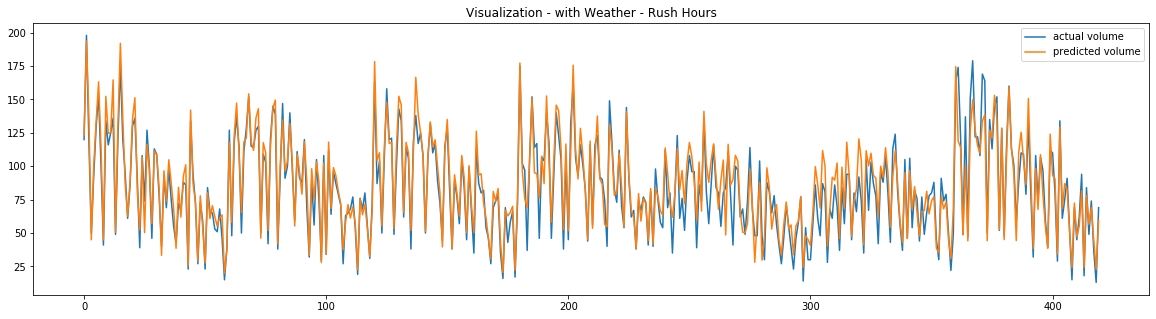

In [130]:
# Checking on the rush hour periods
test_df = avg_volume_test.copy()
test_df = convert_dataframe(test_df)
test_df['preds'] = test_preds

test_df_rush_hour = test_df[((test_df['hour'] >= 8) & (test_df['hour'] < 10)) | ((test_df['hour'] >= 17) & (test_df['hour'] < 19))]

plt.figure(figsize=(20,5))

plt.plot(test_df_rush_hour['volume'].values, label='actual volume')
plt.plot(test_df_rush_hour['preds'].values, label='predicted volume')
plt.title('Visualization - with Weather - Rush Hours')
plt.legend()
plt.show()

In [131]:
test_err = mape(test_df_rush_hour['volume'].values, test_df_rush_hour['preds'].values)
print ("MAPE: %f" % (test_err))

MAPE: 0.137198
